<a href="https://colab.research.google.com/github/genaiconference/Agentic_RAG_Workshop/blob/main/01_handling_multi_modal_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing Document and Processing using Azure Document Intelligence

This notebook demonstrates how to:
- process a document using Azure Document Intelligence,
- extract information
- process images within the document & Interpret using llm
- Insert the image interpretation in place of the image

In [ ]:
!git clone https://github.com/genaiconference/Agentic_RAG_Workshop.git

Cloning into 'Agentic_RAG_Workshop'...
remote: Enumerating objects: 317, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 317 (delta 113), reused 56 (delta 39), pack-reused 116 (from 1)
Receiving objects: 100% (317/317), 34.11 MiB | 5.71 MiB/s, done.
Resolving deltas: 100% (146/146), done.
Updating files: 100% (50/50), done.


## Setup and Installations
Install necessary libraries for document processing, data handling, and interacting with Azure Document Intelligence and OpenAI.

In [ ]:
!pip install -r /content/Agentic_RAG_Workshop/requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.0/106.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.9/187.9 kB 13.6 MB/s eta

## Load Environment Variables
Load environment variables containing API keys and endpoint information

In [ ]:
import os

os.chdir("/content/Agentic_RAG_Workshop/")

from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

doc_intelligence_endpoint=os.getenv("doc_intelligence_endpoint")
doc_intelligence_key=os.getenv("doc_intelligence_key")


llm = ChatOpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
    model="gpt-4.1",
    temperature=0,
)

## Data Source Details

We will be dealing with 2 types of Data Sources
1. HR Policies
    - Leave Policy Document
    - Insurance Policy Document
2. Annual Reports (10-K Documents)
    - Microsoft 2023 & 2024 Reports
    - Apple 2023 & 2024 Reports

## Define Paths and Load Documents

In [ ]:
import os
import pickle
from IPython.display import Markdown

# --- Configuration ---
# Define paths to all input files in the data folder and its subfolders
DATA_DIR = os.path.join(os.getcwd(),"data")
INPUT_FILE_PATHS = []

for root, _, files in os.walk(DATA_DIR):
    for file in files:
        if file.endswith(".pdf"):
            INPUT_FILE_PATHS.append(os.path.join(root, file))

PICKLE_DIR = os.path.join(os.getcwd(), "DI_output")
IMG_SAVE_DIR = os.path.join(PICKLE_DIR, "images")

# --- Ensure output directories exist ---
os.makedirs(PICKLE_DIR, exist_ok=True)
os.makedirs(IMG_SAVE_DIR, exist_ok=True)

print("Input files found:")
for file_path in INPUT_FILE_PATHS:
    print(file_path)

Input files found:
/content/Agentic_RAG_Workshop/data/HR Policies/Leave_Policy.pdf
/content/Agentic_RAG_Workshop/data/HR Policies/Insurance_Policy.pdf
/content/Agentic_RAG_Workshop/data/Annual Reports/Microsoft_2023.pdf
/content/Agentic_RAG_Workshop/data/Annual Reports/Apple_2024.pdf
/content/Agentic_RAG_Workshop/data/Annual Reports/Microsoft_2024.pdf
/content/Agentic_RAG_Workshop/data/Annual Reports/Apple_2023.pdf


## Run Document Intelligence (DI)

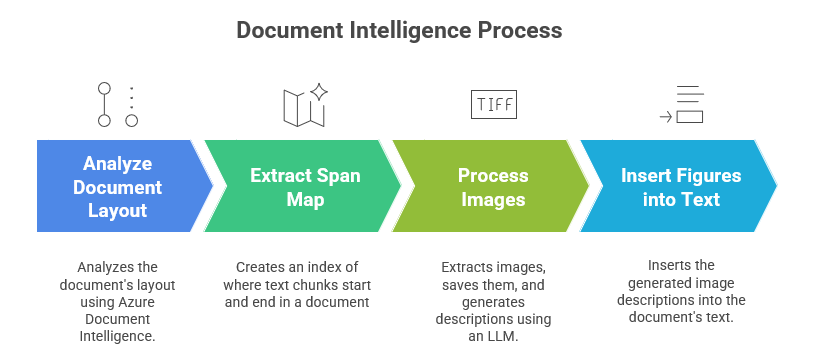

In [ ]:
import di_utils

def run_document_intelligence(INPUT_FILE_PATH):
  """
  Analyzes a document using Azure Document Intelligence, extracts information,
  processes images within the document, and integrates image descriptions
  into the document's text representation.

  Returns:
      tuple: A tuple containing:
          - md_result: The markdown result object from Azure Document Intelligence layout analysis.
          - result_with_image_descp: A string containing the document's markdown text with image descriptions inserted.
  """
  # Step 1: Analyze Document Layout
  md_result = di_utils.analyze_document_layout(INPUT_FILE_PATH, doc_intelligence_endpoint, doc_intelligence_key)

  # Step 2: Build Span Map
  """The extract_span_map function is like creating a special index or a detailed table of contents for your document.
  "Spans" are like pieces of text: Think of a "span" as just a section or chunk of text from your document, like a sentence, a paragraph, or even just a few words.
  The "Map" is like the index: The "map" is a list that tells you exactly where each of these text pieces (spans) starts and ends in the original document. It's like saying, "Paragraph 1 starts at page 5, line 1, and ends at page 5, line 10."
  So, extract_span_map goes through the document after Azure Document Intelligence has figured out where everything is, and it creates this index (the map) of where all the different text pieces (spans) are located within the full text of the document.

  Why is this useful? Later on, when we want to insert something new into the document's text (like the description of an image), we can use this map to figure out the exact spot where it should go without having to re-read the whole document every time. It helps us navigate and modify the text efficiently."""
  span_map = di_utils.extract_span_map(md_result)

  # Step 3: Process Images and Integrate with Text
  image_chunks = di_utils.process_images(INPUT_FILE_PATH, IMG_SAVE_DIR, md_result, llm)
  result_with_image_descp = di_utils.insert_figures_into_full_text(span_map, md_result, image_chunks)

  return md_result, result_with_image_descp

## Save the DI results as pickle file

In [ ]:
import os
import pickle
from IPython.display import Markdown

def process_document_and_save_results(input_file_path, output_dir):
    """
    Processes a document using Azure Document Intelligence, extracts information,
    processes images, integrates image descriptions, and saves the results to a pickle file.

    Args:
        input_file_path (str): The path to the input document file.
        output_dir (str): The directory to save the pickle file and images.

    Returns:
        tuple: A tuple containing:
            - md_result: The markdown result object from Azure Document Intelligence layout analysis.
            - result_with_image_descp: A string containing the document's markdown text with image descriptions inserted.
    """
    md_result, result_with_image_descp = run_document_intelligence(input_file_path)

    # Derive pickle file name from input file name
    file_name = os.path.basename(input_file_path)
    pickle_file_name = os.path.splitext(file_name)[0] + "_results.pkl"
    pickle_file_path = os.path.join(output_dir, pickle_file_name)

    # Save results to a single pickle file as a dictionary
    results_dict = {
        "md_result": md_result,
        "result_with_image_descp": result_with_image_descp
    }

    with open(pickle_file_path, "wb") as f:
        pickle.dump(results_dict, f)

    return result_with_image_descp

### Processing Insurance Policy Document

In [ ]:
DI_result = process_document_and_save_results(INPUT_FILE_PATHS[0], PICKLE_DIR)

Markdown(DI_result)

# LEAVE POLICY


## Objective

To provide guidelines to avail leave and to specify the leave procedures at
Pradhiran, Hyderabad.


## Applicability

The policy is applicable to all associates on a permanent employment contract with the
Company.


## Types of Leave


<table>
<tr>
<th>Leave</th>
<th>Entitlement</th>
<th>Encashment</th>
<th>Accumulation</th>
<th>Approved By</th>
</tr>
<tr>
<td>Annual</td>
<td>29 days</td>
<td>On separation or retirement</td>
<td>10 per annum up to 65 days</td>
<td>Immediate Manager</td>
</tr>
<tr>
<td>Sick</td>
<td>Open</td>
<td>Nil</td>
<td>Nil</td>
<td>Immediate Manager</td>
</tr>
<tr>
<td>Parental Leave (Birth / Surrogacy / Adoption)</td>
<td>26 weeks</td>
<td>Nil</td>
<td>Nil</td>
<td>Immediate Manager</td>
</tr>
<tr>
<td>Transition/Relo cation Leave</td>
<td>5 days</td>
<td>Nil</td>
<td>Nil</td>
<td>Immediate Manager</td>
</tr>
<tr>
<td>Marriage Leave</td>
<td>2 days</td>
<td>Nil</td>
<td>Nil</td>
<td>Immediate Manager</td>
</tr>
<tr>
<td>Bereavement Leave</td>
<td>2 days</td>
<td>Nil</td>
<td>Nil</td>
<td>Immediate Manager</td>
</tr>
<tr>
<td>Leave Without Pay</td>
<td>Maximum of 30 days</td>
<td>NA</td>
<td>NA</td>
<td>LF Head &amp; HR Business Partner</td>
</tr>
<tr>
<td>Compensatory Off</td>
<td>2 days</td>
<td>Nil</td>
<td>Nil</td>
<td>Immediate Manager</td>
</tr>
</table>


<!-- PageFooter="Back to Contents" -->
<!-- PageNumber="Page 1 of 7" -->
<!-- PageBreak -->


## Leave Guidelines

☐
For the purpose of calculating leave accounts, 'year' shall mean the year commencing
on the first day of April and ending on the last day of March next year ('Financial
year').

☐
Discretion is reserved with the manager empowered to sanction leave, to refuse or
revoke leave at any time according to the exigencies of the organization's work.

☐
Leave must be applied for through HR Core.
☐
The associate is responsible for his/her attendance and leave records and should
always keep it updated.


## 1.1 Annual Leave (AL)

Entitlement
☐
All associates are entitled to 29 working days of AL for the financial year, credited on
1 st April every year. Associates joining during the year will be credited with leave on
a pro-rate basis for the remaining part of the financial year.

New Joiners joining on or before the 15th of the month are entitled to (2) two days
☐
AL for the first month and those joining after the 15th of the month are entitled to 1
(one) AL for the month.

Associates can avail a minimum of half day Annual Leave at a time.
☐

Accumulation

☐
In a given year, an associate can carry forward a maximum of 10 days of AL. The
balance AL of that year would automatically lapse on 31 st March.

☐

For hires during the leave calendar year, the leave accumulation will be pro-rated up
to a maximum of 10 days.

☐
AL can be accumulated up to a maximum of 65 days in total. Any leave balance in
excess of 65 days will lapse without any encashment.
☐
For associates joining during the year, the accumulation of leaves will be pro-rated
up to a maximum limit of 10 days.

<!-- PageFooter="Back to Contents" -->
<!-- PageNumber="Page 2 of 7" -->
<!-- PageBreak -->


# Encashment

☐
Encashment of leaves will be calculated on Base Salary' (not basic salary) as per the
formula "Base Salary / 26 * no. of leaves"

Guidelines
☐
Intervening Holidays do not form part of the Annual Leave.
☐
AL can be combined with Sick Leave.
☐
If associate could not make use of the leave after it was sanctioned, he/she is required
to cancel the leave giving reasons to their manager in the system.
☐
[ On resignation/superannuation of services from the company, excess AL in the
current year, against entitlement, will be adjusted in the full & final settlement on a
pro-rata basis subject to a cap of 10 days AL.


## 1.2 Sick Leave

Objective & Eligibility

To give associates time off to recover and recuperate in the event of illness or accidents.
All internal associates are eligible for this policy.


### Procedures and Conditions

☐
The company may, at its discretion, grant sick leave to an associate, based on the
nature of sickness.
☐

In case of absence beyond 3 days, the associate is required to submit a medical
certificate.

In case where absence is likely to be prolonged beyond 3 days, the likely duration of
☐
absence along with the doctor's certificate certifying the same should be submitted.

[ Any sick leave in excess of 30 continuous days will require the approval of the division
☐

management team. The management team will review the case and may at its
discretion approve additional sick leave with pay or without pay (Loss of Pay - LOP).

[ The company may request the associate to undergo a medical examination by a
☐

nominated medical practitioner if felt necessary.
☐
Sick leaves can neither be accumulated nor encashed nor carried forward to the next
year.

<!-- PageFooter="Back to Contents" -->
<!-- PageNumber="Page 3 of 7" -->
<!-- PageBreak -->


### 1.3 Parental Leave

Both Birthing mother and Non-birthing parent are eligible for Parental Leave of 26 weeks
following the birth, surrogacy or adoption of a child.

Associates must avail the Parental Leave within one year of child's birth/surrogacy/adoption.
Any Parental Leave that is not used within one year of a covered life event will be forfeited
and will not be financially compensated, or carried forward. For details, refer to the policy
document - Parental Leave Policy - India


#### Leave Policy for Trainees

Interns are eligible for a maximum of one day per month during their internship period in
case of medical and personal exigencies, subject to Manager's approval.


##### Guidelines

☐
A minimum of one and maximum leave is at the discretion of the Manager.
☐
Intervening Holidays do not form part of the leave
☐
Any leave taken in excess of these 15 days in a given financial year would be treated
as leave without pay.


#### Leave Without Pay (LWP)


##### Eligibility

Leave without Pay (LWP) will be given to associates only in exceptional circumstances purely
at the discretion of the management. LWP can be availed only AFTER exhausting the Annual
Leave


##### Process

Any associate planning to go on LWP will need to apply for the same to the immediate
Manager which would be approved by the SLT member and HR.


##### Entitlement

Maximum 30 days Leave Without Pay in a year, at the discretion of the SLT member.

Unauthorised Absence

<!-- PageFooter="Back to Contents" -->
<!-- PageNumber="Page 4 of 7" -->
<!-- PageBreak -->

☐
Unauthorized absence refers to absence from work without requisite approval.
☐
The associate will need to offer an explanation to $\mathrm { h i s / h e r }$ immediate manager in the
event of any unauthorized absence.
☐
In the event of an associate failing to give an explanation to the satisfaction of the

immediate manager, the employment is liable to termination as per organization
rules.

The associate will not be eligible for payment of salary during this absence.
☐


###### General Compliance on Leave Rules

☐
Each associate is responsible for maintaining his/her updated leave record with all
leaves availed by him/her during the year on HR Core.

An associate on leave may be recalled to duty if an exceptional situation arises, and
the Company deems fit to do so.
☐
An associate going out of station during his/her leave must furnish to the manager
the contact numbers at which he/she can be contacted while out of station.
☐


### 1.4 Transition/Relocation Leave

Objective & Eligibility

Applicable only for those Associates who relocate (at the time of joining / internal
transfer) from other cities, it aims to provide them some time off to comfortably relocate
and settle in the new location.

Procedures and Conditions

☐
Eligible Associates will be entitled to Five (5) working days of Relocation Leave.
☐
This leave must be availed within Six (6) months from the date of joining / transfer
to the new location.
☐
The leave can be availed continuously or as and when required.

<!-- PageFooter="Back to Contents" -->
<!-- PageNumber="Page 5 of 7" -->
<!-- PageBreak -->


### 1.5 Marriage Leave

Entitlement
Associates can avail 2 days leave at the time of own marriage


#### Conditions

2 days need to be taken consecutively at the time of marriage. If the marriage falls over the
weekend, marriage leave can be clubbed with the weekend.


# 1.6 Bereavement Leave

Entitlement

In the unfortunate event of the death of a parent, sibling, spouse or child, associates may
avail 2 days leave within a period of 3 months of the event.


## 1.7 Compensatory Offs

Objective & Eligibility

In order to meet business exigency associates have to come to work on weekly off or
public holidays. Associates who work on public holidays / weekly off day in case of
exigencies of work will be provided with a compensatory off. Compensatory off is allowed
subject to approval from Operational Manager

Eligibility: All associates at GJFA 5 to 8

Procedures and Conditions

1\. An associate should have worked at least for 8 hours on any off day to avail
compensatory off for the same.

2\. The compensatory off must be availed within two months.

3\. The compensatory off cannot be taken in advance.

4\. The compensatory off will not be carried forward or accumulated or en-cashed.

5\. Maximum 2 compensatory offs can be availed in a month

<!-- PageFooter="Back to Contents" -->
<!-- PageNumber="Page 6 of 7" -->
<!-- PageBreak -->


### 1.8 Periodical Review of Leave Records

It is the responsibility of the manager to ensure that the leave records of their respective
teams are periodically reviewed and any discrepancies identified should be immediately
brought to the notice of the HRBP. HRBPs will then initiate corrections, if required, by
sending it to the HR Services team (XDHR) or through the employee/manager on HR
Core directly. In case any leaves are not recorded, managers should ensure that the
leaves are recorded on HR Core. Sufficient evidences of periodical review of leave records
should be maintained by the managers for their teams.

<!-- PageFooter="Back to Contents" -->
<!-- PageNumber="Page 7 of 7" -->


### Processing Leave Policy Document

In [ ]:
DI_result = process_document_and_save_results(INPUT_FILE_PATHS[1], PICKLE_DIR)

Markdown(DI_result)

starting up...
entered...
	Caption: 
page numer: 1
Opening PDF file: %s /content/Agentic_RAG_Workshop/data/HR Policies/Insurance_Policy.pdf
image cropped
image saved as/content/Agentic_RAG_Workshop/DI_output/images/Insurance_Policy_cropped_image_0.png
entered...
	Caption: 
page numer: 3
Opening PDF file: %s /content/Agentic_RAG_Workshop/data/HR Policies/Insurance_Policy.pdf
image cropped
image saved as/content/Agentic_RAG_Workshop/DI_output/images/Insurance_Policy_cropped_image_1.png
entered...
	Caption: 
page numer: 3
Opening PDF file: %s /content/Agentic_RAG_Workshop/data/HR Policies/Insurance_Policy.pdf
image cropped
image saved as/content/Agentic_RAG_Workshop/DI_output/images/Insurance_Policy_cropped_image_2.png
entered...
	Caption: 
page numer: 3
Opening PDF file: %s /content/Agentic_RAG_Workshop/data/HR Policies/Insurance_Policy.pdf
image cropped
image saved as/content/Agentic_RAG_Workshop/DI_output/images/Insurance_Policy_cropped_image_3.png
entered...
	Caption: 
page numer: 6
O

AON

Employee Benefits
Manual 2023-24
PRADHIRAN Group


<figure>
</figure>


<!-- PageFooter="Aon India Insurance Brokers Private Limited (Formerly Anviti Insurance Brokers Private Limited) CIN U66000KA2016PTC095559, Composite Insurance Broker, IRDAI Licence No.624, Valid till 15/10/2023, aon.com Registered Office - Unit 102, 1st Floor, The Estate, 121 Dickenson Road, Bengaluru 560042" -->
<!-- PageBreak -->


# Group Hospitalization Policy

The Group Medical policy covers
expenses for the insured (employee &
eligible family members) on account of
hospitalization due to sickness or
accident. The policy covers expenses
incurred on room rent, medicines, surgery
etc. Expenses for hospitalization are
payable only if a 24-hour hospitalization
has been taken. Group Mediclaim is an
annual plan effective from 1st July 2023
to 30th June 2024; terms and conditions
are subject to renewal on annual basis.

8

2

<!-- PageFooter="AON" -->
<!-- PageBreak -->


# Make The Best Use Of Your Benefits


<figure>


The process begins with enrollment, which involves planning the enrollment and following the necessary steps to obtain an E-Card. It is essential to ensure that all dependent details are accurately listed, including the name, date of birth, gender, age, and relationship information for each dependent. This information must be correctly entered and maintained in the HR database to complete the process successfully. The flow emphasizes the importance of accuracy and completeness in providing dependent information during the enrollment process.
Getting Enrolled

· Plan Enrollment &
Process for getting
your E-Card

Please ensure that all your
dependent details are listed, and
their corresponding information
provided Name, DOB, Gender,
Age, and relationship details etc.
are captured correctly in HR
Database

</figure>


Benefit Plan Details

· Plan Information,
Benefit Details &
General Exclusions

O

Please refer Employee
Insurance Benefit Manual for
information on Coverage,
exclusions & do save
emergency contact points, this
will be very handy in case of
emergency.


<figure>


The process of making a claim involves understanding the hospitalization procedure, reviewing the claims checklist, and referring to key frequently asked questions. It is essential to submit all required documents in their entirety and in original form at the first opportunity. Failure to provide complete documentation may result in the claim being closed. It is also important to keep copies of all documents submitted to the insurer for your records.
Making A Claim

· Hospitalization
Procedure, Claims
Check List and Key
FAQS

O

Please ensure that your documents are
submitted entirely at the first instance
itself and originals are submitted.
Incomplete submissions may lead to
the claim getting closed. Please also
retain a copy of all claim documents
submitted to the insurer.

</figure>


<figure>

<!-- PageFooter="AON" -->

</figure>


<!-- PageFooter="PRADHIRAN Group-Employee Benefits Manual 2023-24" -->
<!-- PageNumber="3" -->
<!-- PageBreak -->


# Your Plan Details


<table>
<tr>
<td colspan="2">Plan Name : Group Mediclaim Policy</td>
</tr>
<tr>
<td>Policy Holder</td>
<td>PRADHIRAN Pvt Ltd</td>
</tr>
<tr>
<td>Policy period</td>
<td>01-Jul-2023 To 30-Jun-2024</td>
</tr>
<tr>
<td>Insurer</td>
<td>Aditya Birla Health Insurance Co. Ltd</td>
</tr>
<tr>
<td>TPA</td>
<td>Medi Assist India TPA Pvt. Ltd.</td>
</tr>
<tr>
<td>Sum Insured Limits</td>
<td>Uniform INR 7 Lacs</td>
</tr>
<tr>
<td>Geographical Limits</td>
<td>India</td>
</tr>
<tr>
<td>Family Definition</td>
<td>. Single Associates - Self and 2 Dependent Parents or Partner . Married Associates - Self, Spouse or Partner and All Dependent Children upto 25 years ("Partner" includes married spouse, Domestic Partner (unmarried same sex or opposite sex) If Husband and Wife both are working with Pradhiran Group, family definition will differ specifically for those i.e. one employee can cover spouse and other can cover parents.</td>
</tr>
<tr>
<td>Mid-Term Enrollment</td>
<td>Allowed only for New Joiner, Newly Married Spouse &amp; Newborn Baby</td>
</tr>
</table>


AON

<!-- PageNumber="4" -->
<!-- PageBreak -->


## Your Plan Details Family Definition


<table>
<tr>
<th>Particular</th>
<th>Included</th>
<th>Special Condition if any</th>
</tr>
<tr>
<td>Employee</td>
<td>Yes</td>
<td>-</td>
</tr>
<tr>
<td>Spouse</td>
<td>Yes</td>
<td>-</td>
</tr>
<tr>
<td>Child</td>
<td>Yes</td>
<td>· All dependent children till age of 25 years · No age limit for differently abled children · Legally adopted children of single employees/ same sex LGBT employees</td>
</tr>
<tr>
<td>Parents</td>
<td>Yes</td>
<td>Only for unmarried employees Parents over the age of 85 are covered only if they were covered in previous year policy</td>
</tr>
<tr>
<td>Live -in/same sex LGBT Partner</td>
<td>Yes</td>
<td>Only for unmarried employees after due declaration submission and if parents are not covered</td>
</tr>
<tr>
<td>Parent-in-Laws</td>
<td>No</td>
<td>-</td>
</tr>
<tr>
<td>Sibling</td>
<td>No</td>
<td>-</td>
</tr>
</table>


AON

<!-- PageNumber="5" -->
<!-- PageBreak -->


# Your Plan Details


<table>
<tr>
<td>Standard Hospitalization</td>
<td>Covered</td>
</tr>
<tr>
<td>Pre-existing Diseases</td>
<td>Covered</td>
</tr>
<tr>
<td>Restriction on Room-Rent</td>
<td>For Normal-1% of Sum insured or single private AC room whichever is higher For ICU- As per actuals</td>
</tr>
<tr>
<td>Maternity Benefits</td>
<td>Covered</td>
</tr>
<tr>
<td>Maternity Limits</td>
<td>INR 75,000 for Normal &amp; INR 1 Lac (New) for Caesarean Section to only 2 deliveries</td>
</tr>
<tr>
<td>Pre &amp; Post Natal Expenses</td>
<td>Covered up to INR 5,000 , over and above the maternity limit, to only 2 deliveries</td>
</tr>
<tr>
<td>Newborn Baby Cover</td>
<td>Covered from day one subject to intimation to HR within 15 days from date of birth</td>
</tr>
<tr>
<td>Congenital Disease</td>
<td>Internal Congenital - Covered External Congenital - Covered in Life Threatening Situations only</td>
</tr>
<tr>
<td>Dental Benefit</td>
<td>Covered only in Accident cases (Hospitalization)</td>
</tr>
<tr>
<td>Critical Illness</td>
<td>Covered on voluntary basis</td>
</tr>
<tr>
<td>Diagnostics Expenses</td>
<td>Standalone diagnostic not covered</td>
</tr>
<tr>
<td>Ambulance Services</td>
<td>Local emergency Ambulance covered up to INR 3,000/- per person per policy. Ambulance cover to hometown for carriage of mortal remains of employee, covered up to INR 100,000</td>
</tr>
<tr>
<td>Non-Medical Expense</td>
<td>In the event of an employee's death during treatment or procedure, the plan will cover the entire cost of the including non-medical charges, otherwise, the associate is typically responsible for non- medical expenses</td>
</tr>
</table>


<figure>

AON

</figure>


<!-- PageFooter="PRADHIRAN Group-Employee Benefits Manual 2023-24" -->
<!-- PageNumber="6" -->
<!-- PageBreak -->


# Your Plan Details Policy Benefits


<table>
<tr>
<td>Pre &amp; Post Hospitalization Expenses</td>
<td>30 days prehospitalization and 60 days post hospitalization.</td>
</tr>
<tr>
<td>Claims Submission Timeframes</td>
<td>Submission within 30 days from Date of Discharge</td>
</tr>
<tr>
<td>Claims Intimation Timeframes</td>
<td>Waived off</td>
</tr>
<tr>
<td>Therapy area brief - Plaque Psoriasis, Psoriatic Arthritis &amp; Ankylosing Spondylitis</td>
<td>covered up to INR 2,00,000 per family on OPD &amp; IPD basis</td>
</tr>
<tr>
<td>Refractive error or sight correction $\left( + / - \right) 7$</td>
<td>For Myopia, Astigmatism and Hypermetropia) covered with a cap of INR 50,000/- family limit</td>
</tr>
<tr>
<td>Macular Degeneration of Retina</td>
<td>Macular Degeneration of Retina (covering specific macular Indications - wAMD, DME, Diabetic Retinopathy , Retinal Vein Occlusion (cRVO and bRVO) and Retinopathy of prematurity) covered up to 50% of the sum insured either as in patient or as part of day care treatment</td>
</tr>
<tr>
<td>Gender Dysphoria (Gender change)</td>
<td>covered within family sum insured limits</td>
</tr>
<tr>
<td>Migraine management</td>
<td>Treatment using Monoclonal Antibodies for Episodic and Chronic Migraine patients with a capped at payout of INR 125,000 per family</td>
</tr>
</table>


AON

<!-- PageNumber="7" -->
<!-- PageBreak -->


## Your Plan Details New Age Treatment covered under policy

$$N e w \quad A g e \quad T r e a t m e n t \quad o r \quad P r o c e d u r e$$


<table>
<tr>
<th></th>
<th>Limit as per (Per Policy Period)</th>
</tr>
<tr>
<td>Uterine Artery Embolization and HIFU (High intensity focused ultrasound)</td>
<td>Upto 50% of Sum Insured</td>
</tr>
<tr>
<td>Balloon Sinuplasty</td>
<td>Upto 50% of Sum Insured</td>
</tr>
<tr>
<td>Deep Brain stimulation</td>
<td>Upto 50% of Sum Insured</td>
</tr>
<tr>
<td>Oral chemotherapy</td>
<td>Upto 50% of Sum Insured</td>
</tr>
<tr>
<td>Immunotherapy- Monoclonal Antibody to be given as injection</td>
<td>Upto 50% of Sum Insured</td>
</tr>
<tr>
<td>Robotic surgery</td>
<td>Upto 50% of Sum Insured</td>
</tr>
<tr>
<td>Stereotactic radio surgery</td>
<td>Upto 50% of Sum Insured</td>
</tr>
<tr>
<td>Bronchial Thermoplasty</td>
<td>Upto 50% of Sum Insured</td>
</tr>
<tr>
<td>Vaporisation of the prostrate (Green laser treatment or holmium laser treatment)</td>
<td>Upto 50% of Sum Insured</td>
</tr>
<tr>
<td>IONM - (Intra Operative Neuro Monitoring)</td>
<td>Upto 50% of Sum Insured</td>
</tr>
<tr>
<td>Stem cell therapy: Hematopoietic stem cells for bone marrow transplant for haematological conditions to be covered</td>
<td>Upto 50% of Sum Insured</td>
</tr>
</table>


AON

<!-- PageNumber="8" -->
<!-- PageBreak -->


## Your Plan Details What Is Covered?

If any Insured Person suffers an Illness or Accident during the Policy Period that requires Insured Person's hospitalization as an inpatient,
then the insurer will reimburse reasonable and customary expenses towards the below mentioned hospitalization under your group
medical plan.

· Inpatient Treatment

· Room rent and boarding expenses

· Doctor's fees ( who needs to be a medical practitioner)

· Intensive Care Unit

· Nursing expenses, Anesthesia, blood, oxygen, operation theatre charges, surgical appliances,

· Medicines, drugs and consumables (Dressing, ordinary splints and plaster casts)

· Diagnostic procedures (such as laboratory, x-ray, diagnostic tests)

· Costs of prosthetic devices if implanted internally during a surgical procedure

· Organ transplantation including the treatment costs of the donor but excluding the costs of the organ

The expenses shall be reimbursed provided they are incurred in India and are within the policy period. Expenses will be reimbursed
to the covered member depending on the level of cover that he/she is entitled to. Expenses that are of a diagnostic nature only or
are incurred from a preventive perspective with no active line of treatment and do not warrant a hospitalization admission are not
covered under the plan.

<!-- PageFooter="AON" -->
<!-- PageNumber="9" -->
<!-- PageBreak -->


### Your Plan Details Pre & Post Hospitalization Expenses


<table>
<tr>
<td colspan="2">Pre-hospitalization expenses</td>
</tr>
<tr>
<td>Pre-hospitalization Expenses</td>
<td>If the Insured Person is diagnosed with an Illness which results in his or her Hospitalization and for which the Insurer accepts a claim, the Insurer will reimburse the Insured Person's Pre-hospitalization Expenses for up to 30 days prior to his Hospitalization as long as the 30-day period commences and ends within the Policy Period.</td>
</tr>
<tr>
<td>Duration</td>
<td>Within 30 days before hospitalization</td>
</tr>
</table>


<table>
<tr>
<td colspan="2">Post hospitalization expenses</td>
</tr>
<tr>
<td>Post-hospitalization Expenses</td>
<td>If the Insurer accepts a claim above and, immediately following the Insured Person's discharge, he requires further medical treatment directly related to the same condition for which the Insured Person was Hospitalized, the Insurer will reimburse the Insured Person's Post-hospitalization Expenses</td>
</tr>
<tr>
<td>Duration</td>
<td>Within 60 days post discharge</td>
</tr>
</table>


AON

<!-- PageNumber="10" -->
<!-- PageBreak -->


### Your Plan Details Maternity Benefits

· Maternity benefits are admissible only if the expenses are incurred in Hospital / Nursing Home as in-patients in India.

· Those Insured Persons who already have two or more living children will not be eligible for this benefit.

· Expenses incurred in connection with voluntary medical termination of pregnancy during the first 12 weeks from the date
of conception are not covered. Infertility Treatment and sterilization are excluded from the policy.


#### The maternity benefit under your Group Medical Plan


<table>
<tr>
<td>Maximum Benefit</td>
<td>INR 75,000 for Normal &amp; INR 1 Lac (New) for C - Section within Sum Insured Limit</td>
</tr>
<tr>
<td>9-months waiting period</td>
<td>Waived off</td>
</tr>
<tr>
<td>Pre-Post Natal expenses</td>
<td>Covered up to INR 5,000 over and above the maternity limit</td>
</tr>
<tr>
<td>Newborn baby covered from day 1</td>
<td>Covered from day 1, subject to intimation to HR within 15 days from date of birth</td>
</tr>
</table>


IMPORTANT :

For maternity reimbursements and employees on subsequent maternity leave, please do not wait till you have returned
back to office to submit a claim as it will cross the claim submission within 30 days to avoid denial of claim. Please also
immediately inform your HR about the new baby coverage as your dependent as A subsequent complication may be A
possibility and intimation is mandatory prior to coverage


<figure>

<!-- PageFooter="AON" -->

</figure>


<!-- PageNumber="11" -->
<!-- PageBreak -->


## Your Plan Details


<table>
<tr>
<th>Policy Benefit</th>
<th>Definition</th>
<th>Covered/Not Covered</th>
</tr>
<tr>
<td>Pre-existing Diseases</td>
<td>Any Pre-Existing Condition or related condition for which care, treatment or advice was recommended by or received from a Doctor or which was first manifested prior to the commencement date of the Insured Person's first Health Insurance policy with the Insurer</td>
<td>Covered</td>
</tr>
<tr>
<td>First 30 days' waiting period</td>
<td>Any Illness diagnosed or diagnosable within 30 days of the effective date of the Policy Period if this is the first Health Policy taken by the Policyholder with the Insurer.</td>
<td>Covered</td>
</tr>
<tr>
<td>First Year Waiting Period</td>
<td>During the first year of the operation of the policy the expenses on treatment of diseases such as Cataract, Benign Prostatic Hypertrophy, Hysterectomy for Menorrhagia or Fibromyoma, Hernia, Hydroceie, Congenital Internal Diseases, Fistula in anus, Piles, Sinusitis and related disorders are not payable. If these diseases are pre- existing at the time of proposal, they will not be covered even during subsequent period or renewal too</td>
<td>Waived off</td>
</tr>
<tr>
<td>Day Care</td>
<td>Day Care Procedure means the course of medical treatment, or a surgical procedure listed in the Schedule which is undertaken under general or local anesthesia in a Hospital by a Doctor in not less than 2 hours and not more than 24 hours.</td>
<td>Covered</td>
</tr>
<tr>
<td>Diagnostic Expenses</td>
<td>All diagnostic tests and lab tests as part of hospitalization and pre-post hospitalization including OPD. Diagnostic tests without treatment or not related to treatment are not covered</td>
<td>Covered and Only incase of 24-hr hospitalization related to treatment</td>
</tr>
</table>


AON

<!-- PageNumber="12" -->
<!-- PageBreak -->


## Your Plan Details


### How to Enroll?


<table>
<tr>
<th>Particular</th>
<th>Description</th>
<th>Special Condition if any</th>
</tr>
<tr>
<td>Enrollment of existing employees' and their dependents</td>
<td>Enrollment/Validation</td>
<td>Employee to either declare new dependents or validate current dependent details at the time of renewal every year</td>
</tr>
<tr>
<td>Enrollment of New Joinees (New Employees + their Dependents) during the policy year</td>
<td>Declaration</td>
<td>Dependent information needs to be updated with 30 days from date of joining on HR system</td>
</tr>
</table>


### Mid Term Enrollment Eligibility?


<table>
<tr>
<th>Particular</th>
<th>Description</th>
<th>Special Condition if any</th>
</tr>
<tr>
<td>Mid-Term Enrollment of Existing employees' Dependents(as on plan start date)</td>
<td>Not Allowed</td>
<td></td>
</tr>
<tr>
<td>Mid-Term Enrollment of New Joinees (New Employees +Their Dependents)</td>
<td>Allowed *</td>
<td></td>
</tr>
<tr>
<td>Mid-Term Enrollment of New Dependents (Spouse/Children)</td>
<td>Allowed *</td>
<td>Midterm enrollment of new dependents (Spouse / Children) is allowed for employees within 30 days from Date of Marriage/ Date of Birth.</td>
</tr>
<tr>
<td>Mid term inclusion of Parents</td>
<td>Allowed</td>
<td>Only in case of legal divorce, death of spouse and if no children are enrolled in the policy, required documents have to be submitted to respective HR spocs</td>
</tr>
</table>


<!-- PageFooter="AON" -->
<!-- PageNumber="13" -->
<!-- PageBreak -->


# Getting Enrolled Process for Domestic Partner Enrolment

· DOMESTIC PARTNERSHIP* means a committed relationship between two adults (same or opposite sex),
that meets all of the requirements as per the attached declaration form

· Dependent Children: To qualify as a dependent child, the child must be legally adopted child of an
employee or his/her domestic partner should be a legal parent of child(ren), legal document to be
submitted as a part of the declaration process

· Please email the following below mentioned details to your respective HR SPOCs with duly filled and
signed Declaration Form

A. Your Employee Code

B. Full Name of the Partner

C. DOB of the Partner

D. Gender of the Partner


<figure>

PDF

Domestic
Declaration Form

</figure>


Please Note:

If you opt for the above partner enrolment, then in line with
the eligibility guidelines your parents shall no longer be
eligible for cover under the medical insurance plan and will
be removed from coverage .

<!-- PageFooter="AON" -->
<!-- PageNumber="14" -->
<!-- PageBreak -->


# Health E- Cards Process of Download E-Health Id Cards


<figure>

Medi Assist

</figure>


Test000

«Home

EMenu

[+ Sign out

· Enter URL in address bar of
your browser :
https://portal.medibuddy.in/lo
gin.aspx

. Sign in with Username and
Password as received via mail
from

. Click on the menu, located at
top right corner

. Click on "E Card" to download
pdf of your E 
A comprehensive health insurance portal interface is organized into distinct functional sections, each representing a specific service or information area. The top section provides access to claims management, wellness resources, pharmacy services, health-related updates, and a hospital search tool. The central area focuses on policy information, including an employee policy search, enrollment options, and the ability to download electronic cards. The lower section offers user profile management, cashless service initiation, reimbursement processes, claim submission, and direct contact options, including a helpline number and an email link. Each section is clearly labeled, ensuring users can efficiently navigate to the desired service or information, supporting a streamlined experience for managing health coverage and related activities.
cards.


<figure>

Wellness

Your claims

Pharmacy

Health bites

Search hospitals

Know
your
health
cover

Enrolment

Employee policy

Download E-cards

Contact us

eCashless

1800-425-9449

Write to us

Your profile

Intimate
Reimbursement

Submit claim

</figure>


<!-- PageFooter="AON" -->
<!-- PageNumber="15" -->
<!-- PageBreak -->


# Voluntary Critical Illness - Plan Details Policy Benefits


<table>
<tr>
<td>Cover Definition</td>
<td>A policy that pays a lump sum amount equal to the sum insured upon first diagnosis of $a$ critical illness covered under the policy. In this case, 36 Critical Illnesses are covered</td>
</tr>
<tr>
<td>Sum Insured</td>
<td>INR 10 Lakhs</td>
</tr>
<tr>
<td>Cover Type</td>
<td>Individual cover of INR 10 Lakhs</td>
</tr>
<tr>
<td>Family Definition</td>
<td>Employee, Spouse &amp; Dependent Children (min 5 years age)</td>
</tr>
<tr>
<td>Waiting Period</td>
<td>90 Days</td>
</tr>
<tr>
<td>Survival Period</td>
<td>30 days</td>
</tr>
<tr>
<td>Pre-Existing Diseases</td>
<td>Not covered</td>
</tr>
<tr>
<td>Number of Critical Illness cover</td>
<td>36 Critical Illness covered (separate slide of covers in detail)</td>
</tr>
</table>


<!-- PageFooter="AON" -->
<!-- PageNumber="16" -->
<!-- PageBreak -->


# Critical Illness (1/2) List of New 36 Critical Illness


<table>
<tr>
<th>Cancer of specific severity</th>
<th>Multiple Sclerosis with Persisting Symptoms</th>
</tr>
<tr>
<td>Myocardial Infarction</td>
<td>Coma of Specified Severity</td>
</tr>
<tr>
<td>Open Chest CABG</td>
<td>Motor Neurone Disease with Permanent Symptoms</td>
</tr>
<tr>
<td>Open Heart Replacement or Repair of Heart Valves</td>
<td>Loss of Vision (Blindness)</td>
</tr>
<tr>
<td>Kidney Failure Requiring Regular Dialysis</td>
<td>Major burns</td>
</tr>
<tr>
<td>Stroke Resulting in Permanent Symptoms</td>
<td>Parkinson's Disease</td>
</tr>
<tr>
<td>Major Organ / Bone Marrow Transplant</td>
<td>Benign Brain Tumor</td>
</tr>
<tr>
<td>Permanent Paralysis of Limbs</td>
<td>Alzheimer's Disease</td>
</tr>
<tr>
<td>Bacterial Meningitis</td>
<td>Apallic Syndrome or Persistent Vegetative State (PVS)</td>
</tr>
</table>


<!-- PageFooter="AON" -->
<!-- PageNumber="17" -->
<!-- PageBreak -->


# Critical Illness (2/2) List of New 36 Critical Illness


<table>
<tr>
<th>Aorta Graft Surgery</th>
<th>Encephalitis</th>
</tr>
<tr>
<td>Loss of Hearing (Deafness)</td>
<td>Fulminant Hepatitis</td>
</tr>
<tr>
<td>Loss of Limbs</td>
<td>Chronic Relapsing Pancreatitis</td>
</tr>
<tr>
<td>Loss of Speech</td>
<td>Major Head Trauma</td>
</tr>
<tr>
<td>Aplastic Anaemia</td>
<td>Medullary Cystic Disease</td>
</tr>
<tr>
<td>End Stage Liver Failure</td>
<td>Muscular Dystrophy</td>
</tr>
<tr>
<td>End Stage Lung Failure</td>
<td>Poliomyelitis</td>
</tr>
<tr>
<td>Primary (Idiopathic) Pulmonary Hypertension</td>
<td>Systemic Lupus Erythematous</td>
</tr>
<tr>
<td>Coronary Angioplasty (PTCA)[1]</td>
<td>Brain Surgery</td>
</tr>
</table>


<!-- PageFooter="AON" -->
<!-- PageNumber="18" -->
<!-- PageBreak -->


# Critical Illness General Exclusions


<table>
<tr>
<td>1</td>
<td>We shall not be liable to make any payment in respect of any Critical Illness whose signs or symptoms first occur within the first 90 days from the Inception Date</td>
</tr>
<tr>
<td>2</td>
<td>Any claim with respect to any Critical Illness diagnosed or which manifested prior to the Inception Date</td>
</tr>
<tr>
<td>3</td>
<td>Any Pre-Existing Disease or any complication arising therefrom</td>
</tr>
<tr>
<td>4</td>
<td>Any Critical Illness arising out of use, abuse or consequence or influence of any substance, intoxicant, drug, alcohol or hallucinogen</td>
</tr>
<tr>
<td>5</td>
<td>Any Critical Illness directly or indirectly caused due to intentional self-injury, suicide or attempted suicide; whether the person is medically sane or insane</td>
</tr>
<tr>
<td>6</td>
<td>Working in underground mines, tunneling or involving electrical installations with high tension supply, or as jockeys or circus personnel</td>
</tr>
<tr>
<td>7</td>
<td>Any loss resulting directly or indirectly contributed or aggravated or prolonged by childbirth or from pregnancy</td>
</tr>
<tr>
<td>8</td>
<td>Any Critical Illness arising or resulting from the Insured Person committing any breach of law or participating in an actual or attempted felony, riot, crime, misdemeanor or civil commotion with criminal intent</td>
</tr>
</table>


AON

<!-- PageNumber="19" -->
<!-- PageBreak -->


# Voluntary Parent's Policy- Plan Details


<table>
<tr>
<td colspan="2">Plan Name : Voluntary Parent's Mediclaim Policy</td>
</tr>
<tr>
<td>Policy Holder</td>
<td>Pradhiran Pvt Ltd</td>
</tr>
<tr>
<td>Policy period</td>
<td>01-Jul-2023 To 30-Jun-2024</td>
</tr>
<tr>
<td>Insurer</td>
<td>Aditya Birla Health Insurance Co. Ltd</td>
</tr>
<tr>
<td>TPA</td>
<td>Medi Assist India TPA Pvt. Ltd.</td>
</tr>
<tr>
<td>Sum Insured Limits</td>
<td>INR 3 Lacs &amp; INR 5 Lacs</td>
</tr>
<tr>
<td>Geographical Limits</td>
<td>India</td>
</tr>
<tr>
<td>Family Definition</td>
<td>. Parents or Parent In Laws . Cross combination not allowed Parents here refers the Primary Insured's natural parents or parents that have legally adopted him/her</td>
</tr>
<tr>
<td>Entry Age for Parents</td>
<td>For Parents/ in laws- Entry age restricted upto 85 years</td>
</tr>
</table>


AON

<!-- PageNumber="20" -->
<!-- PageBreak -->


# Voluntary Parent's Policy - Plan Details (12)


<table>
<tr>
<td>Room Rent Restriction</td>
<td>2% of the in-patient Sum Insured, if admitted to regular room. All benefits as an inpatient in a hospital attached to room will be restricted to the room, which falls within the room rent limits allowed. The enhanced difference in expenses due to opting rooms with higher room rent than what has been allowed will be borne by the insured only. Wherever the room rent based tariff for the other expenses is not available, the payment would be done in the same proportion as per the entitlement of room rent under the policy excluding medicines, consumables and implants medically prescribed by the treating doctor under the policy. In case of package treatment where individual bifurcation of room rent, medicines, operation theatre expenses, doctor's consultation charges etc. are not available, then the package charges shall be proportionately linked to the entitled room rent of the insured person under the policy.</td>
</tr>
<tr>
<td>Pre &amp; Post Hospitalization expenses</td>
<td>30 Days Pre-Hospitalization &amp; 60 days Post-Hospitalization (to be claimed as reimbursements)</td>
</tr>
<tr>
<td>Road Ambulance Charges</td>
<td>Covered upto INR 2500 per case in case of emergency only. Ambulance charges will be applicable for transferring patient to Hospital or between Hospitals in the Hospitals ambulance or in an ambulance provided by any ambulance service provider only</td>
</tr>
<tr>
<td>Internal Congenital</td>
<td>Covered</td>
</tr>
<tr>
<td>Cataract Surgery</td>
<td>Mono and/or Multifocal Lens covered</td>
</tr>
<tr>
<td>Survival Period</td>
<td>30 days</td>
</tr>
<tr>
<td>Co-Pay</td>
<td>10% Co-Pay on each and every claim</td>
</tr>
</table>


<figure>

AON

</figure>


<!-- PageNumber="21" -->
<!-- PageBreak -->


## Voluntary Parent's Policy - Plan Details (2/2)


<table>
<tr>
<td>Special Conditions</td>
<td>Pandemic and Dental and Vision in cases of accidents covered, only in case of accidents. Refractive error or sight correction $\left( + / - \right) 7$ and macular degeneration of retina- on IPD and OPD basis, Final decision will be taken on receipt of complete set of documents. 50% Co-Pay for cyber-knife treatment, Gamma Knife treatment and Stem Cell Transplantation, Robotic Surgery, Femto laser treatment for eye. It will be applicable for each eye each event. Cochlear Implant treatment shall be restricted to 50% of the SI. Coverage under this benefit is subject to the procedure being authority-approved indication for the medical condition, and should not be experimental and unproven treatment as on date</td>
</tr>
<tr>
<td>Pre-Existing exclusions/1st year exclusions/30 days waiting period</td>
<td>Waived off</td>
</tr>
<tr>
<td>Claims Submission Timeframes</td>
<td>Submission within 30 days from Date of Discharge</td>
</tr>
<tr>
<td>Claims Intimation Timeframes</td>
<td>Waived off</td>
</tr>
<tr>
<td>Terrorism</td>
<td>Covered</td>
</tr>
</table>


AON

<!-- PageNumber="22" -->
<!-- PageBreak -->


# Know Your Room Rent Limit Proportionate Deduction Clause

· Insured employees are requested to use prudence and proper negotiation with Hospital/ Nursing home in availing
the eligible room category.

. Please remember, higher the room category higher is the cost of treatment. This may result in faster exhaustion
of your total available eligibility

· Employee opting for a higher room category will have to bear the proportionate increase in cost on all categories /
heads.

. For example: if an employee opts for room of INR 10,000 per day , 50% deduction shall be applicable for overall
bill except for the cost of medicines.

· Any expenses like nursing / electricity / monitor charges / etc. charged separately will be considered under room
rent cost and will not be payable if charged separately.

<!-- PageFooter="AON" -->
<!-- PageNumber="23" -->
<!-- PageBreak -->


## Your Plan Details(1/3) General Exclusions

· Injury or disease directly or indirectly caused by or arising from or attributable to War, Invasion, Act of Foreign Enemy, War like
operations (whether war be declared or not) or by nuclear weapons / materials.

· Circumcision (unless necessary for treatment of a disease not excluded hereunder or as may be necessitated due to any accident),
vaccination, inoculation or change of life or cosmetic or of aesthetic treatment of any description, plastic surgery other than as may
be necessitated due to an accident or as a part of any illness.

· Surgery for correction of eye- sight, cost of spectacles, contact lenses, hearing aids etc.

· Cosmetic or of aesthetic procedure, filling of cavity, root canal including wear and tear etc unless arising from disease or injury and
which requires hospitalization for treatment.

· Congenital external diseases or defects/anomalies

· Convalescence, general debility, "run down" condition or rest cure, congenital external diseases or defects or anomalies, sterility,
any fertility, sub-fertility or assisted conception procedure, venereal diseases, intentional self-injury/suicide, all psychiatric and
psychosomatic disorders and diseases / accident due to and or use, misuse or abuse of drugs / alcohol or use of intoxicating
substances or such abuse or addiction etc.

. Any cosmetic or plastic surgery except for correction of injury

· Expenses incurred at Hospital or Nursing Home primarily for evaluation / diagnostic purposes which is not followed by active
treatment for the ailment during the hospitalized period.

· Expenses on vitamins and tonics etc unless forming part of treatment for injury or disease as certified by the attending physician.

· Any Treatment arising from or traceable to pregnancy, miscarriage, abortion or complications of any of these including changes in
chronic condition as a result of pregnancy except where covered under the maternity section of benefits.

<!-- PageFooter="AON" -->
<!-- PageNumber="24" -->
<!-- PageBreak -->


## Your Plan Details(2/3) General Exclusions

· Doctor's home visit charges, Attendant / Nursing charges during pre and post Hospitalization period.

· Treatment which is continued before hospitalization and continued even after discharge for an ailment / disease / injury different
from the one for which hospitalization was necessary.

· Naturopathy treatment, unproven procedure or treatment, experimental or alternative medicine and related treatment including
acupressure, acupuncture, magnetic and such other therapies etc.

· External and or durable Medical / Non-medical equipment of any kind used for diagnosis and or treatment including CPAP, CAPD,
Infusion pump etc., Ambulatory devices i.e. walker , Crutches, Belts , Collars , Caps, splints, slings, braces , Stockings etc of any
kind, Diabetic footwear, Glucometer / Thermometer and similar related items etc and also any medical equipment which is
subsequently used at home etc ..

. All non-medical expenses including Personal comfort and convenience items or services such as telephone, television, Aya /
barber or beauty services, diet charges, baby food, cosmetics, napkins, toiletry items etc, guest services and similar incidental
expenses or services etc ..

· Change of treatment from one pathy to other pathy unless being agreed / allowed and recommended by the consultant under whom
the treatment is taken.

· Treatment of obesity or condition arising therefrom (including morbid obesity) and any other weight control programme, services or
supplies etc ..

· Any treatment required arising from Insured's participation in any hazardous activity including but not limited to scuba diving, motor
racing, parachuting, hang gliding, rock or mountain climbing etc unless specifically agreed by the Insurance Company.

· Any treatment received in convalescent home, convalescent hospital, health hydro, nature care clinic or similar establishments.

. Any stay in the hospital for any domestic reason or where no active regular treatment is given by the specialist.

· Massages, Steam bathing, Shirodhara not covered.

AON

<!-- PageNumber="25" -->
<!-- PageBreak -->


### Your Plan Details(3/3) General Exclusions

. Any kind of Service charges, Surcharges, Admission fees / Registration charges etc levied by the hospital.

. Non-prescribed drugs and medical supplies, Hormone replacement therapy

· Expenses incurred for investigation or treatment irrelevant to the diseases diagnosed during Hospitalization or primary reasons for
admission. Private nursing charges, Referral fee to family doctors, Out station consultants / Surgeon fees etc,.

· Vitamins and tonics unless used for treatment of injury or disease

· Infertility treatment, Intentional self Injury, Outpatient treatment.

· Family planning Operations (Vasectomy or tubectomy) etc

. All expenses arising out of any condition directly or indirectly caused by or associated with Human T-cell Lymphotropic Virus Type III
(HTLD - III) or Lymohadinopathy Associated Virus (LAV) or the Mutants Derivative or Variations Deficiency Syndrome or any
Syndrome or condition of similar kind commonly referred to as AIDS, HIV and its complications including sexually transmitted
diseases.

. External and or durable Medical / Non-medical equipment of any kind used for diagnosis and or treatment like Prosthetics etc.

. Any device/instrument/machine that does not become part of the human anatomy/body but would contribute/replace the function
of an organ is not covered.

· Warranted that treatments on trial/experimental basis are not covered under scope of the policy.

<!-- PageFooter="AON" -->
<!-- PageNumber="26" -->
<!-- PageBreak -->


# Getting Enrolled The Procedure : What Must You Remember ?

. Employees have to provide all the details of dependents in the prescribed format provided in the joining docket for Mediclaim
coverage. Dependents once declared cannot be changed during the policy period.

· Existing Employees are covered as on date of policy commencement (or date of joining for new employees joining after 1st July 2022)
along with their eligible dependents as per data provided by HR to Insurance Company.

. No midterm inclusion of dependents would be allowed except in case of spouse due to marriage of an employee and birth of child.

· Midterm enrollment of new dependents (Spouse / Children) is allowed for employees within 15 days from Date of Marriage/ Date of
Birth. The details need to be provided to HR within 15 days from date of event.

. Eligible Dependent covered under the policy for existing employees can be viewed on the TPA website.

<!-- PageFooter="AON" -->
<!-- PageNumber="27" -->
<!-- PageBreak -->


## Making A Claim Hospitalization Procedure

You can avail either cashless facility or submit the claim for reimbursement.


### Definition of Cashless

· Cashless hospitalization means the TPA may authorize (upon an Insured person's request) for direct settlement of eligible services
and the corresponding charges between a Standard Network / PPN Network Hospital and the TPA. In such case, the TPA will
directly settle all eligible amounts with the Network Hospital and the Insured Person may not have to pay any deposits at the
commencement of the treatment or bills after the end of treatment to the extent these services are covered under the Policy. Denial
of cashless does not mean that the treatment is not covered by the policy.


### Definition of Reimbursement

. In case you choose a non-network hospital, you will have to liaise directly with the hospital for admission. However, you are advised
to follow the preauthorization procedure and intimate the TPA about the claim to ensure eligibility for reimbursement of
hospitalization expenses from the insurer.

· To know about cashless or reimbursement, please visit the desired section mentioned below:

<!-- PageFooter="AON" -->
<!-- PageNumber="28" -->
<!-- PageBreak -->


# Making A Claim Process for Cashless

Cashless hospitalization means the Administrator may authorizes upon a Policyholder's request for direct settlement of
eligible services and its according charges between a Network Hospital and the Administrator. In such case the
Administrator will directly settle all eligible amounts with the Network Hospital and the Insured Person may not have to
pay any deposits at the commencement of the treatment or bills after the end of treatment to the extent as these
services are covered under the Policy.


<table>
<tr>
<td colspan="2">List of hospitals in the TPA's network eligible for cashless hospitalization</td>
</tr>
<tr>
<td>Hospital Network List</td>
<td></td>
</tr>
<tr>
<td>For Network Hospital List Click</td>
<td>Essential email ids and contact numbers:</td>
</tr>
<tr>
<td>https://www.medibuddy.in/networkHospitals</td>
<td></td>
</tr>
<tr>
<td>Note : Employee can always download the updated network list from TPA website on real time basis.</td>
<td>24x7 Toll Free Number for Claim Intimation: 040 6817 2735 Claim Intimation E-mail: Pradhiran@mediassist.in</td>
</tr>
<tr>
<td>For TPA Website Click:</td>
<td></td>
</tr>
<tr>
<td>https://portal.medibuddy.in/login.aspx</td>
<td></td>
</tr>
</table>


<figure>
</figure>



Information is provided for employees regarding the process to access the list of hospitals in the TPA’s network that are eligible for cashless hospitalization. Employees are instructed to view the network hospital list by visiting a specified online link. It is noted that the hospital network list can be downloaded and is updated in real time on the TPA website. Additionally, a separate link is provided for accessing the TPA website directly.

For support and claim intimation, essential contact details are given, including a 24x7 toll-free number for claim intimation and a dedicated email address for claim notifications. This ensures employees have immediate access to both the hospital network and the necessary support channels for claim processing.
Please reach out to MediAssist TPA to check the admissibility of any claim in advance to avoid any ambiguity

AON

<!-- PageNumber="29" -->
<!-- PageBreak -->


## Medi Assist TPA point of contacts

For any support in Cashless claims, Reimbursement claims, E-cards, network hospital support, cover details,
please contact Medi Assist TPA


<table>
<tr>
<th>Hyderabad</th>
<th>Mumbai</th>
</tr>
<tr>
<td>Helpline no - 040-68172735</td>
<td>Helpline no - 040-68213616</td>
</tr>
<tr>
<td>E-Mail Id - pradhiran@mediassist.in</td>
<td>E-Mail Id - pradhiran@mediassist.in</td>
</tr>
<tr>
<td>1st Level - K Raj Reddy - kan.reddy@mediassist.in</td>
<td>1st Level - Ramesh Baswal - ram.baswal@mediassist.in</td>
</tr>
<tr>
<td>9731847099</td>
<td>9515121283</td>
</tr>
<tr>
<td>2nd Level - Achanta Hari Tulasi - a.tulasi@mediassist.in</td>
<td>2nd Level - Achanta Hari Tulasi - a.tulasi@mediassist.in</td>
</tr>
<tr>
<td>9620856349</td>
<td>9620856349</td>
</tr>
<tr>
<td>3rd Level - Devendar Rao CH - dev.rao@mediassist.in</td>
<td>3rd Level - Devendar Rao CH - dev.rao@mediassist.in</td>
</tr>
<tr>
<td>6366420429</td>
<td>6366420429</td>
</tr>
</table>


Please reach out to MediAssist TPA to check the admissibility of any claim in advance to avoid any ambiguity

AON

<!-- PageNumber="30" -->
<!-- PageBreak -->


### Making A Claim Group Medical- Cashless Hospitalization


<figure>


Planned hospitalization requires the patient to approach the hospital at least 48 hours before admission, present a TPA card along with a government ID, and complete pre-authorization formalities. The hospital then sends a pre-authorization letter to the TPA for approval. If all documents are in order, the TPA issues an authorization letter to the hospital within three hours. If the case is declined, a denial letter is issued to the hospital, with a note clarifying that denial of cashless service does not equate to denial of treatment or claim. If additional information is needed, the TPA will notify the hospital or employee. This process ensures a structured approach to planned hospital admissions, clarifying the steps, required documentation, and communication protocols between the hospital, TPA, and the patient or employee.
Planned
Hospitalization

Approach hospital minimum 48 hrs. prior
to admission , produces TPA card with
Govt ID and completes pre-authorization
formalities

Faxes Pre-Authorization letter to TPA for
Approval

If all the documents are in order, TPA will
issue authorization letter to hospital
within 3 hours

If the case is Declined, Denial Letter will
be issued to hospital

(denial of cashless does not mean denial
of treatment or claim)

Incase additional information is required,
TPA will inform the Hospital / Employee

</figure>


<figure>


Emergency hospitalization involves a sequence of steps to ensure proper authorization and communication between the hospital, the Third Party Administrator (TPA), and the patient or employee. The process begins with the patient's admission to the hospital. Within 24 hours of admission, pre-authorization formalities must be completed and sent to the TPA for approval. If all required documents are in order, the TPA issues an authorization letter to the hospital within three hours. If the case is declined, a denial letter is issued, with a clarification that denial of cashless service does not equate to denial of treatment or claim. If additional information is needed, the TPA will notify the hospital or employee accordingly. This structured process ensures timely communication, proper documentation, and clarity regarding the status of cashless treatment and claims.
Emergency
Hospitalization

Admission in Hospital

Pre-Authorization formalities to be
completed within 24 hours and sent to
TPA for Approval

If all the documents are in order, TPA
will issue authorization letter to hospital
within 3 hours

If the case is Declined, Denial Letter will
be issued

(denial of cashless does not mean
denial of treatment or claim)

Incase additional information is
required, TPA will inform the Hospital /
Employee

</figure>


<!-- PageFooter="AON" -->

For Cashless Network Hospital List Click

<!-- PageFooter="https://www.medibuddy.in/networkHospitals" -->
<!-- PageNumber="31" -->
<!-- PageBreak -->


### Making A Claim Group Medical- Reimbursement 
The process for claiming insurance after treatment at a non-network hospital begins with the insured seeking treatment at such a hospital. After treatment, the insured pays for the treatment and is discharged. The next step involves collecting all original documents, receipts, and investigation reports from the hospital. These documents, along with a filled claim form, must be submitted to the Third Party Administrator (TPA) within 21 days from the date of discharge.

Once the TPA receives the claim documents, they acknowledge receipt via email and start the claim process. If additional information is required, the TPA will notify the employee via email and send reminders. If the required documents are not submitted within 30 days, the claim may be closed.

If the claim is approved, payment is made to the employee through NEFT. If the claim is declined, a denial email is sent to the employee.

This process map outlines the sequential steps, decision points, and communication protocols involved in submitting and processing a health insurance claim for treatment at a non-network hospital, including timelines for document submission and possible outcomes.
Claim


<figure>

Insured visits non network
hospital for treatment

Takes discharge, pays for
treatment

Collects all original
documents, receipts and
investigation reports from
Hospital

Submits all original
Hospital documents along
with filled claim form
within 21 days from date
of discharge to TPA

TPA acknowledges
receipt of claim
documents via email and
commences claim process

information is required, TPA
will inform the employee via
email with reminders, If
documents are not
submitted within 30 days,
claim may be closed/

If claim is payable,
payment will be made to
employee via NEFT

If claim is declined, denial
mail will be sent.

</figure>


<!-- PageFooter="AON" -->
<!-- PageNumber="32" -->
<!-- PageBreak -->


### Making A Claim Claims Document Check List & Attachments


<table>
<tr>
<th>Sr. No.</th>
<th>Document Required (All in ORIGINAL)</th>
</tr>
<tr>
<td>1</td>
<td>Claim intimation is mandatory within 7 days from DOA and before DOD</td>
</tr>
<tr>
<td>2</td>
<td>Main Hospital bills in original (Original Hospital Payment Receipt with serial number, with bill no; signed and stamped by the hospital) &amp; itemized bills.</td>
</tr>
<tr>
<td>3</td>
<td>Discharge Card/Summary (original).</td>
</tr>
<tr>
<td>4</td>
<td>Attending doctors' bills and receipts and certificate regarding diagnosis (if separate from hospital bill) Indoor case papers</td>
</tr>
<tr>
<td>5</td>
<td>Original investigation reports or attested copies of Bills &amp; Receipts for Medicines, Investigations along with Doctors prescription in Original &amp; Laboratory</td>
</tr>
<tr>
<td>6</td>
<td>Follow-up advice or letter for line of treatment after discharge from hospital, from Doctor.</td>
</tr>
<tr>
<td>7</td>
<td>Break up with details of Pharmacy items, Materials, Investigations even though it is there in the main bill</td>
</tr>
<tr>
<td>8</td>
<td>In non- network hospitalization, please get the hospital and doctor's registration number in Hospital letterhead and get the same signed and stamped by the hospital.</td>
</tr>
<tr>
<td>9</td>
<td>In case of accidents, please note FIR or MLC (medico legal certificate) is mandatory. Original Death Summary: In case of Death Claims</td>
</tr>
<tr>
<td>10</td>
<td>One Cancelled Cheque with Employee Name printed to settle the claim to Employee Bank account.</td>
</tr>
</table>


<figure>

AON

</figure>


<!-- PageNumber="33" -->
<!-- PageBreak -->


### Making A Claim Group Medical- Important Video Links- Medi Assist


<table>
<tr>
<th>Topic</th>
<th>Link</th>
</tr>
<tr>
<td rowspan="2">Hassle-free healthcare</td>
<td>https://www.youtube.com/watch?v=Fth</td>
</tr>
<tr>
<td>U5JU1QTU</td>
</tr>
<tr>
<td rowspan="2">One app for all your healthcare needs</td>
<td>https://www.youtube.com/watch?v=Ihj</td>
</tr>
<tr>
<td>WAeAdY54</td>
</tr>
<tr>
<td>E-cashless to beat the que</td>
<td>https://youtu.be/urNNfFva864</td>
</tr>
<tr>
<td>Self-help anytime anywhere</td>
<td>https://youtu.be/QUowKC8jb3M</td>
</tr>
<tr>
<td>Paperless mobile on the go</td>
<td>https://youtu.be/l78q44WlDJY</td>
</tr>
<tr>
<td>Health benefits info at your fingertips</td>
<td>https://youtu.be/Cb0gpM3alDU</td>
</tr>
<tr>
<td rowspan="2">E-Cashless</td>
<td>https://youtu.be/3dgifO8QpWE</td>
</tr>
<tr>
<td></td>
</tr>
<tr>
<td>Network hospital search</td>
<td>https://youtu.be/U XPR7LYNvo</td>
</tr>
</table>


<table>
<tr>
<th>Topic</th>
<th>Link</th>
</tr>
<tr>
<td>MediBuddy Chatbot</td>
<td>https://youtu.be/0wfV5KfiAoQ</td>
</tr>
<tr>
<td>Real time Claims Tracking</td>
<td>https://youtu.be/U4ocgz0QnLk</td>
</tr>
<tr>
<td>Network hospital search with #MediBuddy #SelfHelp #Healthcare #Wellness #HealthTech</td>
<td>https://youtu.be/GbbZA964_zg</td>
</tr>
<tr>
<td>Online reimbursement claims submission</td>
<td>https://youtu.be/nycXXW2m56I</td>
</tr>
<tr>
<td>Pharmacy</td>
<td>https://youtu.be/kReYoxxJJH0</td>
</tr>
<tr>
<td>Ecard</td>
<td>https://youtu.be/OX2N7HCkr00</td>
</tr>
<tr>
<td>Maternity with #MediBuddy #MaternityProgram</td>
<td>https://youtu.be/651LEr1ItM0</td>
</tr>
</table>


AON

<!-- PageNumber="34" -->
<!-- PageBreak -->


### Making A Claim Group Medical- Important FAQ

What are network hospitals? What should I do when I reach the hospital (NETWORK)?

. These are hospitals where TPA has a tie up for the cashless hospitalization. There are two kinds of network hospitals; PPN Network
hospitals where cashless services can be obtained for emergency and planned treatments and Standard (Non PPN) network
hospitals where cashless services can be obtained for planned Hospitalization.

. Once you have reached there, please show your ID card for identification. TPA will also send $a$ letter of credit (on pre-authorization)
to the hospital to make sure that they extend credit facility. Please complete the pre-authorization procedure listed earlier. If the
pre-authorization is not done, you must collect all reports and discharge card when you get discharged. Please make sure that you
sign the hospital bill before leaving the hospital. You can then submit the claim along with all the necessary supporting documents
to TPA as a reimbursement . If, however, you go to a non network hospital , it is still advisable to fill the preauthorization form ( use
the copy attached with the Benefits Manual). Please fill the claim form, attach the relevant documents and send it to TPA office for
reimbursement.

How can I claim my pre & post hospitalization expenses?

. The policy covers pre-hospitalization expenses made prior to 60 days of hospitalization and incurred towards the same illness/
disease due to which hospitalization happens. It also covers all medical expenses for up to 60 days post discharge as advised by the
Medical Practitioner. All bills with summary have to be sent to TPA for reimbursement within 7 days of incurring the expense.

<!-- PageFooter="AON" -->
<!-- PageNumber="35" -->
<!-- PageBreak -->


### Making A Claim(1/2) Things To Remember

Always aim to pre-authorize your benefits with the TPA
This will help you in the following ways:

. You will be informed in advance regarding your coverage for the treatment and whether it is covered under your medical plan or
not . This will help you know in advance if your claim may get rejected at a later stage and you do not end up paying out of pocket.

. It will help you ensure that the treatment cost is appropriate and not inflated. as the TPA will be able to cross check costs with the
hospital in question. This will also help TPA in planning your hospitalization expenditure such that you do not run out of the cover
that you are entitled to.

. It will help TPA in registering the impending claim with the insurer

Ensure your dependent list is always updated and claims submitted as per protocols

· Please ensure that all your dependents are covered and have a valid card at the outset itself as it will not be possible to add
dependents at a later stage. Submit your reimbursement claims within timelines from the hospital. Please do not postpone this till
later as it may mean that your claim gets rejected due to late submission .

. Please check that your documents are submitted completely at the first instance itself and originals are submitted wherever
requested for . Do note that incomplete submissions will not be considered as exceptions by the insurers and will only delay the
process further for you and a delay may lead to the claim getting closed. Please also retain a copy of all claim documents submitted
to the insurer

<!-- PageFooter="AON" -->
<!-- PageNumber="36" -->
<!-- PageBreak -->


#### Making A Claim (2/2) Things To Remember

Know that it is possible that benefits under your plan could be reduced v/s your eligible sum insured

The following are some common reasons for rejection although these are NOT the only reasons why a claim could be reduced

. Limits for the specific ailment exceed the reasonable cap on ailments listed in the manual,

· Claim amount exceeds the permissible limit under the policy for you ( denied to the extent of the excess),

. Some expense items are non payable for e.g. toiletries , food charges for visitors etc.

Know that it is possible that your claim could also be completely rejected under the plan?

The following are some common reasons for rejection although these are NOT the only reasons why a claim could be rejected

· Treatment taken after leaving the organization. (If you have been transferred from one group business to another, please confirm
with your HR that you have been included for coverage under your new entity)

· Treatment that should have been taken on an outpatient basis (unnecessary inpatient admission and / or no active line of
treatment.) or where hospitalization has been done primarily from a preventive perspective. Please remember that on occasion your
personal doctor may recommend hospital admission for observation purposes however such admissions are not covered under
your medical plan

· Treatment taken is not covered as per policy conditions or excluded, under the policy. Please go through the list of standard
exclusions listed earlier. (for e.g. : Ailment is a because of alcohol abuse is a standard exclusion, similarly cosmetic treatments or
treatments for external conditions like squint correction etc are not covered) . Hospitalization taken in a hospital which is not
covered as per policy conditions (Ex. less than 10 bed hospitals), Admission is before/after the policy period or details of the
member are not updated on the insurer's list of covered members . Additionally in case original documents are not submitted as
per the claim submission protocol.


<figure>

<!-- PageFooter="AON" -->

</figure>


<!-- PageNumber="37" -->
<!-- PageBreak -->


### Group Personal Accident Policy

The Group Personal Accident policy covers
expenses for the insured persons (only employee
covered) on account of permanent / temporary, total
or partial disability or death due to an accident.

Accidental Permanent Disablement means
disablement caused due to an accident which
entirely prevents an insured person from attending
to any business or occupation of any and every kind
and which lasts 12 months and at the expiry of that
period is beyond hope of improvement.

Accidental Temporary Total Disablement means
disablement caused due to an accident which
temporarily and totally prevents the Insured Person
from attending to the duties of his usual business or
occupation and shall be payable during such
disablement from the date on which the Insured
person first became disabled.

Accidental Permanent Partial Disablement is a
doctor certified total and continuous loss or
impairment of a body part or sensory organ caused
due to an accident, to the extent specified in the
chart provided by the insurer


<figure>

Nadal

Jakuna Man

</figure>


<!-- PageFooter="AON" -->
<!-- PageBreak -->


# Your Plan Details


<table>
<tr>
<td colspan="2">Plan Name : Group Accident Plan</td>
</tr>
<tr>
<td>Policy Holder</td>
<td>Pradhiran Pvt Ltd</td>
</tr>
<tr>
<td>Period of the Cover</td>
<td>12 months</td>
</tr>
<tr>
<td>Policy Effective Date</td>
<td>1st Jul 2023</td>
</tr>
<tr>
<td>Expiry Date</td>
<td>30th Jun 2024</td>
</tr>
<tr>
<td>Insurer</td>
<td>Aditya Birla Health Insurance Co. Ltd</td>
</tr>
<tr>
<td>Sum Insured Limit</td>
<td>3 times of Annual Base Salary</td>
</tr>
<tr>
<td>Members covered under the plan</td>
<td>Employees of Pradhiran Pvt Ltd</td>
</tr>
</table>


<table>
<tr>
<td>Key Benefit Features</td>
<td></td>
</tr>
<tr>
<td>Accidental Death</td>
<td>Covered up to the full sum insured limit</td>
</tr>
<tr>
<td>Permanent Total Disablement</td>
<td>Covered up to the % of sum insured limit</td>
</tr>
<tr>
<td>Permanent Partial Disablement</td>
<td>Covered up to a specified percentage of the full sum insured limit</td>
</tr>
<tr>
<td>Temporary Total Disablement (Weekly Benefit)</td>
<td>Covered for 1% of Sum Insured or INR 5,000 or Actual subject to a maximum limit per week, up to 104 weeks</td>
</tr>
</table>


AON

<!-- PageNumber="39" -->
<!-- PageBreak -->


## Your Plan Details


<table>
<tr>
<td>Key Benefit Features</td>
<td></td>
</tr>
<tr>
<td>Medical Expenses</td>
<td>Limit of 10% of maximum eligible limit or 40% of admissible claims amount or actual whichever is lower subject to a maximum of INR 500,000.</td>
</tr>
<tr>
<td>Education Fund</td>
<td>In case of death of the employee, an Educational Fund for dependent children up to INR 100,000/- for 2 children up to the age of 23 years or 4 years whichever is earlier.</td>
</tr>
<tr>
<td>Ambulance Charges</td>
<td>Covered up to INR 5,000</td>
</tr>
<tr>
<td>Repatriation of Mortal Remains</td>
<td>Covered up to INR 5,000</td>
</tr>
<tr>
<td>Carriage of Dead Body</td>
<td>In the event of death of the insured person due to accident, company shall pay for transportation of insured person's death body to the place resident of a lump sum of 2% of capital sum insured or INR 2,500/- whichever is less.</td>
</tr>
<tr>
<td>Other Coverages</td>
<td>a) Terrorism is covered b) Snake or Animal bite is coved as an accident</td>
</tr>
</table>


AON

<!-- PageNumber="40" -->
<!-- PageBreak -->


## Your Plan Details


### Key Exclusions

· Suicide, attempted suicide (whether sane or insane) or intentionally self-inflicted Injury or illness, or sexually transmitted
conditions, mental or nervous disorder, anxiety, stress or depression, Acquired Immune Deficiency Syndrome (AIDS), Human
Immune-deficiency Virus (HIV) infection; or

· Being under the influence of drugs, alcohol, or other intoxicants or hallucinogens unless properly prescribed by a Physician and
taken as prescribed; or

· Participation in an actual or attempted felony, riot, crime, misdemeanor, (excluding traffic violations) or civil commotion; or

. Operating or learning to operate any aircraft or performing duties as a member of the crew on any aircraft; or Scheduled
Aircraft .; or

· Self exposure to needless peril (except in an attempt to save human life);

· Loss due to childbirth or pregnancy

· Self exposure to adventurous sports like sky diving / scuba diving / rock climbing, car racing, etc.

<!-- PageFooter="AON" -->
<!-- PageNumber="41" -->
<!-- PageBreak -->


# Making A Claim Group Personal Accident - Claim Procedure


<figure>


The process begins when an employee or beneficiary notifies the human resources department, which then informs the insurer and submits the necessary claims documents within a 14-day period following the event. Once all relevant documents are received, the insurer initiates the claims processing. The next step involves claim investigation and review after all required documents have been submitted.

A decision point follows, where the claim is either approved or rejected. If the claim is approved, a cheque is sent to the human resources department or the National Electronic Funds Transfer (NEFT) details are shared with HR. HR then communicates this information to the employee or beneficiary. If the claim is rejected, the insurer provides a valid reason for the rejection to the HR, employee, or beneficiary.

This process ensures a structured workflow for claim submission, investigation, approval, or rejection, with clear responsibilities and communication channels at each stage.
Employee / Beneficiary
notifies HR, who in turn would
intimate Insurer and submit required
claims documents within 14 days of
the event

On obtaining all relevant documents,
Insurer begins processing the claims

Claim Investigation and Review
post submission of all the
required documents

Yes

Is claim
approved
?

No

On approval, the cheque is sent to the HR
or NEFT details shared with HR, from
where the information is shared to the
Employee / Beneficiary

On rejection of the claim, Insurer would
provide a valid reason for the rejection to
HR / Employee / Beneficiary

</figure>


<!-- PageFooter="AON" -->
<!-- PageNumber="42" -->
<!-- PageBreak -->


# Making A Claim Document Check List


<table>
<tr>
<td>Sr No.</td>
<td>Document Details for Accidental Death</td>
</tr>
<tr>
<td>1</td>
<td>Completed Claim form with photocopy of ID card</td>
</tr>
<tr>
<td>2</td>
<td>Copy of postmortem examination report</td>
</tr>
<tr>
<td>3</td>
<td>Copy of the first information report from police department / copy of the medico-legal certificate</td>
</tr>
<tr>
<td>4</td>
<td>Original death summary from the hospital</td>
</tr>
<tr>
<td>5</td>
<td>Copy of the legal heir certificate, if the claim is for the death of the principle insured</td>
</tr>
<tr>
<td>6</td>
<td>Viscera Report for death due to poisoning OR snake bite</td>
</tr>
<tr>
<td>7</td>
<td>Death certificate from Municipal Authority OR Gram Panchayat (Applicable for claim reported from rural areas)</td>
</tr>
<tr>
<td>8</td>
<td>Salary slip prior to Accident</td>
</tr>
</table>


<table>
<tr>
<td>Sr No.</td>
<td>Document Details for Disablement Claims</td>
</tr>
<tr>
<td>1</td>
<td>Completed Claim form with photocopy of ID card</td>
</tr>
<tr>
<td>2</td>
<td>Original detailed discharge summary / day care summary from the hospital</td>
</tr>
<tr>
<td>3</td>
<td>Treating doctor's certificate giving details of injuries (How, when and where injury sustained)</td>
</tr>
<tr>
<td>4</td>
<td>Copy of the first information report from police department / copy of the medico-legal certificate</td>
</tr>
<tr>
<td>5</td>
<td>First consultation letter and subsequent treatment papers</td>
</tr>
<tr>
<td>6</td>
<td>Disability certificate from a concerned specialist affiliated with government hospital confirming the extent and nature of disability</td>
</tr>
</table>


This is an indicative list of documents and there may be additional documents required by the insurer.
It is mandatory to provide the details for nomination of beneficiary.


<figure>

<!-- PageFooter="AON" -->

</figure>


<!-- PageNumber="43" -->
<!-- PageBreak -->


# Making A Claim Document Check List


<table>
<tr>
<td>Sr No.</td>
<td>Document Details for Temporary Total Disablement</td>
</tr>
<tr>
<td>1</td>
<td>Completed Claim form with photocopy of ID card</td>
</tr>
<tr>
<td>2</td>
<td>Salary Slip prior to Accident</td>
</tr>
<tr>
<td>3</td>
<td>Fitness Certificate by the treating doctor</td>
</tr>
<tr>
<td>4</td>
<td>Medical/Hospital Documents if any</td>
</tr>
</table>


This is an indicative list of documents and there may be
additional documents required by the insurer.
It is mandatory to provide the details for nomination of
beneficiary.


<table>
<tr>
<td>Sr No.</td>
<td>Document Details for Emergency Medical Expenses/Emergency Expenses (Accident Only)</td>
</tr>
<tr>
<td>1</td>
<td>Completed Claim form with photocopy of ID card</td>
</tr>
<tr>
<td>2</td>
<td>Original consolidated hospital bill with breakup of each Item, duly signed by the insured</td>
</tr>
<tr>
<td>3</td>
<td>Original payment receipt of the hospital bill</td>
</tr>
<tr>
<td>4</td>
<td>Original bills, original payment receipts and reports for investigation</td>
</tr>
<tr>
<td>5</td>
<td>Original medicine bills and receipts with corresponding prescriptions</td>
</tr>
<tr>
<td>6</td>
<td>Original invoice/bills for implants (viz. Stent /PHS Mesh / IOL etc.) with original payment Receipts</td>
</tr>
<tr>
<td>7</td>
<td>Treating doctor's certificate giving details of injuries (How, when and where injury sustained) including whether claimant was under the influence of any intoxicating material</td>
</tr>
<tr>
<td>8</td>
<td>Copy of the medico-legal certificate</td>
</tr>
</table>


<!-- PageFooter="AON" -->
<!-- PageNumber="44" -->
<!-- PageBreak -->


## Group Term Life Benefits

Group Term Life Insurance Scheme is
meant to provide life insurance protection
to the employees. The Policy provides for
payment of a lump sum to the nominated
beneficiary in the unfortunate event of the
employee's death due to any cause. Plans
are subject to a Free Cover Limit and
requirement for medical tests. Employees
whose sum insured is above the Free
Cover Limit, will have to undergo medical
test as informed/prescribed by the
insurer. In case any employee fails to
complete the criteria of the insurer, sum
insured benefit will be restricted up to
Free Cover Limit only.

<!-- PageFooter="AON" -->
<!-- PageBreak -->


# Your Plan Details


## Plan Name : Group Term Life


<table>
<tr>
<td>Policy Holder</td>
<td>Pradhiran Pvt Ltd</td>
</tr>
<tr>
<td>Period of the Cover</td>
<td>12 months</td>
</tr>
<tr>
<td>Policy Effective Date</td>
<td>1st July 2023</td>
</tr>
<tr>
<td>Expiry Date</td>
<td>30th June 2024</td>
</tr>
<tr>
<td>Insurer</td>
<td>HDFC Life Insurance Co. Ltd</td>
</tr>
<tr>
<td>Basis of Sum Assured</td>
<td>3 times of Annual Base Salary (Minimum Sum assured of INR 30 lacs) upto FCL limit of INR 4 Crores - Maximum Age 59 years</td>
</tr>
<tr>
<td>Terminal Illness Rider</td>
<td>100% of Base Life Cover subject to maximum of INR 2 Cr.</td>
</tr>
<tr>
<td>Members covered under the plan</td>
<td>Employees of Pradhiran Pvt Ltd</td>
</tr>
<tr>
<td>Geographical Limits</td>
<td>24*7 World-Wide</td>
</tr>
</table>


<table>
<tr>
<th>Benefit</th>
<th>Coverage</th>
</tr>
<tr>
<td>Death</td>
<td>Due to any cause</td>
</tr>
</table>


AON

<!-- PageNumber="46" -->
<!-- PageBreak -->


# Document Checklist


<table>
<tr>
<th>Type of Claim</th>
<th>Requirement</th>
</tr>
<tr>
<td rowspan="9">Death (all causes of death #)</td>
<td>· Claim Forms Part I: Application Form for Death Claim (Claimant's Statement) # Part II: Physician's Statement, relevant Hospital records and report from the concerned medical specialist giving nature of disability and illness (for Critical Illness claims).</td>
</tr>
<tr>
<td>· Death Certificate issued by a local government body like Municipal Corporation/Village Panchayat</td>
</tr>
<tr>
<td>· Medical Cause of Death Certificate issued by attending physician/hospital</td>
</tr>
<tr>
<td>· Attested True Copies of Indoor case Papers of the hospital(s)</td>
</tr>
<tr>
<td>· Post-mortem Report (Autopsy Report) &amp; Chemical Viscera Report - if performed</td>
</tr>
<tr>
<td>· The Beneficiary : o Photo ID with DOB with relationship to the insured</td>
</tr>
<tr>
<td>o Proof of legal title to the claim proceeds (e.g., legal succession papers, assignment deed etc.)</td>
</tr>
<tr>
<td>· Employer's Certificate</td>
</tr>
<tr>
<td>· Leave Records for the past 3 years</td>
</tr>
<tr>
<td rowspan="3">If Death due to Accident (submit in addition to the above)</td>
<td>All Police Reports / First Information &amp; Final Investigation Report</td>
</tr>
<tr>
<td>Proof of Accident - Panchnama / Inquest Report</td>
</tr>
<tr>
<td>Newspaper cutting / Photographs of the accident - if available</td>
</tr>
</table>


The above is an indicative list of documents, and the insurer reserves the right to ask for additional proofs & documents in support of the
claim. Policyholder shall inform the insurance company of any claim within 30 days of the claim event.


<figure>

<!-- PageFooter="AON" -->

</figure>


<!-- PageNumber="47" -->
<!-- PageBreak -->


# Thank You

About Aon: Aon plc (NYSE:AON) is a leading global
professional services firm providing a broad range of risk,
retirement and health solutions. Our 50,000 colleagues
in 120 countries empower results for clients by using
proprietary data and analytics to deliver insights that
reduce volatility and improve performance. The
information contained herein, and the statements
expressed are of a general nature and are not intended to
address the circumstances of any particular individual or
entity. Although we endeavour to provide accurate and
timely information and use sources, we consider reliable,
there can be no guarantee that such information is
accurate as of the date it is received or that it will
continue to be accurate in the future. No one should act
on such information without appropriate professional
advice after a thorough examination of the particular
situation.

www.aon.com

AON

<!-- PageNumber="48" -->


### Processing Annual Reports Policy Document

In [ ]:
DI_result = process_document_and_save_results(INPUT_FILE_PATHS[2], PICKLE_DIR)

Markdown(DI_result)

# UNITED STATES SECURITIES AND EXCHANGE COMMISSION Washington, D.C. 20549


## FORM 10-K

☐
☒
☒
ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF
1934
For the Fiscal Year Ended June 30, 2023
OR
☐
1934

TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF

For the Transition Period From

to

Commission File Number 001-37845


## MICROSOFT CORPORATION

WASHINGTON
(STATE OF INCORPORATION)
ONE MICROSOFT WAY, REDMOND, WASHINGTON 98052-6399
(425) 882-8080
www.microsoft.com/investor

91-1144442
(I.R.S. ID)

Securities registered pursuant to Section 12(b) of the Act:


<table>
<tr>
<th>Title of each class</th>
<th>Trading Symbol</th>
<th>Name of exchange on which registered</th>
</tr>
<tr>
<td>Common stock, $0.00000625 par value per share</td>
<td>MSFT</td>
<td>NASDAQ</td>
</tr>
<tr>
<td>3.125% Notes due 2028</td>
<td>MSFT</td>
<td>NASDAQ</td>
</tr>
<tr>
<td>2.625% Notes due 2033</td>
<td>MSFT</td>
<td>NASDAQ</td>
</tr>
</table>


Securities registered pursuant to Section 12(g) of the Act:

None

Indicate by check mark if the registrant is a well-known seasoned issuer, as defined in Rule 405 of the Securities Act. Yes
☒

☐
No
Indicate by check mark if the registrant is not required to file reports pursuant to Section 13 or Section 15(d) of the Act.
☐
Yes
☒
No

Indicate by check mark whether the registrant (1) has filed all reports required to be filed by Section 13 or 15(d) of the Securities Exchange
Act of 1934 during the preceding 12 months (or for such shorter period that the registrant was required to file such reports), and (2) has
been subject to such filing requirements for the past 90 days. Yes
☐
No
☒

Indicate by check mark whether the registrant has submitted electronically every Interactive Data File required to be submitted pursuant to Rule
405 of Regulation S-T (§232.405 of this chapter) during the preceding 12 months (or for such shorter period that the registrant was required to
submit such files).
☒
Yes
☐
No

Indicate by check mark whether the registrant is a large accelerated filer, an accelerated filer, a non-accelerated filer, a smaller reporting
company, or an emerging growth company. See the definitions of "large accelerated filer," "accelerated filer," "smaller reporting company,"
and "emerging growth company" in Rule 12b-2 of the Exchange Act.

Large Accelerated Filer

☒
Non-accelerated Filer
☐

Accelerated Filer

☐

☐
Smaller Reporting Company
Emerging Growth Company
☐

If an emerging growth company, indicate by check mark if the registrant has elected not to use the extended transition period for complying
with any new or revised financial accounting standards provided pursuant to Section 13(a) of the Exchange Act.
☐
☐

Indicate by check mark whether the registrant has filed a report on and attestation to its management's assessment of the effectiveness of its
internal control over financial reporting under Section 404(b) of the Sarbanes-Oxley Act (15 U.S.C. 7262(b)) by the registered public accounting
firm that prepared or issued its audit report.
☒
☒

If securities are registered pursuant to Section 12(b) of the Act, indicate by check mark whether the financial statements of the registrant
included in the filing reflect the correction of an error to previously issued financial statements.
☐
☐

Indicate by check mark whether any of those error corrections are restatements that required a recovery analysis of incentive-based
compensation received by any of the registrant's executive officers during the relevant recovery period pursuant to §240.10D-1(b).
☐
☐

Indicate by check mark whether the registrant is a shell company (as defined in Rule 12b-2 of the Act). Yes
☐

☒
No

<!-- PageBreak -->

As of December 31, 2022, the aggregate market value of the registrant's common stock held by non-affiliates of the registrant was $1.8
trillion based on the closing sale price as reported on the NASDAQ National Market System. As of July 24, 2023, there were 7,429,763,722
shares of common stock outstanding.


# DOCUMENTS INCORPORATED BY REFERENCE

Portions of the definitive Proxy Statement to be delivered to shareholders in connection with the Annual Meeting of Shareholders to be held
on December 7, 2023 are incorporated by reference into Part III.

<!-- PageBreak -->


# MICROSOFT CORPORATION FORM 10-K For the Fiscal Year Ended June 30, 2023 INDEX


<table>
<tr>
<th></th>
<th></th>
<th>Page</th>
</tr>
<tr>
<td>PART I</td>
<td></td>
<td></td>
</tr>
<tr>
<td>Item 1.</td>
<td>Business</td>
<td>3</td>
</tr>
<tr>
<td></td>
<td>Information about our Executive Officers</td>
<td>19</td>
</tr>
<tr>
<td>Item 1A.</td>
<td>Risk Factors</td>
<td>21</td>
</tr>
<tr>
<td>Item 1B.</td>
<td>Unresolved Staff Comments</td>
<td>34</td>
</tr>
<tr>
<td>Item 2.</td>
<td>Properties</td>
<td>34</td>
</tr>
<tr>
<td>Item 3.</td>
<td>Legal Proceedings</td>
<td>34</td>
</tr>
<tr>
<td>Item 4.</td>
<td>Mine Safety Disclosures</td>
<td>34</td>
</tr>
<tr>
<td>PART II</td>
<td></td>
<td></td>
</tr>
<tr>
<td>Item 5.</td>
<td>Market for Registrant's Common Equity, Related Stockholder Matters, and Issuer Purchases of Equity Securities</td>
<td>35</td>
</tr>
<tr>
<td>Item 6.</td>
<td>[Reserved]</td>
<td>35</td>
</tr>
<tr>
<td>Item 7.</td>
<td>Management's Discussion and Analysis of Financial Condition and Results of Operations</td>
<td>36</td>
</tr>
<tr>
<td>Item 7A.</td>
<td>Quantitative and Qualitative Disclosures about Market Risk</td>
<td>52</td>
</tr>
<tr>
<td>Item 8.</td>
<td>Financial Statements and Supplementary Data</td>
<td>53</td>
</tr>
<tr>
<td>Item 9.</td>
<td>Changes in and Disagreements with Accountants on Accounting and Financial Disclosure</td>
<td>95</td>
</tr>
<tr>
<td>Item 9A.</td>
<td>Controls and Procedures</td>
<td>95</td>
</tr>
<tr>
<td></td>
<td>Report of Management on Internal Control over Financial Reporting</td>
<td>95</td>
</tr>
<tr>
<td></td>
<td>Report of Independent Registered Public Accounting Firm</td>
<td>96</td>
</tr>
<tr>
<td>Item 9B.</td>
<td>Other Information</td>
<td>97</td>
</tr>
<tr>
<td>Item 9C.</td>
<td>Disclosure Regarding Foreign Jurisdictions that Prevent Inspections</td>
<td>97</td>
</tr>
<tr>
<td>PART III</td>
<td></td>
<td></td>
</tr>
<tr>
<td>Item 10.</td>
<td>Directors, Executive Officers, and Corporate Governance</td>
<td>97</td>
</tr>
<tr>
<td>Item 11.</td>
<td>Executive Compensation</td>
<td>97</td>
</tr>
<tr>
<td>Item 12.</td>
<td>Security Ownership of Certain Beneficial Owners and Management and Related Stockholder Matters</td>
<td>97</td>
</tr>
<tr>
<td>Item 13.</td>
<td>Certain Relationships and Related Transactions, and Director Independence</td>
<td>97</td>
</tr>
<tr>
<td>Item 14.</td>
<td>Principal Accountant Fees and Services</td>
<td>97</td>
</tr>
<tr>
<td>PART IV</td>
<td></td>
<td></td>
</tr>
<tr>
<td>Item 15.</td>
<td>Exhibit and Financial Statement Schedules</td>
<td>98</td>
</tr>
<tr>
<td>Item 16.</td>
<td>Form 10-K Summary</td>
<td>107</td>
</tr>
<tr>
<td></td>
<td>Signatures</td>
<td>108</td>
</tr>
</table>


<!-- PageNumber="2" -->
<!-- PageBreak -->

<!-- PageHeader="PART I Item 1" -->


# Note About Forward-Looking Statements

This report includes estimates, projections, statements relating to our business plans, objectives, and expected
operating results that are "forward-looking statements" within the meaning of the Private Securities Litigation Reform
Act of 1995, Section 27A of the Securities Act of 1933, and Section 21E of the Securities Exchange Act of 1934.
Forward-looking statements may appear throughout this report, including the following sections: "Business" (Part I,
Item 1 of this Form 10-K), "Risk Factors" (Part I, Item 1A of this Form 10-K), and "Management's Discussion and
Analysis of Financial Condition and Results of Operations" (Part II, Item 7 of this Form 10-K). These forward-looking
statements generally are identified by the words "believe," "project," "expect," "anticipate," "estimate," "intend,"
"strategy," "future," "opportunity," "plan," "may," "should," "will," "would," "will be," "will continue," "will likely result," and
similar expressions. Forward-looking statements are based on current expectations and assumptions that are subject
to risks and uncertainties that may cause actual results to differ materially. We describe risks and uncertainties that
could cause actual results and events to differ materially in "Risk Factors," "Management's Discussion and Analysis of
Financial Condition and Results of Operations," and "Quantitative and Qualitative Disclosures about Market Risk" (Part
II, Item 7A of this Form 10-K). Readers are cautioned not to place undue reliance on forward-looking statements, which
speak only as of the date they are made. We undertake no obligation to update or revise publicly any forward-looking
statements, whether because of new information, future events, or otherwise.


# PART I ITEM 1. BUSINESS


## GENERAL


### Embracing Our Future

Microsoft is a technology company whose mission is to empower every person and every organization on the planet
to achieve more. We strive to create local opportunity, growth, and impact in every country around the world. We are
creating the platforms and tools, powered by artificial intelligence ("Al"), that deliver better, faster, and more effective
solutions to support small and large business competitiveness, improve educational and health outcomes, grow public-
sector efficiency, and empower human ingenuity. From infrastructure and data, to business applications and
collaboration, we provide unique, differentiated value to customers.

In a world of increasing economic complexity, AI has the power to revolutionize many types of work. Microsoft is now
innovating and expanding our portfolio with Al capabilities to help people and organizations overcome today's
challenges and emerge stronger. Customers are looking to unlock value from their digital spend and innovate for this
next generation of Al, while simplifying security and management. Those leveraging the Microsoft Cloud are best
positioned to take advantage of technological advancements and drive innovation. Our investment in Al spans the
entire company, from Microsoft Teams and Outlook, to Bing and Xbox, and we are infusing generative AI capability
into our consumer and commercial offerings to deliver copilot capability for all services across the Microsoft Cloud.

We're committed to making the promise of Al real - and doing it responsibly. Our work is guided by a core set of
principles: fairness, reliability and safety, privacy and security, inclusiveness, transparency, and accountability.


### What We Offer

Founded in 1975, we develop and support software, services, devices, and solutions that deliver new value for
customers and help people and businesses realize their full potential.

We offer an array of services, including cloud-based solutions that provide customers with software, services,
platforms, and content, and we provide solution support and consulting services. We also deliver relevant online
advertising to a global audience.

Our products include operating systems, cross-device productivity and collaboration applications, server applications,
business solution applications, desktop and server management tools, software development tools, and video games.
We also design and sell devices, including PCs, tablets, gaming and entertainment consoles, other intelligent devices,
and related accessories.

<!-- PageNumber="3" -->
<!-- PageBreak -->

<!-- PageHeader="PART I Item 1" -->


### The Ambitions That Drive Us

To achieve our vision, our research and development efforts focus on three interconnected ambitions:

· Reinvent productivity and business processes.

· Build the intelligent cloud and intelligent edge platform.

· Create more personal computing.


### Reinvent Productivity and Business Processes

At Microsoft, we provide technology and resources to help our customers create a secure, productive work
environment. Our family of products plays a key role in the ways the world works, learns, and connects.

Our growth depends on securely delivering continuous innovation and advancing our leading productivity and
collaboration tools and services, including Office 365, Dynamics 365, and Linkedln. Microsoft 365 brings together
Office 365, Windows, and Enterprise Mobility + Security to help organizations empower their employees with Al-backed
tools that unlock creativity, increase collaboration, and fuel innovation, all the while enabling compliance coverage and
data protection. Microsoft Teams is a comprehensive platform for work, with meetings, calls, chat, collaboration, and
business process automation. Microsoft Viva is an employee experience platform that brings together communications,
knowledge, learning, resources, and insights. Microsoft 365 Copilot combines next-generation Al with business data
in the Microsoft Graph and Microsoft 365 applications.

Together with the Microsoft Cloud, Dynamics 365, Microsoft Teams, and our AI offerings bring a new era of
collaborative applications that optimize business functions, processes, and applications to better serve customers and
employees while creating more business value. Microsoft Power Platform is helping domain experts drive productivity
gains with low-code/no-code tools, robotic process automation, virtual agents, and business intelligence. In a dynamic
labor market, LinkedIn is helping professionals use the platform to connect, learn, grow, and get hired.


### Build the Intelligent Cloud and Intelligent Edge Platform

As digital transformation and adoption of AI accelerates and revolutionizes more business workstreams, organizations
in every sector across the globe can address challenges that will have a fundamental impact on their success. For
enterprises, digital technology empowers employees, optimizes operations, engages customers, and in some cases,
changes the very core of products and services. We continue to invest in high performance and sustainable computing
to meet the growing demand for fast access to Microsoft services provided by our network of cloud computing
infrastructure and datacenters.

Our cloud business benefits from three economies of scale: datacenters that deploy computational resources at
significantly lower cost per unit than smaller ones; datacenters that coordinate and aggregate diverse customer,
geographic, and application demand patterns, improving the utilization of computing, storage, and network resources;
and multi-tenancy locations that lower application maintenance labor costs.

The Microsoft Cloud provides the best integration across the technology stack while offering openness, improving time
to value, reducing costs, and increasing agility. Being a global-scale cloud, Azure uniquely offers hybrid consistency,
developer productivity, AI capabilities, and trusted security and compliance. We see more emerging use cases and
needs for compute and security at the edge and are accelerating our innovation across the spectrum of intelligent edge
devices, from Internet of Things ("loT") sensors to gateway devices and edge hardware to build, manage, and secure
edge workloads.

Our AI platform, Azure AI, is helping organizations transform, bringing intelligence and insights to the hands of their
employees and customers to solve their most pressing challenges. Organizations large and small are deploying Azure
AI solutions to achieve more at scale, more easily, with the proper enterprise-level and responsible AI protections.

We have a long-term partnership with OpenAI, a leading Al research and deployment company. We deploy OpenAl's
models across our consumer and enterprise products. As OpenAl's exclusive cloud provider, Azure powers all of
OpenAl's workloads. We have also increased our investments in the development and deployment of specialized
supercomputing systems to accelerate OpenAl's research.

Our hybrid infrastructure offers integrated, end-to-end security, compliance, identity, and management capabilities to
support the real-world needs and evolving regulatory requirements of commercial customers and enterprises. Our

<!-- PageNumber="4" -->
<!-- PageBreak -->


# PART I Item 1

industry clouds bring together capabilities across the entire Microsoft Cloud, along with industry-specific
customizations. Azure Arc simplifies governance and management by delivering a consistent multi-cloud and on-
premises management platform.

Nuance, a leader in conversational AI and ambient intelligence across industries including healthcare, financial
services, retail, and telecommunications, joined Microsoft in 2022. Microsoft and Nuance enable organizations to
accelerate their business goals with security-focused, cloud-based solutions infused with AI.

We are accelerating our development of mixed reality solutions with new Azure services and devices. Microsoft Mesh
enables organizations to create custom, immersive experiences for the workplace to help bring remote and hybrid
workers and teams together.

The ability to convert data into AI drives our competitive advantage. The Microsoft Intelligent Data Platform is a leading
cloud data platform that fully integrates databases, analytics, and governance. The platform empowers organizations
to invest more time creating value rather than integrating and managing their data. Microsoft Fabric is an end-to-end,
unified analytics platform that brings together all the data and analytics tools that organizations need.

GitHub Copilot is at the forefront of AI-powered software development, giving developers a new tool to write code
easier and faster so they can focus on more creative problem-solving. From GitHub to Visual Studio, we provide a
developer tool chain for everyone, no matter the technical experience, across all platforms, whether Azure, Windows,
or any other cloud or client platform.

Windows also plays a critical role in fueling our cloud business with Windows 365, a desktop operating system that's
also a cloud service. From another internet-connected device, including Android or macOS devices, users can run
Windows 365, just like a virtual machine.

Additionally, we are extending our infrastructure beyond the planet, bringing cloud computing to space. Azure Orbital
is a fully managed ground station as a service for fast downlinking of data.


## Create More Personal Computing

We strive to make computing more personal, enabling users to interact with technology in more intuitive, engaging,
and dynamic ways.

Windows 11 offers innovations focused on enhancing productivity, including Windows Copilot with centralized AI
assistance and Dev Home to help developers become more productive. Windows 11 security and privacy features
include operating system security, application security, and user and identity security.

Through our Search, News, Mapping, and Browser services, Microsoft delivers unique trust, privacy, and safety
features. In February 2023, we launched an all new, AI-powered Microsoft Edge browser and Bing search engine with
Bing Chat to deliver better search, more complete answers, and the ability to generate content. Microsoft Edge is our
fast and secure browser that helps protect users' data. Quick access to Al-powered tools, apps, and more within
Microsoft Edge's sidebar enhance browsing capabilities.

We are committed to designing and marketing first-party devices to help drive innovation, create new device categories,
and stimulate demand in the Windows ecosystem. The Surface family includes Surface Pro, Surface Laptop, and other
Surface products.

Microsoft continues to invest in gaming content, community, and cloud services. We have broadened our approach to
how we think about gaming end-to-end, from the way games are created and distributed to how they are played,
including subscription services like Xbox Game Pass and new devices from third-party manufacturers so players can
engage across PC, console, and mobile. In January 2022, we announced plans to acquire Activision Blizzard, Inc., a
leader in game development and an interactive entertainment content publisher.


### Our Future Opportunity

We are focused on helping customers use the breadth and depth of the Microsoft Cloud to get the most value out of
their digital spend while leading the new AI wave across our solution areas. We continue to develop complete, intelligent
solutions for our customers that empower people to be productive and collaborate, while safeguarding businesses and

<!-- PageNumber="5" -->
<!-- PageBreak -->


# PART I Item 1

simplifying IT management. Our goal is to lead the industry in several distinct areas of technology over the long term,
which we expect will translate to sustained growth. We are investing significant resources in:

· Transforming the workplace to deliver new modern, modular business applications, drive deeper insights,
and improve how people communicate, collaborate, learn, work, and interact with one another.

· Building and running cloud-based services in ways that utilize ubiquitous computing to unleash new
experiences and opportunities for businesses and individuals.

· Applying Al and ambient intelligence to drive insights, revolutionize many types of work, and provide
substantive productivity gains using natural methods of communication.

· Tackling security from all angles with our integrated, end-to-end solutions spanning security, compliance,
identity, and management, across all clouds and platforms.

· Inventing new gaming experiences that bring people together around their shared love for games on any
devices and pushing the boundaries of innovation with console and PC gaming.

· Using Windows to fuel our cloud business, grow our share of the PC market, and drive increased
engagement with our services like Microsoft 365 Consumer, Microsoft Teams, Microsoft Edge, Bing, Xbox
Game Pass, and more.

Our future growth depends on our ability to transcend current product category definitions, business models, and sales
motions.


## Corporate Social Responsibility


### Commitment to Sustainability

Microsoft's approach to addressing climate change starts with the sustainability of our own business. In 2020, we
committed to being a carbon negative, water positive, and zero waste company by 2030.

In May 2023, we released our Environmental Sustainability Report which looked back at our progress during fiscal year
2022. We continued to make progress on our goals, with our overall emissions declining by 0.5 percent. While our
Scope 1 and Scope 2 emissions continued to decline, Scope 3 emissions increased by 0.5 percent. Scope 3
represented 96 percent of our total emissions, resulting primarily from the operations of our suppliers and the use of
our products across our customers.

A few examples of our continued progress include:

· Signed new power purchase agreements, bringing our total portfolio of carbon-free energy to over 13.5
gigawatts.

· Contracted for water replenishment projects that are estimated to provide more than 15.6 million cubic
meters in volumetric water benefit over the lifetime of these projects.

· Diverted 12,159 metric tons of solid waste from landfills and incinerators across our direct operational
footprint.

· Protected 12,270 acres of land in Belize - more than the 11,206 acres of land that we use around the world.

Microsoft has a role to play in developing and advancing new climate solutions, but we recognize that no solution can
be offered by any single company, organization, or government. Our approach helps to support the sustainability needs
of our customers and the global community. Our Microsoft Cloud for Sustainability, an environmental sustainability
management platform that includes Microsoft Sustainability Manager, enables organizations to record, report, and
reduce their Scope 1, 2, and 3 emissions. These digital tools can interoperate with business systems and unify data
intelligence for organizations.


### Addressing Racial Injustice and Inequity

We are committed to addressing racial injustice and inequity in the United States for Black and African American
communities and helping improve lived experiences at Microsoft, in employees' communities, and beyond. Our Racial
Equity Initiative focuses on three multi-year pillars, each containing actions and progress we expect to make or exceed
by 2025.

<!-- PageNumber="6" -->
<!-- PageBreak -->


# PART I Item 1

· Strengthening our communities: using data, technology, and partnerships to help improve the lives of Black
and African American people in the United States, including our employees and their communities.

· Engaging our ecosystem: using our balance sheet and relationships with suppliers and partners to foster
societal change and create new opportunities.

· Increasing representation and strengthening inclusion: building on our momentum by adding a $150 million
investment to strengthen inclusion and double the number of Black, African American, Hispanic, and Latinx
leaders in the United States by 2025.

In fiscal year 2023, we collaborated with partners and worked within neighborhoods and communities to launch and
scale a number of projects and programs, including:

· Working with 103 unique organizations in 165 cities and counties on our Justice Reform Initiative to
empower communities and advance racial equity and fairness in the justice system.

· Increasing access to affordable broadband, devices, and digital literacy training across 14 geographies,
including 11 cities and three states in the Black Rural south.

· Growing our Nonprofit Tech Acceleration for Black and African American Communities program, which uses
data, technology, and partnerships to help more than 2,000 local organizations to modernize and streamline
operations.

· Expanding our Technology Education and Learning Support ("TEALS") program to reach nearly 400 high
schools in 21 communities to increase computer science opportunities for Black and African American
students.

We exceeded our 2020 goal to double the percentage of our transaction volumes with Black- and African American-
owned financial institutions by 2023. We are also increasing investment activity with Black- and African American-
owned asset managers, which now represent 45 percent of our external manager group, enabling increased funds into
local communities. We also met our goal of creating a $100 million program focused on mission-driven banks. We
enriched our supplier pipeline, achieving our goal to spend $500 million with double the number of Black- and African
American-owned suppliers. We also increased the number of identified partners in the Black Partner Growth Initiative
by more than 250 percent, surpassing our initial goal.

We have made meaningful progress on representation and inclusion at Microsoft. As of June 2023, we are 93 percent
of the way to our 2025 commitment to double the number of Black and African American people managers in the U.S.
(below director level), and 107 percent of the way for Black and African American directors (people managers and
individual contributors). We are 28 percent of the way for Hispanic and Latinx people managers (below director level)
and 74 percent of the way for Hispanic and Latinx directors.


## Investing in Digital Skills

After helping over 80 million jobseekers around the world access digital skilling resources, we introduced a new Skills
for Jobs initiative to support a more skills-based labor market, with greater flexibility and accessible learning paths to
develop the right skills needed for the most in-demand jobs. Our Skills for Jobs initiative brings together learning
resources, certification opportunities, and job-seeker tools from LinkedIn, GitHub, and Microsoft Learn, and is built on
data insights drawn from LinkedIn's Economic Graph.

We also launched a national campaign to help skill and recruit 250,000 people into the cybersecurity workforce by
2025, representing half of the country's workforce shortage. To that end, we are making curriculum available free of
charge to all of the nation's higher education institutions, providing training for new and existing faculty, and providing
scholarships and supplemental resources to 25,000 students. We have expanded the cyber skills initiative to 27
additional countries that show elevated cyberthreat risks coupled with significant gaps in their cybersecurity workforces,
partnering with nonprofits and other educational institutions to train the next generation of cybersecurity workers.

Generative AI is creating unparalleled opportunities to empower workers globally, but only if everyone has the skills to
use it. To address this, in June 2023 we launched a new AI Skills Initiative to help everyone learn how to harness the
power of AI. This includes a new LinkedIn learning pathway offering new coursework on learning the foundations of
generative AI. We also launched a new global grant challenge to uncover new ways of training workers on generative
AI and are providing greater access to digital learning events and resources for everyone to improve their AI fluency.

<!-- PageNumber="7" -->
<!-- PageBreak -->


# PART I Item 1


# HUMAN CAPITAL RESOURCES


## Overview

Microsoft aims to recruit, develop, and retain world-changing talent from a diversity of backgrounds. To foster their and
our success, we seek to create an environment where people can thrive and do their best work. We strive to maximize
the potential of our human capital resources by creating a respectful, rewarding, and inclusive work environment that
enables our global employees to create products and services that further our mission.

As of June 30, 2023, we employed approximately 221,000 people on a full-time basis, 120,000 in the U.S. and 101,000
internationally. Of the total employed people, 89,000 were in operations, including manufacturing, distribution, product
support, and consulting services; 72,000 were in product research and development; 45,000 were in sales and
marketing; and 15,000 were in general and administration. Certain employees are subject to collective bargaining
agreements.


## Our Culture

Microsoft's culture is grounded in growth mindset. This means everyone is on a continuous journey to learn and grow,
operating as one company instead of multiple siloed businesses.

Our employee listening systems enable us to gather feedback directly from our workforce to inform our programs and
employee needs globally. Employees participate in our Employee Signals surveys, which cover a variety of topics such
as thriving, inclusion, team culture, wellbeing, and learning and development. We also collect Daily Signals employee
survey responses, giving us real-time insights into ways we can support our employees. In addition to Employee
Signals and Daily Signals surveys, we gain insights through onboarding, exit surveys, internal Viva Engage channels,
employee Q&A sessions, and our internal AskHR Service support.

Diversity and inclusion are core to our business model, and we hold ourselves accountable for driving global systemic
change in our workforce and creating an inclusive work environment. We support multiple highly active Employee
Resource Groups for women, families, racial and ethnic minorities, military, people with disabilities, and employees
who identify as LGBTQIA+, where employees can go for support, networking, and community-building. As described
in our 2022 Proxy Statement, annual performance and compensation reviews of our senior leadership team include an
evaluation of their contributions to employee culture and diversity. To ensure accountability over time, we publicly
disclose our progress on a multitude of workforce metrics including:

· Detailed breakdowns of gender, racial, and ethnic minority representation in our employee population, with
data by job types, levels, and segments of our business.

· Our EEO-1 report (equal employment opportunity).

· Disability representation.

· Pay equity (see details below).


## Total Rewards and Pay Equity

We develop dynamic, sustainable, market-driven, and strategic programs with the goal of providing a highly
differentiated portfolio to attract, reward, and retain top talent and enable our employees to thrive. These programs
reinforce our culture and values such as collaboration and growth mindset. Managers evaluate and recommend
rewards based on, for example, how well we leverage the work of others and contribute to the success of our
colleagues. We monitor pay equity and career progress across multiple dimensions. Our total compensation
opportunity is highly differentiated and is market competitive.

In order to manage our costs in a dynamic, competitive environment, in fiscal year 2023 we announced that base
salaries of salaried employees would remain at fiscal year 2022 levels. Pay increases continue to be available for
rewards-eligible hourly and equivalent employees. We will continue our practice of investing in stock for all rewards-
eligible employees, salaried and hourly, and investing in bonuses for all eligible employees.

Since 2016, we have reported on pay equity as part of our annual Diversity and Inclusion report. In 2022, we reported
that all racial and ethnic minority employees in the U.S. combined earn $1.008 for every $1.000 earned by their white
counterparts, that women in the U.S. earn $1.007 for every $1.000 earned by their counterparts who are men, and that
women outside the U.S. earn $1.002 for every $1.000 earned by their counterparts outside the U.S. who are men. In

<!-- PageNumber="8" -->
<!-- PageBreak -->


# PART I Item 1

this year's report, we again expanded our pay equity data beyond the U.S. to report on 61 additional countries (up from
12 last year), representing 99.8% of our global Microsoft workforce.

In addition, we began reporting on unadjusted median pay in our annual report, comparing total pay amounts for all
employees regardless of factors such as job title, level, or tenure. For employees who are eligible for rewards, the
analysis showed that total pay for women is 89.6% of total pay for men in the U.S. and 86.2% outside of the U.S., and
total pay for racial and ethnic minorities in the U.S. is 89.9% of total pay for white employees. As we continue to
increase representation for women and racial and ethnic minorities at more senior levels, and continue to ensure pay
equity for all, the gap between the medians will reduce.

Our intended result is a global performance and development approach that fosters our culture, and competitive
compensation that ensures equitable pay by role while supporting pay for performance.


## Wellbeing and Hybrid Work

Microsoft is committed to supporting our employees' wellbeing while they are at work and in their personal lives. We
have invested significantly in wellbeing, and offer a differentiated benefits package which includes many physical,
emotional, and financial wellness programs including counseling through the Microsoft CARES Employee Assistance
Program, mental wellbeing support, flexible fitness benefits, disability accommodations, savings and investment tools,
adoption assistance, and back-up care for children and elders. Finally, our Occupational Health and Safety program
helps ensure employees can stay safe while they are working.

We introduced Hybrid Workplace Flexibility Guidance to better support leaders, managers, and employees in hybrid
work scenarios. Our ongoing survey data shows that 93% of employees value the flexibility related to work location,
work site, and work hours, and 78% are satisfied with the quality of connection with co-workers. There is no one-size-
fits-all approach to flexible work at Microsoft. As a company, we will continue to leverage data and research to inform
decision making, balancing the needs of business, team, and individual.


## Learning and Development

We offer a range of learning opportunities, including personalized opportunities on our internal and external learning
portals, in-classroom learning, required learning on compliance and company culture, on-the-job advancement
opportunities, and manager coaching. We also provide customized manager learning, new employee orientation, and
tools for operating in a flexible hybrid work environment.

All Microsoft employees globally access our single Viva Learning tool for both required and personal choice learning.
This includes courses focused on our core principles and compliance matters, such as Business Conduct, Privacy,
Security Foundations, and Harassment Prevention. We also deliver skills training for employees based on their
profession and role discipline.

We have over 27,000 people managers, all of whom must complete between 20-33 hours of compulsory training on
leadership and management and are assigned additional targeted training on an ongoing basis related to people
management, compliance, and culture.


# OPERATING SEGMENTS

We operate our business and report our financial performance using three segments: Productivity and Business
Processes, Intelligent Cloud, and More Personal Computing. Our segments provide management with a
comprehensive financial view of our key businesses. The segments enable the alignment of strategies and objectives
across the development, sales, marketing, and services organizations, and they provide a framework for timely and
rational allocation of resources within businesses.

Additional information on our operating segments and geographic and product information is contained in Note 19 -
Segment Information and Geographic Data of the Notes to Financial Statements (Part II, Item 8 of this Form 10-K).

Our reportable segments are described below.

<!-- PageNumber="9" -->
<!-- PageBreak -->

<!-- PageHeader="PART I Item 1" -->


## Productivity and Business Processes

Our Productivity and Business Processes segment consists of products and services in our portfolio of productivity,
communication, and information services, spanning a variety of devices and platforms. This segment primarily
comprises:

· Office Commercial (Office 365 subscriptions, the Office 365 portion of Microsoft 365 Commercial
subscriptions, and Office licensed on-premises), comprising Office, Exchange, SharePoint, Microsoft
Teams, Office 365 Security and Compliance, Microsoft Viva, and Microsoft 365 Copilot.

· Office Consumer, including Microsoft 365 Consumer subscriptions, Office licensed on-premises, and other
Office services.

· LinkedIn, including Talent Solutions, Marketing Solutions, Premium Subscriptions, and Sales Solutions.

· Dynamics business solutions, including Dynamics 365, comprising a set of intelligent, cloud-based
applications across ERP, CRM (including Customer Insights), Power Apps, and Power Automate; and on-
premises ERP and CRM applications.


## Office Commercial

Office Commercial is designed to increase personal, team, and organizational productivity through a range of products
and services. Growth depends on our ability to reach new users in new markets such as frontline workers, small and
medium businesses, and growth markets, as well as add value to our core product and service offerings to span
productivity categories such as communication, collaboration, analytics, security, and compliance. Office Commercial
revenue is mainly affected by a combination of continued installed base growth and average revenue per user
expansion, as well as the continued shift from Office licensed on-premises to Office 365.


## Office Consumer

Office Consumer is designed to increase personal productivity and creativity through a range of products and services.
Growth depends on our ability to reach new users, add value to our core product set, and continue to expand our
product and service offerings into new markets. Office Consumer revenue is mainly affected by the percentage of
customers that buy Office with their new devices and the continued shift from Office licensed on-premises to Microsoft
365 Consumer subscriptions. Office Consumer Services revenue is mainly affected by the demand for communication
and storage through Skype, Outlook.com, and OneDrive, which is largely driven by subscriptions, advertising, and the
sale of minutes.


## Linkedin

LinkedIn connects the world's professionals to make them more productive and successful and transforms the way
companies hire, market, sell, and learn. Our vision is to create economic opportunity for every member of the global
workforce through the ongoing development of the world's first Economic Graph, a digital representation of the global
economy. In addition to LinkedIn's free services, Linkedln offers monetized solutions: Talent Solutions, Marketing
Solutions, Premium Subscriptions, and Sales Solutions. Talent Solutions provide insights for workforce planning and
tools to hire, nurture, and develop talent. Talent Solutions also includes Learning Solutions, which help businesses
close critical skills gaps in times where companies are having to do more with existing talent. Marketing Solutions help
companies reach, engage, and convert their audiences at scale. Premium Subscriptions enable professionals to
manage their professional identity, grow their network, find jobs, and connect with talent through additional services
like premium search. Sales Solutions help companies strengthen customer relationships, empower teams with digital
selling tools, and acquire new opportunities. LinkedIn has over 950 million members and has offices around the globe.
Growth will depend on our ability to increase the number of LinkedIn members and our ability to continue offering
services that provide value for our members and increase their engagement. LinkedIn revenue is mainly affected by
demand from enterprises and professional organizations for subscriptions to Talent Solutions, Sales Solutions, and
Premium Subscriptions offerings, as well as member engagement and the quality of the sponsored content delivered
to those members to drive Marketing Solutions.

<!-- PageNumber="10" -->
<!-- PageBreak -->

<!-- PageHeader="PART I Item 1" -->


## Dynamics

Dynamics provides cloud-based and on-premises business solutions for financial management, enterprise resource
planning ("ERP"), customer relationship management ("CRM"), supply chain management, and other application
development platforms for small and medium businesses, large organizations, and divisions of global enterprises.
Dynamics revenue is driven by the number of users licensed and applications consumed, expansion of average
revenue per user, and the continued shift to Dynamics 365, a unified set of cloud-based intelligent business
applications, including Power Apps and Power Automate.


## Competition

Competitors to Office include software and global application vendors, such as Apple, Cisco Systems, Meta, Google,
Okta, Proofpoint, Slack, Symantec, Zoom, and numerous web-based and mobile application competitors as well as
local application developers. Apple distributes versions of its pre-installed application software, such as email and
calendar products, through its PCs, tablets, and phones. Cisco Systems is using its position in enterprise
communications equipment to grow its unified communications business. Meta offers communication tools to enable
productivity and engagement within organizations. Google provides a hosted messaging and productivity suite. Slack
provides teamwork and collaboration software. Zoom offers videoconferencing and cloud phone solutions. Okta,
Proofpoint, and Symantec provide security solutions across email security, information protection, identity, and
governance. Web-based offerings competing with individual applications have also positioned themselves as
alternatives to our products and services. We compete by providing powerful, flexible, secure, integrated industry-
specific, and easy-to-use productivity and collaboration tools and services that create comprehensive solutions and
work well with technologies our customers already have both on-premises or in the cloud.

LinkedIn faces competition from online professional networks, recruiting companies, talent management companies,
and larger companies that are focusing on talent management and human resource services; job boards; traditional
recruiting firms; and companies that provide learning and development products and services. Marketing Solutions
competes with online and offline outlets that generate revenue from advertisers and marketers, and Sales Solutions
competes with online and offline outlets for companies with lead generation and customer intelligence and insights.

Dynamics competes with cloud-based and on-premises business solution providers such as Oracle, Salesforce, and
SAP.


## Intelligent Cloud

Our Intelligent Cloud segment consists of our public, private, and hybrid server products and cloud services that can
power modern business and developers. This segment primarily comprises:

· Server products and cloud services, including Azure and other cloud services; SQL Server, Windows
Server, Visual Studio, System Center, and related Client Access Licenses ("CALs"); and Nuance and
GitHub.

· Enterprise Services, including Enterprise Support Services, Industry Solutions (formerly Microsoft
Consulting Services), and Nuance professional services.


## Server Products and Cloud Services

Azure is a comprehensive set of cloud services that offer developers, IT professionals, and enterprises freedom to
build, deploy, and manage applications on any platform or device. Customers can use Azure through our global network
of datacenters for computing, networking, storage, mobile and web application services, AI, IoT, cognitive services,
and machine learning. Azure enables customers to devote more resources to development and use of applications
that benefit their organizations, rather than managing on-premises hardware and software. Azure revenue is mainly
affected by infrastructure-as-a-service and platform-as-a-service consumption-based services, and per user-based
services such as Enterprise Mobility + Security.

Azure AI offerings provide a competitive advantage as companies seek ways to optimize and scale their business with
machine learning. Azure's purpose-built, Al-optimized infrastructure allows advanced models, including GPT-4
services designed for developers and data scientists, to do more with less. Customers can integrate large language
models and develop the next generation of AI apps and services.

<!-- PageNumber="11" -->
<!-- PageBreak -->


# PART I Item 1

Our server products are designed to make IT professionals, developers, and their systems more productive and
efficient. Server software is integrated server infrastructure and middleware designed to support software applications
built on the Windows Server operating system. This includes the server platform, database, business intelligence,
storage, management and operations, virtualization, service-oriented architecture platform, security, and identity
software. We also license standalone and software development lifecycle tools for software architects, developers,
testers, and project managers. Server products revenue is mainly affected by purchases through volume licensing
programs, licenses sold to original equipment manufacturers ("OEM"), and retail packaged products. CALs provide
access rights to certain server products, including SQL Server and Windows Server, and revenue is reported along
with the associated server product.

Nuance and GitHub include both cloud and on-premises offerings. Nuance provides healthcare and enterprise AI
solutions. GitHub provides a collaboration platform and code hosting service for developers.


# Enterprise Services

Enterprise Services, including Enterprise Support Services, Industry Solutions, and Nuance Professional Services,
assist customers in developing, deploying, and managing Microsoft server solutions, Microsoft desktop solutions, and
Nuance conversational AI and ambient intelligent solutions, along with providing training and certification to developers
and IT professionals on various Microsoft products.


## Competition

Azure faces diverse competition from companies such as Amazon, Google, IBM, Oracle, VMware, and open source
offerings. Azure's competitive advantage includes enabling a hybrid cloud, allowing deployment of existing datacenters
with our public cloud into a single, cohesive infrastructure, and the ability to run at a scale that meets the needs of
businesses of all sizes and complexities. Our AI offerings compete with AI products from hyperscalers such as Amazon
Bedrock, Amazon CodeWhisperer, and Google Al, as well as products from other emerging competitors, many of which
are also current or potential partners, including Meta's LLAMA2 and other open source solutions. Our Enterprise
Mobility + Security offerings also compete with products from a range of competitors including identity vendors, security
solution vendors, and numerous other security point solution vendors. We believe our cloud's global scale, coupled
with our broad portfolio of identity and security solutions, allows us to effectively solve complex cybersecurity
challenges for our customers and differentiates us from the competition.

Our server products face competition from a wide variety of server operating systems and applications offered by
companies with a range of market approaches. Vertically integrated computer manufacturers such as Hewlett-Packard,
IBM, and Oracle offer their own versions of the Unix operating system preinstalled on server hardware. Nearly all
computer manufacturers offer server hardware for the Linux operating system, and many contribute to Linux operating
system development. The competitive position of Linux has also benefited from the large number of compatible
applications now produced by many commercial and non-commercial software developers. A number of companies,
such as Red Hat, supply versions of Linux.

We compete to provide enterprise-wide computing solutions and point solutions with numerous commercial software
vendors that offer solutions and middleware technology platforms, software applications for connectivity (both Internet
and intranet), security, hosting, database, and e-business servers. IBM and Oracle lead a group of companies focused
on the Java Platform Enterprise Edition that competes with our enterprise-wide computing solutions. Commercial
competitors for our server applications for PC-based distributed client-server environments include CA Technologies,
IBM, and Oracle. Our web application platform software competes with open source software such as Apache, Linux,
MySQL, and PHP. In middleware, we compete against Java vendors.

Our database, business intelligence, and data warehousing solutions offerings compete with products from IBM,
Oracle, SAP, Snowflake, and other companies. Our system management solutions compete with server management
and server virtualization platform providers, such as BMC, CA Technologies, Hewlett-Packard, IBM, and VMware. Our
products for software developers compete against offerings from Adobe, IBM, Oracle, and other companies, and also
against open source projects, including Eclipse (sponsored by CA Technologies, IBM, Oracle, and SAP), PHP, and
Ruby on Rails.

We believe our server products provide customers with advantages in performance, total costs of ownership, and
productivity by delivering superior applications, development tools, compatibility with a broad base of hardware and
software applications, security, and manageability.

<!-- PageNumber="12" -->
<!-- PageBreak -->


# PART I Item 1

Our Enterprise Services business competes with a wide range of companies that provide strategy and business
planning, application development, and infrastructure services, including multinational consulting firms and small niche
businesses focused on specific technologies.


## More Personal Computing

Our More Personal Computing segment consists of products and services that put customers at the center of the
experience with our technology. This segment primarily comprises:

· Windows, including Windows OEM licensing ("Windows OEM") and other non-volume licensing of the
Windows operating system; Windows Commercial, comprising volume licensing of the Windows operating
system, Windows cloud services, and other Windows commercial offerings; patent licensing; and Windows
IoT.

· Devices, including Surface, HoloLens, and PC accessories.

· Gaming, including Xbox hardware and Xbox content and services, comprising first- and third-party content
(including games and in-game content), Xbox Game Pass and other subscriptions, Xbox Cloud Gaming,
advertising, third-party disc royalties, and other cloud services.

. Search and news advertising, comprising Bing (including Bing Chat), Microsoft News, Microsoft Edge, and
third-party affiliates.


### Windows

The Windows operating system is designed to deliver a more personal computing experience for users by enabling
consistency of experience, applications, and information across their devices. Windows OEM revenue is impacted
significantly by the number of Windows operating system licenses purchased by OEMs, which they pre-install on the
devices they sell. In addition to computing device market volume, Windows OEM revenue is impacted by:

· The mix of computing devices based on form factor and screen size.

· Differences in device market demand between developed markets and growth markets.

· Attachment of Windows to devices shipped.

· Customer mix between consumer, small and medium businesses, and large enterprises.

· Changes in inventory levels in the OEM channel.

· Pricing changes and promotions, pricing variation that occurs when the mix of devices manufactured shifts
from local and regional system builders to large multinational OEMs, and different pricing of Windows
versions licensed.

· Constraints in the supply chain of device components.

· Piracy.

Windows Commercial revenue, which includes volume licensing of the Windows operating system and Windows cloud
services such as Microsoft Defender for Endpoint, is affected mainly by the demand from commercial customers for
volume licensing and Software Assurance ("SA"), as well as advanced security offerings. Windows Commercial
revenue often reflects the number of information workers in a licensed enterprise and is relatively independent of the
number of PCs sold in a given year.

Patent licensing includes our programs to license patents we own for use across a broad array of technology areas,
including mobile devices and cloud offerings.

Windows IoT extends the power of Windows and the cloud to intelligent systems by delivering specialized operating
systems, tools, and services for use in embedded devices.


### Devices

We design and sell devices, including Surface, HoloLens, and PC accessories. Our devices are designed to enable
people and organizations to connect to the people and content that matter most using Windows and integrated
Microsoft products and services. Surface is designed to help organizations, students, and consumers be more

<!-- PageNumber="13" -->
<!-- PageBreak -->

<!-- PageHeader="PART I Item 1" -->

productive. Growth in Devices is dependent on total PC shipments, the ability to attract new customers, our product
roadmap, and expanding into new categories.


### Gaming

Our gaming platform is designed to provide a variety of entertainment through a unique combination of content,
community, and cloud services. Our exclusive game content is created through Xbox Game Studios, a collection of
first-party studios creating iconic and differentiated gaming experiences. We continue to invest in new gaming studios
and content to expand our intellectual property roadmap and leverage new content creators. These unique gaming
experiences are the cornerstone of Xbox Game Pass, a subscription service and gaming community with access to a
curated library of over 400 first- and third-party console and PC titles.

The gamer remains at the heart of the Xbox ecosystem. We are identifying new opportunities to attract gamers across
a variety of different end points through our first- and third-party content and business diversification across
subscriptions, ads, and digital stores. We've seen new devices from third-party manufacturers along with key PC and
mobile end points that help us empower gamers to play in a way that is most convenient to them. We are focused on
growing the platform and expanding to new ecosystems to engage as many gamers as possible.

Xbox enables people to connect and share online gaming experiences that are accessible on Xbox consoles, Windows-
enabled devices, and other devices. Xbox is designed to benefit users by providing access to a network of certified
applications and services and to benefit our developer and partner ecosystems by providing access to a large customer
base. Xbox revenue is mainly affected by subscriptions and sales of first- and third-party content, as well as advertising.
Growth of our Gaming business is determined by the overall active user base through Xbox enabled content, availability
of games, providing exclusive game content that gamers seek, the computational power and reliability of the devices
used to access our content and services, and the ability to create new experiences through first-party content creators.


### Search and News Advertising

Our Search and news advertising business is designed to deliver relevant search, native, and display advertising to a
global audience. Our Microsoft Edge browser and Bing Chat capabilities are key tools to enable user acquisition and
engagement, while our technology platform enables accelerated delivery of digital advertising solutions. In addition to
first-party tools, we have several partnerships with companies, such as Yahoo, through which we provide and monetize
search offerings. Growth depends on our ability to attract new users, understand intent, and match intent with relevant
content on advertising offerings.


#### Competition

Windows faces competition from various software products and from alternative platforms and devices, mainly from
Apple and Google. We believe Windows competes effectively by giving customers choice, value, flexibility, security,
an easy-to-use interface, and compatibility with a broad range of hardware and software applications, including those
that enable productivity.

Devices face competition from various computer, tablet, and hardware manufacturers who offer a unique combination
of high-quality industrial design and innovative technologies across various price points. These manufacturers, many
of which are also current or potential partners and customers, include Apple and our Windows OEMs.

Xbox and our cloud gaming services face competition from various online gaming ecosystems and game streaming
services, including those operated by Amazon, Apple, Meta, and Tencent. We also compete with other providers of
entertainment services such as video streaming platforms. Our gaming platform competes with console platforms from
Nintendo and Sony, both of which have a large, established base of customers. We believe our gaming platform is
effectively positioned against, and uniquely differentiated from, competitive products and services based on significant
innovation in hardware architecture, user interface, developer tools, online gaming and entertainment services, and
continued strong exclusive content from our own first-party game franchises as well as other digital content offerings.

Our Search and news advertising business competes with Google and a wide array of websites, social platforms like
Meta, and portals that provide content and online offerings to end users.

<!-- PageNumber="14" -->
<!-- PageBreak -->


# PART I Item 1


# OPERATIONS

We have regional operations service centers that support our operations, including customer contract and order
processing, billing, credit and collections, information processing, and vendor management and logistics. The center
in Ireland supports the African, Asia-Pacific, European, and Middle East regions; and the centers in Arlington, Virginia,
Atlanta, Georgia, Charlotte, North Carolina, Fargo, North Dakota, Fort Lauderdale, Florida, Redmond, Washington,
Reno, Nevada, and Puerto Rico support the American regions.

In addition to our operations centers, we also operate datacenters throughout each of these regions. We continue to
identify and evaluate opportunities to expand our datacenter locations and increase our server capacity to meet the
evolving needs of our customers, particularly given the growing demand for AI services. Our datacenters depend on
the availability of permitted and buildable land, predictable energy, networking supplies, and servers, including graphics
processing units ("GPUs") and other components.

Our devices are primarily manufactured by third-party contract manufacturers. For the majority of our products, we
have the ability to use other manufacturers if a current vendor becomes unavailable or unable to meet our requirements.
However, some of our products contain certain components for which there are very few qualified suppliers. Extended
disruptions at these suppliers could impact our ability to manufacture devices on time to meet consumer demand.


# RESEARCH AND DEVELOPMENT


## Product and Service Development, and Intellectual Property

We develop most of our products and services internally through the following engineering groups.

· Cloud and Al - focuses on making IT professionals, developers, partners, independent software vendors,
and their systems more productive and efficient through development of Azure AI platform and cloud
infrastructure, server, database, CRM, ERP, software development tools and services (including GitHub),
AI cognitive services, and other business process applications and services for enterprises.

· Strategic Missions and Technologies - focuses on incubating technical products and support solutions with
transformative potential for the future of cloud computing and continued company growth across quantum
computing, Azure Space & Missions Engineering, telecommunications, and Microsoft Federal Sales and
Delivery.

· Experiences and Devices - focuses on delivering high value end-user experiences across our products,
services, and devices, including Microsoft 365, Windows, Microsoft Teams, Search (including Microsoft
Edge and Bing Chat) and other advertising-based services, and the Surface line of devices.

· Microsoft Security - focuses on delivering a comprehensive portfolio of services that protect our customers'
digital infrastructure through cloud platform and application security, data protection and governance,
identity and network access, and device management.

· Technology and Research - focuses on fundamental research, product and business incubations, and
forward-looking AI innovations that span infrastructure, services, and applications.

· LinkedIn - focuses on our services that transform the way professionals grow their network and find jobs
and the way businesses hire, market, sell, and learn.

· Gaming - focuses on developing hardware, content, and services across a large range of platforms to help
grow our user base through game experiences and social interaction.

Internal development allows us to maintain competitive advantages that come from product differentiation and closer
technical control over our products and services. It also gives us the freedom to decide which modifications and
enhancements are most important and when they should be implemented. We strive to obtain information as early as
possible about changing usage patterns and hardware advances that may affect software and hardware design. Before
releasing new software platforms, and as we make significant modifications to existing platforms, we provide
application vendors with a range of resources and guidelines for development, training, and testing. Generally, we also
create product documentation internally.

We protect our intellectual property investments in a variety of ways. We work actively in the U.S. and internationally
to ensure the enforcement of copyright, trademark, trade secret, and other protections that apply to our software and
hardware products, services, business plans, and branding. We are a leader among technology companies in pursuing
patents and currently have a portfolio of over 70,000 U.S. and international patents issued and over 19,000 pending

<!-- PageNumber="15" -->
<!-- PageBreak -->

<!-- PageHeader="PART I Item 1" -->

worldwide. While we employ much of our internally-developed intellectual property in our products and services, we
also engage in outbound licensing of specific patented technologies that are incorporated into licensees' products.
From time to time, we enter into broader cross-license agreements with other technology companies covering entire
groups of patents. We may also purchase or license technology that we incorporate into our products and services. At
times, we make select intellectual property broadly available at no or low cost to achieve a strategic objective, such as
promoting industry standards, advancing interoperability, supporting societal and/or environmental efforts, or attracting
and enabling our external development community. Our increasing engagement with open source software will also
cause us to license our intellectual property rights broadly in certain situations.

While it may be necessary in the future to seek or renew licenses relating to various aspects of our products and
services, we believe, based upon past experience and industry practice, such licenses generally can be obtained on
commercially reasonable terms. We believe our continuing research and product development are not materially
dependent on any single license or other agreement with a third party relating to the development of our products.


## Investing in the Future

Our success is based on our ability to create new and compelling products, services, and experiences for our users,
to initiate and embrace disruptive technology trends, to enter new geographic and product markets, and to drive broad
adoption of our products and services. We invest in a range of emerging technology trends and breakthroughs that we
believe offer significant opportunities to deliver value to our customers and growth for the company. Based on our
assessment of key technology trends, we maintain our long-term commitment to research and development across a
wide spectrum of technologies, tools, and platforms spanning digital work and life experiences, cloud computing, Al,
devices, and operating systems.

While our main product research and development facilities are located in Redmond, Washington, we also operate
research and development facilities in other parts of the U.S. and around the world. This global approach helps us
remain competitive in local markets and enables us to continue to attract top talent from across the world.

We plan to continue to make significant investments in a broad range of product research and development activities,
and as appropriate we will coordinate our research and development across operating segments and leverage the
results across the company.

In addition to our main research and development operations, we also operate Microsoft Research. Microsoft Research
is one of the world's largest corporate research organizations, often working in close collaboration with top universities
around the world, and is focused on advancing the state-of-the-art in computer science and a broad range of other
disciplines. Our investment in fundamental research provides us a unique perspective on future trends and contributes
to our innovation.


# DISTRIBUTION, SALES, AND MARKETING

We market and distribute our products and services through the following channels: OEMs, direct, and distributors and
resellers. Our sales organization performs a variety of functions, including working directly with commercial enterprises
and public-sector organizations worldwide to identify and meet their technology and digital transformation
requirements; managing OEM relationships; and supporting system integrators, independent software vendors, and
other partners who engage directly with our customers to perform sales, consulting, and fulfillment functions for our
products and services.


## OEMs

We distribute our products and services through OEMs that pre-install our software on new devices and servers they
sell. The largest component of the OEM business is the Windows operating system pre-installed on devices. OEMs
also sell devices pre-installed with other Microsoft products and services, including applications such as Office and the
capability to subscribe to Office 365.

There are two broad categories of OEMs. The largest category of OEMs are direct OEMs as our relationship with them
is managed through a direct agreement between Microsoft and the OEM. We have distribution agreements covering
one or more of our products with virtually all the multinational OEMs, including Dell, Hewlett-Packard, Lenovo, and with
many regional and local OEMs. The second broad category of OEMs are system builders consisting of lower-volume

<!-- PageNumber="16" -->
<!-- PageBreak -->

<!-- PageHeader="PART I Item 1" -->

PC manufacturers, which source Microsoft software for pre-installation and local redistribution primarily through the
Microsoft distributor channel rather than through a direct agreement or relationship with Microsoft.


## Direct

Many organizations that license our products and services transact directly with us through Enterprise Agreements
and Enterprise Services contracts, with sales support from system integrators, independent software vendors, web
agencies, and partners that advise organizations on licensing our products and services ("Enterprise Agreement
Software Advisors" or "ESA"). Microsoft offers direct sales programs targeted to reach small, medium, and corporate
customers, in addition to those offered through the reseller channel. A large network of partner advisors support many
of these sales.

We also sell commercial and consumer products and services directly to customers, such as cloud services, search,
and gaming, through our digital marketplaces and online stores. Additionally, our Microsoft Experience Centers are
designed to facilitate deeper engagement with our partners and customers across industries.


## Distributors and Resellers

Organizations also license our products and services indirectly, primarily through licensing solution partners ("LSP"),
distributors, value-added resellers ("VAR"), and retailers. Although each type of reselling partner may reach
organizations of all sizes, LSPs are primarily engaged with large organizations, distributors resell primarily to VARs,
and VARs typically reach small and medium organizations. ESAs are also typically authorized as LSPs and operate
as resellers for our other volume licensing programs. Microsoft Cloud Solution Provider is our main partner program
for reselling cloud services.

We distribute our retail packaged products primarily through independent non-exclusive distributors, authorized
replicators, resellers, and retail outlets. Individual consumers obtain these products primarily through retail outlets. We
distribute our devices through third-party retailers. We have a network of field sales representatives and field support
personnel that solicit orders from distributors and resellers and provide product training and sales support.

Our Dynamics business solutions are also licensed to enterprises through a global network of channel partners
providing vertical solutions and specialized services.


# LICENSING OPTIONS

We offer options for organizations that want to purchase our cloud services, on-premises software, and SA. We license
software to organizations under volume licensing agreements to allow the customer to acquire multiple licenses of
products and services instead of having to acquire separate licenses through retail channels. We use different
programs designed to provide flexibility for organizations of various sizes. While these programs may differ in various
parts of the world, generally they include those discussed below.

SA conveys rights to new software and upgrades for perpetual licenses released over the contract period. It also
provides support, tools, training, and other licensing benefits to help customers deploy and use software efficiently. SA
is included with certain volume licensing agreements and is an optional purchase with others.


## Volume Licensing Programs


### Enterprise Agreement

Enterprise Agreements offer large organizations a manageable volume licensing program that gives them the flexibility
to buy cloud services and software licenses under one agreement. Enterprise Agreements are designed for medium
or large organizations that want to license cloud services and on-premises software organization-wide over a three-
year period. Organizations can elect to purchase perpetual licenses or subscribe to licenses. SA is included.


### Microsoft Customer Agreement

A Microsoft Customer Agreement is a simplified purchase agreement presented, accepted, and stored through a digital
experience. A Microsoft Customer Agreement is a non-expiring agreement that is designed to support all customers
over time, whether purchasing through a partner or directly from Microsoft.

<!-- PageNumber="17" -->
<!-- PageBreak -->

<!-- PageHeader="PART I Item 1" -->


### Microsoft Online Subscription Agreement

A Microsoft Online Subscription Agreement is designed for small and medium organizations that want to subscribe to,
activate, provision, and maintain cloud services seamlessly and directly via the web. The agreement allows customers
to acquire monthly or annual subscriptions for cloud-based services.


### Microsoft Products and Services Agreement

Microsoft Products and Services Agreements are designed for medium and large organizations that want to license
cloud services and on-premises software as needed, with no organization-wide commitment, under a single, non-
expiring agreement. Organizations purchase perpetual licenses or subscribe to licenses. SA is optional for customers
that purchase perpetual licenses.


### Open Value

Open Value agreements are a simple, cost-effective way to acquire the latest Microsoft technology. These agreements
are designed for small and medium organizations that want to license cloud services and on-premises software over
a three-year period. Under Open Value agreements, organizations can elect to purchase perpetual licenses or
subscribe to licenses and SA is included.


### Select Plus

A Select Plus agreement is designed for government and academic organizations to acquire on-premises licenses at
any affiliate or department level, while realizing advantages as one organization. Organizations purchase perpetual
licenses and SA is optional.


## Partner Programs

The Microsoft Cloud Solution Provider Program offers customers an easy way to license the cloud services they need
in combination with the value-added services offered by their systems integrator, managed services provider, or cloud
reseller partner. Partners in this program can easily package their own products and services to directly provision,
manage, and support their customer subscriptions.

The Microsoft Services Provider License Agreement allows hosting service providers and independent software
vendors who want to license eligible Microsoft software products to provide software services and hosted applications
to their end customers. Partners license software over a three-year period and are billed monthly based on
consumption.

The Independent Software Vendor Royalty Program enables partners to integrate Microsoft products into other
applications and then license the unified business solution to their end users.


# CUSTOMERS

Our customers include individual consumers, small and medium organizations, large global enterprises, public-sector
institutions, Internet service providers, application developers, and OEMs. Our practice is to ship our products promptly
upon receipt of purchase orders from customers; consequently, backlog is not significant.

<!-- PageNumber="18" -->
<!-- PageBreak -->

<!-- PageHeader="PART I Item 1" -->


# INFORMATION ABOUT OUR EXECUTIVE OFFICERS

Our executive officers as of July 27, 2023 were as follows:


<table>
<tr>
<th>Name</th>
<th>Age</th>
<th>Position with the Company</th>
</tr>
<tr>
<td>Satya Nadella</td>
<td>55</td>
<td>Chairman and Chief Executive Officer</td>
</tr>
<tr>
<td>Judson B. Althoff</td>
<td>50</td>
<td>Executive Vice President and Chief Commercial Officer</td>
</tr>
<tr>
<td>Christopher C. Capossela</td>
<td>53</td>
<td>Executive Vice President and Chief Marketing Officer</td>
</tr>
<tr>
<td>Kathleen T. Hogan</td>
<td>57</td>
<td>Executive Vice President and Chief Human Resources Officer</td>
</tr>
<tr>
<td>Amy E. Hood</td>
<td>51</td>
<td>Executive Vice President and Chief Financial Officer</td>
</tr>
<tr>
<td>Bradford L. Smith</td>
<td>64</td>
<td>Vice Chair and President</td>
</tr>
<tr>
<td>Christopher D. Young</td>
<td>51</td>
<td>Executive Vice President, Business Development, Strategy, and Ventures</td>
</tr>
</table>


Mr. Nadella was appointed Chairman of the Board in June 2021 and Chief Executive Officer in February 2014. He
served as Executive Vice President, Cloud and Enterprise from July 2013 until that time. From 2011 to 2013,
Mr. Nadella served as President, Server and Tools. From 2009 to 2011, he was Senior Vice President, Online Services
Division. From 2008 to 2009, he was Senior Vice President, Search, Portal, and Advertising. Since joining Microsoft in
1992, Mr. Nadella's roles also included Vice President of the Business Division. Mr. Nadella also serves on the Board
of Directors of Starbucks Corporation.

Mr. Althoff was appointed Executive Vice President and Chief Commercial Officer in July 2021. He served as Executive
Vice President, Worldwide Commercial Business from July 2017 until that time. Prior to that, Mr. Althoff served as the
President of Microsoft North America. Mr. Althoff joined Microsoft in March 2013 as President of Microsoft North
America.

Mr. Capossela was appointed Executive Vice President, Marketing and Consumer Business, and Chief Marketing
Officer in July 2016. He had served as Executive Vice President, Chief Marketing Officer since March 2014.Since
joining Microsoft in 1991, Mr. Capossela has held a variety of marketing leadership roles in the Consumer Channels
Group, and in the Microsoft Office Division where he was responsible for marketing productivity solutions including
Microsoft Office, Office 365, SharePoint, Exchange, Skype for Business, Project, and Visio.

Ms. Hogan was appointed Executive Vice President, Human Resources in November 2014. Prior to that Ms. Hogan
was Corporate Vice President of Microsoft Services. She also served as Corporate Vice President of Customer Service
and Support. Ms. Hogan joined Microsoft in 2003. Ms. Hogan also serves on the Board of Directors of Alaska Air
Group, Inc.

Ms. Hood was appointed Executive Vice President and Chief Financial Officer in July 2013, subsequent to her
appointment as Chief Financial Officer in May 2013. From 2010 to 2013, Ms. Hood was Chief Financial Officer of the
Microsoft Business Division. Since joining Microsoft in 2002, Ms. Hood has also held finance-related positions in the
Server and Tools Business and the corporate finance organization. Ms. Hood also serves on the Board of Directors of
3M Corporation.

Mr. Smith was appointed Vice Chair and President in September 2021. Prior to that, he served as President and Chief
Legal Officer since September 2015. He served as Executive Vice President, General Counsel, and Secretary from
2011 to 2015, and served as Senior Vice President, General Counsel, and Secretary from 2001 to 2011. Mr. Smith
was also named Chief Compliance Officer in 2002. Since joining Microsoft in 1993, he was Deputy General Counsel
for Worldwide Sales and previously was responsible for managing the European Law and Corporate Affairs Group,
based in Paris. Mr. Smith also serves on the Board of Directors of Netflix, Inc.

Mr. Young has served as Executive Vice President, Business Development, Strategy, and Ventures since joining
Microsoft in November 2020. Prior to Microsoft, he served as the Chief Executive Officer of McAfee, LLC from 2017 to
2020, and served as a Senior Vice President and General Manager of Intel Security Group from 2014 until 2017, when
he led the initiative to spin out McAfee into a standalone company. Mr. Young also serves on the Board of Directors of
American Express Company.

<!-- PageNumber="19" -->
<!-- PageBreak -->


# PART I Item 1


# AVAILABLE INFORMATION

Our Internet address is www.microsoft.com. At our Investor Relations website, www.microsoft.com/investor, we make
available free of charge a variety of information for investors. Our goal is to maintain the Investor Relations website as
a portal through which investors can easily find or navigate to pertinent information about us, including:

· Our annual report on Form 10-K, quarterly reports on Form 10-Q, current reports on Form 8-K, and any
amendments to those reports, as soon as reasonably practicable after we electronically file that material
with or furnish it to the Securities and Exchange Commission ("SEC") at www.sec.gov.

· Information on our business strategies, financial results, and metrics for investors.

· Announcements of investor conferences, speeches, and events at which our executives talk about our
product, service, and competitive strategies. Archives of these events are also available.

· Press releases on quarterly earnings, product and service announcements, legal developments, and
international news.

· Corporate governance information including our articles of incorporation, bylaws, governance guidelines,
committee charters, codes of conduct and ethics, global corporate social responsibility initiatives, and other
governance-related policies.

· Other news and announcements that we may post from time to time that investors might find useful or
interesting.

· Opportunities to sign up for email alerts to have information pushed in real time.

We publish a variety of reports and resources related to our Corporate Social Responsibility programs and progress
on our Reports Hub website, www.microsoft.com/corporate-responsibility/reports-hub, including reports on
sustainability, responsible sourcing, accessibility, digital trust, and public policy engagement.

The information found on these websites is not part of, or incorporated by reference into, this or any other report we
file with, or furnish to, the SEC. In addition to these channels, we use social media to communicate to the public. It is
possible that the information we post on social media could be deemed to be material to investors. We encourage
investors, the media, and others interested in Microsoft to review the information we post on the social media channels
listed on our Investor Relations website.

<!-- PageNumber="20" -->
<!-- PageBreak -->

<!-- PageHeader="PART I Item 1A" -->


# ITEM 1A. RISK FACTORS

Our operations and financial results are subject to various risks and uncertainties, including those described below,
that could adversely affect our business, financial condition, results of operations, cash flows, and the trading price of
our common stock.


## STRATEGIC AND COMPETITIVE RISKS

We face intense competition across all markets for our products and services, which may lead to lower
revenue or operating margins.


### Competition in the technology sector

Our competitors range in size from diversified global companies with significant research and development resources
to small, specialized firms whose narrower product lines may let them be more effective in deploying technical,
marketing, and financial resources. Barriers to entry in many of our businesses are low and many of the areas in which
we compete evolve rapidly with changing and disruptive technologies, shifting user needs, and frequent introductions
of new products and services. Our ability to remain competitive depends on our success in making innovative products,
devices, and services that appeal to businesses and consumers.


### Competition among platform-based ecosystems

An important element of our business model has been to create platform-based ecosystems on which many
participants can build diverse solutions. A well-established ecosystem creates beneficial network effects among users,
application developers, and the platform provider that can accelerate growth. Establishing significant scale in the
marketplace is necessary to achieve and maintain attractive margins. We face significant competition from firms that
provide competing platforms.

· A competing vertically-integrated model, in which a single firm controls the software and hardware elements
of a product and related services, has succeeded with some consumer products such as personal
computers, tablets, phones, gaming consoles, wearables, and other endpoint devices. Competitors
pursuing this model also earn revenue from services integrated with the hardware and software platform,
including applications and content sold through their integrated marketplaces. They may also be able to
claim security and performance benefits from their vertically integrated offer. We also offer some vertically-
integrated hardware and software products and services. To the extent we shift a portion of our business to
a vertically integrated model we increase our cost of revenue and reduce our operating margins.

· We derive substantial revenue from licenses of Windows operating systems on PCs. We face significant
competition from competing platforms developed for new devices and form factors such as smartphones
and tablet computers. These devices compete on multiple bases including price and the perceived utility of
the device and its platform. Users are increasingly turning to these devices to perform functions that in the
past were performed by personal computers. Even if many users view these devices as complementary to
a personal computer, the prevalence of these devices may make it more difficult to attract application
developers to our PC operating system platforms. Competing with operating systems licensed at low or no
cost may decrease our PC operating system margins. Popular products or services offered on competing
platforms could increase their competitive strength. In addition, some of our devices compete with products
made by our original equipment manufacturer ("OEM") partners, which may affect their commitment to our
platform.

· Competing platforms have content and application marketplaces with scale and significant installed bases.
The variety and utility of content and applications available on a platform are important to device purchasing
decisions. Users may incur costs to move data and buy new content and applications when switching
platforms. To compete, we must successfully enlist developers to write applications for our platform and
ensure that these applications have high quality, security, customer appeal, and value. Efforts to compete
with competitors' content and application marketplaces may increase our cost of revenue and lower our
operating margins. Competitors' rules governing their content and applications marketplaces may restrict
our ability to distribute products and services through them in accordance with our technical and business
model objectives.

<!-- PageNumber="21" -->
<!-- PageBreak -->


## PART I Item 1A


### Business model competition

Companies compete with us based on a growing variety of business models.

· Even as we transition more of our business to infrastructure-, platform-, and software-as-a-service business
model, the license-based proprietary software model generates a substantial portion of our software
revenue. We bear the costs of converting original ideas into software products through investments in
research and development, offsetting these costs with the revenue received from licensing our products.
Many of our competitors also develop and sell software to businesses and consumers under this model.

. We are investing in artificial intelligence ("Al") across the entire company and infusing generative Al
capabilities into our consumer and commercial offerings. We expect AI technology and services to be a
highly competitive and rapidly evolving market. We will bear significant development and operational costs
to build and support the AI capabilities, products, and services necessary to meet the needs of our
customers. To compete effectively we must also be responsive to technological change, potential regulatory
developments, and public scrutiny.

· Other competitors develop and offer free applications, online services, and content, and make money by
selling third-party advertising. Advertising revenue funds development of products and services these
competitors provide to users at no or little cost, competing directly with our revenue-generating products.

· Some companies compete with us by modifying and then distributing open source software at little or no
cost to end users, using open source AI models, and earning revenue on advertising or integrated products
and services. These firms do not bear the full costs of research and development for the open source
products. Some open source products mimic the features and functionality of our products.

The competitive pressures described above may cause decreased sales volumes, price reductions, and/or increased
operating costs, such as for research and development, marketing, and sales incentives. This may lead to lower
revenue, gross margins, and operating income.

Our increasing focus on cloud-based services presents execution and competitive risks. A growing part of our
business involves cloud-based services available across the spectrum of computing devices. Our strategic vision is to
compete and grow by building best-in-class platforms and productivity services that utilize ubiquitous computing and
ambient intelligence to drive insights and productivity gains. At the same time, our competitors are rapidly developing
and deploying cloud-based services for consumers and business customers. Pricing and delivery models are evolving.
Devices and form factors influence how users access services in the cloud and sometimes the user's choice of which
cloud-based services to use. Certain industries and customers have specific requirements for cloud services and may
present enhanced risks. We are devoting significant resources to develop and deploy our cloud-based strategies. The
Windows ecosystem must continue to evolve with this changing environment. We embrace cultural and organizational
changes to drive accountability and eliminate obstacles to innovation. Our intelligent cloud and intelligent edge offerings
are connected to the growth of the Internet of Things ("loT"), a network of distributed and interconnected devices
employing sensors, data, and computing capabilities, including AI. Our success in driving ubiquitous computing and
ambient intelligence will depend on the level of adoption of our offerings such as Azure, Azure AI, and Azure IoT Edge.
We may not establish market share sufficient to achieve scale necessary to meet our business objectives.

Besides software development costs, we are incurring costs to build and maintain infrastructure to support cloud
computing services. These costs will reduce the operating margins we have previously achieved. Whether we succeed
in cloud-based services depends on our execution in several areas, including:

. Continuing to bring to market compelling cloud-based experiences that generate increasing traffic and
market share.

· Maintaining the utility, compatibility, and performance of our cloud-based services on the growing array of
computing devices, including PCs, smartphones, tablets, gaming consoles, and other devices, as well as
sensors and other IoT endpoints.

. Continuing to enhance the attractiveness of our cloud platforms to third-party developers.

· Ensuring our cloud-based services meet the reliability expectations of our customers and maintain the
security of their data as well as help them meet their own compliance needs.

· Making our suite of cloud-based services platform-agnostic, available on a wide range of devices and
ecosystems, including those of our competitors.

<!-- PageNumber="22" -->
<!-- PageBreak -->


## PART I Item 1A

It is uncertain whether our strategies will attract the users or generate the revenue required to succeed. If we are not
effective in executing organizational and technical changes to increase efficiency and accelerate innovation, or if we
fail to generate sufficient usage of our new products and services, we may not grow revenue in line with the
infrastructure and development investments described above. This may negatively impact gross margins and operating
income.

Some users may engage in fraudulent or abusive activities through our cloud-based services. These include
unauthorized use of accounts through stolen credentials, use of stolen credit cards or other payment vehicles, failure
to pay for services accessed, or other activities that violate our terms of service such as cryptocurrency mining or
launching cyberattacks. If our efforts to detect such violations or our actions to control these types of fraud and abuse
are not effective, we may experience adverse impacts to our revenue or incur reputational damage.


# RISKS RELATING TO THE EVOLUTION OF OUR BUSINESS

We make significant investments in products and services that may not achieve expected returns. We will
continue to make significant investments in research, development, and marketing for existing products, services, and
technologies, including the Windows operating system, Microsoft 365, Bing, SQL Server, Windows Server, Azure,
Office 365, Xbox, LinkedIn, and other products and services. In addition, we are focused on developing new Al platform
services and incorporating AI into existing products and services. We also invest in the development and acquisition
of a variety of hardware for productivity, communication, and entertainment, including PCs, tablets, gaming devices,
and HoloLens. Investments in new technology are speculative. Commercial success depends on many factors,
including innovativeness, developer support, and effective distribution and marketing. If customers do not perceive our
latest offerings as providing significant new functionality or other value, they may reduce their purchases of new
software and hardware products or upgrades, unfavorably affecting revenue. We may not achieve significant revenue
from new product, service, and distribution channel investments for several years, if at all. New products and services
may not be profitable, and even if they are profitable, operating margins for some new products and businesses will
not be as high as the margins we have experienced historically. We may not get engagement in certain features, like
Microsoft Edge, Bing, and Bing Chat, that drive post-sale monetization opportunities. Our data handling practices
across our products and services will continue to be under scrutiny. Perceptions of mismanagement, driven by
regulatory activity or negative public reaction to our practices or product experiences, could negatively impact product
and feature adoption, product design, and product quality.

Developing new technologies is complex. It can require long development and testing periods. Significant delays in
new releases or significant problems in creating new products or services could adversely affect our revenue.

Acquisitions, joint ventures, and strategic alliances may have an adverse effect on our business. We expect to
continue making acquisitions and entering into joint ventures and strategic alliances as part of our long-term business
strategy. For example, in March 2021 we completed our acquisition of ZeniMax Media Inc. for $8.1 billion, and in March
2022 we completed our acquisition of Nuance Communications, Inc. for $18.8 billion. In January 2022 we announced
a definitive agreement to acquire Activision Blizzard, Inc. for $68.7 billion. In January 2023 we announced the third
phase of our OpenAI strategic partnership. Acquisitions and other transactions and arrangements involve significant
challenges and risks, including that they do not advance our business strategy, that we get an unsatisfactory return on
our investment, that they raise new compliance-related obligations and challenges, that we have difficulty integrating
and retaining new employees, business systems, and technology, that they distract management from our other
businesses, or that announced transactions may not be completed. If an arrangement fails to adequately anticipate
changing circumstances and interests of a party, it may result in early termination or renegotiation of the arrangement.
The success of these transactions and arrangements will depend in part on our ability to leverage them to enhance
our existing products and services or develop compelling new ones, as well as acquired companies' ability to meet our
policies and processes in areas such as data governance, privacy, and cybersecurity. It may take longer than expected
to realize the full benefits from these transactions and arrangements such as increased revenue or enhanced
efficiencies, or the benefits may ultimately be smaller than we expected. These events could adversely affect our
consolidated financial statements.

If our goodwill or amortizable intangible assets become impaired, we may be required to record a significant
charge to earnings. We acquire other companies and intangible assets and may not realize all the economic benefit
from those acquisitions, which could cause an impairment of goodwill or intangibles. We review our amortizable
intangible assets for impairment when events or changes in circumstances indicate the carrying value may not be
recoverable. We test goodwill for impairment at least annually. Factors that may be a change in circumstances,
indicating that the carrying value of our goodwill or amortizable intangible assets may not be recoverable, include a

<!-- PageNumber="23" -->
<!-- PageBreak -->

<!-- PageHeader="PART I Item 1A" -->

decline in our stock price and market capitalization, reduced future cash flow estimates, and slower growth rates in
industry segments in which we participate. We have in the past recorded, and may in the future be required to record,
a significant charge in our consolidated financial statements during the period in which any impairment of our goodwill
or amortizable intangible assets is determined, negatively affecting our results of operations.


# CYBERSECURITY, DATA PRIVACY, AND PLATFORM ABUSE RISKS


## Cyberattacks and security vulnerabilities could lead to reduced revenue, increased costs, liability claims, or harm to our reputation or competitive position.


### Security of our information technology

Threats to IT security can take a variety of forms. Individual and groups of hackers and sophisticated organizations,
including state-sponsored organizations or nation-states, continuously undertake attacks that pose threats to our
customers and our IT. These actors may use a wide variety of methods, which may include developing and deploying
malicious software or exploiting vulnerabilities or intentionally designed processes in hardware, software, or other
infrastructure in order to attack our products and services or gain access to our networks and datacenters, using social
engineering techniques to induce our employees, users, partners, or customers to disclose passwords or other
sensitive information or take other actions to gain access to our data or our users' or customers' data, or acting in a
coordinated manner to launch distributed denial of service or other coordinated attacks. Nation-state and state-
sponsored actors can deploy significant resources to plan and carry out attacks. Nation-state attacks against us, our
customers, or our partners may intensify during periods of intense diplomatic or armed conflict, such as the ongoing
conflict in Ukraine. Inadequate account security or organizational security practices may also result in unauthorized
access to confidential data. For example, system administrators may fail to timely remove employee account access
when no longer appropriate. Employees or third parties may intentionally compromise our or our users' security or
systems or reveal confidential information. Malicious actors may employ the IT supply chain to introduce malware
through software updates or compromised supplier accounts or hardware.

Cyberthreats are constantly evolving and becoming increasingly sophisticated and complex, increasing the difficulty of
detecting and successfully defending against them. We may have no current capability to detect certain vulnerabilities
or new attack methods, which may allow them to persist in the environment over long periods of time. Cyberthreats
can have cascading impacts that unfold with increasing speed across our internal networks and systems and those of
our partners and customers. Breaches of our facilities, network, or data security could disrupt the security of our
systems and business applications, impair our ability to provide services to our customers and protect the privacy of
their data, result in product development delays, compromise confidential or technical business information harming
our reputation or competitive position, result in theft or misuse of our intellectual property or other assets, subject us to
ransomware attacks, require us to allocate more resources to improve technologies or remediate the impacts of
attacks, or otherwise adversely affect our business. We are also subject to supply chain cyberattacks where malware
can be introduced to a software provider's customers, including us, through software updates.

In addition, our internal IT environment continues to evolve. Often, we are early adopters of new devices and
technologies. We embrace new ways of sharing data and communicating internally and with partners and customers
using methods such as social networking and other consumer-oriented technologies. Increasing use of generative AI
models in our internal systems may create new attack methods for adversaries. Our business policies and internal
security controls may not keep pace with these changes as new threats emerge, or emerging cybersecurity regulations
in jurisdictions worldwide.


### Security of our products, services, devices, and customers' data

The security of our products and services is important in our customers' decisions to purchase or use our products or
services across cloud and on-premises environments. Security threats are a significant challenge to companies like us
whose business is providing technology products and services to others. Threats to our own IT infrastructure can also
affect our customers. Customers using our cloud-based services rely on the security of our infrastructure, including
hardware and other elements provided by third parties, to ensure the reliability of our services and the protection of
their data. Adversaries tend to focus their efforts on the most popular operating systems, programs, and services,
including many of ours, and we expect that to continue. In addition, adversaries can attack our customers' on-premises
or cloud environments, sometimes exploiting previously unknown ("zero day") vulnerabilities, such as occurred in early
calendar year 2021 with several of our Exchange Server on-premises products. Vulnerabilities in these or any product
can persist even after we have issued security patches if customers have not installed the most recent updates, or if
the attackers exploited the vulnerabilities before patching to install additional malware to further compromise

<!-- PageNumber="24" -->
<!-- PageBreak -->

<!-- PageHeader="PART I Item 1A" -->

customers' systems. Adversaries will continue to attack customers using our cloud services as customers embrace
digital transformation. Adversaries that acquire user account information can use that information to compromise our
users' accounts, including where accounts share the same attributes such as passwords. Inadequate account security
practices may also result in unauthorized access, and user activity may result in ransomware or other malicious
software impacting a customer's use of our products or services. We are increasingly incorporating open source
software into our products. There may be vulnerabilities in open source software that may make our products
susceptible to cyberattacks. Additionally, we are actively adding new generative AI features to our services. Because
generative AI is a new field, understanding of security risks and protection methods continues to develop; features that
rely on generative AI may be susceptible to unanticipated security threats from sophisticated adversaries.

Our customers operate complex IT systems with third-party hardware and software from multiple vendors that may
include systems acquired over many years. They expect our products and services to support all these systems and
products, including those that no longer incorporate the strongest current security advances or standards. As a result,
we may not be able to discontinue support in our services for a product, service, standard, or feature solely because a
more secure alternative is available. Failure to utilize the most current security advances and standards can increase
our customers' vulnerability to attack. Further, customers of widely varied size and technical sophistication use our
technology, and consequently may still have limited capabilities and resources to help them adopt and implement state
of the art cybersecurity practices and technologies. In addition, we must account for this wide variation of technical
sophistication when defining default settings for our products and services, including security default settings, as these
settings may limit or otherwise impact other aspects of IT operations and some customers may have limited capability
to review and reset these defaults.

Cyberattacks may adversely impact our customers even if our production services are not directly compromised. We
are committed to notifying our customers whose systems have been impacted as we become aware and have
actionable information for customers to help protect themselves. We are also committed to providing guidance and
support on detection, tracking, and remediation. We may not be able to detect the existence or extent of these attacks
for all of our customers or have information on how to detect or track an attack, especially where an attack involves
on-premises software such as Exchange Server where we may have no or limited visibility into our customers'
computing environments.


### Development and deployment of defensive measures

To defend against security threats to our internal IT systems, our cloud-based services, and our customers' systems,
we must continuously engineer more secure products and services, enhance security, threat detection, and reliability
features, improve the deployment of software updates to address security vulnerabilities in our own products as well
as those provided by others, develop mitigation technologies that help to secure customers from attacks even when
software updates are not deployed, maintain the digital security infrastructure that protects the integrity of our network,
products, and services, and provide security tools such as firewalls, anti-virus software, and advanced security and
information about the need to deploy security measures and the impact of doing so. Customers in certain industries
such as financial services, health care, and government may have enhanced or specialized requirements to which we
must engineer our products and services.

The cost of measures to protect products and customer-facing services could reduce our operating margins. If we fail
to do these things well, actual or perceived security vulnerabilities in our products and services, data corruption issues,
or reduced performance could harm our reputation and lead customers to reduce or delay future purchases of products
or subscriptions to services, or to use competing products or services. Customers may also spend more on protecting
their existing computer systems from attack, which could delay adoption of additional products or services. Customers,
and third parties granted access to their systems, may fail to update their systems, continue to run software or operating
systems we no longer support, or may fail timely to install or enable security patches, or may otherwise fail to adopt
adequate security practices. Any of these could adversely affect our reputation and revenue. Actual or perceived
vulnerabilities may lead to claims against us. Our license agreements typically contain provisions that eliminate or limit
our exposure to liability, but there is no assurance these provisions will withstand legal challenges. At times, to achieve
commercial objectives, we may enter into agreements with larger liability exposure to customers.

Our products operate in conjunction with and are dependent on products and components across a broad ecosystem
of third parties. If there is a security vulnerability in one of these components, and if there is a security exploit targeting
it, we could face increased costs, liability claims, reduced revenue, or harm to our reputation or competitive position.

Disclosure and misuse of personal data could result in liability and harm our reputation. As we continue to grow
the number, breadth, and scale of our cloud-based offerings, we store and process increasingly large amounts of

<!-- PageNumber="25" -->
<!-- PageBreak -->


# PART I Item 1A

personal data of our customers and users. The continued occurrence of high-profile data breaches provides evidence
of an external environment increasingly hostile to information security. Despite our efforts to improve the security
controls across our business groups and geographies, it is possible our security controls over personal data, our
training of employees and third parties on data security, and other practices we follow may not prevent the improper
disclosure or misuse of customer or user data we or our vendors store and manage. In addition, third parties who have
limited access to our customer or user data may use this data in unauthorized ways. Improper disclosure or misuse
could harm our reputation, lead to legal exposure to customers or users, or subject us to liability under laws that protect
personal data, resulting in increased costs or loss of revenue. Our software products and services also enable our
customers and users to store and process personal data on-premises or, increasingly, in a cloud-based environment
we host. Government authorities can sometimes require us to produce customer or user data in response to valid legal
orders. In the U.S. and elsewhere, we advocate for transparency concerning these requests and appropriate limitations
on government authority to compel disclosure. Despite our efforts to protect customer and user data, perceptions that
the collection, use, and retention of personal information is not satisfactorily protected could inhibit sales of our products
or services and could limit adoption of our cloud-based solutions by consumers, businesses, and government entities.
Additional security measures we may take to address customer or user concerns, or constraints on our flexibility to
determine where and how to operate datacenters in response to customer or user expectations or governmental rules
or actions, may cause higher operating expenses or hinder growth of our products and services.

We may not be able to protect information in our products and services from use by others. LinkedIn and other
Microsoft products and services contain valuable information and content protected by contractual restrictions or
technical measures. In certain cases, we have made commitments to our members and users to limit access to or use
of this information. Changes in the law or interpretations of the law may weaken our ability to prevent third parties from
scraping or gathering information or content through use of bots or other measures and using it for their own benefit,
thus diminishing the value of our products and services.


## Abuse of our platforms may harm our reputation or user engagement.


### Advertising, professional, marketplace, and gaming platform abuses

For platform products and services that provide content or host ads that come from or can be influenced by third parties,
including GitHub, LinkedIn, Microsoft Advertising, Microsoft News, Microsoft Store, Bing, and Xbox, our reputation or
user engagement may be negatively affected by activity that is hostile or inappropriate. This activity may come from
users impersonating other people or organizations including through the use of Al technologies, dissemination of
information that may be viewed as misleading or intended to manipulate the opinions of our users, or the use of our
products or services that violates our terms of service or otherwise for objectionable or illegal ends. Preventing or
responding to these actions may require us to make substantial investments in people and technology and these
investments may not be successful, adversely affecting our business and consolidated financial statements.


### Other digital safety abuses

Our hosted consumer services as well as our enterprise services may be used to generate or disseminate harmful or
illegal content in violation of our terms or applicable law. We may not proactively discover such content due to scale,
the limitations of existing technologies, and conflicting legal frameworks. When discovered by users and others, such
content may negatively affect our reputation, our brands, and user engagement. Regulations and other initiatives to
make platforms responsible for preventing or eliminating harmful content online have been enacted, and we expect
this to continue. We may be subject to enhanced regulatory oversight, civil or criminal liability, or reputational damage
if we fail to comply with content moderation regulations, adversely affecting our business and consolidated financial
statements.

The development of the IoT presents security, privacy, and execution risks. To support the growth of the
intelligent cloud and the intelligent edge, we are developing products, services, and technologies to power the IoT. The
loT's great potential also carries substantial risks. loT products and services may contain defects in design,
manufacture, or operation that make them insecure or ineffective for their intended purposes. An IoT solution has
multiple layers of hardware, sensors, processors, software, and firmware, several of which we may not develop or
control. Each layer, including the weakest layer, can impact the security of the whole system. Many IoT devices have
limited interfaces and ability to be updated or patched. IoT solutions may collect large amounts of data, and our handling
of IoT data may not satisfy customers or regulatory requirements. IoT scenarios may increasingly affect personal health
and safety. If IoT solutions that include our technologies do not work as intended, violate the law, or harm individuals
or businesses, we may be subject to legal claims or enforcement actions. These risks, if realized, may increase our
costs, damage our reputation or brands, or negatively impact our revenues or margins.

<!-- PageNumber="26" -->
<!-- PageBreak -->

<!-- PageHeader="PART I Item 1A" -->

Issues in the development and use of AI may result in reputational or competitive harm or liability. We are
building AI into many of our offerings, including our productivity services, and we are also making AI available for our
customers to use in solutions that they build. This AI may be developed by Microsoft or others, including our strategic
partner, OpenAI. We expect these elements of our business to grow. We envision a future in which AI operating in our
devices, applications, and the cloud helps our customers be more productive in their work and personal lives. As with
many innovations, AI presents risks and challenges that could affect its adoption, and therefore our business. AI
algorithms or training methodologies may be flawed. Datasets may be overbroad, insufficient, or contain biased
information. Content generated by AI systems may be offensive, illegal, or otherwise harmful. Ineffective or inadequate
AI development or deployment practices by Microsoft or others could result in incidents that impair the acceptance of
AI solutions or cause harm to individuals, customers, or society, or result in our products and services not working as
intended. Human review of certain outputs may be required. As a result of these and other challenges associated with
innovative technologies, our implementation of AI systems could subject us to competitive harm, regulatory action,
legal liability, including under new proposed legislation regulating Al in jurisdictions such as the European Union ("EU"),
new applications of existing data protection, privacy, intellectual property, and other laws, and brand or reputational
harm. Some AI scenarios present ethical issues or may have broad impacts on society. If we enable or offer AI solutions
that have unintended consequences, unintended usage or customization by our customers and partners, or are
controversial because of their impact on human rights, privacy, employment, or other social, economic, or political
issues, we may experience brand or reputational harm, adversely affecting our business and consolidated financial
statements.


# OPERATIONAL RISKS

We may have excessive outages, data losses, and disruptions of our online services if we fail to maintain an
adequate operations infrastructure. Our increasing user traffic, growth in services, and the complexity of our
products and services demand more computing power. We spend substantial amounts to build, purchase, or lease
datacenters and equipment and to upgrade our technology and network infrastructure to handle more traffic on our
websites and in our datacenters. Our datacenters depend on the availability of permitted and buildable land, predictable
energy, networking supplies, and servers, including graphics processing units ("GPUs") and other components. The
cost or availability of these dependencies could be adversely affected by a variety of factors, including the transition to
a clean energy economy, local and regional environmental regulations, and geopolitical disruptions. These demands
continue to increase as we introduce new products and services and support the growth and the augmentation of
existing services such as Bing, Azure, Microsoft Account services, Microsoft 365, Microsoft Teams, Dynamics 365,
OneDrive, SharePoint Online, Skype, Xbox, and Outlook.com through the incorporation of Al features and/or
functionality. We are rapidly growing our business of providing a platform and back-end hosting for services provided
by third parties to their end users. Maintaining, securing, and expanding this infrastructure is expensive and complex,
and requires development of principles for datacenter builds in geographies with higher safety and reliability risks. It
requires that we maintain an Internet connectivity infrastructure and storage and compute capacity that is robust and
reliable within competitive and regulatory constraints that continue to evolve. Inefficiencies or operational failures,
including temporary or permanent loss of customer data, insufficient Internet connectivity, insufficient or unavailable
power supply, or inadequate storage and compute capacity, could diminish the quality of our products, services, and
user experience resulting in contractual liability, claims by customers and other third parties, regulatory actions,
damage to our reputation, and loss of current and potential users, subscribers, and advertisers, each of which may
adversely impact our consolidated financial statements.

We may experience quality or supply problems. Our hardware products such as Xbox consoles, Surface devices,
and other devices we design and market are highly complex and can have defects in design, manufacture, or
associated software. We could incur significant expenses, lost revenue, and reputational harm as a result of recalls,
safety alerts, or product liability claims if we fail to prevent, detect, or address such issues through design, testing, or
warranty repairs.

Our software products and services also may experience quality or reliability problems. The highly sophisticated
software we develop may contain bugs and other defects that interfere with their intended operation. Our customers
increasingly rely on us for critical business functions and multiple workloads. Many of our products and services are
interdependent with one another. Each of these circumstances potentially magnifies the impact of quality or reliability
issues. Any defects we do not detect and fix in pre-release testing could cause reduced sales and revenue, damage
to our reputation, repair or remediation costs, delays in the release of new products or versions, or legal liability.
Although our license agreements typically contain provisions that eliminate or limit our exposure to liability, there is no
assurance these provisions will withstand legal challenge.

<!-- PageNumber="27" -->
<!-- PageBreak -->

<!-- PageHeader="PART I Item 1A" -->

There are limited suppliers for certain device and datacenter components. Our competitors use some of the same
suppliers and their demand for hardware components can affect the capacity available to us. If components are delayed
or become unavailable, whether because of supplier capacity constraint, industry shortages, legal or regulatory
changes that restrict supply sources, or other reasons, we may not obtain timely replacement supplies, resulting in
reduced sales or inadequate datacenter capacity to support the delivery and continued development of our products
and services. Component shortages, excess or obsolete inventory, or price reductions resulting in inventory
adjustments may increase our cost of revenue. Xbox consoles, Surface devices, datacenter servers, and other
hardware are assembled in Asia and other geographies that may be subject to disruptions in the supply chain, resulting
in shortages that would affect our revenue and operating margins.


# LEGAL, REGULATORY, AND LITIGATION RISKS

Government litigation and regulatory activity relating to competition rules may limit how we design and market
our products. Government agencies closely scrutinize us under U.S. and foreign competition laws. Governments are
actively enforcing competition laws and regulations, and this includes scrutiny in potentially large markets such as the
EU, the U.S., and China. Some jurisdictions also allow competitors or consumers to assert claims of anti-competitive
conduct. U.S. federal and state antitrust authorities have previously brought enforcement actions and continue to
scrutinize our business.

For example, the European Commission ("the Commission") closely scrutinizes the design of high-volume Microsoft
products and the terms on which we make certain technologies used in these products, such as file formats,
programming interfaces, and protocols, available to other companies. Flagship product releases such as Windows can
receive significant scrutiny under EU or other competition laws.

Our portfolio of first-party devices continues to grow; at the same time our OEM partners offer a large variety of devices
for our platforms. As a result, increasingly we both cooperate and compete with our OEM partners, creating a risk that
we fail to do so in compliance with competition rules. Regulatory scrutiny in this area may increase. Certain foreign
governments, particularly in China and other countries in Asia, have advanced arguments under their competition laws
that exert downward pressure on royalties for our intellectual property.

Competition law regulatory actions and court decisions may result in fines or hinder our ability to provide the benefits
of our software to consumers and businesses, reducing the attractiveness of our products and the revenue that comes
from them. New competition law actions could be initiated, potentially using previous actions as precedent. The
outcome of such actions, or steps taken to avoid them, could adversely affect us in a variety of ways, including causing
us to withdraw products from or modify products for certain markets, decreasing the value of our assets, adversely
affecting our ability to monetize our products, or inhibiting our ability to consummate acquisition or impose conditions
on acquisitions that may reduce their value.

Laws and regulations relating to anti-corruption and trade could result in increased costs, fines, criminal
penalties, or reputational damage. The Foreign Corrupt Practices Act ("FCPA") and other anti-corruption laws and
regulations ("Anti-Corruption Laws") prohibit corrupt payments by our employees, vendors, or agents, and the
accounting provisions of the FCPA require us to maintain accurate books and records and adequate internal controls.
From time to time, we receive inquiries from authorities in the U.S. and elsewhere which may be based on reports from
employees and others about our business activities outside the U.S. and our compliance with Anti-Corruption Laws.
Periodically, we receive such reports directly and investigate them, and also cooperate with investigations by U.S. and
foreign law enforcement authorities. An example of increasing international regulatory complexity is the EU
Whistleblower Directive, initiated in 2021, which may present compliance challenges to the extent it is implemented in
different forms by EU member states. Most countries in which we operate also have competition laws that prohibit
competitors from colluding or otherwise attempting to reduce competition between themselves. While we devote
substantial resources to our U.S. and international compliance programs and have implemented policies, training, and
internal controls designed to reduce the risk of corrupt payments and collusive activity, our employees, vendors, or
agents may violate our policies. Our failure to comply with Anti-Corruption Laws or competition laws could result in
significant fines and penalties, criminal sanctions against us, our officers, or our employees, prohibitions on the conduct
of our business, and damage to our reputation.

Increasing trade laws, policies, sanctions, and other regulatory requirements also affect our operations in and outside
the U.S. relating to trade and investment. Economic sanctions in the U.S., the $E U ,$ and other countries prohibit most
business with restricted entities or countries. U.S. export controls restrict Microsoft from offering many of its products

<!-- PageNumber="28" -->
<!-- PageBreak -->


# PART I Item 1A

and services to, or making investments in, certain entities in specified countries. U.S. import controls restrict us from
integrating certain information and communication technologies into our supply chain and allow for government review
of transactions involving information and communications technology from countries determined to be foreign
adversaries. Supply chain regulations may impact the availability of goods or result in additional regulatory scrutiny.
Periods of intense diplomatic or armed conflict, such as the ongoing conflict in Ukraine, may result in (1) new and
rapidly evolving sanctions and trade restrictions, which may impair trade with sanctioned individuals and countries, and
(2) negative impacts to regional trade ecosystems among our customers, partners, and us. Non-compliance with
sanctions as well as general ecosystem disruptions could result in reputational harm, operational delays, monetary
fines, loss of revenues, increased costs, loss of export privileges, or criminal sanctions.

Laws and regulations relating to the handling of personal data may impede the adoption of our services or
result in increased costs, legal claims, fines against us, or reputational damage. The growth of our Internet- and
cloud-based services internationally relies increasingly on the movement of data across national boundaries. Legal
requirements relating to the collection, storage, handling, and transfer of personal data continue to evolve. For example,
while the EU-U.S. Data Privacy Framework ("DPF") has been recognized as adequate under EU law to allow transfers
of personal data from the EU to certified companies in the U.S., the DPF is subject to further legal challenge which
could cause the legal requirements for data transfers from the EU to be uncertain. EU data protection authorities have
and may again block the use of certain U.S .- based services that involve the transfer of data to the U.S. In the EU and
other markets, potential new rules and restrictions on the flow of data across borders could increase the cost and
complexity of delivering our products and services. In addition, the EU General Data Protection Regulation ("GDPR"),
which applies to all of our activities conducted from an establishment in the EU or related to products and services
offered in the EU, imposes a range of compliance obligations regarding the handling of personal data. More recently,
the EU has been developing new requirements related to the use of data, including in the Digital Markets Act, the
Digital Services Act, and the Data Act, that add additional rules and restriction on the use of data in our products and
services. Engineering efforts to build and maintain capabilities to facilitate compliance with these laws involve
substantial expense and the diversion of engineering resources from other projects. We might experience reduced
demand for our offerings if we are unable to engineer products that meet our legal duties or help our customers meet
their obligations under these and other data regulations, or if our implementation to comply makes our offerings less
attractive. Compliance with these obligations depends in part on how particular regulators interpret and apply them. If
we fail to comply, or if regulators assert we have failed to comply (including in response to complaints made by
customers), it may lead to regulatory enforcement actions, which can result in significant monetary penalties, private
lawsuits, reputational damage, blockage of international data transfers, and loss of customers. The highest fines
assessed under GDPR have recently been increasing, especially against large technology companies. Jurisdictions
around the world, such as China, India, and states in the U.S. have adopted, or are considering adopting or expanding,
laws and regulations imposing obligations regarding the collection, handling, and transfer of personal data.

Our investment in gaining insights from data is becoming central to the value of the services, including AI services, we
deliver to customers, to operational efficiency and key opportunities in monetization, and to customer perceptions of
quality. Our ability to use data in this way may be constrained by regulatory developments that impede realizing the
expected return from this investment. Ongoing legal analyses, reviews, and inquiries by regulators of Microsoft
practices, or relevant practices of other organizations, may result in burdensome or inconsistent requirements,
including data sovereignty and localization requirements, affecting the location, movement, collection, and use of our
customer and internal employee data as well as the management of that data. Compliance with applicable laws and
regulations regarding personal data may require changes in services, business practices, or internal systems that result
in increased costs, lower revenue, reduced efficiency, or greater difficulty in competing with foreign-based firms.
Compliance with data regulations might limit our ability to innovate or offer certain features and functionality in some
jurisdictions where we operate. Failure to comply with existing or new rules may result in significant penalties or orders
to stop the alleged noncompliant activity, as well as negative publicity and diversion of management time and effort.

Existing and increasing legal and regulatory requirements could adversely affect our results of operations.
We are subject to a wide range of laws, regulations, and legal requirements in the U.S. and globally, including those
that may apply to our products and online services offerings, and those that impose requirements related to user
privacy, telecommunications, data storage and protection, advertising, and online content. Laws in several jurisdictions,
including EU Member State laws under the European Electronic Communications Code, increasingly define certain of
our services as regulated telecommunications services. This trend may continue and will result in these offerings being
subjected to additional data protection, security, law enforcement surveillance, and other obligations. Regulators and
private litigants may assert that our collection, use, and management of customer data and other information is
inconsistent with their laws and regulations, including laws that apply to the tracking of users via technology such as
cookies. New environmental, social, and governance laws and regulations are expanding mandatory disclosure,

<!-- PageNumber="29" -->
<!-- PageBreak -->


# PART I Item 1A

reporting, and diligence requirements. Legislative or regulatory action relating to cybersecurity requirements may
increase the costs to develop, implement, or secure our products and services. Compliance with evolving digital
accessibility laws and standards will require engineering and is important to our efforts to empower all people and
organizations to achieve more. Legislative and regulatory action is emerging in the areas of AI and content moderation,
which could increase costs or restrict opportunity. For example, in the EU, an AI Act is being considered, and may
entail increased costs or decreased opportunities for the operation of our AI services in the European market.

How these laws and regulations apply to our business is often unclear, subject to change over time, and sometimes
may be inconsistent from jurisdiction to jurisdiction. In addition, governments' approach to enforcement, and our
products and services, are continuing to evolve. Compliance with existing, expanding, or new laws and regulations
may involve significant costs or require changes in products or business practices that could adversely affect our results
of operations. Noncompliance could result in the imposition of penalties or orders we cease the alleged noncompliant
activity. In addition, there is increasing pressure from advocacy groups, regulators, competitors, customers, and other
stakeholders across many of these areas. If our products do not meet customer expectations or legal requirements,
we could lose sales opportunities or face regulatory or legal actions.

We have claims and lawsuits against us that may result in adverse outcomes. We are subject to a variety of
claims and lawsuits. These claims may arise from a wide variety of business practices and initiatives, including major
new product releases such as Windows, AI services, significant business transactions, warranty or product claims,
employment practices, and regulation. Adverse outcomes in some or all of these claims may result in significant
monetary damages or injunctive relief that could adversely affect our ability to conduct our business. The litigation and
other claims are subject to inherent uncertainties and management's view of these matters may change in the future.
A material adverse impact in our consolidated financial statements could occur for the period in which the effect of an
unfavorable outcome becomes probable and reasonably estimable.

Our business with government customers may present additional uncertainties. We derive substantial revenue
from government contracts. Government contracts generally can present risks and challenges not present in private
commercial agreements. For instance, we may be subject to government audits and investigations relating to these
contracts, we could be suspended or debarred as a governmental contractor, we could incur civil and criminal fines and
penalties, and under certain circumstances contracts may be rescinded. Some agreements may allow a government to
terminate without cause and provide for higher liability limits for certain losses. Some contracts may be subject to periodic
funding approval, reductions, cancellations, or delays which could adversely impact public-sector demand for our products
and services. These events could negatively impact our results of operations, financial condition, and reputation.

We may have additional tax liabilities. We are subject to income taxes in the U.S. and many foreign jurisdictions.
Significant judgment is required in determining our worldwide provision for income taxes. In the course of our business,
there are many transactions and calculations where the ultimate tax determination is uncertain. For example,
compliance with the 2017 United States Tax Cuts and Jobs Act ("TCJA") and possible future legislative changes may
require the collection of information not regularly produced within the company, the use of estimates in our consolidated
financial statements, and the exercise of significant judgment in accounting for its provisions. As regulations and
guidance evolve with respect to the TCJA or possible future legislative changes, and as we gather more information
and perform more analysis, our results may differ from previous estimates and may materially affect our consolidated
financial statements.

We are regularly under audit by tax authorities in different jurisdictions. Although we believe that our provision for
income taxes and our tax estimates are reasonable, tax authorities may disagree with certain positions we have taken.
In addition, economic and political pressures to increase tax revenue in various jurisdictions may make resolving tax
disputes favorably more difficult. We are currently under Internal Revenue Service audit for prior tax years, with the
primary unresolved issues relating to transfer pricing. The final resolution of those audits, and other audits or litigation,
may differ from the amounts recorded in our consolidated financial statements and may materially affect our
consolidated financial statements in the period or periods in which that determination is made.

We earn a significant amount of our operating income outside the U.S. A change in the mix of earnings and losses in
countries with differing statutory tax rates, changes in our business or structure, or the expiration of or disputes about
certain tax agreements in a particular country may result in higher effective tax rates for the company. In addition,
changes in U.S. federal and state or international tax laws applicable to corporate multinationals, other fundamental
law changes currently being considered by many countries, including in the U.S., and changes in taxing jurisdictions'
administrative interpretations, decisions, policies, and positions may materially adversely impact our consolidated
financial statements.

<!-- PageNumber="30" -->
<!-- PageBreak -->


# PART I Item 1A


# INTELLECTUAL PROPERTY RISKS

We face risks related to the protection and utilization of our intellectual property that may result in our
business and operating results may be harmed. Protecting our intellectual property rights and combating unlicensed
copying and use of our software and other intellectual property on a global basis is difficult. Similarly, the absence of
harmonized patent laws makes it more difficult to ensure consistent respect for patent rights.

Changes in the law may continue to weaken our ability to prevent the use of patented technology or collect revenue
for licensing our patents. Additionally, licensees of our patents may fail to satisfy their obligations to pay us royalties or
may contest the scope and extent of their obligations. Finally, our increasing engagement with open source software
will also cause us to license our intellectual property rights broadly in certain situations. If we are unable to protect our
intellectual property, our revenue may be adversely affected.

Source code, the detailed program commands for our operating systems and other software programs, is critical to our
business. If our source code leaks, we might lose future trade secret protection for that code. It may then become
easier for third parties to compete with our products by copying functionality, which could adversely affect our revenue
and operating results. Unauthorized disclosure of source code also could increase the security risks described
elsewhere in these risk factors.

Third parties may claim that we infringe their intellectual property. From time to time, others claim we infringe
their intellectual property rights. To resolve these claims, we may enter into royalty and licensing agreements on terms
that are less favorable than currently available, stop selling or redesign affected products or services, or pay damages
to satisfy indemnification commitments with our customers. Adverse outcomes could also include monetary damages
or injunctive relief that may limit or prevent importing, marketing, and selling our products or services that have infringing
technologies. We have paid significant amounts to settle claims related to the use of technology and intellectual
property rights and to procure intellectual property rights as part of our strategy to manage this risk, and may continue
to do so.


# GENERAL RISKS

If our reputation or our brands are damaged, our business and operating results may be harmed. Our reputation
and brands are globally recognized and are important to our business. Our reputation and brands affect our ability to
attract and retain consumer, business, and public-sector customers. There are numerous ways our reputation or brands
could be damaged. These include product safety or quality issues, our environmental impact and sustainability, supply
chain practices, or human rights record. We may experience backlash from customers, government entities, advocacy
groups, employees, and other stakeholders that disagree with our product offering decisions or public policy positions.
Damage to our reputation or our brands may occur from, among other things:

· The introduction of new features, products, services, or terms of service that customers, users, or partners
do not like.

· Public scrutiny of our decisions regarding user privacy, data practices, or content.

· Data security breaches, compliance failures, or actions of partners or individual employees.

The proliferation of social media may increase the likelihood, speed, and magnitude of negative brand events. If our
brands or reputation are damaged, it could negatively impact our revenues or margins, or ability to attract the most
highly qualified employees.

Adverse economic or market conditions may harm our business. Worsening economic conditions, including
inflation, recession, pandemic, or other changes in economic conditions, may cause lower IT spending and adversely
affect our revenue. If demand for PCs, servers, and other computing devices declines, or consumer or business
spending for those products declines, our revenue will be adversely affected.

Our product distribution system relies on an extensive partner and retail network. OEMs building devices that run our
software have also been a significant means of distribution. The impact of economic conditions on our partners, such
as the bankruptcy of a major distributor, OEM, or retailer, could cause sales channel disruption.

Challenging economic conditions also may impair the ability of our customers to pay for products and services they
have purchased. As a result, allowances for doubtful accounts and write-offs of accounts receivable may increase.

<!-- PageNumber="31" -->
<!-- PageBreak -->


# PART I Item 1A

We maintain an investment portfolio of various holdings, types, and maturities. These investments are subject to
general credit, liquidity, market, and interest rate risks, which may be exacerbated by market downturns or events that
affect global financial markets. A significant part of our investment portfolio comprises U.S. government securities. If
global financial markets decline for long periods, or if there is a downgrade of the U.S. government credit rating due to
an actual or threatened default on government debt, our investment portfolio may be adversely affected and we could
determine that more of our investments have experienced a decline in fair value, requiring impairment charges that
could adversely affect our consolidated financial statements.

Catastrophic events or geopolitical conditions may disrupt our business. A disruption or failure of our systems
or operations because of a major earthquake, weather event, cyberattack, terrorist attack, pandemic, or other
catastrophic event could cause delays in completing sales, providing services, or performing other critical functions.
Our corporate headquarters, a significant portion of our research and development activities, and certain other essential
business operations are in the Seattle, Washington area, and we have other business operations in the Silicon Valley
area of California, both of which are seismically active regions. A catastrophic event that results in the destruction or
disruption of any of our critical business or IT systems, or the infrastructure or systems they rely on, such as power
grids, could harm our ability to conduct normal business operations. Providing our customers with more services and
solutions in the cloud puts a premium on the resilience of our systems and strength of our business continuity
management plans and magnifies the potential impact of prolonged service outages in our consolidated financial
statements.

Abrupt political change, terrorist activity, and armed conflict, such as the ongoing conflict in Ukraine, pose a risk of
general economic disruption in affected countries, which may increase our operating costs and negatively impact our
ability to sell to and collect from customers in affected markets. These conditions also may add uncertainty to the timing
and budget for technology investment decisions by our customers and may cause supply chain disruptions for
hardware manufacturers. Geopolitical change may result in changing regulatory systems and requirements and market
interventions that could impact our operating strategies, access to national, regional, and global markets, hiring, and
profitability. Geopolitical instability may lead to sanctions and impact our ability to do business in some markets or with
some public-sector customers. Any of these changes may negatively impact our revenues.

The occurrence of regional epidemics or a global pandemic, such as COVID-19, may adversely affect our operations,
financial condition, and results of operations. The extent to which global pandemics impact our business going forward
will depend on factors such as the duration and scope of the pandemic; governmental, business, and individuals'
actions in response to the pandemic; and the impact on economic activity, including the possibility of recession or
financial market instability. Measures to contain a global pandemic may intensify other risks described in these Risk
Factors.

We may incur increased costs to effectively manage these aspects of our business. If we are unsuccessful, it may
adversely impact our revenues, cash flows, market share growth, and reputation.

The long-term effects of climate change on the global economy and the IT industry in particular are unclear.
Environmental regulations or changes in the supply, demand, or available sources of energy or other resources may
affect the availability or cost of goods and services, including natural resources, necessary to run our business.
Changes in climate where we operate may increase the costs of powering and cooling computer hardware we use to
develop software and provide cloud-based services.

Our global business exposes us to operational and economic risks. Our customers are located throughout the world
and a significant part of our revenue comes from international sales. The global nature of our business creates operational,
economic, and geopolitical risks. Our results of operations may be affected by global, regional, and local economic
developments, monetary policy, inflation, and recession, as well as political and military disputes. In addition, our
international growth strategy includes certain markets, the developing nature of which presents several risks, including
deterioration of social, political, labor, or economic conditions in a country or region, and difficulties in staffing and
managing foreign operations. Emerging nationalist and protectionist trends and concerns about human rights, the
environment, and political expression in specific countries may significantly alter the trade and commercial environments.
Changes to trade policy or agreements as a result of populism, protectionism, or economic nationalism may result in
higher tariffs, local sourcing initiatives, and non-local sourcing restrictions, export controls, investment restrictions, or other
developments that make it more difficult to sell our products in foreign countries. Disruptions of these kinds in developed
or emerging markets could negatively impact demand for our products and services, impair our ability to operate in certain
regions, or increase operating costs. Although we hedge a portion of our international currency exposure, significant
fluctuations in foreign exchange rates between the U.S. dollar and foreign currencies may adversely affect our results of
operations.

<!-- PageNumber="32" -->
<!-- PageBreak -->


# PART I Item 1A

Our business depends on our ability to attract and retain talented employees. Our business is based on
successfully attracting and retaining talented employees representing diverse backgrounds, experiences, and skill sets.
The market for highly skilled workers and leaders in our industry is extremely competitive. Maintaining our brand and
reputation, as well as a diverse and inclusive work environment that enables all our employees to thrive, are important
to our ability to recruit and retain employees. We are also limited in our ability to recruit internationally by restrictive
domestic immigration laws. Changes to U.S. immigration policies that restrain the flow of technical and professional
talent may inhibit our ability to adequately staff our research and development efforts. If we are less successful in our
recruiting efforts, or if we cannot retain highly skilled workers and key leaders, our ability to develop and deliver
successful products and services may be adversely affected. Effective succession planning is also important to our
long-term success. Failure to ensure effective transfer of knowledge and smooth transitions involving key employees
could hinder our strategic planning and execution. How employment-related laws are interpreted and applied to our
workforce practices may result in increased operating costs and less flexibility in how we meet our workforce needs.
Our global workforce is predominantly non-unionized, although we do have some employees in the U.S. and
internationally who are represented by unions or works councils. In the U.S., there has been a general increase in
workers exercising their right to form or join a union. The unionization of significant employee populations could result
in higher costs and other operational changes necessary to respond to changing conditions and to establish new
relationships with worker representatives.

<!-- PageNumber="33" -->
<!-- PageBreak -->

<!-- PageHeader="PART I Item 1B, 2, 3, 4" -->


## ITEM 1B. UNRESOLVED STAFF COMMENTS

We have received no written comments regarding our periodic or current reports from the staff of the Securities and
Exchange Commission that were issued 180 days or more preceding the end of our fiscal year 2023 that remain
unresolved.


## ITEM 2. PROPERTIES

Our corporate headquarters are located in Redmond, Washington. We have approximately 16 million square feet of
space located in King County, Washington that is used for engineering, sales, marketing, and operations, among other
general and administrative purposes. These facilities include approximately 11 million square feet of owned space
situated on approximately 530 acres of land we own at our corporate headquarters, and approximately 5 million square
feet of space we lease.

We own and lease other facilities domestically and internationally, primarily for offices, datacenters, and research and
development. The largest owned international properties include space in the following locations: China, India, Ireland,
and the Netherlands. The largest leased international properties include space in the following locations: Australia,
Canada, China, France, Germany, India, Ireland, Israel, Japan, the Netherlands, and the United Kingdom. Refer to
Research and Development (Part I, Item 1 of this Form 10-K) for further discussion of our research and development
facilities.

In fiscal year 2023, we made decisions to consolidate our office leases to create higher density across our workspaces,
and we may make similar decisions in future periods as we continue to evaluate our real estate needs.

The table below shows a summary of the square footage of our properties owned and leased domestically and
internationally as of June 30, 2023:

(Square feet in millions)


<table>
<tr>
<th>Location</th>
<th>Owned</th>
<th>Leased</th>
<th>Total</th>
</tr>
<tr>
<td>U.S.</td>
<td>27</td>
<td>20</td>
<td>47</td>
</tr>
<tr>
<td>International</td>
<td>9</td>
<td>22</td>
<td>31</td>
</tr>
<tr>
<td>Total</td>
<td>36</td>
<td>42</td>
<td>78</td>
</tr>
</table>


## ITEM 3. LEGAL PROCEEDINGS

Refer to Note 15 - Contingencies of the Notes to Financial Statements (Part II, Item 8 of this Form 10-K) for information
regarding legal proceedings in which we are involved.


## ITEM 4. MINE SAFETY DISCLOSURES

Not applicable.

<!-- PageNumber="34" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 5, 6" -->


# PART II


## ITEM 5. MARKET FOR REGISTRANT'S COMMON EQUITY, RELATED STOCKHOLDER MATTERS, AND ISSUER PURCHASES OF EQUITY SECURITIES


### MARKET AND STOCKHOLDERS

Our common stock is traded on the NASDAQ Stock Market under the symbol MSFT. On July 24, 2023, there were
83,883 registered holders of record of our common stock.


### SHARE REPURCHASES AND DIVIDENDS

Following are our monthly share repurchases for the fourth quarter of fiscal year 2023:


<table>
<tr>
<th>Period</th>
<th>Total Number of Shares Purchased</th>
<th>Average Price Paid Per Share</th>
<th>Total Number of Shares Purchased as Part of Publicly Announced Plans or Programs</th>
<th>Approximate Dollar Value of Shares That May Yet Be Purchased Under the Plans or Programs</th>
</tr>
<tr>
<td></td>
<td></td>
<td></td>
<td></td>
<td>(In millions)</td>
</tr>
<tr>
<td>April 1, 2023 - April 30, 2023</td>
<td>5,007,656</td>
<td>$ 287.97</td>
<td>5,007,656</td>
<td>$ 25,467</td>
</tr>
<tr>
<td>May 1, 2023 - May 31, 2023</td>
<td>5,355,638</td>
<td>314.26</td>
<td>5,355,638</td>
<td>23,784</td>
</tr>
<tr>
<td>June 1, 2023 - June 30, 2023</td>
<td>4,413,960</td>
<td>334.15</td>
<td>4,413,960</td>
<td>22,309</td>
</tr>
<tr>
<td></td>
<td>14,777,254</td>
<td></td>
<td>14,777,254</td>
<td></td>
</tr>
</table>


All share repurchases were made using cash resources. Our share repurchases may occur through open market
purchases or pursuant to a Rule 10b5-1 trading plan. The above table excludes shares repurchased to settle employee
tax withholding related to the vesting of stock awards.

Our Board of Directors declared the following dividends during the fourth quarter of fiscal year 2023:


<table>
<tr>
<th>Declaration Date</th>
<th>Record Date</th>
<th>Payment Date</th>
<th>Dividend Per Share</th>
<th>Amount</th>
</tr>
<tr>
<td rowspan="2">June 13, 2023</td>
<td rowspan="2">August 17, 2023</td>
<td rowspan="2">September 14, 2023</td>
<td></td>
<td rowspan="2">(In millions) $ 5,054</td>
</tr>
<tr>
<td>$ 0.68</td>
</tr>
</table>


We returned $9.7 billion to shareholders in the form of share repurchases and dividends in the fourth quarter of fiscal
year 2023. Refer to Note 16 - Stockholders' Equity of the Notes to Financial Statements (Part II, Item 8 of this Form
10-K) for further discussion regarding share repurchases and dividends.

ITEM 6. [RESERVED]

<!-- PageNumber="35" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 7" -->


## ITEM 7. MANAGEMENT'S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS

The following Management's Discussion and Analysis of Financial Condition and Results of Operations ("MD&A") is
intended to help the reader understand the results of operations and financial condition of Microsoft Corporation. MD&A
is provided as a supplement to, and should be read in conjunction with, our consolidated financial statements and the
accompanying Notes to Financial Statements (Part II, Item 8 of this Form 10-K). This section generally discusses the
results of our operations for the year ended June 30, 2023 compared to the year ended June 30, 2022. For a discussion
of the year ended June 30, 2022 compared to the year ended June 30, 2021, please refer to Part II, Item 7,
"Management's Discussion and Analysis of Financial Condition and Results of Operations" in our Annual Report on
Form 10-K for the year ended June 30, 2022.


### OVERVIEW

Microsoft is a technology company whose mission is to empower every person and every organization on the planet
to achieve more. We strive to create local opportunity, growth, and impact in every country around the world. We are
creating the platforms and tools, powered by artificial intelligence ("Al"), that deliver better, faster, and more effective
solutions to support small and large business competitiveness, improve educational and health outcomes, grow public-
sector efficiency, and empower human ingenuity.

We generate revenue by offering a wide range of cloud-based solutions, content, and other services to people and
businesses; licensing and supporting an array of software products; delivering relevant online advertising to a global
audience; and designing and selling devices. Our most significant expenses are related to compensating employees;
supporting and investing in our cloud-based services, including datacenter operations; designing, manufacturing,
marketing, and selling our other products and services; and income taxes.

Highlights from fiscal year 2023 compared with fiscal year 2022 included:

· Microsoft Cloud revenue increased 22% to $111.6 billion.

· Office Commercial products and cloud services revenue increased 10% driven by Office 365 Commercial
growth of 13%.

· Office Consumer products and cloud services revenue increased 2% and Microsoft 365 Consumer
subscribers increased to 67.0 million.

· LinkedIn revenue increased 10%.

· Dynamics products and cloud services revenue increased 16% driven by Dynamics 365 growth of 24%.

· Server products and cloud services revenue increased 19% driven by Azure and other cloud services
growth of 29%.

· Windows original equipment manufacturer licensing ("Windows OEM") revenue decreased 25%.

· Devices revenue decreased 24%.

· Windows Commercial products and cloud services revenue increased 5%.

· Xbox content and services revenue decreased 3%.

· Search and news advertising revenue excluding traffic acquisition costs increased 11%.


#### Industry Trends

Our industry is dynamic and highly competitive, with frequent changes in both technologies and business models. Each
industry shift is an opportunity to conceive new products, new technologies, or new ideas that can further transform
the industry and our business. At Microsoft, we push the boundaries of what is possible through a broad range of
research and development activities that seek to identify and address the changing demands of customers and users,
industry trends, and competitive forces.

<!-- PageNumber="36" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 7" -->


#### Economic Conditions, Challenges, and Risks

The markets for software, devices, and cloud-based services are dynamic and highly competitive. Our competitors are
developing new software and devices, while also deploying competing cloud-based services for consumers and
businesses. The devices and form factors customers prefer evolve rapidly, influencing how users access services in
the cloud and, in some cases, the user's choice of which suite of cloud-based services to use. Aggregate demand for
our software, services, and devices is also correlated to global macroeconomic and geopolitical factors, which remain
dynamic. We must continue to evolve and adapt over an extended time in pace with this changing environment.

The investments we are making in cloud and AI infrastructure and devices will continue to increase our operating costs
and may decrease our operating margins. We continue to identify and evaluate opportunities to expand our datacenter
locations and increase our server capacity to meet the evolving needs of our customers, particularly given the growing
demand for Al services. Our datacenters depend on the availability of permitted and buildable land, predictable energy,
networking supplies, and servers, including graphics processing units ("GPUs") and other components. Our devices
are primarily manufactured by third-party contract manufacturers. For the majority of our products, we have the ability
to use other manufacturers if a current vendor becomes unavailable or unable to meet our requirements. However,
some of our products contain certain components for which there are very few qualified suppliers. Extended disruptions
at these suppliers could impact our ability to manufacture devices on time to meet consumer demand.

Our success is highly dependent on our ability to attract and retain qualified employees. We hire a mix of university
and industry talent worldwide. We compete for talented individuals globally by offering an exceptional working
environment, broad customer reach, scale in resources, the ability to grow one's career across many different products
and businesses, and competitive compensation and benefits.

Our international operations provide a significant portion of our total revenue and expenses. Many of these revenue
and expenses are denominated in currencies other than the U.S. dollar. As a result, changes in foreign exchange rates
may significantly affect revenue and expenses. Fluctuations in the U.S. dollar relative to certain foreign currencies
reduced reported revenue and expenses from our international operations in fiscal year 2023.

On January 18, 2023, we announced decisions we made to align our cost structure with our revenue and customer
demand, prioritize our investments in strategic areas, and consolidate office space. As a result, we recorded a $1.2
billion charge in the second quarter of fiscal year 2023 ("Q2 charge"), which included employee severance expenses
of $800 million, impairment charges resulting from changes to our hardware portfolio, and costs related to lease
consolidation activities. First, we reduced our overall workforce by approximately 10,000 jobs through the third quarter
of fiscal year 2023 related to the Q2 charge, which represents less than 5% of our total employee base. While we
eliminated roles in some areas, we will continue to hire in key strategic areas. Second, we are allocating both our
capital and talent to areas of secular growth and long-term competitiveness, while divesting in other areas. Third, we
are consolidating our leases to create higher density across our workspaces, which impacted our financial results
through the remainder of fiscal year 2023, and we may make similar decisions in future periods as we continue to
evaluate our real estate needs.

Refer to Risk Factors (Part I, Item 1A of this Form 10-K) for a discussion of these factors and other risks.


#### Seasonality

Our revenue fluctuates quarterly and is generally higher in the second and fourth quarters of our fiscal year. Second
quarter revenue is driven by corporate year-end spending trends in our major markets and holiday season spending
by consumers, and fourth quarter revenue is driven by the volume of multi-year on-premises contracts executed during
the period.


#### Change in Accounting Estimate

In July 2022, we completed an assessment of the useful lives of our server and network equipment. Due to investments
in software that increased efficiencies in how we operate our server and network equipment, as well as advances in
technology, we determined we should increase the estimated useful lives of both server and network equipment from
four years to six years. This change in accounting estimate was effective beginning fiscal year 2023. Based on the
carrying amount of server and network equipment included in property and equipment, net as of June 30, 2022, the

<!-- PageNumber="37" -->
<!-- PageBreak -->


# PART II Item 7

effect of this change in estimate for fiscal year 2023 was an increase in operating income of $3.7 billion and net income
of $3.0 billion, or $0.40 per both basic and diluted share.


## Reportable Segments

We report our financial performance based on the following segments: Productivity and Business Processes, Intelligent
Cloud, and More Personal Computing. The segment amounts included in MD&A are presented on a basis consistent
with our internal management reporting. We have recast certain prior period amounts to conform to the way we
internally manage and monitor our business.

Additional information on our reportable segments is contained in Note 19 - Segment Information and Geographic
Data of the Notes to Financial Statements (Part II, Item 8 of this Form 10-K).


### Metrics

We use metrics in assessing the performance of our business and to make informed decisions regarding the allocation
of resources. We disclose metrics to enable investors to evaluate progress against our ambitions, provide transparency
into performance trends, and reflect the continued evolution of our products and services. Our commercial and other
business metrics are fundamentally connected based on how customers use our products and services. The metrics
are disclosed in the MD&A or the Notes to Financial Statements (Part II, Item 8 of this Form 10-K). Financial metrics
are calculated based on financial results prepared in accordance with accounting principles generally accepted in the
United States of America ("GAAP"), and growth comparisons relate to the corresponding period of last fiscal year.

In the first quarter of fiscal year 2023, we made updates to the presentation and method of calculation for certain
metrics, most notably expanding our Surface metric into a broader Devices metric to incorporate additional revenue
streams, along with other minor changes to align with how we manage our businesses.


### Commercial

Our commercial business primarily consists of Server products and cloud services, Office Commercial, Windows
Commercial, the commercial portion of Linkedin, Enterprise Services, and Dynamics. Our commercial metrics allow
management and investors to assess the overall health of our commercial business and include leading indicators of
future performance.


<table>
<tr>
<td>Commercial remaining performance obligation</td>
<td>Commercial portion of revenue allocated to remaining performance obligations, which includes unearned revenue and amounts that will be invoiced and recognized as revenue in future periods</td>
</tr>
<tr>
<td>Microsoft Cloud revenue</td>
<td>Revenue from Azure and other cloud services, Office 365 Commercial, the commercial portion of LinkedIn, Dynamics 365, and other commercial cloud properties</td>
</tr>
<tr>
<td>Microsoft Cloud gross margin percentage</td>
<td>Gross margin percentage for our Microsoft Cloud business</td>
</tr>
</table>


<!-- PageNumber="38" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 7" -->


#### Productivity and Business Processes and Intelligent Cloud

Metrics related to our Productivity and Business Processes and Intelligent Cloud segments assess the health of our
core businesses within these segments. The metrics reflect our cloud and on-premises product strategies and trends.

Office Commercial products and cloud
services revenue growth

Revenue from Office Commercial products and cloud services (Office
365 subscriptions, the Office 365 portion of Microsoft 365 Commercial
subscriptions, and Office licensed on-premises), comprising Office,
Exchange, SharePoint, Microsoft Teams, Office 365 Security and
Compliance, Microsoft Viva, and Microsoft 365 Copilot

Office Consumer products and cloud
services revenue growth

Revenue from Office Consumer products and cloud services, including
Microsoft 365 Consumer subscriptions, Office licensed on-premises,
and other Office services

Office 365 Commercial seat growth

The number of Office 365 Commercial seats at end of period where
seats are paid users covered by an Office 365 Commercial
subscription

Microsoft 365 Consumer subscribers
Dynamics products and cloud services
revenue growth

The number of Microsoft 365 Consumer subscribers at end of period
Revenue from Dynamics products and cloud services, including
Dynamics 365, comprising a set of intelligent, cloud-based applications
across ERP, CRM (including Customer Insights), Power Apps, and
Power Automate; and on-premises ERP and CRM applications

LinkedIn revenue growth

Revenue from LinkedIn, including Talent Solutions, Marketing
Solutions, Premium Subscriptions, and Sales Solutions

Server products and cloud services
revenue growth

Revenue from Server products and cloud services, including Azure
and other cloud services; SQL Server, Windows Server, Visual Studio,
System Center, and related Client Access Licenses ("CALs"); and
Nuance and GitHub


#### More Personal Computing

Metrics related to our More Personal Computing segment assess the performance of key lines of business within this
segment. These metrics provide strategic product insights which allow us to assess the performance across our
commercial and consumer businesses. As we have diversity of target audiences and sales motions within the Windows
business, we monitor metrics that are reflective of those varying motions.


<table>
<tr>
<td>Windows OEM revenue growth</td>
<td>Revenue from sales of Windows Pro and non-Pro licenses sold through the OEM channel</td>
</tr>
<tr>
<td>Windows Commercial products and cloud services revenue growth</td>
<td>Revenue from Windows Commercial products and cloud services, comprising volume licensing of the Windows operating system, Windows cloud services, and other Windows commercial offerings</td>
</tr>
<tr>
<td>Devices revenue growth</td>
<td>Revenue from Devices, including Surface, HoloLens, and PC accessories</td>
</tr>
<tr>
<td>Xbox content and services revenue growth</td>
<td>Revenue from Xbox content and services, comprising first- and third- party content (including games and in-game content), Xbox Game Pass and other subscriptions, Xbox Cloud Gaming, advertising, third-party disc royalties, and other cloud services</td>
</tr>
<tr>
<td>Search and news advertising revenue (ex TAC) growth</td>
<td>Revenue from search and news advertising excluding traffic acquisition costs ("TAC") paid to Bing Ads network publishers and news partners</td>
</tr>
</table>


<!-- PageNumber="39" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 7" -->


# SUMMARY RESULTS OF OPERATIONS


<table>
<tr>
<th>(In millions, except percentages and per share amounts)</th>
<th>2023</th>
<th>2022</th>
<th>Percentage Change</th>
</tr>
<tr>
<td>Revenue</td>
<td>$ 211,915</td>
<td>$ 198,270</td>
<td>7%</td>
</tr>
<tr>
<td>Gross margin</td>
<td>146,052</td>
<td>135,620</td>
<td>8%</td>
</tr>
<tr>
<td>Operating income</td>
<td>88,523</td>
<td>83,383</td>
<td>6%</td>
</tr>
<tr>
<td>Net income</td>
<td>72,361</td>
<td>72,738</td>
<td>(1)%</td>
</tr>
<tr>
<td>Diluted earnings per share</td>
<td>9.68</td>
<td>9.65</td>
<td>0%</td>
</tr>
<tr>
<td>Adjusted gross margin (non-GAAP)</td>
<td>146,204</td>
<td>135,620</td>
<td>8%</td>
</tr>
<tr>
<td>Adjusted operating income (non-GAAP)</td>
<td>89,694</td>
<td>83,383</td>
<td>8%</td>
</tr>
<tr>
<td>Adjusted net income (non-GAAP)</td>
<td>73,307</td>
<td>69,447</td>
<td>6%</td>
</tr>
<tr>
<td>Adjusted diluted earnings per share (non-GAAP)</td>
<td>9.81</td>
<td>9.21</td>
<td>7%</td>
</tr>
</table>


Adjusted gross margin, operating income, net income, and diluted earnings per share ("EPS") are non-GAAP financial
measures. Current year non-GAAP financial measures exclude the impact of the Q2 charge, which includes employee
severance expenses, impairment charges resulting from changes to our hardware portfolio, and costs related to lease
consolidation activities. Prior year non-GAAP financial measures exclude the net income tax benefit related to transfer
of intangible properties in the first quarter of fiscal year 2022. Refer to Note 12 - Income Taxes of the Notes to Financial
Statements (Part II, Item 8 of this Form 10-K) for further discussion. Refer to the Non-GAAP Financial Measures section
below for a reconciliation of our financial results reported in accordance with GAAP to non-GAAP financial results.


## Fiscal Year 2023 Compared with Fiscal Year 2022

Revenue increased $13.6 billion or 7% driven by growth in Intelligent Cloud and Productivity and Business Processes,
offset in part by a decline in More Personal Computing. Intelligent Cloud revenue increased driven by Azure and other
cloud services. Productivity and Business Processes revenue increased driven by Office 365 Commercial and
LinkedIn. More Personal Computing revenue decreased driven by Windows and Devices.

Cost of revenue increased $3.2 billion or 5% driven by growth in Microsoft Cloud, offset in part by the change in
accounting estimate.

Gross margin increased $10.4 billion or 8% driven by growth in Intelligent Cloud and Productivity and Business
Processes and the change in accounting estimate, offset in part by a decline in More Personal Computing.

. Gross margin percentage increased slightly. Excluding the impact of the change in accounting estimate,
gross margin percentage decreased 1 point driven by declines in Intelligent Cloud and More Personal
Computing, offset in part by sales mix shift between our segments.

· Microsoft Cloud gross margin percentage increased 2 points to 72%. Excluding the impact of the change in
accounting estimate, Microsoft Cloud gross margin percentage decreased slightly driven by a decline in
Azure and other cloud services and sales mix shift to Azure and other cloud services, offset in part by
improvement in Office 365 Commercial.

Operating expenses increased $5.3 billion or 10% driven by employee severance expenses, 2 points of growth from
the Nuance and Xandr acquisitions, investments in cloud engineering, and LinkedIn.

Operating income increased $5.1 billion or 6% driven by growth in Productivity and Business Processes and Intelligent
Cloud and the change in accounting estimate, offset in part by a decline in More Personal Computing.

Revenue, gross margin, and operating income included an unfavorable foreign currency impact of 4%, 4%, and 6%,
respectively. Cost of revenue and operating expenses both included a favorable foreign currency impact of 2%.

Current year gross margin, operating income, net income, and diluted EPS were negatively impacted by the Q2 charge,
which resulted in decreases of $152 million, $1.2 billion, $946 million, and $0.13, respectively. Prior year net income
and diluted EPS were positively impacted by the net tax benefit related to the transfer of intangible properties, which
resulted in an increase to net income and diluted EPS of $3.3 billion and $0.44, respectively.

<!-- PageNumber="40" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 7" -->


# SEGMENT RESULTS OF OPERATIONS


<table>
<tr>
<th>(In millions, except percentages)</th>
<th>2023</th>
<th>2022</th>
<th>Percentage Change</th>
</tr>
<tr>
<td>Revenue</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Productivity and Business Processes</td>
<td>$ 69,274</td>
<td>$ 63,364</td>
<td>9%</td>
</tr>
<tr>
<td>Intelligent Cloud</td>
<td>87,907</td>
<td>74,965</td>
<td>17%</td>
</tr>
<tr>
<td>More Personal Computing</td>
<td>54,734</td>
<td>59,941</td>
<td>(9)%</td>
</tr>
<tr>
<td>Total</td>
<td>$ 211,915</td>
<td>$ 198,270</td>
<td>7%</td>
</tr>
<tr>
<td>Operating Income</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Productivity and Business Processes</td>
<td>$ 34,189</td>
<td>$ 29,690</td>
<td>15%</td>
</tr>
<tr>
<td>Intelligent Cloud</td>
<td>37,884</td>
<td>33,203</td>
<td>14%</td>
</tr>
<tr>
<td>More Personal Computing</td>
<td>16,450</td>
<td>20,490</td>
<td>(20)%</td>
</tr>
<tr>
<td>Total</td>
<td>$ 88,523</td>
<td>$ 83,383</td>
<td>6%</td>
</tr>
</table>


## Reportable Segments


### Fiscal Year 2023 Compared with Fiscal Year 2022


#### Productivity and Business Processes

Revenue increased $5.9 billion or 9%.

· Office Commercial products and cloud services revenue increased $3.7 billion or 10%. Office 365
Commercial revenue grew 13% with seat growth of 11%, driven by small and medium business and frontline
worker offerings, as well as growth in revenue per user. Office Commercial products revenue declined 21%
driven by continued customer shift to cloud offerings.

· Office Consumer products and cloud services revenue increased $140 million or 2%. Microsoft 365
Consumer subscribers grew 12% to 67.0 million.

· LinkedIn revenue increased $1.3 billion or 10% driven by Talent Solutions.

· Dynamics products and cloud services revenue increased $750 million or 16% driven by Dynamics 365
growth of 24%.

Operating income increased $4.5 billion or 15%.

· Gross margin increased $5.8 billion or 12% driven by growth in Office 365 Commercial and Linkedln, as
well as the change in accounting estimate. Gross margin percentage increased. Excluding the impact of the
change in accounting estimate, gross margin percentage increased slightly driven by improvement in Office
365 Commercial, offset in part by sales mix shift to cloud offerings.

· Operating expenses increased $1.3 billion or 7% driven by investment in Linkedln and employee severance
expenses.

Revenue, gross margin, and operating income included an unfavorable foreign currency impact of 5%, 5%, and 8%,
respectively.

Intelligent Cloud

Revenue increased $12.9 billion or 17%.

· Server products and cloud services revenue increased $12.6 billion or 19% driven by Azure and other cloud
services. Azure and other cloud services revenue grew 29% driven by growth in our consumption-based
services. Server products revenue decreased 1%.

· Enterprise Services revenue increased $315 million or 4% driven by growth in Enterprise Support Services,
offset in part by a decline in Industry Solutions (formerly Microsoft Consulting Services).

<!-- PageNumber="41" -->
<!-- PageBreak -->


# PART II Item 7

Operating income increased $4.7 billion or 14%.

. Gross margin increased $8.9 billion or 17% driven by growth in Azure and other cloud services and the
change in accounting estimate. Gross margin percentage decreased slightly. Excluding the impact of the
change in accounting estimate, gross margin percentage decreased 3 points driven by sales mix shift to
Azure and other cloud services and a decline in Azure and other cloud services.

· Operating expenses increased $4.2 billion or 21% driven by investments in Azure, 4 points of growth from
the Nuance acquisition, and employee severance expenses.

Revenue, gross margin, and operating income included an unfavorable foreign currency impact of 4%, 4%, and 6%,
respectively. Operating expenses included a favorable foreign currency impact of 2%.


## More Personal Computing

Revenue decreased $5.2 billion or 9%.

· Windows revenue decreased $3.2 billion or 13% driven by a decrease in Windows OEM. Windows OEM
revenue decreased 25% as elevated channel inventory levels continued to drive additional weakness
beyond declining PC demand. Windows Commercial products and cloud services revenue increased 5%
driven by demand for Microsoft 365.

· Devices revenue decreased $1.8 billion or 24% as elevated channel inventory levels continued to drive
additional weakness beyond declining PC demand.

· Gaming revenue decreased $764 million or 5% driven by declines in Xbox hardware and Xbox content and
services. Xbox hardware revenue decreased 11% driven by lower volume and price of consoles sold. Xbox
content and services revenue decreased 3% driven by a decline in first-party content, offset in part by growth
in Xbox Game Pass.

. Search and news advertising revenue increased $617 million or 5%. Search and news advertising revenue
excluding traffic acquisition costs increased 11% driven by higher search volume and the Xandr acquisition.

Operating income decreased $4.0 billion or 20%.

· Gross margin decreased $4.2 billion or 13% driven by declines in Windows and Devices. Gross margin
percentage decreased driven by a decline in Devices.

· Operating expenses decreased $195 million or 2% driven by a decline in Devices, offset in part by
investments in Search and news advertising, including 2 points of growth from the Xandr acquisition.

Revenue, gross margin, and operating income included an unfavorable foreign currency impact of 3%, 4%, and 6%,
respectively. Operating expenses included a favorable foreign currency impact of 2%.


# OPERATING EXPENSES


## Research and Development


<table>
<tr>
<th>(In millions, except percentages)</th>
<th>2023</th>
<th>2022</th>
<th>Percentage Change</th>
</tr>
<tr>
<td>Research and development</td>
<td>$ 27,195</td>
<td>$ 24,512</td>
<td>11%</td>
</tr>
<tr>
<td>As a percent of revenue</td>
<td>13%</td>
<td>12%</td>
<td>1ppt</td>
</tr>
</table>


Research and development expenses include payroll, employee benefits, stock-based compensation expense, and
other headcount-related expenses associated with product development. Research and development expenses also
include third-party development and programming costs and the amortization of purchased software code and services
content.


### Fiscal Year 2023 Compared with Fiscal Year 2022

Research and development expenses increased $2.7 billion or 11% driven by investments in cloud engineering and
LinkedIn.

<!-- PageNumber="42" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 7" -->


## Sales and Marketing


<table>
<tr>
<th>(In millions, except percentages)</th>
<th>2023</th>
<th>2022</th>
<th>Percentage Change</th>
</tr>
<tr>
<td>Sales and marketing</td>
<td>$ 22,759</td>
<td>$ 21,825</td>
<td>4%</td>
</tr>
<tr>
<td>As a percent of revenue</td>
<td>11%</td>
<td>11%</td>
<td>0ppt</td>
</tr>
</table>


Sales and marketing expenses include payroll, employee benefits, stock-based compensation expense, and other
headcount-related expenses associated with sales and marketing personnel, and the costs of advertising, promotions,
trade shows, seminars, and other programs.


### Fiscal Year 2023 Compared with Fiscal Year 2022

Sales and marketing expenses increased $934 million or 4% driven by 3 points of growth from the Nuance and Xandr
acquisitions and investments in commercial sales, offset in part by a decline in Windows advertising. Sales and
marketing included a favorable foreign currency impact of 2%.


## General and Administrative


<table>
<tr>
<th>(In millions, except percentages)</th>
<th>2023</th>
<th>2022</th>
<th>Percentage Change</th>
</tr>
<tr>
<td>General and administrative</td>
<td>$ 7,575</td>
<td>$ 5,900</td>
<td>28%</td>
</tr>
<tr>
<td>As a percent of revenue</td>
<td>4%</td>
<td>3%</td>
<td>1ppt</td>
</tr>
</table>


General and administrative expenses include payroll, employee benefits, stock-based compensation expense,
employee severance expense incurred as part of a corporate program, and other headcount-related expenses
associated with finance, legal, facilities, certain human resources and other administrative personnel, certain taxes,
and legal and other administrative fees.


### Fiscal Year 2023 Compared with Fiscal Year 2022

General and administrative expenses increased $1.7 billion or 28% driven by employee severance expenses and a
charge related to a non-public preliminary draft decision provided by the Irish Data Protection Commission. General
and administrative included a favorable foreign currency impact of 2%.


# OTHER INCOME (EXPENSE), NET

The components of other income (expense), net were as follows:

(In millions)


<table>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
</tr>
<tr>
<td>Interest and dividends income</td>
<td>$ 2,994</td>
<td>$ 2,094</td>
</tr>
<tr>
<td>Interest expense</td>
<td>(1,968)</td>
<td>(2,063)</td>
</tr>
<tr>
<td>Net recognized gains on investments</td>
<td>260</td>
<td>461</td>
</tr>
<tr>
<td>Net losses on derivatives</td>
<td>(456)</td>
<td>(52)</td>
</tr>
<tr>
<td>Net gains (losses) on foreign currency remeasurements</td>
<td>181</td>
<td>(75)</td>
</tr>
<tr>
<td>Other, net</td>
<td>(223)</td>
<td>(32)</td>
</tr>
<tr>
<td>Total</td>
<td>$ 788</td>
<td>$ 333</td>
</tr>
</table>


We use derivative instruments to manage risks related to foreign currencies, equity prices, interest rates, and credit;
enhance investment returns; and facilitate portfolio diversification. Gains and losses from changes in fair values of
derivatives that are not designated as hedging instruments are primarily recognized in other income (expense), net.

<!-- PageNumber="43" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 7" -->


## Fiscal Year 2023 Compared with Fiscal Year 2022

Interest and dividends income increased due to higher yields, offset in part by lower portfolio balances. Interest expense
decreased due to a decrease in outstanding long-term debt due to debt maturities. Net recognized gains on
investments decreased due to lower gains on equity securities and higher losses on fixed income securities. Net losses
on derivatives increased due to losses related to managing strategic investments.


# INCOME TAXES


## Effective Tax Rate

Our effective tax rate for fiscal years 2023 and 2022 was 19% and 13%, respectively. The increase in our effective tax
rate was primarily due to a $3.3 billion net income tax benefit in the first quarter of fiscal year 2022 related to the transfer
of intangible properties and a decrease in tax benefits relating to stock-based compensation.

In the first quarter of fiscal year 2022, we transferred certain intangible properties from our Puerto Rico subsidiary to
the U.S. The transfer of intangible properties resulted in a $3.3 billion net income tax benefit in the first quarter of fiscal
year 2022, as the value of future U.S. tax deductions exceeded the current tax liability from the U.S. global intangible
low-taxed income tax.

Our effective tax rate was lower than the U.S. federal statutory rate, primarily due to earnings taxed at lower rates in
foreign jurisdictions resulting from producing and distributing our products and services through our foreign regional
operations center in Ireland.

The mix of income before income taxes between the U.S. and foreign countries impacted our effective tax rate as a
result of the geographic distribution of, and customer demand for, our products and services. In fiscal year 2023, our
U.S. income before income taxes was $52.9 billion and our foreign income before income taxes was $36.4 billion. In
fiscal year 2022, our U.S. income before income taxes was $47.8 billion and our foreign income before income taxes
was $35.9 billion.


## Uncertain Tax Positions

We settled a portion of the Internal Revenue Service ("IRS") audit for tax years 2004 to 2006 in fiscal year 2011. In
February 2012, the IRS withdrew its 2011 Revenue Agents Report related to unresolved issues for tax years 2004 to
2006 and reopened the audit phase of the examination. We also settled a portion of the IRS audit for tax years 2007
to 2009 in fiscal year 2016, and a portion of the IRS audit for tax years 2010 to 2013 in fiscal year 2018. In the second
quarter of fiscal year 2021, we settled an additional portion of the IRS audits for tax years 2004 to 2013 and made a
payment of $1.7 billion, including tax and interest. We remain under audit for tax years 2004 to 2017.

As of June 30, 2023, the primary unresolved issues for the IRS audits relate to transfer pricing, which could have a
material impact in our consolidated financial statements when the matters are resolved. We believe our allowances for
income tax contingencies are adequate. We have not received a proposed assessment for the unresolved key transfer
pricing issues. We do not expect a final resolution of these issues in the next 12 months. Based on the information
currently available, we do not anticipate a significant increase or decrease to our tax contingencies for these issues
within the next 12 months.

We are subject to income tax in many jurisdictions outside the U.S. Our operations in certain jurisdictions remain
subject to examination for tax years 1996 to 2022, some of which are currently under audit by local tax authorities. The
resolution of each of these audits is not expected to be material to our consolidated financial statements.


# NON-GAAP FINANCIAL MEASURES

Adjusted gross margin, operating income, net income, and diluted EPS are non-GAAP financial measures. Current
year non-GAAP financial measures exclude the impact of the Q2 charge, which includes employee severance
expenses, impairment charges resulting from changes to our hardware portfolio, and costs related to lease
consolidation activities. Prior year non-GAAP financial measures exclude the net income tax benefit related to transfer
of intangible properties in the first quarter of fiscal year 2022. We believe these non-GAAP measures aid investors by
providing additional insight into our operational performance and help clarify trends affecting our business. For
comparability of reporting, management considers non-GAAP measures in conjunction with GAAP financial results in

<!-- PageNumber="44" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 7" -->

evaluating business performance. These non-GAAP financial measures presented should not be considered a
substitute for, or superior to, the measures of financial performance prepared in accordance with GAAP.

The following table reconciles our financial results reported in accordance with GAAP to non-GAAP financial results:


<table>
<tr>
<th>(In millions, except percentages and per share amounts)</th>
<th>2023</th>
<th>2022</th>
<th>Percentage Change</th>
</tr>
<tr>
<td>Gross margin</td>
<td>$ 146,052</td>
<td>$ 135,620</td>
<td>8%</td>
</tr>
<tr>
<td>Severance, hardware-related impairment, and lease consolidation costs</td>
<td>152</td>
<td>0</td>
<td>*</td>
</tr>
<tr>
<td>Adjusted gross margin (non-GAAP)</td>
<td>$ 146,204</td>
<td>$ 135,620</td>
<td>8%</td>
</tr>
<tr>
<td>Operating income</td>
<td>$ 88,523</td>
<td>$ 83,383</td>
<td>6%</td>
</tr>
<tr>
<td>Severance, hardware-related impairment, and lease consolidation costs</td>
<td>1,171</td>
<td>0</td>
<td>*</td>
</tr>
<tr>
<td>Adjusted operating income (non-GAAP)</td>
<td>$ 89,694</td>
<td>$ 83,383</td>
<td>8%</td>
</tr>
<tr>
<td>Net income</td>
<td>$ 72,361</td>
<td>$ 72,738</td>
<td>(1)%</td>
</tr>
<tr>
<td>Severance, hardware-related impairment, and lease consolidation costs</td>
<td>946</td>
<td>0</td>
<td>*</td>
</tr>
<tr>
<td>Net income tax benefit related to transfer of intangible properties</td>
<td>0</td>
<td>(3,291)</td>
<td>*</td>
</tr>
<tr>
<td>Adjusted net income (non-GAAP)</td>
<td>$ 73,307</td>
<td>$ 69,447</td>
<td>6%</td>
</tr>
<tr>
<td>Diluted earnings per share</td>
<td>$ 9.68</td>
<td>$ 9.65</td>
<td>0%</td>
</tr>
<tr>
<td>Severance, hardware-related impairment, and lease consolidation costs</td>
<td>0.13</td>
<td>0</td>
<td>*</td>
</tr>
<tr>
<td>Net income tax benefit related to transfer of intangible properties</td>
<td>0</td>
<td>(0.44)</td>
<td>*</td>
</tr>
<tr>
<td>Adjusted diluted earnings per share (non-GAAP)</td>
<td>$ 9.81</td>
<td>$ 9.21</td>
<td>7%</td>
</tr>
</table>

\*
Not meaningful.


# LIQUIDITY AND CAPITAL RESOURCES

We expect existing cash, cash equivalents, short-term investments, cash flows from operations, and access to capital
markets to continue to be sufficient to fund our operating activities and cash commitments for investing and financing
activities, such as dividends, share repurchases, debt maturities, material capital expenditures, and the transition tax
related to the Tax Cuts and Jobs Act ("TCJA"), for at least the next 12 months and thereafter for the foreseeable future.


## Cash, Cash Equivalents, and Investments

Cash, cash equivalents, and short-term investments totaled $111.3 billion and $104.8 billion as of June 30, 2023 and
2022, respectively. Equity investments were $9.9 billion and $6.9 billion as of June 30, 2023 and 2022, respectively.
Our short-term investments are primarily intended to facilitate liquidity and capital preservation. They consist
predominantly of highly liquid investment-grade fixed-income securities, diversified among industries and individual
issuers. The investments are predominantly U.S. dollar-denominated securities, but also include foreign currency-
denominated securities to diversify risk. Our fixed-income investments are exposed to interest rate risk and credit risk.
The credit risk and average maturity of our fixed-income portfolio are managed to achieve economic returns that
correlate to certain fixed-income indices. The settlement risk related to these investments is insignificant given that the
short-term investments held are primarily highly liquid investment-grade fixed-income securities.


## Valuation

In general, and where applicable, we use quoted prices in active markets for identical assets or liabilities to determine
the fair value of our financial instruments. This pricing methodology applies to our Level 1 investments, such as U.S.
government securities, common and preferred stock, and mutual funds. If quoted prices in active markets for identical
assets or liabilities are not available to determine fair value, then we use quoted prices for similar assets and liabilities
or inputs other than the quoted prices that are observable either directly or indirectly. This pricing methodology applies
to our Level 2 investments, such as commercial paper, certificates of deposit, U.S. agency securities, foreign

<!-- PageNumber="45" -->
<!-- PageBreak -->


# PART II Item 7

government bonds, mortgage- and asset-backed securities, corporate notes and bonds, and municipal securities. Level
3 investments are valued using internally-developed models with unobservable inputs. Assets and liabilities measured
at fair value on a recurring basis using unobservable inputs are an immaterial portion of our portfolio.

A majority of our investments are priced by pricing vendors and are generally Level 1 or Level 2 investments as these
vendors either provide a quoted market price in an active market or use observable inputs for their pricing without
applying significant adjustments. Broker pricing is used mainly when a quoted price is not available, the investment is
not priced by our pricing vendors, or when a broker price is more reflective of fair values in the market in which the
investment trades. Our broker-priced investments are generally classified as Level 2 investments because the broker
prices these investments based on similar assets without applying significant adjustments. In addition, all our broker-
priced investments have a sufficient level of trading volume to demonstrate that the fair values used are appropriate
for these investments. Our fair value processes include controls that are designed to ensure appropriate fair values
are recorded. These controls include model validation, review of key model inputs, analysis of period-over-period
fluctuations, and independent recalculation of prices where appropriate.


## Cash Flows

Cash from operations decreased $1.5 billion to $87.6 billion for fiscal year 2023, mainly due to an increase in cash paid
to employees and suppliers and cash used to pay income taxes, offset in part by an increase in cash received from
customers. Cash used in financing decreased $14.9 billion to $43.9 billion for fiscal year 2023, mainly due to a $10.5
billion decrease in common stock repurchases and a $6.3 billion decrease in repayments of debt, offset in part by a
$1.7 billion increase in dividends paid. Cash used in investing decreased $7.6 billion to $22.7 billion for fiscal year
2023, due to a $20.4 billion decrease in cash used for acquisitions of companies, net of cash acquired, and purchases
of intangible and other assets, offset in part by a $8.2 billion decrease in cash from net investment purchases, sales,
and maturities, and a $4.2 billion increase in additions to property and equipment.


## Debt Proceeds

We issue debt to take advantage of favorable pricing and liquidity in the debt markets, reflecting our credit rating and
the low interest rate environment. The proceeds of these issuances were or will be used for general corporate purposes,
which may include, among other things, funding for working capital, capital expenditures, repurchases of capital stock,
acquisitions, and repayment of existing debt. Refer to Note 11 - Debt of the Notes to Financial Statements (Part II,
Item 8 of this Form 10-K) for further discussion.


## Unearned Revenue

Unearned revenue comprises mainly unearned revenue related to volume licensing programs, which may include
Software Assurance ("SA") and cloud services. Unearned revenue is generally invoiced annually at the beginning of
each contract period for multi-year agreements and recognized ratably over the coverage period. Unearned revenue
also includes payments for other offerings for which we have been paid in advance and earn the revenue when we
transfer control of the product or service. Refer to Note 1 - Accounting Policies of the Notes to Financial Statements
(Part II, Item 8 of this Form 10-K) for further discussion.

The following table outlines the expected future recognition of unearned revenue as of June 30, 2023:

(In millions)


<table>
<tr>
<td>Three Months Ending</td>
<td></td>
</tr>
<tr>
<td>September 30, 2023</td>
<td>$ 19,673</td>
</tr>
<tr>
<td>December 31, 2023</td>
<td>15,600</td>
</tr>
<tr>
<td>March 31, 2024</td>
<td>10,801</td>
</tr>
<tr>
<td>June 30, 2024</td>
<td>4,827</td>
</tr>
<tr>
<td>Thereafter</td>
<td>2,912</td>
</tr>
<tr>
<td>Total</td>
<td>$ 53,813</td>
</tr>
</table>


If our customers choose to license cloud-based versions of our products and services rather than licensing transaction-
based products and services, the associated revenue will shift from being recognized at the time of the transaction to

<!-- PageNumber="46" -->
<!-- PageBreak -->


# PART II Item 7

being recognized over the subscription period or upon consumption, as applicable. Refer to Note 13 - Unearned
Revenue of the Notes to Financial Statements (Part II, Item 8 of this Form 10-K) for further discussion.


## Material Cash Requirements and Other Obligations


### Contractual Obligations

The following table summarizes the payments due by fiscal year for our outstanding contractual obligations as of June
30, 2023:


<table>
<tr>
<th>(In millions)</th>
<th>2024</th>
<th>Thereafter</th>
<th>Total</th>
</tr>
<tr>
<td>Long-term debt: (a)</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Principal payments</td>
<td>$ 5,250</td>
<td>$ 47,616</td>
<td>$ 52,866</td>
</tr>
<tr>
<td>Interest payments</td>
<td>1,379</td>
<td>19,746</td>
<td>21,125</td>
</tr>
<tr>
<td>Construction commitments (b)</td>
<td>12,237</td>
<td>1,218</td>
<td>13,455</td>
</tr>
<tr>
<td>Operating and finance leases, including imputed interest (c)</td>
<td>5,988</td>
<td>73,852</td>
<td>79,840</td>
</tr>
<tr>
<td>Purchase commitments (d)</td>
<td>64,703</td>
<td>3,115</td>
<td>67,818</td>
</tr>
<tr>
<td>Total</td>
<td>$ 89,557</td>
<td>$ 145,547</td>
<td>$ 235,104</td>
</tr>
</table>

(a)
Refer to Note 11 - Debt of the Notes to Financial Statements (Part II, Item 8 of this Form 10-K).

(b)
Refer to Note 7 - Property and Equipment of the Notes to Financial Statements (Part II, Item 8 of this Form 10-K).

(c)
Refer to Note 14 - Leases of the Notes to Financial Statements (Part II, Item 8 of this Form 10-K).

(d)
Purchase commitments primarily relate to datacenters and include open purchase orders and take-or-pay
contracts that are not presented as construction commitments above.


### Income Taxes

As a result of the TCJA, we are required to pay a one-time transition tax on deferred foreign income not previously
subject to U.S. income tax. Under the TCJA, the transition tax is payable in interest-free installments over eight years,
with 8% due in each of the first five years, 15% in year six, 20% in year seven, and 25% in year eight. We have paid
transition tax of $7.7 billion, which included $1.5 billion for fiscal year 2023. The remaining transition tax of $10.5 billion
is payable over the next three years, with $2.7 billion payable within 12 months.

In fiscal year 2023, we paid cash tax of $4.8 billion due to the mandatory capitalization for tax purposes of research
and development expenditures enacted by the TCJA and effective on July 1, 2022.


### Share Repurchases

During fiscal years 2023 and 2022, we repurchased 69 million shares and 95 million shares of our common stock for
$18.4 billion and $28.0 billion, respectively, through our share repurchase programs. All repurchases were made using
cash resources. As of June 30, 2023, $22.3 billion remained of our $60 billion share repurchase program. Refer to
Note 16 - Stockholders' Equity of the Notes to Financial Statements (Part II, Item 8 of this Form 10-K) for further
discussion.


### Dividends

During fiscal year 2023 and 2022, our Board of Directors declared quarterly dividends of $0.68 per share and $0.62
per share, totaling $20.2 billion and $18.6 billion, respectively. We intend to continue returning capital to shareholders
in the form of dividends, subject to declaration by our Board of Directors. Refer to Note 16 - Stockholders' Equity of
the Notes to Financial Statements (Part II, Item 8 of this Form 10-K) for further discussion.


### Other Planned Uses of Capital

On January 18, 2022, we entered into a definitive agreement to acquire Activision Blizzard, Inc. ("Activision Blizzard")
for $95.00 per share in an all-cash transaction valued at $68.7 billion, inclusive of Activision Blizzard's net cash. The
acquisition has been approved by Activision Blizzard's shareholders. We continue to work toward closing the

<!-- PageNumber="47" -->
<!-- PageBreak -->


# PART II Item 7

transaction subject to obtaining required regulatory approvals and satisfaction of other customary closing conditions.
Microsoft and Activision Blizzard have jointly agreed to extend the merger agreement through October 18, 2023 to
allow for additional time to resolve remaining regulatory concerns.

We will continue to invest in sales, marketing, product support infrastructure, and existing and advanced areas of
technology, as well as acquisitions that align with our business strategy. Additions to property and equipment will
continue, including new facilities, datacenters, and computer systems for research and development, sales and
marketing, support, and administrative staff. We expect capital expenditures to increase in coming years to support
growth in our cloud offerings and our investments in AI infrastructure. We have operating and finance leases for
datacenters, corporate offices, research and development facilities, Microsoft Experience Centers, and certain
equipment. We have not engaged in any related party transactions or arrangements with unconsolidated entities or
other persons that are reasonably likely to materially affect liquidity or the availability of capital resources.


## CRITICAL ACCOUNTING ESTIMATES

Our consolidated financial statements and accompanying notes are prepared in accordance with GAAP. Preparing
consolidated financial statements requires management to make estimates and assumptions that affect the reported
amounts of assets, liabilities, revenue, and expenses. Critical accounting estimates are those estimates that involve a
significant level of estimation uncertainty and could have a material impact on our financial condition or results of
operations. We have critical accounting estimates in the areas of revenue recognition, impairment of investment
securities, goodwill, research and development costs, legal and other contingencies, income taxes, and inventories.


### Revenue Recognition

Our contracts with customers often include promises to transfer multiple products and services to a customer.
Determining whether products and services are considered distinct performance obligations that should be accounted
for separately versus together may require significant judgment. When a cloud-based service includes both on-
premises software licenses and cloud services, judgment is required to determine whether the software license is
considered distinct and accounted for separately, or not distinct and accounted for together with the cloud service and
recognized over time. Certain cloud services, primarily Office 365, depend on a significant level of integration,
interdependency, and interrelation between the desktop applications and cloud services, and are accounted for
together as one performance obligation. Revenue from Office 365 is recognized ratably over the period in which the
cloud services are provided.

Judgment is required to determine the stand-alone selling price ("SSP") for each distinct performance obligation. We
use a single amount to estimate SSP for items that are not sold separately, including on-premises licenses sold with
SA or software updates provided at no additional charge. We use a range of amounts to estimate SSP when we sell
each of the products and services separately and need to determine whether there is a discount to be allocated based
on the relative SSP of the various products and services.

In instances where SSP is not directly observable, such as when we do not sell the product or service separately, we
determine the SSP using information that may include market conditions and other observable inputs. We typically
have more than one SSP for individual products and services due to the stratification of those products and services
by customers and circumstances. In these instances, we may use information such as the size of the customer and
geographic region in determining the SSP.

Due to the various benefits from and the nature of our SA program, judgment is required to assess the pattern of
delivery, including the exercise pattern of certain benefits across our portfolio of customers.

Our products are generally sold with a right of return, we may provide other credits or incentives, and in certain
instances we estimate customer usage of our products and services, which are accounted for as variable consideration
when determining the amount of revenue to recognize. Returns and credits are estimated at contract inception and
updated at the end of each reporting period if additional information becomes available. Changes to our estimated
variable consideration were not material for the periods presented.


### Impairment of Investment Securities

We review debt investments quarterly for credit losses and impairment. If the cost of an investment exceeds its fair
value, we evaluate, among other factors, general market conditions, credit quality of debt instrument issuers, and the

<!-- PageNumber="48" -->
<!-- PageBreak -->


# PART II Item 7

extent to which the fair value is less than cost. This determination requires significant judgment. In making this
judgment, we employ a systematic methodology that considers available quantitative and qualitative evidence in
evaluating potential impairment of our investments. In addition, we consider specific adverse conditions related to the
financial health of, and business outlook for, the investee. If we have plans to sell the security or it is more likely than
not that we will be required to sell the security before recovery, then a decline in fair value below cost is recorded as
an impairment charge in other income (expense), net and a new cost basis in the investment is established. If market,
industry, and/or investee conditions deteriorate, we may incur future impairments.

Equity investments without readily determinable fair values are written down to fair value if a qualitative assessment
indicates that the investment is impaired and the fair value of the investment is less than carrying value. We perform a
qualitative assessment on a periodic basis. We are required to estimate the fair value of the investment to determine
the amount of the impairment loss. Once an investment is determined to be impaired, an impairment charge is recorded
in other income (expense), net.


## Goodwill

We allocate goodwill to reporting units based on the reporting unit expected to benefit from the business combination.
We evaluate our reporting units on an annual basis and, if necessary, reassign goodwill using a relative fair value
allocation approach. Goodwill is tested for impairment at the reporting unit level (operating segment or one level below
an operating segment) on an annual basis (May 1) and between annual tests if an event occurs or circumstances
change that would more likely than not reduce the fair value of a reporting unit below its carrying value. These events
or circumstances could include a significant change in the business climate, legal factors, operating performance
indicators, competition, or sale or disposition of a significant portion of a reporting unit.

Application of the goodwill impairment test requires judgment, including the identification of reporting units, assignment
of assets and liabilities to reporting units, assignment of goodwill to reporting units, and determination of the fair value
of each reporting unit. The fair value of each reporting unit is estimated primarily through the use of a discounted cash
flow methodology. This analysis requires significant judgments, including estimation of future cash flows, which is
dependent on internal forecasts, estimation of the long-term rate of growth for our business, estimation of the useful
life over which cash flows will occur, and determination of our weighted average cost of capital.

The estimates used to calculate the fair value of a reporting unit change from year to year based on operating results,
market conditions, and other factors. Changes in these estimates and assumptions could materially affect the
determination of fair value and goodwill impairment for each reporting unit.


## Research and Development Costs

Costs incurred internally in researching and developing a computer software product are charged to expense until
technological feasibility has been established for the product. Once technological feasibility is established, software
costs are capitalized until the product is available for general release to customers. Judgment is required in determining
when technological feasibility of a product is established. We have determined that technological feasibility for our
software products is reached after all high-risk development issues have been resolved through coding and testing.
Generally, this occurs shortly before the products are released to production. The amortization of these costs is
included in cost of revenue over the estimated life of the products.


## Legal and Other Contingencies

The outcomes of legal proceedings and claims brought against us are subject to significant uncertainty. An estimated
loss from a loss contingency such as a legal proceeding or claim is accrued by a charge to income if it is probable that
an asset has been impaired or a liability has been incurred and the amount of the loss can be reasonably estimated.
In determining whether a loss should be accrued we evaluate, among other factors, the degree of probability of an
unfavorable outcome and the ability to make a reasonable estimate of the amount of loss. Changes in these factors
could materially impact our consolidated financial statements.


## Income Taxes

The objectives of accounting for income taxes are to recognize the amount of taxes payable or refundable for the
current year, and deferred tax liabilities and assets for the future tax consequences of events that have been recognized

<!-- PageNumber="49" -->
<!-- PageBreak -->


# PART II Item 7

in an entity's financial statements or tax returns. We recognize the tax benefit from an uncertain tax position only if it is
more likely than not that the tax position will be sustained on examination by the taxing authorities, based on the
technical merits of the position. The tax benefits recognized in the financial statements from such a position are
measured based on the largest benefit that has a greater than 50% likelihood of being realized upon ultimate
settlement. Accounting literature also provides guidance on derecognition of income tax assets and liabilities,
classification of deferred income tax assets and liabilities, accounting for interest and penalties associated with tax
positions, and income tax disclosures. Judgment is required in assessing the future tax consequences of events that
have been recognized in our consolidated financial statements or tax returns. Variations in the actual outcome of these
future tax consequences could materially impact our consolidated financial statements.


## Inventories

Inventories are stated at average cost, subject to the lower of cost or net realizable value. Cost includes materials,
labor, and manufacturing overhead related to the purchase and production of inventories. Net realizable value is the
estimated selling price less estimated costs of completion, disposal, and transportation. We regularly review inventory
quantities on hand, future purchase commitments with our suppliers, and the estimated utility of our inventory. These
reviews include analysis of demand forecasts, product life cycle status, product development plans, current sales
levels, pricing strategy, and component cost trends. If our review indicates a reduction in utility below carrying value,
we reduce our inventory to a new cost basis through a charge to cost of revenue.

<!-- PageNumber="50" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 7" -->


# STATEMENT OF MANAGEMENT'S RESPONSIBILITY FOR FINANCIAL STATEMENTS

Management is responsible for the preparation of the consolidated financial statements and related information that
are presented in this report. The consolidated financial statements, which include amounts based on management's
estimates and judgments, have been prepared in conformity with accounting principles generally accepted in the United
States of America.

The Company designs and maintains accounting and internal control systems to provide reasonable assurance at
reasonable cost that assets are safeguarded against loss from unauthorized use or disposition, and that the financial
records are reliable for preparing consolidated financial statements and maintaining accountability for assets. These
systems are augmented by written policies, an organizational structure providing division of responsibilities, careful
selection and training of qualified personnel, and a program of internal audits.

The Company engaged Deloitte & Touche LLP, an independent registered public accounting firm, to audit and render
an opinion on the consolidated financial statements and internal control over financial reporting in accordance with the
standards of the Public Company Accounting Oversight Board (United States).

The Board of Directors, through its Audit Committee, consisting solely of independent directors of the Company, meets
periodically with management, internal auditors, and our independent registered public accounting firm to ensure that
each is meeting its responsibilities and to discuss matters concerning internal controls and financial reporting.
Deloitte & Touche LLP and the internal auditors each have full and free access to the Audit Committee.

Satya Nadella
Chief Executive Officer

Amy E. Hood
Executive Vice President and Chief Financial Officer

Alice L. Jolla
Corporate Vice President and Chief Accounting Officer

<!-- PageNumber="51" -->
<!-- PageBreak -->


# PART II Item 7A


## ITEM 7A. QUANTITATIVE AND QUALITATIVE DISCLOSURES ABOUT MARKET RISK


### RISKS

We are exposed to economic risk from foreign exchange rates, interest rates, credit risk, and equity prices. We use
derivatives instruments to manage these risks, however, they may still impact our consolidated financial statements.


#### Foreign Currencies

Certain forecasted transactions, assets, and liabilities are exposed to foreign currency risk. We monitor our foreign
currency exposures daily to maximize the economic effectiveness of our foreign currency positions, including hedges.
Principal currency exposures include the Euro, Japanese yen, British pound, Canadian dollar, and Australian dollar.


#### Interest Rate

Securities held in our fixed-income portfolio are subject to different interest rate risks based on their maturities. We
manage the average maturity of the fixed-income portfolio to achieve economic returns that correlate to certain global
fixed-income indices.


#### Credit

Our fixed-income portfolio is diversified and consists primarily of investment-grade securities. We manage credit
exposures relative to broad-based indices to facilitate portfolio diversification.


#### Equity

Securities held in our equity investments portfolio are subject to price risk.


### SENSITIVITY ANALYSIS

The following table sets forth the potential loss in future earnings or fair values, including associated derivatives,
resulting from hypothetical changes in relevant market rates or prices:

(In millions)


<table>
<tr>
<th>Risk Categories</th>
<th>Hypothetical Change</th>
<th>June 30, 2023</th>
<th>Impact</th>
</tr>
<tr>
<td>Foreign currency - Revenue</td>
<td>10% decrease in foreign exchange rates</td>
<td>$ (8,122)</td>
<td>Earnings</td>
</tr>
<tr>
<td>Foreign currency - Investments</td>
<td>10% decrease in foreign exchange rates</td>
<td>(29)</td>
<td>Fair Value</td>
</tr>
<tr>
<td>Interest rate</td>
<td>100 basis point increase in U.S. treasury interest rates</td>
<td>(1,832)</td>
<td>Fair Value</td>
</tr>
<tr>
<td>Credit</td>
<td>100 basis point increase in credit spreads</td>
<td>(354)</td>
<td>Fair Value</td>
</tr>
<tr>
<td>Equity</td>
<td>10% decrease in equity market prices</td>
<td>(705)</td>
<td>Earnings</td>
</tr>
</table>


<!-- PageNumber="52" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


# ITEM 8. FINANCIAL STATEMENTS AND SUPPLEMENTARY DATA INCOME STATEMENTS


<table>
<tr>
<th colspan="4">(In millions, except per share amounts)</th>
</tr>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Revenue:</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Product</td>
<td>$ 64,699</td>
<td>$ 72,732</td>
<td>$ 71,074</td>
</tr>
<tr>
<td>Service and other</td>
<td>147,216</td>
<td>125,538</td>
<td>97,014</td>
</tr>
<tr>
<td>Total revenue</td>
<td>211,915</td>
<td>198,270</td>
<td>168,088</td>
</tr>
<tr>
<td>Cost of revenue:</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Product</td>
<td>17,804</td>
<td>19,064</td>
<td>18,219</td>
</tr>
<tr>
<td>Service and other</td>
<td>48,059</td>
<td>43,586</td>
<td>34,013</td>
</tr>
<tr>
<td>Total cost of revenue</td>
<td>65,863</td>
<td>62,650</td>
<td>52,232</td>
</tr>
<tr>
<td>Gross margin</td>
<td>146,052</td>
<td>135,620</td>
<td>115,856</td>
</tr>
<tr>
<td>Research and development</td>
<td>27,195</td>
<td>24,512</td>
<td>20,716</td>
</tr>
<tr>
<td>Sales and marketing</td>
<td>22,759</td>
<td>21,825</td>
<td>20,117</td>
</tr>
<tr>
<td>General and administrative</td>
<td>7,575</td>
<td>5,900</td>
<td>5,107</td>
</tr>
<tr>
<td>Operating income</td>
<td>88,523</td>
<td>83,383</td>
<td>69,916</td>
</tr>
<tr>
<td>Other income, net</td>
<td>788</td>
<td>333</td>
<td>1,186</td>
</tr>
<tr>
<td>Income before income taxes</td>
<td>89,311</td>
<td>83,716</td>
<td>71,102</td>
</tr>
<tr>
<td>Provision for income taxes</td>
<td>16,950</td>
<td>10,978</td>
<td>9,831</td>
</tr>
<tr>
<td>Net income</td>
<td>$ 72,361</td>
<td>$ 72,738</td>
<td>$ 61,271</td>
</tr>
<tr>
<td>Earnings per share:</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Basic</td>
<td>$ 9.72</td>
<td>$ 9.70</td>
<td>$ 8.12</td>
</tr>
<tr>
<td>Diluted</td>
<td>$ 9.68</td>
<td>$ 9.65</td>
<td>$ 8.05</td>
</tr>
<tr>
<td>Weighted average shares outstanding:</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Basic</td>
<td>7,446</td>
<td>7,496</td>
<td>7,547</td>
</tr>
<tr>
<td>Diluted</td>
<td>7,472</td>
<td>7,540</td>
<td>7,608</td>
</tr>
</table>


Refer to accompanying notes.

<!-- PageNumber="53" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


## COMPREHENSIVE INCOME STATEMENTS

(In millions)


<table>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Net income</td>
<td>$ 72,361</td>
<td>$ 72,738</td>
<td>$ 61,271</td>
</tr>
<tr>
<td>Other comprehensive income (loss), net of tax:</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Net change related to derivatives</td>
<td>(14)</td>
<td>6</td>
<td>19</td>
</tr>
<tr>
<td>Net change related to investments</td>
<td>(1,444)</td>
<td>(5,360)</td>
<td>(2,266)</td>
</tr>
<tr>
<td>Translation adjustments and other</td>
<td>(207)</td>
<td>(1,146)</td>
<td>873</td>
</tr>
<tr>
<td>Other comprehensive loss</td>
<td>(1,665)</td>
<td>(6,500)</td>
<td>(1,374)</td>
</tr>
<tr>
<td>Comprehensive income</td>
<td>$ 70,696</td>
<td>$ 66,238</td>
<td>$ 59,897</td>
</tr>
</table>


Refer to accompanying notes.

<!-- PageNumber="54" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


## BALANCE SHEETS

(In millions)


<table>
<tr>
<th>June 30,</th>
<th>2023</th>
<th>2022</th>
</tr>
<tr>
<td>Assets</td>
<td rowspan="2"></td>
<td></td>
</tr>
<tr>
<td>Current assets:</td>
<td></td>
</tr>
<tr>
<td>Cash and cash equivalents</td>
<td>$ 34,704</td>
<td>$ 13,931</td>
</tr>
<tr>
<td>Short-term investments</td>
<td>76,558</td>
<td>90,826</td>
</tr>
<tr>
<td>Total cash, cash equivalents, and short-term investments</td>
<td>111,262</td>
<td>104,757</td>
</tr>
<tr>
<td>Accounts receivable, net of allowance for doubtful accounts of $650 and $633</td>
<td>48,688</td>
<td>44,261</td>
</tr>
<tr>
<td>Inventories</td>
<td>2,500</td>
<td>3,742</td>
</tr>
<tr>
<td>Other current assets</td>
<td>21,807</td>
<td>16,924</td>
</tr>
<tr>
<td>Total current assets</td>
<td>184,257</td>
<td>169,684</td>
</tr>
<tr>
<td>Property and equipment, net of accumulated depreciation of $68,251 and $59,660</td>
<td>95,641</td>
<td>74,398</td>
</tr>
<tr>
<td>Operating lease right-of-use assets</td>
<td>14,346</td>
<td>13,148</td>
</tr>
<tr>
<td>Equity investments</td>
<td>9,879</td>
<td>6,891</td>
</tr>
<tr>
<td>Goodwill</td>
<td>67,886</td>
<td>67,524</td>
</tr>
<tr>
<td>Intangible assets, net</td>
<td>9,366</td>
<td>11,298</td>
</tr>
<tr>
<td>Other long-term assets</td>
<td>30,601</td>
<td>21,897</td>
</tr>
<tr>
<td>Total assets</td>
<td>$ 411,976</td>
<td>$ 364,840</td>
</tr>
<tr>
<td>Liabilities and stockholders' equity</td>
<td></td>
<td></td>
</tr>
<tr>
<td>Current liabilities:</td>
<td></td>
<td></td>
</tr>
<tr>
<td>Accounts payable</td>
<td>$ 18,095</td>
<td>$ 19,000</td>
</tr>
<tr>
<td>Current portion of long-term debt</td>
<td>5,247</td>
<td>2,749</td>
</tr>
<tr>
<td>Accrued compensation</td>
<td>11,009</td>
<td>10,661</td>
</tr>
<tr>
<td>Short-term income taxes</td>
<td>4,152</td>
<td>4,067</td>
</tr>
<tr>
<td>Short-term unearned revenue</td>
<td>50,901</td>
<td>45,538</td>
</tr>
<tr>
<td>Other current liabilities</td>
<td>14,745</td>
<td>13,067</td>
</tr>
<tr>
<td>Total current liabilities</td>
<td>104,149</td>
<td>95,082</td>
</tr>
<tr>
<td>Long-term debt</td>
<td>41,990</td>
<td>47,032</td>
</tr>
<tr>
<td>Long-term income taxes</td>
<td>25,560</td>
<td>26,069</td>
</tr>
<tr>
<td>Long-term unearned revenue</td>
<td>2,912</td>
<td>2,870</td>
</tr>
<tr>
<td>Deferred income taxes</td>
<td>433</td>
<td>230</td>
</tr>
<tr>
<td>Operating lease liabilities</td>
<td>12,728</td>
<td>11,489</td>
</tr>
<tr>
<td>Other long-term liabilities</td>
<td>17,981</td>
<td>15,526</td>
</tr>
<tr>
<td>Total liabilities</td>
<td>205,753</td>
<td>198,298</td>
</tr>
<tr>
<td>Commitments and contingencies</td>
<td></td>
<td></td>
</tr>
<tr>
<td>Stockholders' equity:</td>
<td></td>
<td></td>
</tr>
<tr>
<td>Common stock and paid-in capital - shares authorized 24,000; outstanding 7,432 and 7,464</td>
<td>93,718</td>
<td>86,939</td>
</tr>
<tr>
<td>Retained earnings</td>
<td>118,848</td>
<td>84,281</td>
</tr>
<tr>
<td>Accumulated other comprehensive loss</td>
<td>(6,343)</td>
<td>(4,678)</td>
</tr>
<tr>
<td>Total stockholders' equity</td>
<td>206,223</td>
<td>166,542</td>
</tr>
<tr>
<td>Total liabilities and stockholders' equity</td>
<td>$ 411,976</td>
<td>$ 364,840</td>
</tr>
</table>


Refer to accompanying notes.

<!-- PageNumber="55" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


# CASH FLOWS STATEMENTS

(In millions)


<table>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Operations</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Net income</td>
<td>$ 72,361</td>
<td>$ 72,738</td>
<td>$ 61,271</td>
</tr>
<tr>
<td>Adjustments to reconcile net income to net cash from operations:</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Depreciation, amortization, and other</td>
<td>13,861</td>
<td>14,460</td>
<td>11,686</td>
</tr>
<tr>
<td>Stock-based compensation expense</td>
<td>9,611</td>
<td>7,502</td>
<td>6,118</td>
</tr>
<tr>
<td>Net recognized losses (gains) on investments and derivatives</td>
<td>196</td>
<td>(409)</td>
<td>(1,249)</td>
</tr>
<tr>
<td>Deferred income taxes</td>
<td>(6,059)</td>
<td>(5,702)</td>
<td>(150)</td>
</tr>
<tr>
<td>Changes in operating assets and liabilities:</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Accounts receivable</td>
<td>(4,087)</td>
<td>(6,834)</td>
<td>(6,481)</td>
</tr>
<tr>
<td>Inventories</td>
<td>1,242</td>
<td>(1,123)</td>
<td>(737)</td>
</tr>
<tr>
<td>Other current assets</td>
<td>(1,991)</td>
<td>(709)</td>
<td>(932)</td>
</tr>
<tr>
<td>Other long-term assets</td>
<td>(2,833)</td>
<td>(2,805)</td>
<td>(3,459)</td>
</tr>
<tr>
<td>Accounts payable</td>
<td>(2,721)</td>
<td>2,943</td>
<td>2,798</td>
</tr>
<tr>
<td>Unearned revenue</td>
<td>5,535</td>
<td>5,109</td>
<td>4,633</td>
</tr>
<tr>
<td>Income taxes</td>
<td>(358)</td>
<td>696</td>
<td>(2,309)</td>
</tr>
<tr>
<td>Other current liabilities</td>
<td>2,272</td>
<td>2,344</td>
<td>4,149</td>
</tr>
<tr>
<td>Other long-term liabilities</td>
<td>553</td>
<td>825</td>
<td>1,402</td>
</tr>
<tr>
<td>Net cash from operations</td>
<td>87,582</td>
<td>89,035</td>
<td>76,740</td>
</tr>
<tr>
<td>Financing</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Cash premium on debt exchange</td>
<td>0</td>
<td>0</td>
<td>(1,754)</td>
</tr>
<tr>
<td>Repayments of debt</td>
<td>(2,750)</td>
<td>(9,023)</td>
<td>(3,750)</td>
</tr>
<tr>
<td>Common stock issued</td>
<td>1,866</td>
<td>1,841</td>
<td>1,693</td>
</tr>
<tr>
<td>Common stock repurchased</td>
<td>(22,245)</td>
<td>(32,696)</td>
<td>(27,385)</td>
</tr>
<tr>
<td>Common stock cash dividends paid</td>
<td>(19,800)</td>
<td>(18,135)</td>
<td>(16,521)</td>
</tr>
<tr>
<td>Other, net</td>
<td>(1,006)</td>
<td>(863)</td>
<td>(769)</td>
</tr>
<tr>
<td>Net cash used in financing</td>
<td>(43,935)</td>
<td>(58,876)</td>
<td>(48,486)</td>
</tr>
<tr>
<td>Investing</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Additions to property and equipment</td>
<td>(28,107)</td>
<td>(23,886)</td>
<td>(20,622)</td>
</tr>
<tr>
<td>Acquisition of companies, net of cash acquired, and purchases of intangible and other assets</td>
<td>(1,670)</td>
<td>(22,038)</td>
<td>(8,909)</td>
</tr>
<tr>
<td>Purchases of investments</td>
<td>(37,651)</td>
<td>(26,456)</td>
<td>(62,924)</td>
</tr>
<tr>
<td>Maturities of investments</td>
<td>33,510</td>
<td>16,451</td>
<td>51,792</td>
</tr>
<tr>
<td>Sales of investments</td>
<td>14,354</td>
<td>28,443</td>
<td>14,008</td>
</tr>
<tr>
<td>Other, net</td>
<td>(3,116)</td>
<td>(2,825)</td>
<td>(922)</td>
</tr>
<tr>
<td>Net cash used in investing</td>
<td>(22,680)</td>
<td>(30,311)</td>
<td>(27,577)</td>
</tr>
<tr>
<td>Effect of foreign exchange rates on cash and cash equivalents</td>
<td>(194)</td>
<td>(141)</td>
<td>(29)</td>
</tr>
<tr>
<td>Net change in cash and cash equivalents</td>
<td>20,773</td>
<td>(293)</td>
<td>648</td>
</tr>
<tr>
<td>Cash and cash equivalents, beginning of period</td>
<td>13,931</td>
<td>14,224</td>
<td>13,576</td>
</tr>
<tr>
<td>Cash and cash equivalents, end of period</td>
<td>$ 34,704</td>
<td>$ 13,931</td>
<td>$ 14,224</td>
</tr>
</table>


Refer to accompanying notes.

<!-- PageNumber="56" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


## STOCKHOLDERS' EQUITY STATEMENTS


### (In millions, except per share amounts)


<table>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Common stock and paid-in capital</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Balance, beginning of period</td>
<td>$ 86,939</td>
<td>$ 83,111</td>
<td>$ 80,552</td>
</tr>
<tr>
<td>Common stock issued</td>
<td>1,866</td>
<td>1,841</td>
<td>1,963</td>
</tr>
<tr>
<td>Common stock repurchased</td>
<td>(4,696)</td>
<td>(5,688)</td>
<td>(5,539)</td>
</tr>
<tr>
<td>Stock-based compensation expense</td>
<td>9,611</td>
<td>7,502</td>
<td>6,118</td>
</tr>
<tr>
<td>Other, net</td>
<td>(2)</td>
<td>173</td>
<td>17</td>
</tr>
<tr>
<td>Balance, end of period</td>
<td>93,718</td>
<td>86,939</td>
<td>83,111</td>
</tr>
<tr>
<td>Retained earnings</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Balance, beginning of period</td>
<td>84,281</td>
<td>57,055</td>
<td>34,566</td>
</tr>
<tr>
<td>Net income</td>
<td>72,361</td>
<td>72,738</td>
<td>61,271</td>
</tr>
<tr>
<td>Common stock cash dividends</td>
<td>(20,226)</td>
<td>(18,552)</td>
<td>(16,871)</td>
</tr>
<tr>
<td>Common stock repurchased</td>
<td>(17,568)</td>
<td>(26,960)</td>
<td>(21,879)</td>
</tr>
<tr>
<td>Cumulative effect of accounting changes</td>
<td>0</td>
<td>0</td>
<td>(32)</td>
</tr>
<tr>
<td>Balance, end of period</td>
<td>118,848</td>
<td>84,281</td>
<td>57,055</td>
</tr>
<tr>
<td>Accumulated other comprehensive income (loss)</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Balance, beginning of period</td>
<td>(4,678)</td>
<td>1,822</td>
<td>3,186</td>
</tr>
<tr>
<td>Other comprehensive loss</td>
<td>(1,665)</td>
<td>(6,500)</td>
<td>(1,374)</td>
</tr>
<tr>
<td>Cumulative effect of accounting changes</td>
<td>0</td>
<td>0</td>
<td>10</td>
</tr>
<tr>
<td>Balance, end of period</td>
<td>(6,343)</td>
<td>(4,678)</td>
<td>1,822</td>
</tr>
<tr>
<td>Total stockholders' equity</td>
<td>$ 206,223</td>
<td>$ 166,542</td>
<td>$ 141,988</td>
</tr>
<tr>
<td>Cash dividends declared per common share</td>
<td>$ 2.72</td>
<td>$ 2.48</td>
<td>$ 2.24</td>
</tr>
</table>


Refer to accompanying notes.

<!-- PageNumber="57" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


# NOTES TO FINANCIAL STATEMENTS NOTE 1 - ACCOUNTING POLICIES


## Accounting Principles

Our consolidated financial statements and accompanying notes are prepared in accordance with accounting principles
generally accepted in the United States of America ("GAAP").

We have recast certain prior period amounts to conform to the current period presentation. The recast of these prior
period amounts had no impact on our consolidated balance sheets, consolidated income statements, or consolidated
cash flows statements.


## Principles of Consolidation

The consolidated financial statements include the accounts of Microsoft Corporation and its subsidiaries. Intercompany
transactions and balances have been eliminated.


## Estimates and Assumptions

Preparing financial statements requires management to make estimates and assumptions that affect the reported
amounts of assets, liabilities, revenue, and expenses. Examples of estimates and assumptions include: for revenue
recognition, determining the nature and timing of satisfaction of performance obligations, and determining the
standalone selling price ("SSP") of performance obligations, variable consideration, and other obligations such as
product returns and refunds; loss contingencies; product warranties; the fair value of and/or potential impairment of
goodwill and intangible assets for our reporting units; product life cycles; useful lives of our tangible and intangible
assets; allowances for doubtful accounts; the market value of, and demand for, our inventory; stock-based
compensation forfeiture rates; when technological feasibility is achieved for our products; the potential outcome of
uncertain tax positions that have been recognized in our consolidated financial statements or tax returns; and
determining the timing and amount of impairments for investments. Actual results and outcomes may differ from
management's estimates and assumptions due to risks and uncertainties.

In July 2022, we completed an assessment of the useful lives of our server and network equipment. Due to investments
in software that increased efficiencies in how we operate our server and network equipment, as well as advances in
technology, we determined we should increase the estimated useful lives of both server and network equipment from
four years to six years. This change in accounting estimate was effective beginning fiscal year 2023. Based on the
carrying amount of server and network equipment included in property and equipment, net as of June 30, 2022, the
effect of this change in estimate for fiscal year 2023 was an increase in operating income of $3.7 billion and net income
of $3.0 billion, or $0.40 per both basic and diluted share.


## Foreign Currencies

Assets and liabilities recorded in foreign currencies are translated at the exchange rate on the balance sheet date.
Revenue and expenses are translated at average rates of exchange prevailing during the year. Translation adjustments
resulting from this process are recorded to other comprehensive income.


## Revenue


### Product Revenue and Service and Other Revenue

Product revenue includes sales from operating systems, cross-device productivity and collaboration applications,
server applications, business solution applications, desktop and server management tools, software development
tools, video games, and hardware such as PCs, tablets, gaming and entertainment consoles, other intelligent devices,
and related accessories.

Service and other revenue includes sales from cloud-based solutions that provide customers with software, services,
platforms, and content such as Office 365, Azure, Dynamics 365, and Xbox; solution support; and consulting services.
Service and other revenue also includes sales from online advertising and LinkedIn.

<!-- PageNumber="58" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


### Revenue Recognition

Revenue is recognized upon transfer of control of promised products or services to customers in an amount that reflects
the consideration we expect to receive in exchange for those products or services. We enter into contracts that can
include various combinations of products and services, which are generally capable of being distinct and accounted
for as separate performance obligations. Revenue is recognized net of allowances for returns and any taxes collected
from customers, which are subsequently remitted to governmental authorities.


#### Nature of Products and Services

Licenses for on-premises software provide the customer with a right to use the software as it exists when made
available to the customer. Customers may purchase perpetual licenses or subscribe to licenses, which provide
customers with the same functionality and differ mainly in the duration over which the customer benefits from the
software. Revenue from distinct on-premises licenses is recognized upfront at the point in time when the software is
made available to the customer. In cases where we allocate revenue to software updates, primarily because the
updates are provided at no additional charge, revenue is recognized as the updates are provided, which is generally
ratably over the estimated life of the related device or license.

Certain volume licensing programs, including Enterprise Agreements, include on-premises licenses combined with
Software Assurance ("SA"). SA conveys rights to new software and upgrades released over the contract period and
provides support, tools, and training to help customers deploy and use products more efficiently. On-premises licenses
are considered distinct performance obligations when sold with SA. Revenue allocated to SA is generally recognized
ratably over the contract period as customers simultaneously consume and receive benefits, given that SA comprises
distinct performance obligations that are satisfied over time.

Cloud services, which allow customers to use hosted software over the contract period without taking possession of
the software, are provided on either a subscription or consumption basis. Revenue related to cloud services provided
on a subscription basis is recognized ratably over the contract period. Revenue related to cloud services provided on
a consumption basis, such as the amount of storage used in a period, is recognized based on the customer utilization
of such resources. When cloud services require a significant level of integration and interdependency with software
and the individual components are not considered distinct, all revenue is recognized over the period in which the cloud
services are provided.

Revenue from search advertising is recognized when the advertisement appears in the search results or when the
action necessary to earn the revenue has been completed. Revenue from consulting services is recognized as services
are provided.

Our hardware is generally highly dependent on, and interrelated with, the underlying operating system and cannot
function without the operating system. In these cases, the hardware and software license are accounted for as a single
performance obligation and revenue is recognized at the point in time when ownership is transferred to resellers or
directly to end customers through retail stores and online marketplaces.

Refer to Note 19 - Segment Information and Geographic Data for further information, including revenue by significant
product and service offering.


#### Significant Judgments

Our contracts with customers often include promises to transfer multiple products and services to a customer.
Determining whether products and services are considered distinct performance obligations that should be accounted
for separately versus together may require significant judgment. When a cloud-based service includes both on-
premises software licenses and cloud services, judgment is required to determine whether the software license is
considered distinct and accounted for separately, or not distinct and accounted for together with the cloud service and
recognized over time. Certain cloud services, primarily Office 365, depend on a significant level of integration,
interdependency, and interrelation between the desktop applications and cloud services, and are accounted for
together as one performance obligation. Revenue from Office 365 is recognized ratably over the period in which the
cloud services are provided.

Judgment is required to determine the SSP for each distinct performance obligation. We use a single amount to
estimate SSP for items that are not sold separately, including on-premises licenses sold with SA or software updates

<!-- PageNumber="59" -->
<!-- PageBreak -->


# PART II Item 8

provided at no additional charge. We use a range of amounts to estimate SSP when we sell each of the products and
services separately and need to determine whether there is a discount to be allocated based on the relative SSP of
the various products and services.

In instances where SSP is not directly observable, such as when we do not sell the product or service separately, we
determine the SSP using information that may include market conditions and other observable inputs. We typically
have more than one SSP for individual products and services due to the stratification of those products and services
by customers and circumstances. In these instances, we may use information such as the size of the customer and
geographic region in determining the SSP.

Due to the various benefits from and the nature of our SA program, judgment is required to assess the pattern of
delivery, including the exercise pattern of certain benefits across our portfolio of customers.

Our products are generally sold with a right of return, we may provide other credits or incentives, and in certain
instances we estimate customer usage of our products and services, which are accounted for as variable consideration
when determining the amount of revenue to recognize. Returns and credits are estimated at contract inception and
updated at the end of each reporting period if additional information becomes available. Changes to our estimated
variable consideration were not material for the periods presented.


## Contract Balances and Other Receivables

Timing of revenue recognition may differ from the timing of invoicing to customers. We record a receivable when
revenue is recognized prior to invoicing, or unearned revenue when revenue is recognized subsequent to invoicing.
For multi-year agreements, we generally invoice customers annually at the beginning of each annual coverage period.
We record a receivable related to revenue recognized for multi-year on-premises licenses as we have an unconditional
right to invoice and receive payment in the future related to those licenses.

Unearned revenue comprises mainly unearned revenue related to volume licensing programs, which may include SA
and cloud services. Unearned revenue is generally invoiced annually at the beginning of each contract period for multi-
year agreements and recognized ratably over the coverage period. Unearned revenue also includes payments for
consulting services to be performed in the future, LinkedIn subscriptions, Office 365 subscriptions, Xbox subscriptions,
Windows post-delivery support, Dynamics business solutions, and other offerings for which we have been paid in
advance and earn the revenue when we transfer control of the product or service.

Refer to Note 13 - Unearned Revenue for further information, including unearned revenue by segment and changes
in unearned revenue during the period.

Payment terms and conditions vary by contract type, although terms generally include a requirement of payment within
30 to 60 days. In instances where the timing of revenue recognition differs from the timing of invoicing, we have
determined our contracts generally do not include a significant financing component. The primary purpose of our
invoicing terms is to provide customers with simplified and predictable ways of purchasing our products and services,
not to receive financing from our customers or to provide customers with financing. Examples include invoicing at the
beginning of a subscription term with revenue recognized ratably over the contract period, and multi-year on-premises
licenses that are invoiced annually with revenue recognized upfront.

As of June 30, 2023 and 2022, long-term accounts receivable, net of allowance for doubtful accounts, was $4.5 billion
and $3.8 billion, respectively, and is included in other long-term assets in our consolidated balance sheets.

The allowance for doubtful accounts reflects our best estimate of probable losses inherent in the accounts receivable
balance. We determine the allowance based on known troubled accounts, historical experience, and other currently
available evidence.

<!-- PageNumber="60" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


# Activity in the allowance for doubtful accounts was as follows:


## (In millions)


<table>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Balance, beginning of period</td>
<td>$ 710</td>
<td>$ 798</td>
<td>$ 816</td>
</tr>
<tr>
<td>Charged to costs and other</td>
<td>258</td>
<td>157</td>
<td>234</td>
</tr>
<tr>
<td>Write-offs</td>
<td>(252)</td>
<td>(245)</td>
<td>(252)</td>
</tr>
<tr>
<td>Balance, end of period</td>
<td>$ 716</td>
<td>$ 710</td>
<td>$ 798</td>
</tr>
</table>


Allowance for doubtful accounts included in our consolidated balance sheets:

(In millions)


<table>
<tr>
<th>June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Accounts receivable, net of allowance for doubtful accounts</td>
<td>$ 650</td>
<td>$ 633</td>
<td>$ 751</td>
</tr>
<tr>
<td>Other long-term assets</td>
<td>66</td>
<td>77</td>
<td>47</td>
</tr>
<tr>
<td>Total</td>
<td>$ 716</td>
<td>$ 710</td>
<td>$ 798</td>
</tr>
</table>


As of June 30, 2023 and 2022, other receivables related to activities to facilitate the purchase of server components
were $9.2 billion and $6.1 billion, respectively, and are included in other current assets in our consolidated balance
sheets.

We record financing receivables when we offer certain of our customers the option to acquire our software products
and services offerings through a financing program in a limited number of countries. As of June 30, 2023 and 2022,
our financing receivables, net were $5.3 billion and $4.1 billion, respectively, for short-term and long-term financing
receivables, which are included in other current assets and other long-term assets in our consolidated balance sheets.
We record an allowance to cover expected losses based on troubled accounts, historical experience, and other
currently available evidence.


### Assets Recognized from Costs to Obtain a Contract with a Customer

We recognize an asset for the incremental costs of obtaining a contract with a customer if we expect the benefit of
those costs to be longer than one year. We have determined that certain sales incentive programs meet the
requirements to be capitalized. Total capitalized costs to obtain a contract were immaterial during the periods presented
and are included in other current and long-term assets in our consolidated balance sheets.

We apply a practical expedient to expense costs as incurred for costs to obtain a contract with a customer when the
amortization period would have been one year or less. These costs include our internal sales organization
compensation program and certain partner sales incentive programs as we have determined annual compensation is
commensurate with annual sales activities.


#### Cost of Revenue

Cost of revenue includes: manufacturing and distribution costs for products sold and programs licensed; operating
costs related to product support service centers and product distribution centers; costs incurred to include software on
PCs sold by original equipment manufacturers ("OEM"), to drive traffic to our websites, and to acquire online advertising
space; costs incurred to support and maintain cloud-based and other online products and services, including datacenter
costs and royalties; warranty costs; inventory valuation adjustments; costs associated with the delivery of consulting
services; and the amortization of capitalized software development costs. Capitalized software development costs are
amortized over the estimated lives of the products.


#### Product Warranty

We provide for the estimated costs of fulfilling our obligations under hardware and software warranties at the time the
related revenue is recognized. For hardware warranties, we estimate the costs based on historical and projected
product failure rates, historical and projected repair costs, and knowledge of specific product failures (if any). The
specific hardware warranty terms and conditions vary depending upon the product sold and the country in which we

<!-- PageNumber="61" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->

do business, but generally include parts and labor over a period generally ranging from 90 days to three years. For
software warranties, we estimate the costs to provide bug fixes, such as security patches, over the estimated life of the
software. We regularly reevaluate our estimates to assess the adequacy of the recorded warranty liabilities and adjust
the amounts as necessary.


#### Research and Development

Research and development expenses include payroll, employee benefits, stock-based compensation expense, and
other headcount-related expenses associated with product development. Research and development expenses also
include third-party development and programming costs and the amortization of purchased software code and services
content. Such costs related to software development are included in research and development expense until the point
that technological feasibility is reached, which for our software products, is generally shortly before the products are
released to production. Once technological feasibility is reached, such costs are capitalized and amortized to cost of
revenue over the estimated lives of the products.


#### Sales and Marketing

Sales and marketing expenses include payroll, employee benefits, stock-based compensation expense, and other
headcount-related expenses associated with sales and marketing personnel, and the costs of advertising, promotions,
trade shows, seminars, and other programs. Advertising costs are expensed as incurred. Advertising expense was
$904 million, $1.5 billion, and $1.5 billion in fiscal years 2023, 2022, and 2021, respectively.


#### Stock-Based Compensation

Compensation cost for stock awards, which include restricted stock units ("RSUs") and performance stock units
("PSUs"), is measured at the fair value on the grant date and recognized as expense, net of estimated forfeitures, over
the related service or performance period. The fair value of stock awards is based on the quoted price of our common
stock on the grant date less the present value of expected dividends not received during the vesting period. We
measure the fair value of PSUs using a Monte Carlo valuation model. Compensation cost for RSUs is recognized using
the straight-line method and for PSUs is recognized using the accelerated method.

Compensation expense for the employee stock purchase plan ("ESPP") is measured as the discount the employee is
entitled to upon purchase and is recognized in the period of purchase.


##### Employee Severance

On January 18, 2023, we announced a decision to reduce our overall workforce by approximately 10,000 jobs through
the third quarter of fiscal year 2023. During the three months ended December 31, 2022, we recorded $800 million of
employee severance expenses related to these job eliminations as part of an ongoing employee benefit plan. These
employee severance expenses were incurred as part of a corporate program, and were included in general and
administrative expenses in our consolidated income statements and allocated to our segments based on relative gross
margin. Refer to Note 19 - Segment Information and Geographic Data for further information.


##### Income Taxes

Income tax expense includes U.S. and international income taxes, and interest and penalties on uncertain tax positions.
Certain income and expenses are not reported in tax returns and financial statements in the same year. The tax effect
of such temporary differences is reported as deferred income taxes. Deferred tax assets are reported net of a valuation
allowance when it is more likely than not that a tax benefit will not be realized. All deferred income taxes are classified
as long-term in our consolidated balance sheets.


##### Financial Instruments


###### Investments

We consider all highly liquid interest-earning investments with a maturity of three months or less at the date of purchase
to be cash equivalents. The fair values of these investments approximate their carrying values. In general, investments
with original maturities of greater than three months and remaining maturities of less than one year are classified as

<!-- PageNumber="62" -->
<!-- PageBreak -->


# PART II Item 8

short-term investments. Investments with maturities beyond one year may be classified as short-term based on their
highly liquid nature and because such marketable securities represent the investment of cash that is available for
current operations.

Debt investments are classified as available-for-sale and realized gains and losses are recorded using the specific
identification method. Changes in fair value, excluding credit losses and impairments, are recorded in other
comprehensive income. Fair value is calculated based on publicly available market information or other estimates
determined by management. If the cost of an investment exceeds its fair value, we evaluate, among other factors,
general market conditions, credit quality of debt instrument issuers, and the extent to which the fair value is less than
cost. To determine credit losses, we employ a systematic methodology that considers available quantitative and
qualitative evidence. In addition, we consider specific adverse conditions related to the financial health of, and business
outlook for, the investee. If we have plans to sell the security or it is more likely than not that we will be required to sell
the security before recovery, then a decline in fair value below cost is recorded as an impairment charge in other
income (expense), net and a new cost basis in the investment is established. If market, industry, and/or investee
conditions deteriorate, we may incur future impairments.

Equity investments with readily determinable fair values are measured at fair value. Equity investments without readily
determinable fair values are measured using the equity method or measured at cost with adjustments for observable
changes in price or impairments (referred to as the measurement alternative). We perform a qualitative assessment
on a periodic basis and recognize an impairment if there are sufficient indicators that the fair value of the investment
is less than carrying value. Changes in value are recorded in other income (expense), net.


# Derivatives

Derivative instruments are recognized as either assets or liabilities and measured at fair value. The accounting for
changes in the fair value of a derivative depends on the intended use of the derivative and the resulting designation.

For derivative instruments designated as fair value hedges, gains and losses are recognized in other income (expense),
net with offsetting gains and losses on the hedged items. Gains and losses representing hedge components excluded
from the assessment of effectiveness are recognized in other income (expense), net.

For derivative instruments designated as cash flow hedges, gains and losses are initially reported as a component of
other comprehensive income and subsequently recognized in other income (expense), net with the corresponding
hedged item. Gains and losses representing hedge components excluded from the assessment of effectiveness are
recognized in other income (expense), net.

For derivative instruments that are not designated as hedges, gains and losses from changes in fair values are primarily
recognized in other income (expense), net.


# Fair Value Measurements

We account for certain assets and liabilities at fair value. The hierarchy below lists three levels of fair value based on
the extent to which inputs used in measuring fair value are observable in the market. We categorize each of our fair
value measurements in one of these three levels based on the lowest level input that is significant to the fair value
measurement in its entirety. These levels are:

· Level 1 - inputs are based upon unadjusted quoted prices for identical instruments in active markets. Our
Level 1 investments include U.S. government securities, common and preferred stock, and mutual
funds. Our Level 1 derivative assets and liabilities include those actively traded on exchanges.

· Level 2 - inputs are based upon quoted prices for similar instruments in active markets, quoted prices for
identical or similar instruments in markets that are not active, and model-based valuation techniques (e.g.
the Black-Scholes model) for which all significant inputs are observable in the market or can be corroborated
by observable market data for substantially the full term of the assets or liabilities. Where applicable, these
models project future cash flows and discount the future amounts to a present value using market-based
observable inputs including interest rate curves, credit spreads, foreign exchange rates, and forward and
spot prices for currencies. Our Level 2 investments include commercial paper, certificates of deposit, U.S.
agency securities, foreign government bonds, mortgage- and asset-backed securities, corporate notes and
bonds, and municipal securities. Our Level 2 derivative assets and liabilities include certain cleared swap
contracts and over-the-counter forward, option, and swap contracts.

<!-- PageNumber="63" -->
<!-- PageBreak -->


# PART II Item 8

· Level 3 - inputs are generally unobservable and typically reflect management's estimates of assumptions
that market participants would use in pricing the asset or liability. The fair values are therefore determined
using model-based techniques, including option pricing models and discounted cash flow models. Our Level
3 assets and liabilities include investments in corporate notes and bonds, municipal securities, and goodwill
and intangible assets, when they are recorded at fair value due to an impairment charge. Unobservable
inputs used in the models are significant to the fair values of the assets and liabilities.

We measure equity investments without readily determinable fair values on a nonrecurring basis. The fair values of
these investments are determined based on valuation techniques using the best information available, and may include
quoted market prices, market comparables, and discounted cash flow projections.

Our other current financial assets and current financial liabilities have fair values that approximate their carrying values.


## Inventories

Inventories are stated at average cost, subject to the lower of cost or net realizable value. Cost includes materials,
labor, and manufacturing overhead related to the purchase and production of inventories. Net realizable value is the
estimated selling price less estimated costs of completion, disposal, and transportation. We regularly review inventory
quantities on hand, future purchase commitments with our suppliers, and the estimated utility of our inventory. If our
review indicates a reduction in utility below carrying value, we reduce our inventory to a new cost basis through a
charge to cost of revenue.


### Property and Equipment

Property and equipment is stated at cost less accumulated depreciation, and depreciated using the straight-line method
over the shorter of the estimated useful life of the asset or the lease term. The estimated useful lives of our property
and equipment are generally as follows: computer software developed or acquired for internal use, three years;
computer equipment, two to six years; buildings and improvements, five to 15 years; leasehold improvements, three
to 20 years; and furniture and equipment, one to 10 years. Land is not depreciated.


### Leases

We determine if an arrangement is a lease at inception. Operating leases are included in operating lease right-of-use
("ROU") assets, other current liabilities, and operating lease liabilities in our consolidated balance sheets. Finance
leases are included in property and equipment, other current liabilities, and other long-term liabilities in our consolidated
balance sheets.

ROU assets represent our right to use an underlying asset for the lease term and lease liabilities represent our
obligation to make lease payments arising from the lease. Operating lease ROU assets and liabilities are recognized
at commencement date based on the present value of lease payments over the lease term. As most of our leases do
not provide an implicit rate, we generally use our incremental borrowing rate based on the estimated rate of interest
for collateralized borrowing over a similar term of the lease payments at commencement date. The operating lease
ROU asset also includes any lease payments made and excludes lease incentives. Our lease terms may include
options to extend or terminate the lease when it is reasonably certain that we will exercise that option. Lease expense
for lease payments is recognized on a straight-line basis over the lease term.

We have lease agreements with lease and non-lease components, which are generally accounted for separately. For
certain equipment leases, such as vehicles, we account for the lease and non-lease components as a single lease
component. Additionally, for certain equipment leases, we apply a portfolio approach to effectively account for the
operating lease ROU assets and liabilities.


### Goodwill

Goodwill is tested for impairment at the reporting unit level (operating segment or one level below an operating
segment) on an annual basis (May 1) and between annual tests if an event occurs or circumstances change that would
more likely than not reduce the fair value of a reporting unit below its carrying value.

<!-- PageNumber="64" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


#### Intangible Assets

Our intangible assets are subject to amortization and are amortized using the straight-line method over their estimated
period of benefit, ranging from one to 20 years. We evaluate the recoverability of intangible assets periodically by
taking into account events or circumstances that may warrant revised estimates of useful lives or that indicate the asset
may be impaired.


##### NOTE 2 - EARNINGS PER SHARE

Basic earnings per share ("EPS") is computed based on the weighted average number of shares of common stock
outstanding during the period. Diluted EPS is computed based on the weighted average number of shares of common
stock plus the effect of dilutive potential common shares outstanding during the period using the treasury stock method.
Dilutive potential common shares include outstanding stock options and stock awards.

The components of basic and diluted EPS were as follows:


<table>
<tr>
<th colspan="4">(In millions, except earnings per share)</th>
</tr>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Net income available for common shareholders (A)</td>
<td>$ 72,361</td>
<td>$ 72,738</td>
<td>$ 61,271</td>
</tr>
<tr>
<td>Weighted average outstanding shares of common stock $\left( \mathrm { B } \right)$</td>
<td>7,446</td>
<td>7,496</td>
<td>7,547</td>
</tr>
<tr>
<td>Dilutive effect of stock-based awards</td>
<td>26</td>
<td>44</td>
<td>61</td>
</tr>
<tr>
<td>Common stock and common stock equivalents (C)</td>
<td>7,472</td>
<td>7,540</td>
<td>7,608</td>
</tr>
<tr>
<td>Earnings Per Share</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Basic (A/B)</td>
<td>$ 9.72</td>
<td>$ 9.70</td>
<td>$ 8.12</td>
</tr>
<tr>
<td>Diluted (A/C)</td>
<td>$ 9.68</td>
<td>$ 9.65</td>
<td>$ 8.05</td>
</tr>
</table>


Anti-dilutive stock-based awards excluded from the calculations of diluted EPS were immaterial during the periods
presented.


###### NOTE 3 - OTHER INCOME (EXPENSE), NET

The components of other income (expense), net were as follows:

(In millions)


<table>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Interest and dividends income</td>
<td>$ 2,994</td>
<td>$ 2,094</td>
<td>$ 2,131</td>
</tr>
<tr>
<td>Interest expense</td>
<td>(1,968)</td>
<td>(2,063)</td>
<td>(2,346)</td>
</tr>
<tr>
<td>Net recognized gains on investments</td>
<td>260</td>
<td>461</td>
<td>1,232</td>
</tr>
<tr>
<td>Net gains (losses) on derivatives</td>
<td>(456)</td>
<td>(52)</td>
<td>17</td>
</tr>
<tr>
<td>Net gains (losses) on foreign currency remeasurements</td>
<td>181</td>
<td>(75)</td>
<td>54</td>
</tr>
<tr>
<td>Other, net</td>
<td>(223)</td>
<td>(32)</td>
<td>98</td>
</tr>
<tr>
<td>Total</td>
<td>$ 788</td>
<td>$ 333</td>
<td>$ 1,186</td>
</tr>
</table>


<!-- PageNumber="65" -->
<!-- PageBreak -->


# PART II Item 8


## Net Recognized Gains (Losses) on Investments

Net recognized gains (losses) on debt investments were as follows:

(In millions)


<table>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Realized gains from sales of available-for-sale securities</td>
<td>$ 36</td>
<td>$ 162</td>
<td>$ 105</td>
</tr>
<tr>
<td>Realized losses from sales of available-for-sale securities</td>
<td>(124)</td>
<td>(138)</td>
<td>(40)</td>
</tr>
<tr>
<td>Impairments and allowance for credit losses</td>
<td>(10)</td>
<td>(81)</td>
<td>(2)</td>
</tr>
<tr>
<td>Total</td>
<td>$ (98)</td>
<td>$ (57)</td>
<td>$ 63</td>
</tr>
</table>


Net recognized gains (losses) on equity investments were as follows:

(In millions)


<table>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Net realized gains on investments sold</td>
<td>$ 75</td>
<td>$ 29</td>
<td>$ 123</td>
</tr>
<tr>
<td>Net unrealized gains on investments still held</td>
<td>303</td>
<td>509</td>
<td>1,057</td>
</tr>
<tr>
<td>Impairments of investments</td>
<td>(20)</td>
<td>(20)</td>
<td>(11)</td>
</tr>
<tr>
<td>Total</td>
<td>$ 358</td>
<td>$ 518</td>
<td>$ 1,169</td>
</tr>
</table>


<!-- PageNumber="66" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


## NOTE 4 - INVESTMENTS


### Investment Components

The components of investments were as follows:


<table>
<tr>
<th>(In millions)</th>
<th>Fair Value Level</th>
<th>Adjusted Cost Basis</th>
<th>Unrealized Gains</th>
<th>Unrealized Losses</th>
<th>Recorded Basis</th>
<th>Cash and Cash Equivalents</th>
<th>Short-term nvestments</th>
<th>Investment Equity</th>
</tr>
<tr>
<td>June 30, 2023</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Changes in Fair Value Recorded in Other Comprehensive Income</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Commercial paper</td>
<td>Level 2</td>
<td>$ 16,589</td>
<td>$ 0</td>
<td>$ 0</td>
<td>$ 16,589</td>
<td>$ 12,231</td>
<td>$ 4,358</td>
<td>$ 0</td>
</tr>
<tr>
<td>Certificates of deposit</td>
<td>Level 2</td>
<td>2,701</td>
<td>0</td>
<td>0</td>
<td>2,701</td>
<td>2,657</td>
<td>44</td>
<td>0</td>
</tr>
<tr>
<td>U.S. government securities</td>
<td>Level 1</td>
<td>65,237</td>
<td>2</td>
<td>(3,870)</td>
<td>61,369</td>
<td>2,991</td>
<td>58,378</td>
<td>0</td>
</tr>
<tr>
<td>U.S. agency securities</td>
<td>Level 2</td>
<td>2,703</td>
<td>0</td>
<td>0</td>
<td>2,703</td>
<td>894</td>
<td>1,809</td>
<td>0</td>
</tr>
<tr>
<td>Foreign government bonds</td>
<td>Level 2</td>
<td>498</td>
<td>1</td>
<td>(24)</td>
<td>475</td>
<td>0</td>
<td>475</td>
<td>0</td>
</tr>
<tr>
<td>Mortgage- and asset-backed securities</td>
<td>Level 2</td>
<td>824</td>
<td>1</td>
<td>(39)</td>
<td>786</td>
<td>0</td>
<td>786</td>
<td>0</td>
</tr>
<tr>
<td>Corporate notes and bonds</td>
<td>Level 2</td>
<td>10,809</td>
<td>8</td>
<td>(583)</td>
<td>10,234</td>
<td>0</td>
<td>10,234</td>
<td>0</td>
</tr>
<tr>
<td>Corporate notes and bonds</td>
<td>Level 3</td>
<td>120</td>
<td>0</td>
<td>0</td>
<td>120</td>
<td>0</td>
<td>120</td>
<td>0</td>
</tr>
<tr>
<td>Municipal securities</td>
<td>Level 2</td>
<td>285</td>
<td>1</td>
<td>(18)</td>
<td>268</td>
<td>7</td>
<td>261</td>
<td>0</td>
</tr>
<tr>
<td>Municipal securities</td>
<td>Level 3</td>
<td>103</td>
<td>0</td>
<td>(16)</td>
<td>87</td>
<td>0</td>
<td>87</td>
<td>0</td>
</tr>
<tr>
<td>Total debt investments</td>
<td></td>
<td>$ 99,869</td>
<td>$ 13</td>
<td>$ (4,550)</td>
<td>$ 95,332</td>
<td>$ 18,780</td>
<td>$ 76,552</td>
<td>$ 0</td>
</tr>
<tr>
<td>Changes in Fair Value Recorded in Net Income</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Equity investments</td>
<td>Level 1</td>
<td></td>
<td></td>
<td></td>
<td>$ 10,138</td>
<td>$ 7,446</td>
<td>$ 0</td>
<td>$ 2,692</td>
</tr>
<tr>
<td>Equity investments</td>
<td>Other</td>
<td></td>
<td></td>
<td></td>
<td>7,187</td>
<td>0</td>
<td>0</td>
<td>7,187</td>
</tr>
<tr>
<td>Total equity investments</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td>$ 17,325</td>
<td>$ 7,446</td>
<td>$ 0</td>
<td>$ 9,879</td>
</tr>
<tr>
<td>Cash</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td>$ 8,478</td>
<td>$ 8,478</td>
<td>$ 0</td>
<td>$ 0</td>
</tr>
<tr>
<td>Derivatives, net (a)</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td>6</td>
<td>0</td>
<td>6</td>
<td>0</td>
</tr>
<tr>
<td>Total</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td>$ 121,141</td>
<td>$ 34,704</td>
<td>$ 76,558</td>
<td>$ 9,879</td>
</tr>
</table>


<!-- PageNumber="67" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


<table>
<tr>
<th>(In millions)</th>
<th>Fair Value Level</th>
<th>Adjusted Cost Basis</th>
<th>Unrealized Gains</th>
<th>Unrealized Losses</th>
<th>Recorded Basis</th>
<th>Equivalents Cash and Cash</th>
<th>Investments Short-term</th>
<th>Investments Equity</th>
</tr>
<tr>
<td>June 30, 2022</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Changes in Fair Value Recorded in Other Comprehensive Income</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Commercial paper</td>
<td>Level 2</td>
<td>$ 2,500</td>
<td>$ 0</td>
<td>$ 0</td>
<td>$ 2,500</td>
<td>$ 2,498</td>
<td>$ 2</td>
<td>$ 0</td>
</tr>
<tr>
<td>Certificates of deposit</td>
<td>Level 2</td>
<td>2,071</td>
<td>0</td>
<td>0</td>
<td>2,071</td>
<td>2,032</td>
<td>39</td>
<td>0</td>
</tr>
<tr>
<td>U.S. government securities</td>
<td>Level 1</td>
<td>79,696</td>
<td>29</td>
<td>(2,178)</td>
<td>77,547</td>
<td>9</td>
<td>77,538</td>
<td>0</td>
</tr>
<tr>
<td>U.S. agency securities</td>
<td>Level 2</td>
<td>419</td>
<td>0</td>
<td>(9)</td>
<td>410</td>
<td>0</td>
<td>410</td>
<td>0</td>
</tr>
<tr>
<td>Foreign government bonds</td>
<td>Level 2</td>
<td>506</td>
<td>0</td>
<td>(24)</td>
<td>482</td>
<td>0</td>
<td>482</td>
<td>0</td>
</tr>
<tr>
<td>Mortgage- and asset-backed securities</td>
<td>Level 2</td>
<td>727</td>
<td>1</td>
<td>(30)</td>
<td>698</td>
<td>0</td>
<td>698</td>
<td>0</td>
</tr>
<tr>
<td>Corporate notes and bonds</td>
<td>Level 2</td>
<td>11,661</td>
<td>4</td>
<td>(554)</td>
<td>11,111</td>
<td>0</td>
<td>11,111</td>
<td>0</td>
</tr>
<tr>
<td>Corporate notes and bonds</td>
<td>Level 3</td>
<td>67</td>
<td>0</td>
<td>0</td>
<td>67</td>
<td>0</td>
<td>67</td>
<td>0</td>
</tr>
<tr>
<td>Municipal securities</td>
<td>Level 2</td>
<td>368</td>
<td>19</td>
<td>(13)</td>
<td>374</td>
<td>0</td>
<td>374</td>
<td>0</td>
</tr>
<tr>
<td>Municipal securities</td>
<td>Level 3</td>
<td>103</td>
<td>0</td>
<td>(6)</td>
<td>97</td>
<td>0</td>
<td>97</td>
<td>0</td>
</tr>
<tr>
<td>Total debt investments</td>
<td></td>
<td>$ 98,118</td>
<td>$ 53</td>
<td>$ (2,814)</td>
<td>$ 95,357</td>
<td>$ 4,539</td>
<td>$ 90,818</td>
<td>$ 0</td>
</tr>
<tr>
<td>Changes in Fair Value Recorded in Net Income</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Equity investments</td>
<td>Level 1</td>
<td></td>
<td></td>
<td></td>
<td>$ 1,590</td>
<td>$ 1,134</td>
<td>$ 0</td>
<td>$ 456</td>
</tr>
<tr>
<td>Equity investments</td>
<td>Other</td>
<td></td>
<td></td>
<td></td>
<td>6,435</td>
<td>0</td>
<td>0</td>
<td>6,435</td>
</tr>
<tr>
<td>Total equity investments</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td>$ 8,025</td>
<td>$ 1,134</td>
<td>$ 0</td>
<td>$ 6,891</td>
</tr>
<tr>
<td>Cash</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td>$ 8,258</td>
<td>$ 8,258</td>
<td>$ 0</td>
<td>$ 0</td>
</tr>
<tr>
<td>Derivatives, net (a)</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td>8</td>
<td>0</td>
<td>8</td>
<td>0</td>
</tr>
<tr>
<td>Total</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td>$ 111,648</td>
<td>$ 13,931</td>
<td>$ 90,826</td>
<td>$ 6,891</td>
</tr>
</table>

(a) Refer to Note 5 - Derivatives for further information on the fair value of our derivative instruments.


Equity investments presented as "Other" in the tables above include investments without readily determinable fair
values measured using the equity method or measured at cost with adjustments for observable changes in price or
impairments, and investments measured at fair value using net asset value as a practical expedient which are not
categorized in the fair value hierarchy. As of June 30, 2023 and 2022, equity investments without readily determinable
fair values measured at cost with adjustments for observable changes in price or impairments were $4.2 billion and
$3.8 billion, respectively.


### Unrealized Losses on Debt Investments

Debt investments with continuous unrealized losses for less than 12 months and 12 months or greater and their related
fair values were as follows:


<table>
<tr>
<th rowspan="2">(In millions)</th>
<th colspan="2">Less than 12 Months</th>
<th colspan="2">12 Months or Greater</th>
<th rowspan="2">Total Fair Value</th>
<th rowspan="2">Total Unrealized Losses</th>
</tr>
<tr>
<th>Fair Value</th>
<th>Unrealized Losses</th>
<th>Fair Value</th>
<th>Unrealized Losses</th>
</tr>
<tr>
<td>June 30, 2023</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>U.S. government and agency securities</td>
<td>$ 7,950</td>
<td>$ (336)</td>
<td>$ 45,273</td>
<td>$ (3,534)</td>
<td>$ 53,223</td>
<td>$ (3,870)</td>
</tr>
<tr>
<td>Foreign government bonds</td>
<td>77</td>
<td>(5)</td>
<td>391</td>
<td>(19)</td>
<td>468</td>
<td>(24)</td>
</tr>
<tr>
<td>Mortgage- and asset-backed securities</td>
<td>257</td>
<td>(5)</td>
<td>412</td>
<td>(34)</td>
<td>669</td>
<td>(39)</td>
</tr>
<tr>
<td>Corporate notes and bonds</td>
<td>2,326</td>
<td>(49)</td>
<td>7,336</td>
<td>(534)</td>
<td>9,662</td>
<td>(583)</td>
</tr>
<tr>
<td>Municipal securities</td>
<td>111</td>
<td>(3)</td>
<td>186</td>
<td>(31)</td>
<td>297</td>
<td>(34)</td>
</tr>
<tr>
<td>Total</td>
<td>$ 10,721</td>
<td>$ (398)</td>
<td>$ 53,598</td>
<td>$ (4,152)</td>
<td>$ 64,319</td>
<td>$ (4,550)</td>
</tr>
</table>


<!-- PageNumber="68" -->
<!-- PageBreak -->


# PART II Item 8


<table>
<tr>
<th rowspan="2">(In millions)</th>
<th colspan="2">Less than 12 Months</th>
<th colspan="2">12 Months or Greater</th>
<th rowspan="2">Total Fair Value</th>
<th rowspan="2">Total Unrealized Losses</th>
</tr>
<tr>
<th>Fair Value</th>
<th>Unrealized Losses</th>
<th>Fair Value</th>
<th>Unrealized Losses</th>
</tr>
<tr>
<td>June 30, 2022</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>U.S. government and agency securities</td>
<td>$ 59,092</td>
<td>$ (1,835)</td>
<td>$ 2,210</td>
<td>$ (352)</td>
<td>$ 61,302</td>
<td>$ (2,187)</td>
</tr>
<tr>
<td>Foreign government bonds</td>
<td>418</td>
<td>(18)</td>
<td>27</td>
<td>(6)</td>
<td>445</td>
<td>(24)</td>
</tr>
<tr>
<td>Mortgage- and asset-backed securities</td>
<td>510</td>
<td>(26)</td>
<td>41</td>
<td>(4)</td>
<td>551</td>
<td>(30)</td>
</tr>
<tr>
<td>Corporate notes and bonds</td>
<td>9,443</td>
<td>(477)</td>
<td>786</td>
<td>(77)</td>
<td>10,229</td>
<td>(554)</td>
</tr>
<tr>
<td>Municipal securities</td>
<td>178</td>
<td>(12)</td>
<td>74</td>
<td>(7)</td>
<td>252</td>
<td>(19)</td>
</tr>
<tr>
<td>Total</td>
<td>$ 69,641</td>
<td>$ (2,368)</td>
<td>$ 3,138</td>
<td>$ (446)</td>
<td>$ 72,779</td>
<td>$ (2,814)</td>
</tr>
</table>


Unrealized losses from fixed-income securities are primarily attributable to changes in interest rates. Management
does not believe any remaining unrealized losses represent impairments based on our evaluation of available
evidence.


## Debt Investment Maturities


<table>
<tr>
<th>(In millions)</th>
<th>Adjusted Cost Basis</th>
<th>Estimated Fair Value</th>
</tr>
<tr>
<td>June 30, 2023</td>
<td></td>
<td></td>
</tr>
<tr>
<td>Due in one year or less</td>
<td>$ 38,182</td>
<td>$ 38,048</td>
</tr>
<tr>
<td>Due after one year through five years</td>
<td>47,127</td>
<td>44,490</td>
</tr>
<tr>
<td>Due after five years through 10 years</td>
<td>13,262</td>
<td>11,628</td>
</tr>
<tr>
<td>Due after 10 years</td>
<td>1,298</td>
<td>1,166</td>
</tr>
<tr>
<td>Total</td>
<td>$ 99,869</td>
<td>$ 95,332</td>
</tr>
</table>


### NOTE 5 - DERIVATIVES

We use derivative instruments to manage risks related to foreign currencies, interest rates, equity prices, and credit;
to enhance investment returns; and to facilitate portfolio diversification. Our objectives for holding derivatives include
reducing, eliminating, and efficiently managing the economic impact of these exposures as effectively as possible. Our
derivative programs include strategies that both qualify and do not qualify for hedge accounting treatment.


#### Foreign Currencies

Certain forecasted transactions, assets, and liabilities are exposed to foreign currency risk. We monitor our foreign
currency exposures daily to maximize the economic effectiveness of our foreign currency hedge positions.

Foreign currency risks related to certain non-U.S. dollar-denominated investments are hedged using foreign exchange
forward contracts that are designated as fair value hedging instruments. Foreign currency risks related to certain Euro-
denominated debt are hedged using foreign exchange forward contracts that are designated as cash flow hedging
instruments.

Certain options and forwards not designated as hedging instruments are also used to manage the variability in foreign
exchange rates on certain balance sheet amounts and to manage other foreign currency exposures.


#### Interest Rate

Interest rate risks related to certain fixed-rate debt are hedged using interest rate swaps that are designated as fair
value hedging instruments to effectively convert the fixed interest rates to floating interest rates.

Securities held in our fixed-income portfolio are subject to different interest rate risks based on their maturities. We
manage the average maturity of our fixed-income portfolio to achieve economic returns that correlate to certain broad-
based fixed-income indices using option, futures, and swap contracts. These contracts are not designated as hedging
instruments and are included in "Other contracts" in the tables below.

<!-- PageNumber="69" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


#### Equity

Securities held in our equity investments portfolio are subject to market price risk. At times, we may hold options,
futures, and swap contracts. These contracts are not designated as hedging instruments.


#### Credit

Our fixed-income portfolio is diversified and consists primarily of investment-grade securities. We use credit default
swap contracts to manage credit exposures relative to broad-based indices and to facilitate portfolio diversification.
These contracts are not designated as hedging instruments and are included in "Other contracts" in the tables below.


#### Credit-Risk-Related Contingent Features

Certain of our counterparty agreements for derivative instruments contain provisions that require our issued and
outstanding long-term unsecured debt to maintain an investment grade credit rating and require us to maintain
minimum liquidity of $1.0 billion. To the extent we fail to meet these requirements, we will be required to post collateral,
similar to the standard convention related to over-the-counter derivatives. As of June 30, 2023, our long-term
unsecured debt rating was AAA, and cash investments were in excess of $1.0 billion. As a result, no collateral was
required to be posted.

The following table presents the notional amounts of our outstanding derivative instruments measured in U.S. dollar
equivalents:


<table>
<tr>
<th>(In millions)</th>
<th>June 30, 2023</th>
<th>June 30, 2022</th>
</tr>
<tr>
<td>Designated as Hedging Instruments</td>
<td></td>
<td></td>
</tr>
<tr>
<td>Foreign exchange contracts purchased</td>
<td>$ 1,492 $</td>
<td>635</td>
</tr>
<tr>
<td>Interest rate contracts purchased</td>
<td>1,078</td>
<td>1,139</td>
</tr>
<tr>
<td>Not Designated as Hedging Instruments</td>
<td></td>
<td></td>
</tr>
<tr>
<td>Foreign exchange contracts purchased</td>
<td>7,874</td>
<td>10,322</td>
</tr>
<tr>
<td>Foreign exchange contracts sold</td>
<td>25,159</td>
<td>21,606</td>
</tr>
<tr>
<td>Equity contracts purchased</td>
<td>3,867</td>
<td>1,131</td>
</tr>
<tr>
<td>Equity contracts sold</td>
<td>2,154</td>
<td>0</td>
</tr>
<tr>
<td>Other contracts purchased</td>
<td>1,224</td>
<td>1,642</td>
</tr>
<tr>
<td>Other contracts sold</td>
<td>581</td>
<td>544</td>
</tr>
</table>


<!-- PageNumber="70" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


#### Fair Values of Derivative Instruments

The following table presents our derivative instruments:


<table>
<tr>
<th>(In millions)</th>
<th>Derivative Assets</th>
<th>Derivative Liabilities</th>
<th>Derivative Assets</th>
<th>Derivative Liabilities</th>
</tr>
<tr>
<td></td>
<td></td>
<td>June 30, 2023</td>
<td></td>
<td>$\begin{array}{} { \text { June } 3 0 } \\ { 2 0 2 2 } \end{array} ,$</td>
</tr>
<tr>
<td>Designated as Hedging Instruments</td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Foreign exchange contracts</td>
<td>$ 34</td>
<td>$ (67)</td>
<td>$ 0</td>
<td>$ $\left( \begin{array}{} { 7 7 } \\ { 0 } \end{array} \right)$</td>
</tr>
<tr>
<td>Interest rate contracts</td>
<td>16</td>
<td>0</td>
<td>3</td>
<td>0</td>
</tr>
<tr>
<td>Not Designated as Hedging Instruments</td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Foreign exchange contracts</td>
<td>249</td>
<td>(332)</td>
<td>333</td>
<td>(362)</td>
</tr>
<tr>
<td>Equity contracts</td>
<td>165</td>
<td>(400)</td>
<td>5</td>
<td>(95)</td>
</tr>
<tr>
<td>Other contracts</td>
<td>5</td>
<td>(6)</td>
<td>15</td>
<td>(17)</td>
</tr>
<tr>
<td>Gross amounts of derivatives</td>
<td>469</td>
<td>(805)</td>
<td>356</td>
<td>(551)</td>
</tr>
<tr>
<td>Gross amounts of derivatives offset in the balance sheet</td>
<td>(202)</td>
<td>206</td>
<td>(130)</td>
<td>133</td>
</tr>
<tr>
<td>Cash collateral received</td>
<td>0</td>
<td>(125)</td>
<td>0</td>
<td>(75)</td>
</tr>
<tr>
<td>Net amounts of derivatives</td>
<td>$ 267</td>
<td>$ (724)</td>
<td>$ 226</td>
<td>$ (493)</td>
</tr>
<tr>
<td>Reported as</td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Short-term investments</td>
<td>$ 6</td>
<td>$ 0</td>
<td>$ 8</td>
<td>$ 0</td>
</tr>
<tr>
<td>Other current assets</td>
<td>245</td>
<td>0</td>
<td>218</td>
<td>0</td>
</tr>
<tr>
<td>Other long-term assets</td>
<td>16</td>
<td>0</td>
<td>0</td>
<td>0</td>
</tr>
<tr>
<td>Other current liabilities</td>
<td>0</td>
<td>(341)</td>
<td>0</td>
<td>(298)</td>
</tr>
<tr>
<td>Other long-term liabilities</td>
<td>0</td>
<td>(383)</td>
<td>0</td>
<td>(195)</td>
</tr>
<tr>
<td>Total</td>
<td>$ 267</td>
<td>$ (724)</td>
<td>$ 226</td>
<td>$ (493)</td>
</tr>
</table>


Gross derivative assets and liabilities subject to legally enforceable master netting agreements for which we have
elected to offset were $442 million and $804 million, respectively, as of June 30, 2023, and $343 million and $550
million, respectively, as of June 30, 2022.

The following table presents the fair value of our derivatives instruments on a gross basis:


<table>
<tr>
<th>(In millions)</th>
<th>Level 1</th>
<th>Level 2</th>
<th>Level 3</th>
<th>Total</th>
</tr>
<tr>
<td>June 30, 2023</td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Derivative assets</td>
<td>$ 0</td>
<td>$ 462</td>
<td>$ 7</td>
<td>$ 469</td>
</tr>
<tr>
<td>Derivative liabilities</td>
<td>0</td>
<td>(805)</td>
<td>0</td>
<td>(805)</td>
</tr>
<tr>
<td>June 30, 2022</td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Derivative assets</td>
<td>1</td>
<td>349</td>
<td>6</td>
<td>356</td>
</tr>
<tr>
<td>Derivative liabilities</td>
<td>0</td>
<td>(551)</td>
<td>0</td>
<td>(551)</td>
</tr>
</table>


<!-- PageNumber="71" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->

Gains (losses) on derivative instruments recognized in other income (expense), net were as follows:


##### (In millions)


<table>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Designated as Fair Value Hedging Instruments</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Foreign exchange contracts</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Derivatives</td>
<td>$ 0</td>
<td>$ 49</td>
<td>$ 193</td>
</tr>
<tr>
<td>Hedged items</td>
<td>0</td>
<td>(50)</td>
<td>(188)</td>
</tr>
<tr>
<td>Excluded from effectiveness assessment</td>
<td>0</td>
<td>4</td>
<td>30</td>
</tr>
<tr>
<td>Interest rate contracts</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Derivatives</td>
<td>(65)</td>
<td>(92)</td>
<td>(37)</td>
</tr>
<tr>
<td>Hedged items</td>
<td>38</td>
<td>108</td>
<td>53</td>
</tr>
<tr>
<td>Designated as Cash Flow Hedging Instruments</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Foreign exchange contracts</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Amount reclassified from accumulated other comprehensive income</td>
<td>61</td>
<td>(79)</td>
<td>17</td>
</tr>
<tr>
<td>Not Designated as Hedging Instruments</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Foreign exchange contracts</td>
<td>(73)</td>
<td>383</td>
<td>27</td>
</tr>
<tr>
<td>Equity contracts</td>
<td>(420)</td>
<td>13</td>
<td>(6)</td>
</tr>
<tr>
<td>Other contracts</td>
<td>(41)</td>
<td>(85)</td>
<td>15</td>
</tr>
</table>


Gains (losses), net of tax, on derivative instruments recognized in our consolidated comprehensive income statements
were as follows:

(In millions)


<table>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Designated as Cash Flow Hedging Instruments</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td rowspan="2">Foreign exchange contracts Included in effectiveness assessment</td>
<td rowspan="2">$ 34</td>
<td></td>
<td></td>
</tr>
<tr>
<td>$ (57)</td>
<td>$ 34</td>
</tr>
</table>


### NOTE 6 - INVENTORIES

The components of inventories were as follows:


<table>
<tr>
<td>(In millions)</td>
<td></td>
<td></td>
</tr>
<tr>
<td>June 30,</td>
<td>2023</td>
<td>2022</td>
</tr>
<tr>
<td>Raw materials</td>
<td>$ 709</td>
<td>$ 1,144</td>
</tr>
<tr>
<td>Work in process</td>
<td>23</td>
<td>82</td>
</tr>
<tr>
<td>Finished goods</td>
<td>1,768</td>
<td>2,516</td>
</tr>
<tr>
<td>Total</td>
<td>$ 2,500</td>
<td>$ 3,742</td>
</tr>
</table>


<!-- PageNumber="72" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


# NOTE 7 - PROPERTY AND EQUIPMENT

The components of property and equipment were as follows:

(In millions)


<table>
<tr>
<th>June 30,</th>
<th>2023</th>
<th>2022</th>
</tr>
<tr>
<td>Land</td>
<td>$ 5,683</td>
<td>$ 4,734</td>
</tr>
<tr>
<td>Buildings and improvements</td>
<td>68,465</td>
<td>55,014</td>
</tr>
<tr>
<td>Leasehold improvements</td>
<td>8,537</td>
<td>7,819</td>
</tr>
<tr>
<td>Computer equipment and software</td>
<td>74,961</td>
<td>60,631</td>
</tr>
<tr>
<td>Furniture and equipment</td>
<td>6,246</td>
<td>5,860</td>
</tr>
<tr>
<td>Total, at cost</td>
<td>163,892</td>
<td>134,058</td>
</tr>
<tr>
<td>Accumulated depreciation</td>
<td>(68,251)</td>
<td>(59,660)</td>
</tr>
<tr>
<td>Total, net</td>
<td>$ 95,641</td>
<td>$ 74,398</td>
</tr>
</table>


During fiscal years 2023, 2022, and 2021, depreciation expense was $11.0 billion, $12.6 billion, and $9.3 billion,
respectively. Depreciation expense declined in fiscal year 2023 due to the change in estimated useful lives of our
server and network equipment.

As of June 30, 2023, we have committed $13.5 billion for the construction of new buildings, building improvements,
and leasehold improvements, primarily related to datacenters.


# NOTE 8 - BUSINESS COMBINATIONS


## Nuance Communications, Inc.

On March 4, 2022, we completed our acquisition of Nuance Communications, Inc. ("Nuance") for a total purchase price
of $18.8 billion, consisting primarily of cash. Nuance is a cloud and artificial intelligence ("Al") software provider with
healthcare and enterprise AI experience, and the acquisition will build on our industry-specific cloud offerings. The
financial results of Nuance have been included in our consolidated financial statements since the date of the
acquisition. Nuance is reported as part of our Intelligent Cloud segment.

The allocation of the purchase price to goodwill was completed as of December 31, 2022. The major classes of assets
and liabilities to which we have allocated the purchase price were as follows:


<table>
<tr>
<th>(In millions)</th>
<th></th>
</tr>
<tr>
<td>Goodwill (a)</td>
<td>$ 16,326</td>
</tr>
<tr>
<td>Intangible assets</td>
<td>4,365</td>
</tr>
<tr>
<td>Other assets</td>
<td>42</td>
</tr>
<tr>
<td>Other liabilities (b)</td>
<td>(1,972)</td>
</tr>
<tr>
<td>Total</td>
<td>$ 18,761</td>
</tr>
</table>

(a) Goodwill was assigned to our Intelligent Cloud segment and was primarily attributed to increased synergies that
are expected to be achieved from the integration of Nuance. None of the goodwill is expected to be deductible
for income tax purposes.

(b)
Includes $986 million of convertible senior notes issued by Nuance in 2015 and 2017, substantially all of which
have been redeemed.


<!-- PageNumber="73" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->

Following are the details of the purchase price allocated to the intangible assets acquired:


<table>
<tr>
<th>(In millions, except average life)</th>
<th>Amount</th>
<th>Weighted Average Life</th>
</tr>
<tr>
<td>Customer-related</td>
<td>$ 2,610</td>
<td>9 years</td>
</tr>
<tr>
<td>Technology-based</td>
<td>1,540</td>
<td>5 years</td>
</tr>
<tr>
<td>Marketing-related</td>
<td>215</td>
<td>4 years</td>
</tr>
<tr>
<td>Total</td>
<td>$ 4,365</td>
<td>7 years</td>
</tr>
</table>


## ZeniMax Media Inc.

On March 9, 2021, we completed our acquisition of ZeniMax Media Inc. ("ZeniMax"), the parent company of Bethesda
Softworks LLC ("Bethesda"), for a total purchase price of $8.1 billion, consisting primarily of cash. The purchase price
included $766 million of cash and cash equivalents acquired. Bethesda is one of the largest, privately held game
developers and publishers in the world, and brings a broad portfolio of games, technology, and talent to Xbox. The
financial results of ZeniMax have been included in our consolidated financial statements since the date of the
acquisition. ZeniMax is reported as part of our More Personal Computing segment.

The allocation of the purchase price to goodwill was completed as of December 31, 2021. The major classes of assets
and liabilities to which we have allocated the purchase price were as follows:


<table>
<tr>
<th>(In millions)</th>
<th></th>
</tr>
<tr>
<td>Cash and cash equivalents</td>
<td>$ 766</td>
</tr>
<tr>
<td>Goodwill</td>
<td>5,510</td>
</tr>
<tr>
<td>Intangible assets</td>
<td>1,968</td>
</tr>
<tr>
<td>Other assets</td>
<td>121</td>
</tr>
<tr>
<td>Other liabilities</td>
<td>(244)</td>
</tr>
<tr>
<td>Total</td>
<td>$ 8,121</td>
</tr>
</table>


Goodwill was assigned to our More Personal Computing segment. The goodwill was primarily attributed to increased
synergies that are expected to be achieved from the integration of ZeniMax. None of the goodwill is expected to be
deductible for income tax purposes.

Following are details of the purchase price allocated to the intangible assets acquired:


<table>
<tr>
<th>(In millions, except average life)</th>
<th>Amount</th>
<th>Weighted Average Life</th>
</tr>
<tr>
<td>Technology-based</td>
<td>$ 1,341</td>
<td>4 years</td>
</tr>
<tr>
<td>Marketing-related</td>
<td>627</td>
<td>11 years</td>
</tr>
<tr>
<td>Total</td>
<td>$ 1,968</td>
<td>6 years</td>
</tr>
</table>


## Activision Blizzard, Inc.

On January 18, 2022, we entered into a definitive agreement to acquire Activision Blizzard, Inc. ("Activision Blizzard")
for $95.00 per share in an all-cash transaction valued at $68.7 billion, inclusive of Activision Blizzard's net cash.
Activision Blizzard is a leader in game development and an interactive entertainment content publisher. The acquisition
will accelerate the growth in our gaming business across mobile, PC, console, and cloud gaming. The acquisition has
been approved by Activision Blizzard's shareholders. We continue to work toward closing the transaction subject to
obtaining required regulatory approvals and satisfaction of other customary closing conditions. Microsoft and Activision
Blizzard have jointly agreed to extend the merger agreement through October 18, 2023 to allow for additional time to
resolve remaining regulatory concerns.

<!-- PageNumber="74" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->
<!-- PageHeader="NOTE 9 - GOODWILL" -->

Changes in the carrying amount of goodwill were as follows:


<table>
<tr>
<th>(In millions)</th>
<th>June 30, 2021</th>
<th>Acquisitions</th>
<th>Other</th>
<th>June 30, 2022</th>
<th>Acquisitions</th>
<th>Other</th>
<th>June 30, 2023</th>
</tr>
<tr>
<td>Productivity and Business Processes</td>
<td>$ 24,317</td>
<td>$ 599</td>
<td>$ (105)</td>
<td>$ 24,811</td>
<td>$ 11</td>
<td>$ (47)</td>
<td>$ 24,775</td>
</tr>
<tr>
<td>Intelligent Cloud</td>
<td>13,256</td>
<td>16,879</td>
<td>47</td>
<td>30,182</td>
<td>223</td>
<td>64</td>
<td>30,469</td>
</tr>
<tr>
<td>More Personal Computing</td>
<td>12,138</td>
<td>648</td>
<td>(255)</td>
<td>12,531</td>
<td>0</td>
<td>111</td>
<td>12,642</td>
</tr>
<tr>
<td>Total</td>
<td>$ 49,711</td>
<td>$ 18,126</td>
<td>$ (313)</td>
<td>$ 67,524</td>
<td>$ 234</td>
<td>$ 128</td>
<td>$ 67,886</td>
</tr>
</table>


The measurement periods for the valuation of assets acquired and liabilities assumed end as soon as information on
the facts and circumstances that existed as of the acquisition dates becomes available, but do not exceed 12 months.
Adjustments in purchase price allocations may require a change in the amounts allocated to goodwill during the periods
in which the adjustments are determined.

Any change in the goodwill amounts resulting from foreign currency translations and purchase accounting adjustments
are presented as "Other" in the table above. Also included in "Other" are business dispositions and transfers between
segments due to reorganizations, as applicable.


## Goodwill Impairment

We test goodwill for impairment annually on May 1 at the reporting unit level, primarily using a discounted cash flow
methodology with a peer-based, risk-adjusted weighted average cost of capital. We believe use of a discounted cash
flow approach is the most reliable indicator of the fair values of the businesses.

No instances of impairment were identified in our May 1, 2023, May 1, 2022, or May 1, 2021 tests. As of June 30, 2023
and 2022, accumulated goodwill impairment was $11.3 billion.


# NOTE 10 - INTANGIBLE ASSETS

The components of intangible assets, all of which are finite-lived, were as follows:


<table>
<tr>
<th>(In millions)</th>
<th>Gross Carrying Amount</th>
<th>Accumulated Amortization</th>
<th>Net Carrying Amount</th>
<th>Gross Carrying Amount</th>
<th>Accumulated Amortization</th>
<th>Net Carrying Amount</th>
</tr>
<tr>
<td>June 30,</td>
<td></td>
<td></td>
<td>2023</td>
<td></td>
<td></td>
<td>2022</td>
</tr>
<tr>
<td>Technology-based</td>
<td>$ 11,245</td>
<td>$ (7,589)</td>
<td>$ 3,656</td>
<td>$ 11,277</td>
<td>$ (6,958)</td>
<td>$ 4,319</td>
</tr>
<tr>
<td>Customer-related</td>
<td>7,281</td>
<td>(4,047)</td>
<td>3,234</td>
<td>7,342</td>
<td>(3,171)</td>
<td>4,171</td>
</tr>
<tr>
<td>Marketing-related</td>
<td>4,935</td>
<td>(2,473)</td>
<td>2,462</td>
<td>4,942</td>
<td>(2,143)</td>
<td>2,799</td>
</tr>
<tr>
<td>Contract-based</td>
<td>29</td>
<td>(15)</td>
<td>14</td>
<td>16</td>
<td>(7)</td>
<td>9</td>
</tr>
<tr>
<td>Total</td>
<td>$ 23,490</td>
<td>$ (14,124)</td>
<td>$ 9,366</td>
<td>$ 23,577</td>
<td>$ (12,279)</td>
<td>$ 11,298</td>
</tr>
</table>


No material impairments of intangible assets were identified during fiscal years 2023, 2022, or 2021. We estimate that
we have no significant residual value related to our intangible assets.

<!-- PageNumber="75" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->

The components of intangible assets acquired during the periods presented were as follows:


<table>
<tr>
<th>(In millions)</th>
<th>Amount</th>
<th>Weighted Average Life</th>
<th>Amount</th>
<th>Weighted Average Life</th>
</tr>
<tr>
<td>Year Ended June 30,</td>
<td>2023</td>
<td></td>
<td>2022</td>
<td></td>
</tr>
<tr>
<td>Technology-based</td>
<td>$ 522</td>
<td>7 years</td>
<td>$ 2,611</td>
<td>4 years</td>
</tr>
<tr>
<td>Customer-related</td>
<td>0</td>
<td>0 years</td>
<td>2,837</td>
<td>9 years</td>
</tr>
<tr>
<td>Marketing-related</td>
<td>7</td>
<td>5 years</td>
<td>233</td>
<td>4 years</td>
</tr>
<tr>
<td>Contract-based</td>
<td>12</td>
<td>3 years</td>
<td>0</td>
<td>0 years</td>
</tr>
<tr>
<td>Total</td>
<td>$ 541</td>
<td>6 years</td>
<td>$ 5,681</td>
<td>7 years</td>
</tr>
</table>


Intangible assets amortization expense was $2.5 billion, $2.0 billion, and $1.6 billion for fiscal years 2023, 2022, and
2021, respectively.

The following table outlines the estimated future amortization expense related to intangible assets held as of June 30,
2023:


<table>
<tr>
<th>(In millions)</th>
<th></th>
</tr>
<tr>
<td>Year Ending June 30,</td>
<td></td>
</tr>
<tr>
<td>2024</td>
<td>$ 2,363</td>
</tr>
<tr>
<td>2025</td>
<td>1,881</td>
</tr>
<tr>
<td>2026</td>
<td>1,381</td>
</tr>
<tr>
<td>2027</td>
<td>929</td>
</tr>
<tr>
<td>2028</td>
<td>652</td>
</tr>
<tr>
<td>Thereafter</td>
<td>2,160</td>
</tr>
<tr>
<td>Total</td>
<td>$ 9,366</td>
</tr>
</table>


<!-- PageNumber="76" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->

NOTE 11 - DEBT

The components of debt were as follows:


<table>
<tr>
<th>(In millions, issuance by calendar year)</th>
<th>Maturities (calendar year)</th>
<th>Stated Interest Rate</th>
<th>Effective Interest Rate</th>
<th>June 30, 2023</th>
<th>June 30, 2022</th>
</tr>
<tr>
<td>2009 issuance of $3.8 billion</td>
<td>2039</td>
<td>5.20%</td>
<td>5.24%</td>
<td>$ 520</td>
<td>$ 520</td>
</tr>
<tr>
<td>2010 issuance of $4.8 billion</td>
<td>2040</td>
<td>4.50%</td>
<td>4.57%</td>
<td>486</td>
<td>486</td>
</tr>
<tr>
<td>2011 issuance of $2.3 billion</td>
<td>2041</td>
<td>5.30%</td>
<td>5.36%</td>
<td>718</td>
<td>718</td>
</tr>
<tr>
<td>2012 issuance of $2.3 billion</td>
<td>2042</td>
<td>3.50%</td>
<td>3.57%</td>
<td>454</td>
<td>1,204</td>
</tr>
<tr>
<td>2013 issuance of $5.2 billion</td>
<td>2023- 2043</td>
<td>3.63%-4.88%</td>
<td>3.73%-4.92%</td>
<td>1,814</td>
<td>2,814</td>
</tr>
<tr>
<td>2013 issuance of €4.1 billion</td>
<td>2028- 2033</td>
<td>$2 . 6 3 - 3 . 1 3$</td>
<td>2.69%-3.22%</td>
<td>2,509</td>
<td>2,404</td>
</tr>
<tr>
<td>2015 issuance of $23.8 billion</td>
<td>2025-2055</td>
<td>$2 . 7 0 - 4 . 7 5$</td>
<td>$2 . 7 7 - 4 . 7 8$</td>
<td>9,805</td>
<td>10,805</td>
</tr>
<tr>
<td>2016 issuance of $19.8 billion</td>
<td>2023- 2056</td>
<td>2.00%-3.95%</td>
<td>$2 . 1 0 - 4 . 0 3$</td>
<td>9,430</td>
<td>9,430</td>
</tr>
<tr>
<td>2017 issuance of $17.0 billion</td>
<td>2024-2057</td>
<td>2.88%-4.50%</td>
<td>$3 . 0 4 - 4 . 5 3$</td>
<td>8,945</td>
<td>8,945</td>
</tr>
<tr>
<td>2020 issuance of $10.0 billion</td>
<td>2050-2060</td>
<td>2.53%-2.68%</td>
<td>$2 . 5 3 - 2 . 6 8$</td>
<td>10,000</td>
<td>10,000</td>
</tr>
<tr>
<td>2021 issuance of $8.2 billion</td>
<td>2052-2062</td>
<td>$2 . 9 2 - 3 . 0 4$</td>
<td>$2 . 9 2 - 3 . 0 4$</td>
<td>8,185</td>
<td>8,185</td>
</tr>
<tr>
<td>Total face value</td>
<td></td>
<td></td>
<td></td>
<td>52,866</td>
<td>55,511</td>
</tr>
<tr>
<td>Unamortized discount and issuance costs</td>
<td></td>
<td></td>
<td></td>
<td>(438)</td>
<td>(471)</td>
</tr>
<tr>
<td>Hedge fair value adjustments (a)</td>
<td></td>
<td></td>
<td></td>
<td>(106)</td>
<td>(68)</td>
</tr>
<tr>
<td>Premium on debt exchange</td>
<td></td>
<td></td>
<td></td>
<td>(5,085)</td>
<td>(5,191)</td>
</tr>
<tr>
<td>Total debt</td>
<td></td>
<td></td>
<td></td>
<td>47,237</td>
<td>49,781</td>
</tr>
<tr>
<td>Current portion of long-term debt</td>
<td></td>
<td></td>
<td></td>
<td>(5,247)</td>
<td>(2,749)</td>
</tr>
<tr>
<td>Long-term debt</td>
<td></td>
<td></td>
<td></td>
<td>$ 41,990</td>
<td>$ 47,032</td>
</tr>
</table>

(a) Refer to Note 5 - Derivatives for further information on the interest rate swaps related to fixed-rate debt.


As of June 30, 2023 and 2022, the estimated fair value of long-term debt, including the current portion, was $46.2
billion and $50.9 billion, respectively. The estimated fair values are based on Level 2 inputs.

Debt in the table above is comprised of senior unsecured obligations and ranks equally with our other outstanding
obligations. Interest is paid semi-annually, except for the Euro-denominated debt, which is paid annually. Cash paid
for interest on our debt for fiscal years 2023, 2022, and 2021 was $1.7 billion, $1.9 billion, and $2.0 billion, respectively.

The following table outlines maturities of our long-term debt, including the current portion, as of June 30, 2023:

(In millions)


<table>
<tr>
<td>Year Ending June 30,</td>
<td></td>
</tr>
<tr>
<td>2024</td>
<td>$ 5,250</td>
</tr>
<tr>
<td>2025</td>
<td>2,250</td>
</tr>
<tr>
<td>2026</td>
<td>3,000</td>
</tr>
<tr>
<td>2027</td>
<td>8,000</td>
</tr>
<tr>
<td>2028</td>
<td>0</td>
</tr>
<tr>
<td>Thereafter</td>
<td>34,366</td>
</tr>
<tr>
<td>Total</td>
<td>$ 52,866</td>
</tr>
</table>


<!-- PageNumber="77" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


# NOTE 12 - INCOME TAXES


## Provision for Income Taxes

The components of the provision for income taxes were as follows:


<table>
<tr>
<th colspan="4">(In millions)</th>
</tr>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Current Taxes</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>U.S. federal</td>
<td>$ 14,009</td>
<td>$ 8,329</td>
<td>$ 3,285</td>
</tr>
<tr>
<td>U.S. state and local</td>
<td>2,322</td>
<td>1,679</td>
<td>1,229</td>
</tr>
<tr>
<td>Foreign</td>
<td>6,678</td>
<td>6,672</td>
<td>5,467</td>
</tr>
<tr>
<td>Current taxes</td>
<td>$ 23,009</td>
<td>$ 16,680</td>
<td>$ 9,981</td>
</tr>
<tr>
<td>Deferred Taxes</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>U.S. federal</td>
<td>$ (6,146)</td>
<td>$ (4,815)</td>
<td>$ 25</td>
</tr>
<tr>
<td>U.S. state and local</td>
<td>(477)</td>
<td>(1,062)</td>
<td>(204)</td>
</tr>
<tr>
<td>Foreign</td>
<td>564</td>
<td>175</td>
<td>29</td>
</tr>
<tr>
<td>Deferred taxes</td>
<td>$ (6,059)</td>
<td>(5,702)</td>
<td>$ (150)</td>
</tr>
<tr>
<td>Provision for income taxes</td>
<td>$ 16,950</td>
<td>$ 10,978</td>
<td>$ 9,831</td>
</tr>
</table>


U.S. and foreign components of income before income taxes were as follows:

(In millions)


<table>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>U.S.</td>
<td>$ 52,917</td>
<td>$ 47,837</td>
<td>$ 34,972</td>
</tr>
<tr>
<td>Foreign</td>
<td>36,394</td>
<td>35,879</td>
<td>36,130</td>
</tr>
<tr>
<td>Income before income taxes</td>
<td>$ 89,311</td>
<td>$ 83,716</td>
<td>$ 71,102</td>
</tr>
</table>


<!-- PageNumber="78" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


## Effective Tax Rate

The items accounting for the difference between income taxes computed at the U.S. federal statutory rate and our
effective rate were as follows:


<table>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Federal statutory rate</td>
<td>21.0%</td>
<td>21.0%</td>
<td>21.0%</td>
</tr>
<tr>
<td>Effect of:</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Foreign earnings taxed at lower rates</td>
<td>(1.8)%</td>
<td>(1.3)%</td>
<td>(2.7)%</td>
</tr>
<tr>
<td>Impact of intangible property transfers</td>
<td>0%</td>
<td>(3.9)%</td>
<td>0%</td>
</tr>
<tr>
<td>Foreign-derived intangible income deduction</td>
<td>(1.3)%</td>
<td>(1.1)%</td>
<td>(1.3)%</td>
</tr>
<tr>
<td>State income taxes, net of federal benefit</td>
<td>1.6%</td>
<td>1.4%</td>
<td>1.4%</td>
</tr>
<tr>
<td>Research and development credit</td>
<td>(1.1)%</td>
<td>(0.9)%</td>
<td>(0.9)%</td>
</tr>
<tr>
<td>Excess tax benefits relating to stock-based compensation</td>
<td>(0.7)%</td>
<td>(1.9)%</td>
<td>(2.4)%</td>
</tr>
<tr>
<td>Interest, net</td>
<td>0.8%</td>
<td>0.5%</td>
<td>0.5%</td>
</tr>
<tr>
<td>Other reconciling items, net</td>
<td>0.5%</td>
<td>(0.7)%</td>
<td>(1.8)%</td>
</tr>
<tr>
<td>Effective rate</td>
<td>19.0%</td>
<td>13.1%</td>
<td>13.8%</td>
</tr>
</table>


In the first quarter of fiscal year 2022, we transferred certain intangible properties from our Puerto Rico subsidiary to
the U.S. The transfer of intangible properties resulted in a $3.3 billion net income tax benefit in the first quarter of fiscal
year 2022, as the value of future U.S. tax deductions exceeded the current tax liability from the U.S. global intangible
low-taxed income ("GILTI") tax.

We have historically paid India withholding taxes on software sales through distributor withholding and tax audit
assessments in India. In March 2021, the India Supreme Court ruled favorably in the case of Engineering Analysis
Centre of Excellence Private Limited vs The Commissioner of Income Tax for companies in 86 separate appeals, some
dating back to 2012, holding that software sales are not subject to India withholding taxes. Although we were not a
party to the appeals, our software sales in India were determined to be not subject to withholding taxes. Therefore, we
recorded a net income tax benefit of $620 million in the third quarter of fiscal year 2021 to reflect the results of the India
Supreme Court decision impacting fiscal year 1996 through fiscal year 2016.

The decrease from the federal statutory rate in fiscal year 2023 is primarily due to earnings taxed at lower rates in
foreign jurisdictions resulting from producing and distributing our products and services through our foreign regional
operations center in Ireland. The decrease from the federal statutory rate in fiscal year 2022 is primarily due to the net
income tax benefit related to the transfer of intangible properties, earnings taxed at lower rates in foreign jurisdictions
resulting from producing and distributing our products and services through our foreign regional operations center in
Ireland, and tax benefits relating to stock-based compensation. The decrease from the federal statutory rate in fiscal
year 2021 is primarily due to earnings taxed at lower rates in foreign jurisdictions resulting from producing and
distributing our products and services through our foreign regional operations centers in Ireland and Puerto Rico, tax
benefits relating to stock-based compensation, and tax benefits from the India Supreme Court decision on withholding
taxes. In fiscal year 2023, our foreign regional operating center in Ireland, which is taxed at a rate lower than the U.S.
rate, generated 81% of our foreign income before tax. In fiscal years 2022 and 2021, our foreign regional operating
centers in Ireland and Puerto Rico, which are taxed at rates lower than the U.S. rate, generated 71% and 82% of our
foreign income before tax. Other reconciling items, net consists primarily of tax credits and GILTI tax, and in fiscal year
2021, includes tax benefits from the India Supreme Court decision on withholding taxes. In fiscal years 2023, 2022,
and 2021, there were no individually significant other reconciling items.

The increase in our effective tax rate for fiscal year 2023 compared to fiscal year 2022 was primarily due to a $3.3
billion net income tax benefit in the first quarter of fiscal year 2022 related to the transfer of intangible properties and a
decrease in tax benefits relating to stock-based compensation. The decrease in our effective tax rate for fiscal year
2022 compared to fiscal year 2021 was primarily due to a $3.3 billion net income tax benefit in the first quarter of fiscal
year 2022 related to the transfer of intangible properties, offset in part by changes in the mix of our income before
income taxes between the U.S. and foreign countries, as well as tax benefits in the prior year from the India Supreme

<!-- PageNumber="79" -->
<!-- PageBreak -->


# PART II Item 8

Court decision on withholding taxes, an agreement between the U.S. and India tax authorities related to transfer pricing,
and final Tax Cuts and Jobs Act ("TCJA") regulations.

The components of the deferred income tax assets and liabilities were as follows:


<table>
<tr>
<th colspan="3">(In millions)</th>
</tr>
<tr>
<th>June 30,</th>
<th>2023</th>
<th>2022</th>
</tr>
<tr>
<td>Deferred Income Tax Assets</td>
<td></td>
<td></td>
</tr>
<tr>
<td>Stock-based compensation expense</td>
<td>$ 681</td>
<td>$ 601</td>
</tr>
<tr>
<td>Accruals, reserves, and other expenses</td>
<td>3,131</td>
<td>2,874</td>
</tr>
<tr>
<td>Loss and credit carryforwards</td>
<td>1,441</td>
<td>1,546</td>
</tr>
<tr>
<td>Amortization (a)</td>
<td>9,440</td>
<td>10,183</td>
</tr>
<tr>
<td>Leasing liabilities</td>
<td>5,041</td>
<td>4,557</td>
</tr>
<tr>
<td>Unearned revenue</td>
<td>3,296</td>
<td>2,876</td>
</tr>
<tr>
<td>Book/tax basis differences in investments and debt</td>
<td>373</td>
<td>0</td>
</tr>
<tr>
<td>Capitalized research and development (a)</td>
<td>6,958</td>
<td>473</td>
</tr>
<tr>
<td>Other</td>
<td>489</td>
<td>461</td>
</tr>
<tr>
<td>Deferred income tax assets</td>
<td>30,850</td>
<td>23,571</td>
</tr>
<tr>
<td>Less valuation allowance</td>
<td>(939)</td>
<td>(1,012)</td>
</tr>
<tr>
<td>Deferred income tax assets, net of valuation allowance</td>
<td>$ 29,911</td>
<td>$ 22,559</td>
</tr>
<tr>
<td>Deferred Income Tax Liabilities</td>
<td></td>
<td></td>
</tr>
<tr>
<td>Book/tax basis differences in investments and debt</td>
<td>$ 0</td>
<td>$ (174)</td>
</tr>
<tr>
<td>Leasing assets</td>
<td>(4,680)</td>
<td>(4,291)</td>
</tr>
<tr>
<td>Depreciation</td>
<td>(2,674)</td>
<td>(1,602)</td>
</tr>
<tr>
<td>Deferred tax on foreign earnings</td>
<td>(2,738)</td>
<td>(3,104)</td>
</tr>
<tr>
<td>Other</td>
<td>(89)</td>
<td>(103)</td>
</tr>
<tr>
<td>Deferred income tax liabilities</td>
<td>$ (10,181)</td>
<td>$ (9,274)</td>
</tr>
<tr>
<td>Net deferred income tax assets</td>
<td>$ 19,730</td>
<td>$ 13,285</td>
</tr>
<tr>
<td>Reported As</td>
<td></td>
<td></td>
</tr>
<tr>
<td>Other long-term assets</td>
<td>$ 20,163</td>
<td>$ 13,515</td>
</tr>
<tr>
<td>Long-term deferred income tax liabilities</td>
<td>(433)</td>
<td>(230)</td>
</tr>
<tr>
<td>Net deferred income tax assets</td>
<td>$ 19,730</td>
<td>$ 13,285</td>
</tr>
</table>

(a) Provisions enacted in the TCJA related to the capitalization for tax purposes of research and development
expenditures became effective on July 1, 2022. These provisions require us to capitalize research and
development expenditures and amortize them on our U.S. tax return over five or fifteen years, depending on
where research is conducted.


Deferred income tax balances reflect the effects of temporary differences between the carrying amounts of assets and
liabilities and their tax bases and are stated at enacted tax rates expected to be in effect when the taxes are paid or
recovered.

As of June 30, 2023, we had federal, state, and foreign net operating loss carryforwards of $509 million, $1.2 billion,
and $2.3 billion, respectively. The federal and state net operating loss carryforwards have varying expiration dates
ranging from fiscal year 2024 to 2043 or indefinite carryforward periods, if not utilized. The majority of our foreign net
operating loss carryforwards do not expire. Certain acquired net operating loss carryforwards are subject to an annual
limitation but are expected to be realized with the exception of those which have a valuation allowance. As of June 30,
2023, we had $456 million federal capital loss carryforwards for U.S. tax purposes from our acquisition of Nuance. The
federal capital loss carryforwards are subject to an annual limitation and will expire in fiscal year 2025.

<!-- PageNumber="80" -->
<!-- PageBreak -->


# PART II Item 8

The valuation allowance disclosed in the table above relates to the foreign net operating loss carryforwards, federal
capital loss carryforwards, and other net deferred tax assets that may not be realized.

Income taxes paid, net of refunds, were $23.1 billion, $16.0 billion, and $13.4 billion in fiscal years 2023, 2022, and
2021, respectively.


## Uncertain Tax Positions

Gross unrecognized tax benefits related to uncertain tax positions as of June 30, 2023, 2022, and 2021, were $17.1
billion, $15.6 billion, and $14.6 billion, respectively, which were primarily included in long-term income taxes in our
consolidated balance sheets. If recognized, the resulting tax benefit would affect our effective tax rates for fiscal years
2023, 2022, and 2021 by $14.4 billion, $13.3 billion, and $12.5 billion, respectively.

As of June 30, 2023, 2022, and 2021, we had accrued interest expense related to uncertain tax positions of $5.2 billion,
$4.3 billion, and $4.3 billion, respectively, net of income tax benefits. The provision for income taxes for fiscal years
2023, 2022, and 2021 included interest expense related to uncertain tax positions of $918 million, $36 million, and
$274 million, respectively, net of income tax benefits.

The aggregate changes in the gross unrecognized tax benefits related to uncertain tax positions were as follows:

(In millions)


<table>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Beginning unrecognized tax benefits</td>
<td>$ 15,593</td>
<td>$ 14,550</td>
<td>$ 13,792</td>
</tr>
<tr>
<td>Decreases related to settlements</td>
<td>(329)</td>
<td>(317)</td>
<td>(195)</td>
</tr>
<tr>
<td>Increases for tax positions related to the current year</td>
<td>1,051</td>
<td>1,145</td>
<td>790</td>
</tr>
<tr>
<td>Increases for tax positions related to prior years</td>
<td>870</td>
<td>461</td>
<td>461</td>
</tr>
<tr>
<td>Decreases for tax positions related to prior years</td>
<td>(60)</td>
<td>(246)</td>
<td>(297)</td>
</tr>
<tr>
<td>Decreases due to lapsed statutes of limitations</td>
<td>(5)</td>
<td>0</td>
<td>(1)</td>
</tr>
<tr>
<td>Ending unrecognized tax benefits</td>
<td>$ 17,120</td>
<td>$ 15,593</td>
<td>$ 14,550</td>
</tr>
</table>


We settled a portion of the Internal Revenue Service ("IRS") audit for tax years 2004 to 2006 in fiscal year 2011. In
February 2012, the IRS withdrew its 2011 Revenue Agents Report related to unresolved issues for tax years 2004 to
2006 and reopened the audit phase of the examination. We also settled a portion of the IRS audit for tax years 2007
to 2009 in fiscal year 2016, and a portion of the IRS audit for tax years 2010 to 2013 in fiscal year 2018. In the second
quarter of fiscal year 2021, we settled an additional portion of the IRS audits for tax years 2004 to 2013 and made a
payment of $1.7 billion, including tax and interest. We remain under audit for tax years 2004 to 2017.

As of June 30, 2023, the primary unresolved issues for the IRS audits relate to transfer pricing, which could have a
material impact in our consolidated financial statements when the matters are resolved. We believe our allowances for
income tax contingencies are adequate. We have not received a proposed assessment for the unresolved key transfer
pricing issues. We do not expect a final resolution of these issues in the next 12 months. Based on the information
currently available, we do not anticipate a significant increase or decrease to our tax contingencies for these issues
within the next 12 months.

We are subject to income tax in many jurisdictions outside the U.S. Our operations in certain jurisdictions remain
subject to examination for tax years 1996 to 2022, some of which are currently under audit by local tax authorities. The
resolution of each of these audits is not expected to be material to our consolidated financial statements.

<!-- PageNumber="81" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


# NOTE 13 - UNEARNED REVENUE

Unearned revenue by segment was as follows:

(In millions)


<table>
<tr>
<th>June 30,</th>
<th>2023</th>
<th>2022</th>
</tr>
<tr>
<td>Productivity and Business Processes</td>
<td>$ 27,572</td>
<td>$ 24,558</td>
</tr>
<tr>
<td>Intelligent Cloud</td>
<td>21,563</td>
<td>19,371</td>
</tr>
<tr>
<td>More Personal Computing</td>
<td>4,678</td>
<td>4,479</td>
</tr>
<tr>
<td>Total</td>
<td>$ 53,813</td>
<td>$ 48,408</td>
</tr>
</table>


Changes in unearned revenue were as follows:

(In millions)

Year Ended June 30, 2023

Balance, beginning of period

$
48,408

Deferral of revenue

123,935

Recognition of unearned revenue

(118,530)

Balance, end of period

$
53,813

Revenue allocated to remaining performance obligations, which includes unearned revenue and amounts that will be
invoiced and recognized as revenue in future periods, was $229 billion as of June 30, 2023, of which $224 billion is
related to the commercial portion of revenue. We expect to recognize approximately 45% of this revenue over the next
12 months and the remainder thereafter.


# NOTE 14 - LEASES

We have operating and finance leases for datacenters, corporate offices, research and development facilities, Microsoft
Experience Centers, and certain equipment. Our leases have remaining lease terms of less than 1 year to 18 years,
some of which include options to extend the leases for up to 5 years, and some of which include options to terminate
the leases within 1 year.

The components of lease expense were as follows:


<table>
<tr>
<th colspan="4">(In millions)</th>
</tr>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Operating lease cost</td>
<td>$ 2,875</td>
<td>$ 2,461</td>
<td>$ 2,127</td>
</tr>
<tr>
<td>Finance lease cost:</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Amortization of right-of-use assets</td>
<td>$ 1,352</td>
<td>$ 980</td>
<td>$ 921</td>
</tr>
<tr>
<td>Interest on lease liabilities</td>
<td>501</td>
<td>429</td>
<td>386</td>
</tr>
<tr>
<td>Total finance lease cost</td>
<td>$ 1,853</td>
<td>$ 1,409</td>
<td>$ 1,307</td>
</tr>
</table>


<!-- PageNumber="82" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->

Supplemental cash flow information related to leases was as follows:

(In millions)


<table>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Cash paid for amounts included in the measurement of lease liabilities:</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Operating cash flows from operating leases</td>
<td>$ 2,706</td>
<td>$ 2,368</td>
<td>$ 2,052</td>
</tr>
<tr>
<td>Operating cash flows from finance leases</td>
<td>501</td>
<td>429</td>
<td>386</td>
</tr>
<tr>
<td>Financing cash flows from finance leases</td>
<td>1,056</td>
<td>896</td>
<td>648</td>
</tr>
<tr>
<td>Right-of-use assets obtained in exchange for lease obligations:</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Operating leases</td>
<td>3,514</td>
<td>5,268</td>
<td>4,380</td>
</tr>
<tr>
<td>Finance leases</td>
<td>3,128</td>
<td>4,234</td>
<td>3,290</td>
</tr>
</table>


Supplemental balance sheet information related to leases was as follows:


<table>
<tr>
<th colspan="3">(In millions, except lease term and discount rate)</th>
</tr>
<tr>
<th>June 30,</th>
<th>2023</th>
<th>2022</th>
</tr>
<tr>
<td>Operating Leases</td>
<td></td>
<td></td>
</tr>
<tr>
<td>Operating lease right-of-use assets</td>
<td>$ 14,346</td>
<td>$ 13,148</td>
</tr>
<tr>
<td>Other current liabilities</td>
<td>$ 2,409</td>
<td>$ 2,228</td>
</tr>
<tr>
<td>Operating lease liabilities</td>
<td>12,728</td>
<td>11,489</td>
</tr>
<tr>
<td>Total operating lease liabilities</td>
<td>$ 15,137</td>
<td>$ 13,717</td>
</tr>
<tr>
<td>Finance Leases</td>
<td></td>
<td></td>
</tr>
<tr>
<td>Property and equipment, at cost</td>
<td>$ 20,538</td>
<td>$ 17,388</td>
</tr>
<tr>
<td>Accumulated depreciation</td>
<td>(4,647)</td>
<td>(3,285)</td>
</tr>
<tr>
<td>Property and equipment, net</td>
<td>$ 15,891</td>
<td>$ 14,103</td>
</tr>
<tr>
<td>Other current liabilities</td>
<td>$ 1,197</td>
<td>$ 1,060</td>
</tr>
<tr>
<td>Other long-term liabilities</td>
<td>15,870</td>
<td>13,842</td>
</tr>
<tr>
<td>Total finance lease liabilities</td>
<td>$ 17,067</td>
<td>$ 14,902</td>
</tr>
<tr>
<td>Weighted Average Remaining Lease Term</td>
<td></td>
<td></td>
</tr>
<tr>
<td>Operating leases</td>
<td>8 years</td>
<td>8 years</td>
</tr>
<tr>
<td>Finance leases</td>
<td>11 years</td>
<td>12 years</td>
</tr>
<tr>
<td>Weighted Average Discount Rate</td>
<td></td>
<td></td>
</tr>
<tr>
<td>Operating leases</td>
<td>2.9%</td>
<td>2.1%</td>
</tr>
<tr>
<td>Finance leases</td>
<td>3.4%</td>
<td>3.1%</td>
</tr>
</table>


<!-- PageNumber="83" -->
<!-- PageBreak -->


# PART II Item 8

The following table outlines maturities of our lease liabilities as of June 30, 2023:


# (In millions)


<table>
<tr>
<th>Year Ending June 30,</th>
<th>Operating Leases</th>
<th>Finance Leases</th>
</tr>
<tr>
<td>2024</td>
<td>$ 2,784</td>
<td>$ 1,747</td>
</tr>
<tr>
<td>2025</td>
<td>2,508</td>
<td>2,087</td>
</tr>
<tr>
<td>2026</td>
<td>2,142</td>
<td>1,771</td>
</tr>
<tr>
<td>2027</td>
<td>1,757</td>
<td>1,780</td>
</tr>
<tr>
<td>2028</td>
<td>1,582</td>
<td>1,787</td>
</tr>
<tr>
<td>Thereafter</td>
<td>6,327</td>
<td>11,462</td>
</tr>
<tr>
<td>Total lease payments</td>
<td>17,100</td>
<td>20,634</td>
</tr>
<tr>
<td>Less imputed interest</td>
<td>(1,963)</td>
<td>(3,567)</td>
</tr>
<tr>
<td>Total</td>
<td>$ 15,137</td>
<td>$ 17,067</td>
</tr>
</table>


As of June 30, 2023, we have additional operating and finance leases, primarily for datacenters, that have not yet
commenced of $7.7 billion and $34.4 billion, respectively. These operating and finance leases will commence between
fiscal year 2024 and fiscal year 2030 with lease terms of 1 year to 18 years.


# NOTE 15 - CONTINGENCIES


## U.S. Cell Phone Litigation

Microsoft Mobile Oy, a subsidiary of Microsoft, along with other handset manufacturers and network operators, is a
defendant in 46 lawsuits, including 45 lawsuits filed in the Superior Court for the District of Columbia by individual
plaintiffs who allege that radio emissions from cellular handsets caused their brain tumors and other adverse health
effects. We assumed responsibility for these claims in our agreement to acquire Nokia's Devices and Services business
and have been substituted for the Nokia defendants. Nine of these cases were filed in 2002 and are consolidated for
certain pre-trial proceedings; the remaining cases are stayed. In a separate 2009 decision, the Court of Appeals for
the District of Columbia held that adverse health effect claims arising from the use of cellular handsets that operate
within the U.S. Federal Communications Commission radio frequency emission guidelines ("FCC Guidelines") are pre-
empted by federal law. The plaintiffs allege that their handsets either operated outside the FCC Guidelines or were
manufactured before the FCC Guidelines went into effect. The lawsuits also allege an industry-wide conspiracy to
manipulate the science and testing around emission guidelines.

In 2013, the defendants in the consolidated cases moved to exclude the plaintiffs' expert evidence of general causation
on the basis of flawed scientific methodologies. In 2014, the trial court granted in part and denied in part the defendants'
motion to exclude the plaintiffs' general causation experts. The defendants filed an interlocutory appeal to the District
of Columbia Court of Appeals challenging the standard for evaluating expert scientific evidence. In October 2016, the
Court of Appeals issued its decision adopting the standard advocated by the defendants and remanding the cases to
the trial court for further proceedings under that standard. The plaintiffs have filed supplemental expert evidence,
portions of which were stricken by the court. A hearing on general causation took place in September of 2022. In April
of 2023, the court granted defendants' motion to strike the testimony of plaintiffs' experts that cell phones cause brain
cancer and entered an order excluding all of plaintiffs' experts from testifying.


## Irish Data Protection Commission Matter

In 2018, the Irish Data Protection Commission ("IDPC") began investigating a complaint against Linkedln as to whether
LinkedIn's targeted advertising practices violated the recently implemented European Union General Data Protection
Regulation ("GDPR"). Microsoft cooperated throughout the period of inquiry. In April 2023, the IDPC provided LinkedIn
with a non-public preliminary draft decision alleging GDPR violations and proposing a fine. Microsoft intends to
challenge the preliminary draft decision. There is no set timeline for the IDPC to issue a final decision.

<!-- PageNumber="84" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


## Other Contingencies

We also are subject to a variety of other claims and suits that arise from time to time in the ordinary course of our
business. Although management currently believes that resolving claims against us, individually or in aggregate, will
not have a material adverse impact in our consolidated financial statements, these matters are subject to inherent
uncertainties and management's view of these matters may change in the future.

As of June 30, 2023, we accrued aggregate legal liabilities of $617 million. While we intend to defend these matters
vigorously, adverse outcomes that we estimate could reach approximately $600 million in aggregate beyond recorded
amounts are reasonably possible. Were unfavorable final outcomes to occur, there exists the possibility of a material
adverse impact in our consolidated financial statements for the period in which the effects become reasonably
estimable.

$$1 6 - 5 T O C K H O L D E R S ^ { \prime } E Q U T Y$$


## Shares Outstanding

Shares of common stock outstanding were as follows:

(In millions)


<table>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Balance, beginning of year</td>
<td>7,464</td>
<td>7,519</td>
<td>7,571</td>
</tr>
<tr>
<td>Issued</td>
<td>37</td>
<td>40</td>
<td>49</td>
</tr>
<tr>
<td>Repurchased</td>
<td>(69)</td>
<td>(95)</td>
<td>(101)</td>
</tr>
<tr>
<td>Balance, end of year</td>
<td>7,432</td>
<td>7,464</td>
<td>7,519</td>
</tr>
</table>


## Share Repurchases

On September 18, 2019, our Board of Directors approved a share repurchase program authorizing up to $40.0 billion
in share repurchases. This share repurchase program commenced in February 2020 and was completed in November
2021.

On September 14, 2021, our Board of Directors approved a share repurchase program authorizing up to $60.0 billion
in share repurchases. This share repurchase program commenced in November 2021, following completion of the
program approved on September 18, 2019, has no expiration date, and may be terminated at any time. As of June 30,
2023, $22.3 billion remained of this $60.0 billion share repurchase program.

We repurchased the following shares of common stock under the share repurchase programs:


<table>
<tr>
<th>(In millions)</th>
<th>Shares</th>
<th>Amount</th>
<th>Shares</th>
<th>Amount</th>
<th>Shares</th>
<th>Amount</th>
</tr>
<tr>
<td>Year Ended June 30,</td>
<td></td>
<td>2023</td>
<td></td>
<td>2022</td>
<td></td>
<td>2021</td>
</tr>
<tr>
<td>First Quarter</td>
<td>17</td>
<td>$ 4,600</td>
<td>21</td>
<td>$ 6,200</td>
<td>25</td>
<td>$ 5,270</td>
</tr>
<tr>
<td>Second Quarter</td>
<td>20</td>
<td>4,600</td>
<td>20</td>
<td>6,233</td>
<td>27</td>
<td>5,750</td>
</tr>
<tr>
<td>Third Quarter</td>
<td>18</td>
<td>4,600</td>
<td>26</td>
<td>7,800</td>
<td>25</td>
<td>5,750</td>
</tr>
<tr>
<td>Fourth Quarter</td>
<td>14</td>
<td>4,600</td>
<td>28</td>
<td>7,800</td>
<td>24</td>
<td>6,200</td>
</tr>
<tr>
<td>Total</td>
<td>69</td>
<td>$ 18,400</td>
<td>95</td>
<td>$ 28,033</td>
<td>101</td>
<td>$ 22,970</td>
</tr>
</table>


All repurchases were made using cash resources. Shares repurchased during fiscal year 2023 and the fourth and third
quarters of fiscal year 2022 were under the share repurchase program approved on September 14, 2021. Shares
repurchased during the second quarter of fiscal year 2022 were under the share repurchase programs approved on
both September 14, 2021 and September 18, 2019. All other shares repurchased were under the share repurchase
program approved on September 18, 2019. The above table excludes shares repurchased to settle employee tax
withholding related to the vesting of stock awards of $3.8 billion, $4.7 billion, and $4.4 billion for fiscal years 2023,
2022, and 2021, respectively.

<!-- PageNumber="85" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


## Dividends

Our Board of Directors declared the following dividends:


<table>
<tr>
<th>Declaration Date</th>
<th>Record Date</th>
<th>Payment Date</th>
<th>Dividend Per Share</th>
<th>Amount</th>
</tr>
<tr>
<td>Fiscal Year 2023</td>
<td></td>
<td></td>
<td></td>
<td>(In millions)</td>
</tr>
<tr>
<td>September 20, 2022</td>
<td>November 17, 2022</td>
<td>December 8, 2022</td>
<td>$ 0.68</td>
<td>$ 5,066</td>
</tr>
<tr>
<td>November 29, 2022</td>
<td>February 16, 2023</td>
<td>March 9, 2023</td>
<td>0.68</td>
<td>5,059</td>
</tr>
<tr>
<td>March 14, 2023</td>
<td>May 18, 2023</td>
<td>June 8, 2023</td>
<td>0.68</td>
<td>5,054</td>
</tr>
<tr>
<td>June 13, 2023</td>
<td>August 17, 2023</td>
<td>September 14, 2023</td>
<td>0.68</td>
<td>5,054</td>
</tr>
<tr>
<td>Total</td>
<td></td>
<td></td>
<td>$ 2.72</td>
<td>$ 20,233</td>
</tr>
<tr>
<td>Fiscal Year 2022</td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>September 14, 2021</td>
<td>November 18, 2021</td>
<td>December 9, 2021</td>
<td>$ 0.62</td>
<td>$ 4,652</td>
</tr>
<tr>
<td>December 7, 2021</td>
<td>February 17, 2022</td>
<td>March 10, 2022</td>
<td>0.62</td>
<td>4,645</td>
</tr>
<tr>
<td>March 14, 2022</td>
<td>May 19, 2022</td>
<td>June 9, 2022</td>
<td>0.62</td>
<td>4,632</td>
</tr>
<tr>
<td>June 14, 2022</td>
<td>August 18, 2022</td>
<td>September 8, 2022</td>
<td>0.62</td>
<td>4,621</td>
</tr>
<tr>
<td>Total</td>
<td></td>
<td></td>
<td>$ 2.48</td>
<td>$ 18,550</td>
</tr>
</table>


The dividend declared on June 13, 2023 was included in other current liabilities as of June 30, 2023.

<!-- PageNumber="86" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


# NOTE 17 - ACCUMULATED OTHER COMPREHENSIVE INCOME (LOSS)

The following table summarizes the changes in accumulated other comprehensive income (loss) by component:


<table>
<tr>
<th colspan="4">(In millions)</th>
</tr>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Derivatives</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Balance, beginning of period</td>
<td>$ (13)</td>
<td>$ (19)</td>
<td>$ (38)</td>
</tr>
<tr>
<td>Unrealized gains (losses), net of tax of $9, $(15), and $9</td>
<td>34</td>
<td>(57)</td>
<td>34</td>
</tr>
<tr>
<td>Reclassification adjustments for (gains) losses included in other income (expense), net</td>
<td>(61)</td>
<td>79</td>
<td>(17)</td>
</tr>
<tr>
<td>Tax expense (benefit) included in provision for income taxes</td>
<td>13</td>
<td>(16)</td>
<td>2</td>
</tr>
<tr>
<td>Amounts reclassified from accumulated other comprehensive income (loss)</td>
<td>(48)</td>
<td>63</td>
<td>(15)</td>
</tr>
<tr>
<td>Net change related to derivatives, net of tax of $(4), $1, and $7</td>
<td>(14)</td>
<td>6</td>
<td>19</td>
</tr>
<tr>
<td>Balance, end of period</td>
<td>$ (27)</td>
<td>$ (13)</td>
<td>$ (19)</td>
</tr>
<tr>
<td>Investments</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Balance, beginning of period</td>
<td>$ (2,138)</td>
<td>$ 3,222</td>
<td>$ 5,478</td>
</tr>
<tr>
<td>Unrealized losses, net of tax of $(393), $(1,440), and $(589)</td>
<td>(1,523)</td>
<td>(5,405)</td>
<td>(2,216)</td>
</tr>
<tr>
<td>Reclassification adjustments for (gains) losses included in other income (expense), net</td>
<td>99</td>
<td>57</td>
<td>(63)</td>
</tr>
<tr>
<td>Tax expense (benefit) included in provision for income taxes</td>
<td>(20)</td>
<td>(12)</td>
<td>13</td>
</tr>
<tr>
<td>Amounts reclassified from accumulated other comprehensive income (loss)</td>
<td>79</td>
<td>45</td>
<td>(50)</td>
</tr>
<tr>
<td>Net change related to investments, net of tax of $(373), $\left( 1 , 4 2 8 \right) ,$ and $(602)</td>
<td>(1,444)</td>
<td>(5,360)</td>
<td>(2,266)</td>
</tr>
<tr>
<td>Cumulative effect of accounting changes</td>
<td>0</td>
<td>0</td>
<td>10</td>
</tr>
<tr>
<td>Balance, end of period</td>
<td>$ (3,582)</td>
<td>$ (2,138)</td>
<td>$ 3,222</td>
</tr>
<tr>
<td>Translation Adjustments and Other</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Balance, beginning of period</td>
<td>$ (2,527)</td>
<td>$ (1,381)</td>
<td>$ (2,254)</td>
</tr>
<tr>
<td>Translation adjustments and other, net of tax of $0, $0, and $(9)</td>
<td>(207)</td>
<td>(1,146)</td>
<td>873</td>
</tr>
<tr>
<td>Balance, end of period</td>
<td>$ (2,734)</td>
<td>$ (2,527)</td>
<td>$ (1,381)</td>
</tr>
<tr>
<td>Accumulated other comprehensive income (loss), end of period</td>
<td>$ (6,343)</td>
<td>$ (4,678)</td>
<td>$ 1,822</td>
</tr>
</table>


# NOTE 18 - EMPLOYEE STOCK AND SAVINGS PLANS

We grant stock-based compensation to employees and directors. Awards that expire or are canceled without delivery
of shares generally become available for issuance under the plans. We issue new shares of Microsoft common stock
to satisfy vesting of awards granted under our stock plans. We also have an ESPP for all eligible employees.

Stock-based compensation expense and related income tax benefits were as follows:

(In millions)


<table>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Stock-based compensation expense</td>
<td>$ 9,611 11</td>
<td>$ 7,502</td>
<td>$ 6 6,118</td>
</tr>
<tr>
<td>Income tax benefits related to stock-based compensation</td>
<td>1,651</td>
<td>1,293</td>
<td>1,065</td>
</tr>
</table>


<!-- PageNumber="87" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


## Stock Plans

Stock awards entitle the holder to receive shares of Microsoft common stock as the award vests. Stock awards
generally vest over a service period of four years or five years.


## Executive Incentive Plan

Under the Executive Incentive Plan, the Compensation Committee approves stock awards to executive officers and
certain senior executives. RSUs generally vest ratably over a service period of four years. PSUs generally vest over a
performance period of three years. The number of shares the PSU holder receives is based on the extent to which the
corresponding performance goals have been achieved.


## Activity for All Stock Plans

The fair value of stock awards was estimated on the date of grant using the following assumptions:


<table>
<tr>
<th>Year ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Dividends per share (quarterly amounts)</td>
<td>$ 0.62- 0.68</td>
<td>$ 0.56- 0.62</td>
<td>$ 0.51- 0.56</td>
</tr>
<tr>
<td>Interest rates</td>
<td>2.0%- 5.4%</td>
<td>0.03%-3.6%</td>
<td>0.01%- 1.5%</td>
</tr>
</table>


During fiscal year 2023, the following activity occurred under our stock plans:


<table>
<tr>
<th></th>
<th>Shares</th>
<th>Weighted Average Grant-Date Fair Value</th>
</tr>
<tr>
<td></td>
<td colspan="2">(In millions)</td>
</tr>
<tr>
<td>Stock Awards</td>
<td></td>
<td></td>
</tr>
<tr>
<td>Nonvested balance, beginning of year</td>
<td>93</td>
<td>$ 227.59</td>
</tr>
<tr>
<td>Granted (a)</td>
<td>56</td>
<td>252.59</td>
</tr>
<tr>
<td>Vested</td>
<td>(44)</td>
<td>206.90</td>
</tr>
<tr>
<td>Forfeited</td>
<td>(9)</td>
<td>239.93</td>
</tr>
<tr>
<td>Nonvested balance, end of year</td>
<td>96</td>
<td>$ 250.37</td>
</tr>
</table>

(a) Includes 1 million, 1 million, and 2 million of PSUs granted at target and performance adjustments above target
levels for fiscal years 2023, 2022, and 2021, respectively.


As of June 30, 2023, total unrecognized compensation costs related to stock awards were $18.6 billion. These costs
are expected to be recognized over a weighted average period of three years. The weighted average grant-date fair
value of stock awards granted was $252.59, $291.22, and $221.13 for fiscal years 2023, 2022, and 2021, respectively.
The fair value of stock awards vested was $11.9 billion, $14.1 billion, and $13.4 billion, for fiscal years 2023, 2022, and
2021, respectively. As of June 30, 2023, an aggregate of 164 million shares were authorized for future grant under our
stock plans.


## Employee Stock Purchase Plan

We have an ESPP for all eligible employees. Shares of our common stock may be purchased by employees at three-
month intervals at 90% of the fair market value on the last trading day of each three-month period. Employees may
purchase shares having a value not exceeding 15% of their gross compensation during an offering period.

<!-- PageNumber="88" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->

Employees purchased the following shares during the periods presented:


# (Shares in millions)


<table>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Shares purchased</td>
<td>7</td>
<td>7</td>
<td>8</td>
</tr>
<tr>
<td>Average price per share</td>
<td>$ 245.59</td>
<td>$ 259.55</td>
<td>$ 207.88</td>
</tr>
</table>


As of June 30, 2023, 74 million shares of our common stock were reserved for future issuance through the ESPP.


## Savings Plans

We have savings plans in the U.S. that qualify under Section 401(k) of the Internal Revenue Code, and a number of
savings plans in international locations. Eligible U.S. employees may contribute a portion of their salary into the savings
plans, subject to certain limitations. We match a portion of each dollar a participant contributes into the plans. Employer-
funded retirement benefits for all plans were $1.6 billion, $1.4 billion, and $1.2 billion in fiscal years 2023, 2022, and
2021, respectively, and were expensed as contributed.


# NOTE 19 - SEGMENT INFORMATION AND GEOGRAPHIC DATA

In its operation of the business, management, including our chief operating decision maker, who is also our Chief
Executive Officer, reviews certain financial information, including segmented internal profit and loss statements
prepared on a basis not consistent with GAAP. During the periods presented, we reported our financial performance
based on the following segments: Productivity and Business Processes, Intelligent Cloud, and More Personal
Computing.

We have recast certain prior period amounts to conform to the way we internally manage and monitor our business.

Our reportable segments are described below.


## Productivity and Business Processes

Our Productivity and Business Processes segment consists of products and services in our portfolio of productivity,
communication, and information services, spanning a variety of devices and platforms. This segment primarily
comprises:

· Office Commercial (Office 365 subscriptions, the Office 365 portion of Microsoft 365 Commercial
subscriptions, and Office licensed on-premises), comprising Office, Exchange, SharePoint, Microsoft
Teams, Office 365 Security and Compliance, Microsoft Viva, and Microsoft 365 Copilot.

· Office Consumer, including Microsoft 365 Consumer subscriptions, Office licensed on-premises, and other
Office services.

· LinkedIn, including Talent Solutions, Marketing Solutions, Premium Subscriptions, and Sales Solutions.

· Dynamics business solutions, including Dynamics 365, comprising a set of intelligent, cloud-based
applications across ERP, CRM (including Customer Insights), Power Apps, and Power Automate; and on-
premises ERP and CRM applications.


## Intelligent Cloud

Our Intelligent Cloud segment consists of our public, private, and hybrid server products and cloud services that can
power modern business and developers. This segment primarily comprises:

· Server products and cloud services, including Azure and other cloud services; SQL Server, Windows
Server, Visual Studio, System Center, and related Client Access Licenses ("CALs"); and Nuance and
GitHub.

. Enterprise Services, including Enterprise Support Services, Industry Solutions (formerly Microsoft
Consulting Services), and Nuance professional services.

<!-- PageNumber="89" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


## More Personal Computing

Our More Personal Computing segment consists of products and services that put customers at the center of the
experience with our technology. This segment primarily comprises:

· Windows, including Windows OEM licensing and other non-volume licensing of the Windows operating
system; Windows Commercial, comprising volume licensing of the Windows operating system, Windows
cloud services, and other Windows commercial offerings; patent licensing; and Windows Internet of Things.

· Devices, including Surface, HoloLens, and PC accessories.

· Gaming, including Xbox hardware and Xbox content and services, comprising first- and third-party content
(including games and in-game content), Xbox Game Pass and other subscriptions, Xbox Cloud Gaming,
advertising, third-party disc royalties, and other cloud services.

. Search and news advertising, comprising Bing (including Bing Chat), Microsoft News, Microsoft Edge, and
third-party affiliates.

Revenue and costs are generally directly attributed to our segments. However, due to the integrated structure of our
business, certain revenue recognized and costs incurred by one segment may benefit other segments. Revenue from
certain contracts is allocated among the segments based on the relative value of the underlying products and services,
which can include allocation based on actual prices charged, prices when sold separately, or estimated costs plus a
profit margin. Cost of revenue is allocated in certain cases based on a relative revenue methodology. Operating
expenses that are allocated primarily include those relating to marketing of products and services from which multiple
segments benefit and are generally allocated based on relative gross margin.

In addition, certain costs are incurred at a corporate level and allocated to our segments. These allocated costs
generally include legal, including settlements and fines, information technology, human resources, finance, excise
taxes, field selling, shared facilities services, customer service and support, and severance incurred as part of a
corporate program. Each allocation is measured differently based on the specific facts and circumstances of the costs
being allocated and is generally based on relative gross margin or relative headcount.

Segment revenue and operating income were as follows during the periods presented:


<table>
<tr>
<th>(In millions)</th>
<th colspan="3"></th>
</tr>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Revenue</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Productivity and Business Processes</td>
<td>$ 69,274</td>
<td>$ 63,364</td>
<td>$ 53,915</td>
</tr>
<tr>
<td>Intelligent Cloud</td>
<td>87,907</td>
<td>74,965</td>
<td>59,728</td>
</tr>
<tr>
<td>More Personal Computing</td>
<td>54,734</td>
<td>59,941</td>
<td>54,445</td>
</tr>
<tr>
<td>Total</td>
<td>$ 211,915</td>
<td>$198,270</td>
<td>$ 168,088</td>
</tr>
<tr>
<td>Operating Income</td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>Productivity and Business Processes</td>
<td>$ 34,189</td>
<td>$ 29,690</td>
<td>$ 24,351</td>
</tr>
<tr>
<td>Intelligent Cloud</td>
<td>37,884</td>
<td>33,203</td>
<td>26,471</td>
</tr>
<tr>
<td>More Personal Computing</td>
<td>16,450</td>
<td>20,490</td>
<td>19,094</td>
</tr>
<tr>
<td>Total</td>
<td>$ 88,523</td>
<td>$ 83,383</td>
<td>$ 69,916</td>
</tr>
</table>


<!-- PageNumber="90" -->
<!-- PageBreak -->


# PART II Item 8

No sales to an individual customer or country other than the United States accounted for more than 10% of revenue
for fiscal years 2023, 2022, or 2021. Revenue, classified by the major geographic areas in which our customers were
located, was as follows:

(In millions)


<table>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>United States (a)</td>
<td>$106,744</td>
<td>$ 100,218</td>
<td>83,953</td>
</tr>
<tr>
<td>Other countries</td>
<td>105,171</td>
<td>98,052</td>
<td>84,135</td>
</tr>
<tr>
<td>Total</td>
<td>$211,915</td>
<td>198,270</td>
<td>168,088</td>
</tr>
</table>

(a) Includes billings to OEMs and certain multinational organizations because of the nature of these businesses and
the impracticability of determining the geographic source of the revenue.


Revenue, classified by significant product and service offerings, was as follows:

(In millions)


<table>
<tr>
<th>Year Ended June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>Server products and cloud services</td>
<td>$ 79,970</td>
<td>$ 67,350</td>
<td>$ 52,589</td>
</tr>
<tr>
<td>Office products and cloud services</td>
<td>48,728</td>
<td>44,862</td>
<td>39,872</td>
</tr>
<tr>
<td>Windows</td>
<td>21,507</td>
<td>24,732</td>
<td>22,488</td>
</tr>
<tr>
<td>Gaming</td>
<td>15,466</td>
<td>16,230</td>
<td>15,370</td>
</tr>
<tr>
<td>LinkedIn</td>
<td>15,145</td>
<td>13,816</td>
<td>10,289</td>
</tr>
<tr>
<td>Search and news advertising</td>
<td>12,208</td>
<td>11,591</td>
<td>9,267</td>
</tr>
<tr>
<td>Enterprise Services</td>
<td>7,722</td>
<td>7,407</td>
<td>6,943</td>
</tr>
<tr>
<td>Devices</td>
<td>5,521</td>
<td>7,306</td>
<td>7,143</td>
</tr>
<tr>
<td>Dynamics</td>
<td>5,437</td>
<td>4,687</td>
<td>3,754</td>
</tr>
<tr>
<td>Other</td>
<td>211</td>
<td>289</td>
<td>373</td>
</tr>
<tr>
<td>Total</td>
<td>$ 211,915</td>
<td>$198,270</td>
<td>$168,088</td>
</tr>
</table>


Our Microsoft Cloud revenue, which includes Azure and other cloud services, Office 365 Commercial, the commercial
portion of LinkedIn, Dynamics 365, and other commercial cloud properties, was $111.6 billion, $91.4 billion, and $69.1
billion in fiscal years 2023, 2022, and 2021, respectively. These amounts are primarily included in Server products and
cloud services, Office products and cloud services, LinkedIn, and Dynamics in the table above.

Assets are not allocated to segments for internal reporting presentations. A portion of amortization and depreciation is
included with various other costs in an overhead allocation to each segment. It is impracticable for us to separately
identify the amount of amortization and depreciation by segment that is included in the measure of segment profit or
loss.

Long-lived assets, excluding financial instruments and tax assets, classified by the location of the controlling statutory
company and with countries over 10% of the total shown separately, were as follows:

(In millions)


<table>
<tr>
<th>June 30,</th>
<th>2023</th>
<th>2022</th>
<th>2021</th>
</tr>
<tr>
<td>United States</td>
<td>$ 114,380</td>
<td>$ 106,430</td>
<td>$ 76,153</td>
</tr>
<tr>
<td>Ireland</td>
<td>16,359</td>
<td>15,505</td>
<td>13,303</td>
</tr>
<tr>
<td>Other countries</td>
<td>56,500</td>
<td>44,433</td>
<td>38,858</td>
</tr>
<tr>
<td>Total</td>
<td>$ 187,239</td>
<td>$ 166,368</td>
<td>$ 128,314</td>
</tr>
</table>


<!-- PageNumber="91" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


# REPORT OF INDEPENDENT REGISTERED PUBLIC ACCOUNTING FIRM


## To the Stockholders and the Board of Directors of Microsoft Corporation


### Opinion on the Financial Statements

We have audited the accompanying consolidated balance sheets of Microsoft Corporation and subsidiaries (the
"Company") as of June 30, 2023 and 2022, the related consolidated statements of income, comprehensive
income, cash flows, and stockholders' equity, for each of the three years in the period ended June 30, 2023, and
the related notes (collectively referred to as the "financial statements"). In our opinion, the financial statements
present fairly, in all material respects, the financial position of the Company as of June 30, 2023 and 2022, and
the results of its operations and its cash flows for each of the three years in the period ended June 30, 2023, in
conformity with accounting principles generally accepted in the United States of America.

We have also audited, in accordance with the standards of the Public Company Accounting Oversight Board
(United States) (PCAOB), the Company's internal control over financial reporting as of June 30, 2023, based on
criteria established in Internal Control - Integrated Framework (2013) issued by the Committee of Sponsoring
Organizations of the Treadway Commission and our report dated July 27, 2023, expressed an unqualified opinion
on the Company's internal control over financial reporting.


### Basis for Opinion

These financial statements are the responsibility of the Company's management. Our responsibility is to express
an opinion on the Company's financial statements based on our audits. We are a public accounting firm registered
with the PCAOB and are required to be independent with respect to the Company in accordance with the U.S.
federal securities laws and the applicable rules and regulations of the Securities and Exchange Commission and
the PCAOB.

We conducted our audits in accordance with the standards of the PCAOB. Those standards require that we plan
and perform the audit to obtain reasonable assurance about whether the financial statements are free of material
misstatement, whether due to error or fraud. Our audits included performing procedures to assess the risks of
material misstatement of the financial statements, whether due to error or fraud, and performing procedures that
respond to those risks. Such procedures included examining, on a test basis, evidence regarding the amounts
and disclosures in the financial statements. Our audits also included evaluating the accounting principles used
and significant estimates made by management, as well as evaluating the overall presentation of the financial
statements. We believe that our audits provide a reasonable basis for our opinion.


### Critical Audit Matters

The critical audit matters communicated below are matters arising from the current-period audit of the financial
statements that were communicated or required to be communicated to the audit committee and that (1) relate
to accounts or disclosures that are material to the financial statements and (2) involved our especially challenging,
subjective, or complex judgments. The communication of critical audit matters does not alter in any way our
opinion on the financial statements, taken as a whole, and we are not, by communicating the critical audit matters
below, providing separate opinions on the critical audit matters or on the accounts or disclosures to which they
relate.

<!-- PageNumber="92" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


## Revenue Recognition - Refer to Note 1 to the financial statements


### Critical Audit Matter Description

The Company recognizes revenue upon transfer of control of promised products or services to customers in an
amount that reflects the consideration the Company expects to receive in exchange for those products or
services. The Company offers customers the ability to acquire multiple licenses of software products and
services, including cloud-based services, in its customer agreements through its volume licensing programs.

Significant judgment is exercised by the Company in determining revenue recognition for these customer
agreements, and includes the following:

· Determination of whether products and services are considered distinct performance obligations that should
be accounted for separately versus together, such as software licenses and related services that are sold
with cloud-based services.

· The pattern of delivery (i.e., timing of when revenue is recognized) for each distinct performance obligation.

· Identification and treatment of contract terms that may impact the timing and amount of revenue recognized
(e.g., variable consideration, optional purchases, and free services).

· Determination of stand-alone selling prices for each distinct performance obligation and for products and
services that are not sold separately.

Given these factors and due to the volume of transactions, the related audit effort in evaluating management's
judgments in determining revenue recognition for these customer agreements was extensive and required a high
degree of auditor judgment.

How the Critical Audit Matter Was Addressed in the Audit

Our principal audit procedures related to the Company's revenue recognition for these customer agreements
included the following:

· We tested the effectiveness of controls related to the identification of distinct performance obligations, the
determination of the timing of revenue recognition, and the estimation of variable consideration.

· We evaluated management's significant accounting policies related to these customer agreements for
reasonableness.

· We selected a sample of customer agreements and performed the following procedures:

\- Obtained and read contract source documents for each selection, including master agreements, and other
documents that were part of the agreement.

\- Tested management's identification and treatment of contract terms.

\- Assessed the terms in the customer agreement and evaluated the appropriateness of management's
application of their accounting policies, along with their use of estimates, in the determination of revenue
recognition conclusions.

· We evaluated the reasonableness of management's estimate of stand-alone selling prices for products and
services that are not sold separately.

. We tested the mathematical accuracy of management's calculations of revenue and the associated timing of
revenue recognized in the financial statements.

<!-- PageNumber="93" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 8" -->


## Income Taxes - Uncertain Tax Positions - Refer to Note 12 to the financial statements


### Critical Audit Matter Description

The Company's long-term income taxes liability includes uncertain tax positions related to transfer pricing issues
that remain unresolved with the Internal Revenue Service ("IRS"). The Company remains under IRS audit, or
subject to IRS audit, for tax years subsequent to 2003. While the Company has settled a portion of the IRS audits,
resolution of the remaining matters could have a material impact on the Company's financial statements.

Conclusions on recognizing and measuring uncertain tax positions involve significant estimates and management
judgment and include complex considerations of the Internal Revenue Code, related regulations, tax case laws,
and prior-year audit settlements. Given the complexity and the subjective nature of the transfer pricing issues
that remain unresolved with the IRS, evaluating management's estimates relating to their determination of
uncertain tax positions required extensive audit effort and a high degree of auditor judgment, including
involvement of our tax specialists.

How the Critical Audit Matter Was Addressed in the Audit

Our principal audit procedures to evaluate management's estimates of uncertain tax positions related to
unresolved transfer pricing issues included the following:

. We evaluated the appropriateness and consistency of management's methods and assumptions used in the
identification, recognition, measurement, and disclosure of uncertain tax positions, which included testing the
effectiveness of the related internal controls.

. We read and evaluated management's documentation, including relevant accounting policies and information
obtained by management from outside tax specialists, that detailed the basis of the uncertain tax positions.

· We tested the reasonableness of management's judgments regarding the future resolution of the uncertain
tax positions, including an evaluation of the technical merits of the uncertain tax positions.

. For those uncertain tax positions that had not been effectively settled, we evaluated whether management
had appropriately considered new information that could significantly change the recognition, measurement
or disclosure of the uncertain tax positions.

· We evaluated the reasonableness of management's estimates by considering how tax law, including statutes,
regulations and case law, impacted management's judgments.

/S/ DELOITTE & TOUCHE LLP

Seattle, Washington
July 27, 2023

We have served as the Company's auditor since 1983.

<!-- PageNumber="94" -->
<!-- PageBreak -->

<!-- PageHeader="PART II Item 9, 9A" -->


# ITEM 9. CHANGES IN AND DISAGREEMENTS WITH ACCOUNTANTS ON ACCOUNTING AND FINANCIAL DISCLOSURE

Not applicable.


# ITEM 9A. CONTROLS AND PROCEDURES

Under the supervision and with the participation of our management, including the Chief Executive Officer and Chief
Financial Officer, we have evaluated the effectiveness of our disclosure controls and procedures as required by
Exchange Act Rule 13a-15(b) as of the end of the period covered by this report. Based on that evaluation, the Chief
Executive Officer and Chief Financial Officer have concluded that these disclosure controls and procedures are
effective.


## REPORT OF MANAGEMENT ON INTERNAL CONTROL OVER FINANCIAL REPORTING

Our management is responsible for establishing and maintaining adequate internal control over financial reporting for
the Company. Internal control over financial reporting is a process to provide reasonable assurance regarding the
reliability of our financial reporting for external purposes in accordance with accounting principles generally accepted
in the United States of America. Internal control over financial reporting includes maintaining records that in reasonable
detail accurately and fairly reflect our transactions; providing reasonable assurance that transactions are recorded as
necessary for preparation of our consolidated financial statements; providing reasonable assurance that receipts and
expenditures of company assets are made in accordance with management authorization; and providing reasonable
assurance that unauthorized acquisition, use, or disposition of company assets that could have a material effect on our
consolidated financial statements would be prevented or detected on a timely basis. Because of its inherent limitations,
internal control over financial reporting is not intended to provide absolute assurance that a misstatement of our
consolidated financial statements would be prevented or detected.

Management conducted an evaluation of the effectiveness of our internal control over financial reporting based on the
framework in Internal Control - Integrated Framework (2013) issued by the Committee of Sponsoring Organizations of
the Treadway Commission. Based on this evaluation, management concluded that the Company's internal control over
financial reporting was effective as of June 30, 2023. There were no changes in our internal control over financial
reporting during the quarter ended June 30, 2023 that have materially affected, or are reasonably likely to materially
affect, our internal control over financial reporting. Deloitte & Touche LLP has audited our internal control over financial
reporting as of June 30, 2023; their report is included in Item 9A.

<!-- PageNumber="95" -->
<!-- PageBreak -->


# PART II Item 9A


## REPORT OF INDEPENDENT REGISTERED PUBLIC ACCOUNTING FIRM


### To the Stockholders and the Board of Directors of Microsoft Corporation


#### Opinion on Internal Control over Financial Reporting

We have audited the internal control over financial reporting of Microsoft Corporation and subsidiaries (the
"Company") as of June 30, 2023, based on criteria established in Internal Control - Integrated Framework (2013)
issued by the Committee of Sponsoring Organizations of the Treadway Commission (COSO). In our opinion, the
Company maintained, in all material respects, effective internal control over financial reporting as of June 30,
2023, based on criteria established in Internal Control - Integrated Framework (2013) issued by COSO.

We have also audited, in accordance with the standards of the Public Company Accounting Oversight Board
(United States) (PCAOB), the consolidated financial statements as of and for the year ended June 30, 2023, of
the Company and our report dated July 27, 2023, expressed an unqualified opinion on those financial statements.


#### Basis for Opinion

The Company's management is responsible for maintaining effective internal control over financial reporting and
for its assessment of the effectiveness of internal control over financial reporting, included in the accompanying
Report of Management on Internal Control over Financial Reporting. Our responsibility is to express an opinion
on the Company's internal control over financial reporting based on our audit. We are a public accounting firm
registered with the PCAOB and are required to be independent with respect to the Company in accordance with
the U.S. federal securities laws and the applicable rules and regulations of the Securities and Exchange
Commission and the PCAOB.

We conducted our audit in accordance with the standards of the PCAOB. Those standards require that we plan
and perform the audit to obtain reasonable assurance about whether effective internal control over financial
reporting was maintained in all material respects. Our audit included obtaining an understanding of internal
control over financial reporting, assessing the risk that a material weakness exists, testing and evaluating the
design and operating effectiveness of internal control based on the assessed risk, and performing such other
procedures as we considered necessary in the circumstances. We believe that our audit provides a reasonable
basis for our opinion.


#### Definition and Limitations of Internal Control over Financial Reporting

A company's internal control over financial reporting is a process designed to provide reasonable assurance
regarding the reliability of financial reporting and the preparation of financial statements for external purposes in
accordance with generally accepted accounting principles. A company's internal control over financial reporting
includes those policies and procedures that (1) pertain to the maintenance of records that, in reasonable detail,
accurately and fairly reflect the transactions and dispositions of the assets of the company; (2) provide reasonable
assurance that transactions are recorded as necessary to permit preparation of financial statements in
accordance with generally accepted accounting principles, and that receipts and expenditures of the company
are being made only in accordance with authorizations of management and directors of the company; and (3)
provide reasonable assurance regarding prevention or timely detection of unauthorized acquisition, use, or
disposition of the company's assets that could have a material effect on the financial statements.

Because of its inherent limitations, internal control over financial reporting may not prevent or detect
misstatements. Also, projections of any evaluation of effectiveness to future periods are subject to the risk that
controls may become inadequate because of changes in conditions, or that the degree of compliance with the
policies or procedures may deteriorate.

/S/ DELOITTE & TOUCHE LLP

Seattle, Washington
July 27, 2023

<!-- PageNumber="96" -->
<!-- PageBreak -->

<!-- PageHeader="PART II, III Item 9B, 9C, 10, 11, 12, 13, 14" -->


# ITEM 9B. OTHER INFORMATION

During the three months ended June 30, 2023, none of our directors or officers (as defined in Rule 16a-1(f) of the
Securities Exchange Act of 1934) informed us of the adoption or termination of a "Rule 10b5-1 trading arrangement"
or "non-Rule 10b5-1 trading arrangement," as defined in Item 408 of Regulation S-K.


# ITEM 9C. DISCLOSURE REGARDING FOREIGN JURISDICTIONS THAT PREVENT INSPECTIONS

Not applicable.


# PART III


## ITEM 10. DIRECTORS, EXECUTIVE OFFICERS, AND CORPORATE GOVERNANCE

A list of our executive officers and biographical information appears in Part I, Item 1 of this Form 10-K. Information
about our directors may be found under the caption "Our Director Nominees" in our Proxy Statement for the Annual
Meeting of Shareholders to be held December 7, 2023 (the "Proxy Statement"). Information about our Audit Committee
may be found under the caption "Board Committees" in the Proxy Statement. That information is incorporated herein
by reference.

We have adopted the Microsoft Finance Code of Professional Conduct (the "finance code of ethics"), a code of ethics
that applies to our Chief Executive Officer, Chief Financial Officer, Chief Accounting Officer, and other finance
organization employees. The finance code of ethics is publicly available on our website at
https://aka.ms/FinanceCodeProfessionalConduct. If we make any substantive amendments to the finance code of
ethics or grant any waiver, including any implicit waiver, from a provision of the code to our Chief Executive Officer,
Chief Financial Officer, or Chief Accounting Officer, we will disclose the nature of the amendment or waiver on that
website or in a report on Form 8-K.


## ITEM 11. EXECUTIVE COMPENSATION

The information in the Proxy Statement set forth under the captions "Director Compensation," "Named Executive Officer
Compensation," "Compensation Committee Report," and, if required, "Compensation Committee Interlocks and Insider
Participation," is incorporated herein by reference.


## ITEM 12. SECURITY OWNERSHIP OF CERTAIN BENEFICIAL OWNERS AND MANAGEMENT AND RELATED STOCKHOLDER MATTERS

The information in the Proxy Statement set forth under the captions "Stock Ownership Information," "Principal
Shareholders" and "Equity Compensation Plan Information" is incorporated herein by reference.


## ITEM 13. CERTAIN RELATIONSHIPS AND RELATED TRANSACTIONS, AND DIRECTOR INDEPENDENCE

The information set forth in the Proxy Statement under the captions "Director Independence Guidelines" and "Certain
Relationships and Related Transactions" is incorporated herein by reference.


## ITEM 14. PRINCIPAL ACCOUNTANT FEES AND SERVICES

Information concerning fees and services provided by our principal accountant, Deloitte & Touche LLP (PCAOB ID No.
34), appears in the Proxy Statement under the headings "Fees Billed by Deloitte & Touche" and "Policy on Audit
Committee Pre-Approval of Audit and Permissible Non-Audit Services of Independent Auditor" and is incorporated
herein by reference.

<!-- PageNumber="97" -->
<!-- PageBreak -->

<!-- PageHeader="PART IV Item 15" -->


# PART IV


## ITEM 15. EXHIBIT AND FINANCIAL STATEMENT SCHEDULES


### (a) Financial Statements and Schedules

The financial statements are set forth under Part II, Item 8 of this Form 10-K, as indexed below. Financial statement
schedules have been omitted since they either are not required, not applicable, or the information is otherwise included.


<table>
<tr>
<th>Index to Financial Statements</th>
<th>Page</th>
</tr>
<tr>
<td>Income Statements</td>
<td>53</td>
</tr>
<tr>
<td>Comprehensive Income Statements</td>
<td>54</td>
</tr>
<tr>
<td>Balance Sheets</td>
<td>55</td>
</tr>
<tr>
<td>Cash Flows Statements</td>
<td>56</td>
</tr>
<tr>
<td>Stockholders' Equity Statements</td>
<td>57</td>
</tr>
<tr>
<td>Notes to Financial Statements</td>
<td>58</td>
</tr>
<tr>
<td>Report of Independent Registered Public Accounting Firm</td>
<td>92</td>
</tr>
</table>


### (b) Exhibit Listing


<table>
<tr>
<th rowspan="2">Exhibit Number</th>
<th rowspan="2">Exhibit Description</th>
<th rowspan="2">Filed Herewith</th>
<th colspan="4">Incorporated by Reference</th>
</tr>
<tr>
<th>Form</th>
<th>Period Ending</th>
<th>Exhibit</th>
<th>Filing Date</th>
</tr>
<tr>
<td>3.1</td>
<td>Amended and Restated Articles of Incorporation of Microsoft Corporation</td>
<td></td>
<td>8-K</td>
<td></td>
<td>3.1</td>
<td>12/1/2016</td>
</tr>
<tr>
<td>3.2</td>
<td>Bylaws of Microsoft Corporation</td>
<td></td>
<td>8-K</td>
<td></td>
<td>3.2</td>
<td>7/3/2023</td>
</tr>
<tr>
<td>4.1</td>
<td>Indenture, dated as of May 18, 2009, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as Trustee ("Base Indenture")</td>
<td></td>
<td>S-3ASR</td>
<td></td>
<td>4.1</td>
<td>10/29/2015</td>
</tr>
<tr>
<td>4.2</td>
<td>Form of First Supplemental Indenture for 2.95% Notes due 2014, 4.20% Notes due 2019, and 5.20% Notes due 2039, dated as of May 18, 2009, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as Trustee, to the Base Indenture</td>
<td></td>
<td>8-K</td>
<td></td>
<td>4.2</td>
<td>5/15/2009</td>
</tr>
</table>


<!-- PageNumber="98" -->
<!-- PageBreak -->


# PART IV Item 15


<table>
<tr>
<th rowspan="2">Exhibit Number</th>
<th rowspan="2">Exhibit Description</th>
<th rowspan="2">Filed Herewith</th>
<th colspan="4">Incorporated by Reference</th>
</tr>
<tr>
<th>Form</th>
<th>Period Ending</th>
<th>Exhibit</th>
<th>Filing Date</th>
</tr>
<tr>
<td rowspan="2">4.5 4.6</td>
<td rowspan="2">Form of Second Supplemental Indenture for 0.875% Notes due 2013, 1.625% Notes due 2015, 3.00% Notes due 2020, and 4.50% Notes due 2040, dated as of September 27, 2010, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as Trustee, to the Indenture, dated as of May 18, 2009, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as Trustee Third Supplemental Indenture for 2.500% Notes due 2016, 4.000% Notes due 2021, and 5.300% Notes due 2041, dated as of February 8, 2011, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as Trustee, to the Indenture, dated as of May 18, 2009, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as Trustee</td>
<td rowspan="2"></td>
<td rowspan="2">8-K 8-K</td>
<td></td>
<td>4.2</td>
<td>9/27/2010</td>
</tr>
<tr>
<td></td>
<td>4.2</td>
<td>2/8/2011</td>
</tr>
<tr>
<td>4.7</td>
<td>Fourth Supplemental Indenture for 0.875% Notes due 2017, 2.125% Notes due 2022, and 3.500% Notes due 2042, dated as of November 7, 2012, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as Trustee, to the Indenture, dated as of May 18, 2009, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as Trustee</td>
<td></td>
<td>8-K</td>
<td></td>
<td>4.1</td>
<td>11/7/2012</td>
</tr>
</table>


<!-- PageNumber="99" -->
<!-- PageBreak -->


## PART IV Item 15


<table>
<tr>
<th rowspan="2">Exhibit Number</th>
<th rowspan="2">Exhibit Description</th>
<th rowspan="2">Filed Herewith</th>
<th colspan="4">Incorporated by Reference</th>
</tr>
<tr>
<th>Form</th>
<th>Period Ending</th>
<th>Exhibit</th>
<th>Filing Date</th>
</tr>
<tr>
<td>4.8 4.9</td>
<td>Fifth Supplemental Indenture for 2.625% Notes due 2033, dated as of May 2, 2013, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as Trustee, to the Indenture, dated as of May 18, 2009, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as Trustee Sixth Supplemental Indenture for 1.000% Notes due 2018, 2.375% Notes due 2023, and 3.750% Notes due 2043, dated as of May 2, 2013, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as Trustee, to the Indenture, dated as of May 18, 2009, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as Trustee</td>
<td></td>
<td>8-K $8 - K$</td>
<td></td>
<td>4.1 4.2</td>
<td>5/1/2013 5/1/2013</td>
</tr>
<tr>
<td>4.10</td>
<td>Seventh Supplemental Indenture for 2.125% Notes due 2021 and 3.125% Notes due 2028, dated as of December 6, 2013, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as Trustee, to the Indenture, dated as of May 18, 2009, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as Trustee</td>
<td></td>
<td>8-K</td>
<td></td>
<td>4.1</td>
<td>12/6/2013</td>
</tr>
</table>


<!-- PageNumber="100" -->
<!-- PageBreak -->


## PART IV Item 15


<table>
<tr>
<th rowspan="2">Exhibit Number</th>
<th rowspan="2">Exhibit Description</th>
<th rowspan="2">Filed Herewith</th>
<th colspan="4">Incorporated by Reference</th>
</tr>
<tr>
<th>Form</th>
<th>Period Ending</th>
<th>Exhibit</th>
<th>Filing Date</th>
</tr>
<tr>
<td>4.11 4.12</td>
<td>Eighth Supplemental Indenture for 1.625% Notes due 2018, 3.625% Notes due 2023, and 4.875% Notes due 2043, dated as of December 6, 2013, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as Trustee, to the Indenture, dated as of May 18, 2009, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as Trustee Ninth Supplemental Indenture for 1.850% Notes due 2020, 2.375% Notes due 2022, 2.700% Notes due 2025, 3.500% Notes due 2035, 3.750% Notes due 2045, and 4.000% Notes due 2055, dated as of February 12, 2015, between Microsoft Corporation and U.S. Bank National Association, as Trustee, to the Indenture, dated as of May 18, 2009, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as trustee</td>
<td></td>
<td>8-K 8-K</td>
<td></td>
<td>4.2 4.1</td>
<td> 12/6/2013</td>
</tr>
</table>


<!-- PageNumber="101" -->
<!-- PageBreak -->


## PART IV Item 15


<table>
<tr>
<th rowspan="2">Exhibit Number</th>
<th rowspan="2">Exhibit Description</th>
<th rowspan="2">Filed Herewith</th>
<th colspan="4">Incorporated by Reference</th>
</tr>
<tr>
<th>Form</th>
<th>Period Ending</th>
<th>Exhibit</th>
<th>Filing Date</th>
</tr>
<tr>
<td>4.13 4.14</td>
<td>Tenth Supplemental Indenture for 1.300% Notes due 2018, 2.000% Notes due 2020, 2.650% Notes due 2022, 3.125% Notes due 2025, 4.200% Notes due 2035, 4.450% Notes due 2045, and 4.750% Notes due 2055, dated as of November 3, 2015, between Microsoft Corporation and U.S. Bank National Association, as Trustee, to the Indenture, dated as of May 18, 2009, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as trustee Eleventh Supplemental Indenture for 1.100% Notes due 2019, 1.550% Notes due 2021, 2.000% Notes due 2023, 2.400% Notes due 2026, 3.450% Notes due 2036, 3.700% Notes due 2046, and 3.950% Notes due 2056, dated as of August 8, 2016, between Microsoft Corporation and U.S. Bank, National Association, as Trustee, to the Indenture, dated as of May 18, 2009, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as trustee</td>
<td></td>
<td>8-K 8-K</td>
<td></td>
<td>4.1 4.1</td>
<td>8/5/2016 11/3/2015</td>
</tr>
</table>


<!-- PageNumber="102" -->
<!-- PageBreak -->


## PART IV Item 15


<table>
<tr>
<th rowspan="2">Exhibit Number</th>
<th rowspan="2">Exhibit Description</th>
<th rowspan="2">Filed Herewith</th>
<th colspan="4">Incorporated by Reference</th>
</tr>
<tr>
<th>Form</th>
<th>Period Ending</th>
<th>Exhibit</th>
<th>Filing Date</th>
</tr>
<tr>
<td rowspan="2">4.15</td>
<td>Twelfth Supplemental Indenture for 1.850%</td>
<td></td>
<td>8-K</td>
<td></td>
<td>4.1</td>
<td>2/3/2017</td>
</tr>
<tr>
<td>Notes due 2020, 2.400% Notes due 2022, 2.875% Notes due 2024, 3.300% Notes due 2027, 4.100% Notes due 2037, 4.250% Notes due 2047, and 4.500% Notes due 2057, dated as of February 6, 2017, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as Trustee, to the Indenture, dated as of May 18, 2009, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as trustee</td>
<td></td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>4.16</td>
<td>Thirteenth Supplemental Indenture for 2.525% Notes due 2050 and 2.675% Notes due 2060, dated as of June 1, 2020, between Microsoft Corporation and U.S. Bank National Association, as Trustee, to the Indenture, dated as of May 18, 2009, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as trustee</td>
<td rowspan="2"></td>
<td rowspan="2">8-K 8-K</td>
<td rowspan="2"></td>
<td>4.1</td>
<td>6/1/2020</td>
</tr>
<tr>
<td>4.17</td>
<td>Fourteenth Supplemental Indenture for 2.921% Notes due 2052 and 3.041% Notes due 2062, dated as of March 17, 2021, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as Trustee, to the Indenture, dated as of May 18, 2009, between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as trustee</td>
<td>4.1</td>
<td>3/17/2021</td>
</tr>
<tr>
<td>4.18</td>
<td>Description of Securities</td>
<td></td>
<td>10-K</td>
<td>6/30/2019</td>
<td>4.16</td>
<td>8/1/2019</td>
</tr>
</table>


<!-- PageNumber="103" -->
<!-- PageBreak -->


## PART IV Item 15


<table>
<tr>
<th rowspan="2">Exhibit Number</th>
<th rowspan="2">Exhibit Description</th>
<th rowspan="2">Filed Herewith</th>
<th colspan="4">Incorporated by Reference</th>
</tr>
<tr>
<th>Form</th>
<th>Period Ending</th>
<th>Exhibit</th>
<th>Filing Date</th>
</tr>
<tr>
<td>10.1*</td>
<td>Microsoft Corporation 2001 Stock Plan</td>
<td></td>
<td>10-Q</td>
<td>9/30/2016</td>
<td>10.1</td>
<td>10/20/2016</td>
</tr>
<tr>
<td>10.4*</td>
<td>Microsoft Corporation Employee Stock Purchase Plan</td>
<td></td>
<td>$1 0 - K$</td>
<td>6/30/2012</td>
<td>10.4</td>
<td>7/26/2012</td>
</tr>
<tr>
<td>$1 0 . 5 ^ { * }$</td>
<td>Microsoft Corporation Deferred Compensation Plan</td>
<td></td>
<td>10-K</td>
<td>6/30/2018</td>
<td>10.5</td>
<td>8/3/2018</td>
</tr>
<tr>
<td>$1 0 . 6 ^ { 3 }$</td>
<td>Microsoft Corporation 2017 Stock Plan</td>
<td></td>
<td>DEF14A</td>
<td></td>
<td>Annex C</td>
<td>10/16/2017</td>
</tr>
<tr>
<td>10.7*</td>
<td>Form of Stock Award Agreement Under the Microsoft Corporation 2017 Stock Plan</td>
<td></td>
<td>10-Q</td>
<td>3/31/2018</td>
<td>10.26</td>
<td>4/26/2018</td>
</tr>
<tr>
<td>10.8*</td>
<td>Form of Performance Stock Award Agreement Under the Microsoft Corporation 2017 Stock Plan</td>
<td></td>
<td>10-Q</td>
<td>3/31/2018</td>
<td>10.27</td>
<td>4/26/2018</td>
</tr>
<tr>
<td>10.9</td>
<td>Amended and Restated Officers' Indemnification Trust Agreement between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as trustee</td>
<td></td>
<td>10-Q</td>
<td>9/30/2016</td>
<td>10.12</td>
<td>10/20/2016</td>
</tr>
<tr>
<td>10.10</td>
<td>Assumption of Beneficiaries' Representative Obligations Under Amended and Restated Officers' Indemnification Trust Agreement</td>
<td></td>
<td>10-K</td>
<td>6/30/2020</td>
<td>10.25</td>
<td>7/30/2020</td>
</tr>
<tr>
<td>10.11</td>
<td>Form of Indemnification Agreement and Amended and Restated Directors' Indemnification Trust Agreement between Microsoft Corporation and The Bank of New York Mellon Trust Company, N.A., as trustee</td>
<td></td>
<td>10-K</td>
<td>6/30/2019</td>
<td>10.13</td>
<td>8/1/2019</td>
</tr>
</table>


<!-- PageNumber="104" -->
<!-- PageBreak -->


# PART IV Item 15


<table>
<tr>
<th rowspan="2">Exhibit Number</th>
<th rowspan="2">Exhibit Description</th>
<th rowspan="2">Filed Herewith</th>
<th colspan="4">Incorporated by Reference</th>
</tr>
<tr>
<th>Form</th>
<th>Period Ending</th>
<th>Exhibit</th>
<th>Filing Date</th>
</tr>
<tr>
<td>10.12</td>
<td>Assumption of Beneficiaries' Representative Obligations Under Amended and Restated Directors' Indemnification Trust Agreement</td>
<td></td>
<td>10-K</td>
<td>6/30/2020</td>
<td>10.26</td>
<td>7/30/2020</td>
</tr>
<tr>
<td>10.14*</td>
<td>Microsoft Corporation Deferred Compensation Plan for Non-Employee Directors</td>
<td></td>
<td>10-Q</td>
<td>12/31/2017</td>
<td>10.14</td>
<td>1/31/2018</td>
</tr>
<tr>
<td>10.15*</td>
<td>Microsoft Corporation Executive Incentive $P l a n$</td>
<td></td>
<td>8-K</td>
<td></td>
<td>10.1</td>
<td>9/19/2018</td>
</tr>
<tr>
<td>10.19*</td>
<td>Microsoft Corporation Executive Incentive Plan</td>
<td></td>
<td>10-Q</td>
<td>9/30/2016</td>
<td>10.17</td>
<td>10/20/2016</td>
</tr>
<tr>
<td>$1 0 . 2 0 ^ { * }$</td>
<td>Form of Executive Incentive Plan (Executive Officer SAs) Stock Award Agreement under the Microsoft Corporation 2001 Stock Plan</td>
<td></td>
<td>10-Q</td>
<td>9/30/2016</td>
<td>10.18</td>
<td>10/20/2016</td>
</tr>
<tr>
<td>10.21*</td>
<td>Form of Executive Incentive Plan Performance Stock Award Agreement under the Microsoft Corporation 2001 Stock Plan</td>
<td></td>
<td>10-Q</td>
<td>9/30/2016</td>
<td>10.25</td>
<td>10/20/2016</td>
</tr>
<tr>
<td>10.22*</td>
<td>Senior Executive Severance Benefit Plan</td>
<td></td>
<td>10-Q</td>
<td>9/30/2016</td>
<td>10.22</td>
<td>10/20/2016</td>
</tr>
<tr>
<td>10.23*</td>
<td>Offer Letter, dated February 3, 2014, between Microsoft Corporation and Satya Nadella</td>
<td></td>
<td>8-K</td>
<td></td>
<td>10.1</td>
<td>2/4/2014</td>
</tr>
<tr>
<td>10.24*</td>
<td>Long-Term Performance Stock Award Agreement between Microsoft Corporation and Satya Nadella</td>
<td></td>
<td>10-Q</td>
<td>12/31/2014</td>
<td>10.24</td>
<td>1/26/2015</td>
</tr>
<tr>
<td>$1 0 . 2 5 *$</td>
<td>Offer Letter, dated October 25, 2020, between Microsoft Corporation and Christopher Young</td>
<td></td>
<td>10-Q</td>
<td>9/30/2021</td>
<td>10.27</td>
<td>10/26/2021</td>
</tr>
<tr>
<td>21</td>
<td>Subsidiaries of Registrant</td>
<td>X</td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>23.1</td>
<td>Consent of Independent Registered Public Accounting Firm</td>
<td>$X$ ☒</td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
</table>


<!-- PageNumber="105" -->
<!-- PageBreak -->


## PART IV Item 15


<table>
<tr>
<th rowspan="2">Exhibit Number</th>
<th rowspan="2">Exhibit Description</th>
<th rowspan="2">Filed Herewith</th>
<th colspan="4">Incorporated by Reference</th>
</tr>
<tr>
<th>Form</th>
<th>Period Ending</th>
<th>Exhibit</th>
<th>Filing Date</th>
</tr>
<tr>
<td>31.1</td>
<td>Certification of Chief Executive Officer Pursuant to Section 302 of the Sarbanes-Oxley Act of 2002</td>
<td>$X$ ☒</td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>31.2</td>
<td>Certification of Chief Financial Officer Pursuant to Section 302 $\begin{array}{} { \text { of the Sarbanes-Oxley } } \\ { \text { Act of } 2 0 0 2 } \end{array}$</td>
<td>$x$ ☒</td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>32.1 **</td>
<td>Certification of Chief Executive Officer Pursuant to Section 906 of the Sarbanes-Oxley Act of 2002</td>
<td>$x$ ☒</td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>32.2 **</td>
<td>Certification of Chief Financial Officer Pursuant to Section 906 of the Sarbanes-Oxley Act of 2002</td>
<td>$x$ ☒</td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>101.INS</td>
<td>Inline XBRL Instance Document-the instance document does not appear in the Interactive Data File as its XBRL tags are embedded within the Inline XBRL document</td>
<td>$x$ ☒</td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>101.SCH</td>
<td>Inline XBRL Taxonomy Extension Schema</td>
<td>$x$ ☒</td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>101.CAL</td>
<td>Inline XBRL Taxonomy Extension Calculation Linkbase</td>
<td>$X$ ☒</td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>101.DEF</td>
<td>Inline XBRL Taxonomy Extension Definition Linkbase</td>
<td>$x$ ☒</td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>101.LAB</td>
<td>Inline XBRL Taxonomy Extension Label Linkbase</td>
<td>$X$ ☒</td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>101.PRE</td>
<td>Inline XBRL Taxonomy Extension Presentation Linkbase</td>
<td>$x$ ☒</td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>104</td>
<td>Cover page formatted as Inline XBRL and contained in Exhibit 101</td>
<td>☒ X</td>
<td></td>
<td></td>
<td></td>
<td></td>
</tr>
</table>

\* Indicates a management contract or compensatory plan or arrangement.
Furnished, not filed.


<!-- PageNumber="106" -->
<!-- PageBreak -->


# PART IV Item 16


## ITEM 16. FORM 10-K SUMMARY

None.

<!-- PageNumber="107" -->
<!-- PageBreak -->


### SIGNATURES

Pursuant to the requirements of Section 13 or 15(d) of the Securities Exchange Act of 1934, the Registrant
has duly caused this report to be signed on its behalf by the undersigned; thereunto duly authorized, in the
City of Redmond, State of Washington, on July 27, 2023.

MICROSOFT CORPORATION

/S/ ALICE L. JOLLA

Alice L. Jolla
Corporate Vice President and Chief Accounting
Officer (Principal Accounting Officer)

<!-- PageNumber="108" -->
<!-- PageBreak -->

Pursuant to the requirements of the Securities Exchange Act of 1934, this report has been signed below by the following
persons on behalf of Registrant and in the capacities indicated on July 27, 2023.

Signature

Title

/s/ SATYA NADELLA

Chairman and Chief Executive Officer (Principal
Executive Officer)

Satya Nadella

/S/ REID HOFFMAN

Director

Reid Hoffman

/s/ HUGH F. JOHNSTON
Director

Hugh F. Johnston

/s/ TERI L. LIST

Director

Teri L. List

/s/ SANDRA E. PETERSON
Lead Independent Director

Sandra E. Peterson

/s/ PENNY S. PRITZKER
Director

Penny S. Pritzker

/s/ CARLOS A. RODRIGUEZ
Director

Carlos A. Rodriguez

/s/ CHARLES W. SCHARF
Director

Charles W. Scharf

/s/ JOHN W. STANTON
Director

John W. Stanton

/s/ JOHN W. THOMPSON
Director

John W. Thompson

/s/ EMMA N. WALMSLEY
Director

Emma N. Walmsley

/s/ PADMASREE WARRIOR
Director

Padmasree Warrior

$\frac { 1 8 / A M Y E . H o o f } { A m u r E H o o d }$

Executive Vice President and Chief Financial Officer
(Principal Financial Officer)

$\frac { 1 5 / A L L C E L . J O L L A } { \text { Alirea } 1 / 2 1 / 2 }$

Corporate Vice President and Chief Accounting Officer
(Principal Accounting Officer)

<!-- PageNumber="109" -->
<!-- PageBreak -->

<!-- PageHeader="Exhibit 21" -->


# SUBSIDIARIES OF REGISTRANT

The following is a list of subsidiaries of Microsoft Corporation as of June 30, 2023, omitting subsidiaries which,
considered in the aggregate, would not constitute a significant subsidiary.


<table>
<tr>
<th>Name</th>
<th>Where Incorporated</th>
</tr>
<tr>
<td>Microsoft Ireland Research</td>
<td>Ireland</td>
</tr>
<tr>
<td>Microsoft Global Finance</td>
<td>Ireland</td>
</tr>
<tr>
<td>Microsoft Ireland Operations Limited</td>
<td>Ireland</td>
</tr>
<tr>
<td>Microsoft Online, Inc.</td>
<td>United States</td>
</tr>
<tr>
<td>LinkedIn Corporation</td>
<td>United States</td>
</tr>
<tr>
<td>LinkedIn Ireland Unlimited Company</td>
<td>Ireland</td>
</tr>
<tr>
<td>Nuance Communications, Inc.</td>
<td>United States</td>
</tr>
</table>


<!-- PageBreak -->

<!-- PageHeader="Exhibit 23.1" -->


# CONSENT OF INDEPENDENT REGISTERED PUBLIC ACCOUNTING FIRM

We consent to the incorporation by reference in Registration Statement Nos. 333-109185, 333-118764, 333-
52852, 333-132100, 333-161516, 333-75243, 333-185757, and 333-221833 on Form S-8 and Registration
Statement Nos. 333-240227 and 333-261590 on Form S-3 of our reports dated July 27, 2023, relating to the
financial statements of Microsoft Corporation and the effectiveness of Microsoft Corporation's internal control over
financial reporting appearing in this Annual Report on Form 10-K of Microsoft Corporation for the year ended
June 30, 2023.

/S/ DELOITTE & TOUCHE LLP
Seattle, Washington
July 27, 2023

<!-- PageBreak -->

<!-- PageHeader="Exhibit 31.1" -->


# CERTIFICATION

I, Satya Nadella, certify that:

1\. I have reviewed this annual report on Form 10-K of Microsoft Corporation;

2\. Based on my knowledge, this report does not contain any untrue statement of a material fact or omit to state a
material fact necessary to make the statements made, in light of the circumstances under which such statements were
made, not misleading with respect to the period covered by this report;

3\. Based on my knowledge, the financial statements, and other financial information included in this report, fairly
present in all material respects the financial condition, results of operations and cash flows of the registrant as of, and
for, the periods presented in this report;

4\. The registrant's other certifying officer and I are responsible for establishing and maintaining disclosure controls and
procedures (as defined in Exchange Act Rules 13a-15(e) and 15d-15(e)) and internal control over financial reporting
(as defined in Exchange Act Rules 13a-15(f) and 15d-15(f)) for the registrant and have:

a) Designed such disclosure controls and procedures, or caused such disclosure controls and procedures to be
designed under our supervision, to ensure that material information relating to the registrant, including its consolidated
subsidiaries, is made known to us by others within those entities, particularly during the period in which this report is
being prepared;

b) Designed such internal control over financial reporting, or caused such internal control over financial reporting to be
designed under our supervision, to provide reasonable assurance regarding the reliability of financial reporting and the
preparation of financial statements for external purposes in accordance with generally accepted accounting principles;

c) Evaluated the effectiveness of the registrant's disclosure controls and procedures and presented in this report our
conclusions about the effectiveness of the disclosure controls and procedures, as of the end of the period covered by
this report based on such evaluation; and

d) Disclosed in this report any change in the registrant's internal control over financial reporting that occurred during
the registrant's most recent fiscal quarter (the registrant's fourth fiscal quarter in the case of an annual report) that has
materially affected, or is reasonably likely to materially affect, the registrant's internal control over financial reporting;
and

5\. The registrant's other certifying officer and I have disclosed, based on our most recent evaluation of internal control
over financial reporting, to the registrant's auditors and the audit committee of registrant's Board of Directors (or
persons performing the equivalent functions):

a) All significant deficiencies and material weaknesses in the design or operation of internal control over financial
reporting which are reasonably likely to adversely affect the registrant's ability to record, process, summarize and report
financial information; and

b) Any fraud, whether or not material, that involves management or other employees who have a significant role in the
registrant's internal control over financial reporting.

/s/ SATYA NADELLA
Satya Nadella
Chief Executive Officer
July 27, 2023

<!-- PageBreak -->

<!-- PageHeader="Exhibit 31.2" -->


# CERTIFICATION

I, Amy E. Hood, certify that:

1\. I have reviewed this annual report on Form 10-K of Microsoft Corporation;

2\. Based on my knowledge, this report does not contain any untrue statement of a material fact or omit to state a
material fact necessary to make the statements made, in light of the circumstances under which such statements were
made, not misleading with respect to the period covered by this report;

3\. Based on my knowledge, the financial statements, and other financial information included in this report, fairly
present in all material respects the financial condition, results of operations and cash flows of the registrant as of, and
for, the periods presented in this report;

4\. The registrant's other certifying officer and I are responsible for establishing and maintaining disclosure controls and
procedures (as defined in Exchange Act Rules 13a-15(e) and 15d-15(e)) and internal control over financial reporting
(as defined in Exchange Act Rules 13a-15(f) and 15d-15(f)) for the registrant and have:

a) Designed such disclosure controls and procedures, or caused such disclosure controls and procedures to be
designed under our supervision, to ensure that material information relating to the registrant, including its consolidated
subsidiaries, is made known to us by others within those entities, particularly during the period in which this report is
being prepared;

b) Designed such internal control over financial reporting, or caused such internal control over financial reporting to be
designed under our supervision, to provide reasonable assurance regarding the reliability of financial reporting and the
preparation of financial statements for external purposes in accordance with generally accepted accounting principles;

c) Evaluated the effectiveness of the registrant's disclosure controls and procedures and presented in this report our
conclusions about the effectiveness of the disclosure controls and procedures, as of the end of the period covered by
this report based on such evaluation; and

d) Disclosed in this report any change in the registrant's internal control over financial reporting that occurred during
the registrant's most recent fiscal quarter (the registrant's fourth fiscal quarter in the case of an annual report) that has
materially affected, or is reasonably likely to materially affect, the registrant's internal control over financial reporting;
and

5\. The registrant's other certifying officer and I have disclosed, based on our most recent evaluation of internal control
over financial reporting, to the registrant's auditors and the audit committee of registrant's Board of Directors (or
persons performing the equivalent functions):

a) All significant deficiencies and material weaknesses in the design or operation of internal control over financial
reporting which are reasonably likely to adversely affect the registrant's ability to record, process, summarize and report
financial information; and

b) Any fraud, whether or not material, that involves management or other employees who have a significant role in the
registrant's internal control over financial reporting.

/s/ AMY E. HOOD
Amy E. Hood
Executive Vice President and
Chief Financial Officer

July 27, 2023

<!-- PageBreak -->

<!-- PageHeader="Exhibit 32.1" -->


# CERTIFICATION PURSUANT TO SECTION 906 OF THE SARBANES-OXLEY ACT OF 2002 (18 U.S.C. SECTION 1350)

In connection with the Annual Report of Microsoft Corporation, a Washington corporation (the "Company"), on Form 10-
K for the year ended June 30, 2023, as filed with the Securities and Exchange Commission (the "Report"), Satya
Nadella, Chief Executive Officer of the Company, does hereby certify, pursuant to § 906 of the Sarbanes-Oxley Act of
2002 (18 U.S.C. § 1350), that to his knowledge:

(1) The Report fully complies with the requirements of section 13(a) or 15(d) of the Securities Exchange Act of 1934;
and

(2) The information contained in the Report fairly presents, in all material respects, the financial condition and results
of operations of the Company.

/s/ SATYA NADELLA
Satya Nadella
Chief Executive Officer
July 27, 2023

[A signed original of this written statement required by Section 906 has been provided to Microsoft Corporation and will
be retained by Microsoft Corporation and furnished to the Securities and Exchange Commission or its staff upon
request.]

<!-- PageBreak -->

<!-- PageHeader="Exhibit 32.2" -->


# CERTIFICATION PURSUANT TO SECTION 906 OF THE SARBANES-OXLEY ACT OF 2002 (18 U.S.C. SECTION 1350)

In connection with the Annual Report of Microsoft Corporation, a Washington corporation (the "Company"), on Form 10-
K for the year ended June 30, 2023, as filed with the Securities and Exchange Commission (the "Report"), Amy E.
Hood, Chief Financial Officer of the Company, does hereby certify, pursuant to § 906 of the Sarbanes-Oxley Act of
2002 (18 U.S.C. § 1350), that to her knowledge:

(1) The Report fully complies with the requirements of section 13(a) or 15(d) of the Securities Exchange Act of 1934;
and

(2) The information contained in the Report fairly presents, in all material respects, the financial condition and results
of operations of the Company.

/s/ AMY E. HOOD
Amy E. Hood
Executive Vice President and
Chief Financial Officer

July 27, 2023

[A signed original of this written statement required by Section 906 has been provided to Microsoft Corporation and will
be retained by Microsoft Corporation and furnished to the Securities and Exchange Commission or its staff upon
request.]


## Process rest of the documents and save their results

In [ ]:
DI_result = process_document_and_save_results(INPUT_FILE_PATHS[3], PICKLE_DIR)
DI_result = process_document_and_save_results(INPUT_FILE_PATHS[4], PICKLE_DIR)
DI_result = process_document_and_save_results(INPUT_FILE_PATHS[5], PICKLE_DIR)

starting up...
entered...
	Caption: 
page numer: 1
Opening PDF file: %s /content/Agentic_RAG_Workshop/data/Annual Reports/Apple_2024.pdf
image cropped
image saved as/content/Agentic_RAG_Workshop/DI_output/images/Apple_2024_cropped_image_0.png
entered...
	Caption: 
page numer: 23
Opening PDF file: %s /content/Agentic_RAG_Workshop/data/Annual Reports/Apple_2024.pdf
image cropped
image saved as/content/Agentic_RAG_Workshop/DI_output/images/Apple_2024_cropped_image_1.png
entered...
	Caption: 
page numer: 108
Opening PDF file: %s /content/Agentic_RAG_Workshop/data/Annual Reports/Apple_2024.pdf
image cropped
image saved as/content/Agentic_RAG_Workshop/DI_output/images/Apple_2024_cropped_image_2.png
entered...
	Caption: 
page numer: 119
Opening PDF file: %s /content/Agentic_RAG_Workshop/data/Annual Reports/Apple_2024.pdf
image cropped
image saved as/content/Agentic_RAG_Workshop/DI_output/images/Apple_2024_cropped_image_3.png
starting up...
entered...
	Caption: 
page numer: 1
Opening PDF file: